# Import Useful Modules 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import gmtime, strftime
import time
import datetime
from collections import Counter
import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Embedder
from gensim.models import FastText

# Classifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.grid_search import GridSearchCV as GS
from sklearn.model_selection import validation_curve, learning_curve
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures as Poly

from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Dropout
from keras.utils import to_categorical
from keras.optimizers import SGD

import tqdm

import sys

D:\Program\Anaconda\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
D:\Program\Anaconda\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
D:\Program\Anaconda\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
D:\Program\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversi

In [2]:
#Determine Model's File Location

version = "version_5"

# ---------------------------------------------------------------------------------------------------------------

# Import Model

In [3]:
from preprocessing_pipeline import preprocessing

In [4]:
with open("model/{}/word_embedder_20_new.pickle".format(version), "rb") as file:
    word_embedder = pickle.load(file)

In [5]:
preprocessor=preprocessing(word_embedder.vector_size,word_embedder)

# ---------------------------------------------------------------------------------------------------------------

# Read Data To Pandas Dataframe

In [45]:
def read_classification_data():
    large_data_for_classification=pd.read_csv("data/big.csv",header=None)
    large_data_for_classification.dropna(axis=0,inplace=True)
    raw_category_mapper=pd.read_csv("category_mapping.csv",index_col=0)

    category_mapper={}
    for i in raw_category_mapper.index:
        category_mapper[raw_category_mapper["l2"][i]]=raw_category_mapper["l1"][i]
   
    new_category=[category_mapper[value] for value in large_data_for_classification[0]]
    large_data_for_classification[0]=new_category
    
    large_embedded_data, large_label_encoder = preprocessor.preprocess_data(
        large_data_for_classification[1],
        large_data_for_classification[0],
    )
    
    large_embedded_data["sum"]=large_embedded_data.drop(["Labels"],axis=1).sum(axis=1)
    large_embedded_data=large_embedded_data.loc[large_embedded_data["sum"]!=0].drop("sum",axis=1)
    
    return large_embedded_data,large_label_encoder

In [7]:
def read_product_title_data():
    product_title_only=pd.read_fwf('data/products2m.txt',header=None)
    product_title_only["Product Title"]=product_title_only[0]
    product_title_only=product_title_only[["Product Title"]]
    product_title_only.dropna(inplace=True,axis=0)
    
    return (product_title_only[:300000],
            product_title_only[300000:600000],
            product_title_only[600000:900000],
            product_title_only[900000:1200000],
            product_title_only[1200000:1500000],
            product_title_only[1500000:1800000],
            product_title_only[1800000:])
    
    return product_title_only

In [8]:
def read_additional_data():
    additional_data=pd.read_csv("data/additional_data.csv",index_col=0)
    additional_data.dropna(axis=0,inplace=True)
    return additional_data

In [9]:
large_embedded_data=read_classification_data()

REMOVING PUNCTUATIONS


100%|█████████████████████████████████████████████████████████████████████████| 396099/396099 [00:06<00:00, 58677.43it/s]


CONVERTING SENTENCE TO VECTOR


100%|█████████████████████████████████████████████████████████████████████████| 396099/396099 [00:19<00:00, 20013.44it/s]


SAVE VECTOR TO PANDAS DATAFRAME


100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.24it/s]


In [10]:
additional_data=read_additional_data()
additional_data.columns=[*range(100),"Labels"]

In [11]:
new_data=pd.concat([large_embedded_data,additional_data],ignore_index=True)

# ---------------------------------------------------------------------------------------------------------------

In [12]:
def accuracy(predicted,truth):
    result=[int(value) for value in np.array(predicted)==np.array(truth)]
    return sum(result)/len(result)

In [13]:
def evaluate_semi_supervised(dataset):
    accepted_predictions=[]
    for index in tqdm.tqdm(dataset.index):
        predictions=[dataset["Prediction 1"][index],
                            dataset["Prediction 2"][index],
                            dataset["Prediction 3"][index],
                            dataset["Prediction 4"][index],
                            dataset["Prediction 5"][index],
                            dataset["Prediction 6"][index],
                            dataset["Prediction 7"][index],
                            dataset["Prediction 8"][index],
                            dataset["Prediction 9"][index],
                            dataset["Prediction 10"][index]]
        if(len(set(predictions))==1):
            accepted_predictions.append(dataset["Prediction 1"][index])
        else:
            accepted_predictions.append(-1)
    dataset["Success"]=accepted_predictions
    
    base_truth=dataset["Base Truth"]
    prediction=dataset["Success"]
    
    count=0
    total=0
    for index,pred in tqdm.tqdm(enumerate(prediction)):
        if(pred!=-1):
            total+=1
            if(pred==base_truth[index]):
                count+=1
    
    return count, total, len(dataset)    

In [14]:
def semi_supervised_classification_report(dataset):
    accepted_predictions=[]
    for index in tqdm.tqdm(dataset.index):
        predictions=[dataset["Prediction 1"][index],
                            dataset["Prediction 2"][index],
                            dataset["Prediction 3"][index],
                            dataset["Prediction 4"][index],
                            dataset["Prediction 5"][index],
                            dataset["Prediction 6"][index],
                            dataset["Prediction 7"][index],
                            dataset["Prediction 8"][index],
                            dataset["Prediction 9"][index],
                            dataset["Prediction 10"][index]]
        if(len(set(predictions))==1):
            accepted_predictions.append(dataset["Prediction 1"][index])
        else:
            accepted_predictions.append(-1)
    dataset["Success"]=accepted_predictions
    
    base_truth=dataset["Base Truth"]
    prediction=dataset["Success"]
    
    taken_base_truth=[]
    taken_prediction=[]
    for index,pred in tqdm.tqdm(enumerate(prediction)):
        if(pred!=-1):
            taken_base_truth.append(base_truth[index])
            taken_prediction.append(pred)
            
    
    print(classification_report(taken_base_truth,taken_prediction))

In [15]:
def semi_supervised_dataset(model,features):
    
    dummy_category=[0 for element in tqdm.tqdm(features["Product Title"])]

    embedded_product_title, dummy_encoder = preprocessor.preprocess_data(
        features["Product Title"],
        dummy_category,
    )
    
    embedded_product_title["sum"]=embedded_product_title.drop(["Labels"],axis=1).sum(axis=1)
    embedded_product_title=embedded_product_title.loc[embedded_product_title["sum"]!=0].drop("sum",axis=1)
    embedded_product_title.drop("Labels",axis=1,inplace=True)
    
    features=embedded_product_title
    
    semi_supervised_prediction=pd.DataFrame()
    print("PREDICTION 1")
    semi_supervised_prediction["Prediction 1"]=[np.argmax(value) for value in model[0].predict(features[[*range(0,10)]])]
    print("PREDICTION 2")
    semi_supervised_prediction["Prediction 2"]=[np.argmax(value) for value in model[1].predict(features[[*range(10,20)]])]
    print("PREDICTION 3")
    semi_supervised_prediction["Prediction 3"]=[np.argmax(value) for value in model[2].predict(features[[*range(20,30)]])]
    print("PREDICTION 4")
    semi_supervised_prediction["Prediction 4"]=[np.argmax(value) for value in model[3].predict(features[[*range(30,40)]])]
    print("PREDICTION 5")
    semi_supervised_prediction["Prediction 5"]=[np.argmax(value) for value in model[4].predict(features[[*range(40,50)]])]
    print("PREDICTION 6")
    semi_supervised_prediction["Prediction 6"]=[np.argmax(value) for value in model[5].predict(features[[*range(50,60)]])]
    print("PREDICTION 7")
    semi_supervised_prediction["Prediction 7"]=[np.argmax(value) for value in model[6].predict(features[[*range(60,70)]])]
    print("PREDICTION 8")
    semi_supervised_prediction["Prediction 8"]=[np.argmax(value) for value in model[7].predict(features[[*range(70,80)]])]
    print("PREDICTION 9")
    semi_supervised_prediction["Prediction 9"]=[np.argmax(value) for value in model[8].predict(features[[*range(80,90)]])]
    print("PREDICTION 10")
    semi_supervised_prediction["Prediction 10"]=[np.argmax(value) for value in model[9].predict(features[[*range(90,100)]])]
    
    result_dataset=features.copy()
    
    accepted_predictions=[]
    
    print("ENSEMBLING")
    for index in tqdm.tqdm(semi_supervised_prediction.index):
        predictions=[semi_supervised_prediction["Prediction {}".format(i)][index] for i in range(1,10+1)]
        
        if(len(set(predictions))==1):
            accepted_predictions.append(semi_supervised_prediction["Prediction 1"][index])
        else:
            accepted_predictions.append(-1)
            
    result_dataset["Labels"]=accepted_predictions
    
    result_dataset=result_dataset.loc[result_dataset["Labels"]!=-1]
    
    return result_dataset
    

# ---------------------------------------------------------------------------------------------------------------

In [55]:
data=new_data.copy()
sampled_embedded_data=data.sample(n=len(data))

In [56]:
nn_X_train,nn_X_test,nn_y_train,nn_y_test=train_test_split(sampled_embedded_data.drop("Labels",axis=1),to_categorical(sampled_embedded_data["Labels"]),test_size=0.02)

In [57]:
model = Sequential()
model.add(Dense(3000, input_shape=(100,), activation='relu'))
model.add(Dense(2500, activation='relu'))
model.add(Dense(2000, activation='relu'))
model.add(Dense(1500, activation='relu'))
model.add(Dense(20, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=["accuracy"])

In [58]:
history = model.fit(nn_X_train, nn_y_train, epochs=5, validation_data=(nn_X_test,nn_y_test), batch_size=100, shuffle=True,verbose=1)

Train on 424542 samples, validate on 8665 samples
Epoch 1/5


 19400/424542 [>.............................] - ETA: 3:00:35 - loss: 2.9903 - acc: 0.0400 - ETA: 1:46:17 - loss: 3.4561 - acc: 0.0700 - ETA: 1:22:01 - loss: 3.3280 - acc: 0.0900 - ETA: 1:10:02 - loss: 3.2021 - acc: 0.1050 - ETA: 1:02:58 - loss: 3.0919 - acc: 0.1320 - ETA: 57:53 - loss: 3.0282 - acc: 0.1367   - ETA: 54:56 - loss: 2.9417 - acc: 0.1629 - ETA: 52:16 - loss: 2.8696 - acc: 0.1862 - ETA: 50:07 - loss: 2.7674 - acc: 0.2256 - ETA: 48:26 - loss: 2.6926 - acc: 0.2470 - ETA: 47:03 - loss: 2.6418 - acc: 0.2609 - ETA: 45:44 - loss: 2.5666 - acc: 0.2750 - ETA: 44:47 - loss: 2.5084 - acc: 0.2954 - ETA: 43:55 - loss: 2.4572 - acc: 0.3100 - ETA: 43:27 - loss: 2.3977 - acc: 0.3233 - ETA: 42:59 - loss: 2.3545 - acc: 0.3350 - ETA: 42:25 - loss: 2.3085 - acc: 0.3494 - ETA: 41:51 - loss: 2.2720 - acc: 0.3600 - ETA: 41:23 - loss: 2.2313 - acc: 0.3695 - ETA: 41:05 - loss: 2.1943 - acc: 0.3765 - ETA: 40:41 - loss: 2.1788 - acc: 0.3800 - ETA: 40:42 - loss: 2.1489 - acc: 0.3859 - ETA: 40:32 - lo

 38800/424542 [=>............................] - ETA: 32:26 - loss: 1.3602 - acc: 0.6125 - ETA: 32:25 - loss: 1.3593 - acc: 0.6129 - ETA: 32:24 - loss: 1.3583 - acc: 0.6132 - ETA: 32:22 - loss: 1.3568 - acc: 0.6134 - ETA: 32:21 - loss: 1.3550 - acc: 0.6140 - ETA: 32:20 - loss: 1.3536 - acc: 0.6143 - ETA: 32:19 - loss: 1.3521 - acc: 0.6147 - ETA: 32:18 - loss: 1.3518 - acc: 0.6149 - ETA: 32:17 - loss: 1.3493 - acc: 0.6156 - ETA: 32:16 - loss: 1.3483 - acc: 0.6158 - ETA: 32:15 - loss: 1.3469 - acc: 0.6163 - ETA: 32:14 - loss: 1.3457 - acc: 0.6166 - ETA: 32:13 - loss: 1.3439 - acc: 0.6170 - ETA: 32:12 - loss: 1.3431 - acc: 0.6174 - ETA: 32:11 - loss: 1.3426 - acc: 0.6175 - ETA: 32:10 - loss: 1.3412 - acc: 0.6178 - ETA: 32:09 - loss: 1.3403 - acc: 0.6181 - ETA: 32:08 - loss: 1.3396 - acc: 0.6184 - ETA: 32:07 - loss: 1.3390 - acc: 0.6187 - ETA: 32:06 - loss: 1.3372 - acc: 0.6193 - ETA: 32:05 - loss: 1.3358 - acc: 0.6195 - ETA: 32:04 - loss: 1.3351 - acc: 0.6199 - ETA: 32:03 - loss: 1.3343 -

 58200/424542 [===>..........................] - ETA: 30:15 - loss: 1.2261 - acc: 0.6517 - ETA: 30:14 - loss: 1.2255 - acc: 0.6520 - ETA: 30:14 - loss: 1.2252 - acc: 0.6521 - ETA: 30:13 - loss: 1.2247 - acc: 0.6522 - ETA: 30:12 - loss: 1.2243 - acc: 0.6523 - ETA: 30:12 - loss: 1.2243 - acc: 0.6523 - ETA: 30:11 - loss: 1.2242 - acc: 0.6522 - ETA: 30:10 - loss: 1.2243 - acc: 0.6523 - ETA: 30:10 - loss: 1.2235 - acc: 0.6525 - ETA: 30:09 - loss: 1.2237 - acc: 0.6524 - ETA: 30:09 - loss: 1.2231 - acc: 0.6526 - ETA: 30:08 - loss: 1.2231 - acc: 0.6527 - ETA: 30:07 - loss: 1.2224 - acc: 0.6529 - ETA: 30:07 - loss: 1.2220 - acc: 0.6530 - ETA: 30:06 - loss: 1.2215 - acc: 0.6532 - ETA: 30:05 - loss: 1.2216 - acc: 0.6533 - ETA: 30:05 - loss: 1.2209 - acc: 0.6536 - ETA: 30:04 - loss: 1.2206 - acc: 0.6536 - ETA: 30:04 - loss: 1.2203 - acc: 0.6538 - ETA: 30:03 - loss: 1.2199 - acc: 0.6539 - ETA: 30:02 - loss: 1.2191 - acc: 0.6542 - ETA: 30:01 - loss: 1.2192 - acc: 0.6541 - ETA: 30:01 - loss: 1.2187 -

 77600/424542 [====>.........................] - ETA: 28:29 - loss: 1.1596 - acc: 0.6711 - ETA: 28:29 - loss: 1.1594 - acc: 0.6711 - ETA: 28:28 - loss: 1.1592 - acc: 0.6713 - ETA: 28:28 - loss: 1.1589 - acc: 0.6713 - ETA: 28:27 - loss: 1.1593 - acc: 0.6713 - ETA: 28:27 - loss: 1.1588 - acc: 0.6714 - ETA: 28:26 - loss: 1.1586 - acc: 0.6715 - ETA: 28:26 - loss: 1.1579 - acc: 0.6716 - ETA: 28:25 - loss: 1.1580 - acc: 0.6716 - ETA: 28:25 - loss: 1.1579 - acc: 0.6717 - ETA: 28:24 - loss: 1.1578 - acc: 0.6716 - ETA: 28:23 - loss: 1.1577 - acc: 0.6718 - ETA: 28:23 - loss: 1.1571 - acc: 0.6719 - ETA: 28:22 - loss: 1.1566 - acc: 0.6720 - ETA: 28:22 - loss: 1.1562 - acc: 0.6722 - ETA: 28:21 - loss: 1.1560 - acc: 0.6723 - ETA: 28:21 - loss: 1.1558 - acc: 0.6724 - ETA: 28:20 - loss: 1.1552 - acc: 0.6725 - ETA: 28:20 - loss: 1.1551 - acc: 0.6726 - ETA: 28:19 - loss: 1.1546 - acc: 0.6728 - ETA: 28:18 - loss: 1.1543 - acc: 0.6730 - ETA: 28:18 - loss: 1.1542 - acc: 0.6730 - ETA: 28:18 - loss: 1.1542 -

 97000/424542 [=====>........................] - ETA: 26:51 - loss: 1.1140 - acc: 0.6841 - ETA: 26:50 - loss: 1.1139 - acc: 0.6841 - ETA: 26:50 - loss: 1.1135 - acc: 0.6842 - ETA: 26:49 - loss: 1.1130 - acc: 0.6843 - ETA: 26:49 - loss: 1.1130 - acc: 0.6843 - ETA: 26:48 - loss: 1.1129 - acc: 0.6844 - ETA: 26:48 - loss: 1.1126 - acc: 0.6844 - ETA: 26:47 - loss: 1.1126 - acc: 0.6845 - ETA: 26:47 - loss: 1.1123 - acc: 0.6845 - ETA: 26:46 - loss: 1.1119 - acc: 0.6846 - ETA: 26:46 - loss: 1.1117 - acc: 0.6846 - ETA: 26:45 - loss: 1.1114 - acc: 0.6847 - ETA: 26:45 - loss: 1.1109 - acc: 0.6849 - ETA: 26:44 - loss: 1.1104 - acc: 0.6850 - ETA: 26:44 - loss: 1.1103 - acc: 0.6850 - ETA: 26:43 - loss: 1.1104 - acc: 0.6850 - ETA: 26:43 - loss: 1.1100 - acc: 0.6851 - ETA: 26:42 - loss: 1.1097 - acc: 0.6851 - ETA: 26:42 - loss: 1.1093 - acc: 0.6852 - ETA: 26:41 - loss: 1.1091 - acc: 0.6853 - ETA: 26:41 - loss: 1.1088 - acc: 0.6854 - ETA: 26:40 - loss: 1.1086 - acc: 0.6855 - ETA: 26:40 - loss: 1.1086 -

116400/424542 [=======>......................] - ETA: 25:26 - loss: 1.0802 - acc: 0.6936 - ETA: 25:26 - loss: 1.0801 - acc: 0.6936 - ETA: 25:26 - loss: 1.0800 - acc: 0.6936 - ETA: 25:25 - loss: 1.0798 - acc: 0.6937 - ETA: 25:25 - loss: 1.0794 - acc: 0.6938 - ETA: 25:24 - loss: 1.0797 - acc: 0.6938 - ETA: 25:24 - loss: 1.0795 - acc: 0.6939 - ETA: 25:24 - loss: 1.0794 - acc: 0.6939 - ETA: 25:23 - loss: 1.0790 - acc: 0.6940 - ETA: 25:23 - loss: 1.0788 - acc: 0.6941 - ETA: 25:22 - loss: 1.0785 - acc: 0.6942 - ETA: 25:22 - loss: 1.0785 - acc: 0.6942 - ETA: 25:21 - loss: 1.0783 - acc: 0.6943 - ETA: 25:21 - loss: 1.0783 - acc: 0.6943 - ETA: 25:21 - loss: 1.0778 - acc: 0.6944 - ETA: 25:20 - loss: 1.0778 - acc: 0.6945 - ETA: 25:20 - loss: 1.0776 - acc: 0.6946 - ETA: 25:19 - loss: 1.0773 - acc: 0.6947 - ETA: 25:19 - loss: 1.0772 - acc: 0.6947 - ETA: 25:18 - loss: 1.0771 - acc: 0.6947 - ETA: 25:18 - loss: 1.0765 - acc: 0.6948 - ETA: 25:18 - loss: 1.0764 - acc: 0.6949 - ETA: 25:17 - loss: 1.0766 -

135800/424542 [========>.....................] - ETA: 24:01 - loss: 1.0495 - acc: 0.7023 - ETA: 24:01 - loss: 1.0495 - acc: 0.7023 - ETA: 24:00 - loss: 1.0496 - acc: 0.7023 - ETA: 24:00 - loss: 1.0492 - acc: 0.7024 - ETA: 24:00 - loss: 1.0491 - acc: 0.7024 - ETA: 23:59 - loss: 1.0490 - acc: 0.7025 - ETA: 23:59 - loss: 1.0488 - acc: 0.7025 - ETA: 23:58 - loss: 1.0486 - acc: 0.7026 - ETA: 23:58 - loss: 1.0486 - acc: 0.7026 - ETA: 23:57 - loss: 1.0483 - acc: 0.7027 - ETA: 23:57 - loss: 1.0485 - acc: 0.7027 - ETA: 23:57 - loss: 1.0484 - acc: 0.7027 - ETA: 23:56 - loss: 1.0485 - acc: 0.7027 - ETA: 23:56 - loss: 1.0484 - acc: 0.7027 - ETA: 23:55 - loss: 1.0482 - acc: 0.7027 - ETA: 23:55 - loss: 1.0480 - acc: 0.7028 - ETA: 23:54 - loss: 1.0480 - acc: 0.7028 - ETA: 23:54 - loss: 1.0479 - acc: 0.7027 - ETA: 23:53 - loss: 1.0478 - acc: 0.7027 - ETA: 23:53 - loss: 1.0479 - acc: 0.7027 - ETA: 23:52 - loss: 1.0480 - acc: 0.7027 - ETA: 23:52 - loss: 1.0478 - acc: 0.7027 - ETA: 23:52 - loss: 1.0477 -

155200/424542 [=========>....................] - ETA: 22:33 - loss: 1.0287 - acc: 0.7089 - ETA: 22:33 - loss: 1.0286 - acc: 0.7089 - ETA: 22:33 - loss: 1.0285 - acc: 0.7089 - ETA: 22:32 - loss: 1.0283 - acc: 0.7090 - ETA: 22:32 - loss: 1.0281 - acc: 0.7090 - ETA: 22:31 - loss: 1.0281 - acc: 0.7090 - ETA: 22:31 - loss: 1.0279 - acc: 0.7091 - ETA: 22:30 - loss: 1.0278 - acc: 0.7091 - ETA: 22:30 - loss: 1.0278 - acc: 0.7091 - ETA: 22:29 - loss: 1.0277 - acc: 0.7091 - ETA: 22:29 - loss: 1.0276 - acc: 0.7092 - ETA: 22:28 - loss: 1.0275 - acc: 0.7092 - ETA: 22:28 - loss: 1.0274 - acc: 0.7092 - ETA: 22:27 - loss: 1.0273 - acc: 0.7092 - ETA: 22:27 - loss: 1.0271 - acc: 0.7092 - ETA: 22:26 - loss: 1.0271 - acc: 0.7093 - ETA: 22:26 - loss: 1.0272 - acc: 0.7092 - ETA: 22:26 - loss: 1.0271 - acc: 0.7093 - ETA: 22:25 - loss: 1.0270 - acc: 0.7093 - ETA: 22:25 - loss: 1.0270 - acc: 0.7092 - ETA: 22:24 - loss: 1.0268 - acc: 0.7093 - ETA: 22:24 - loss: 1.0266 - acc: 0.7093 - ETA: 22:23 - loss: 1.0265 -

174600/424542 [===========>..................] - ETA: 21:03 - loss: 1.0106 - acc: 0.7140 - ETA: 21:03 - loss: 1.0106 - acc: 0.7141 - ETA: 21:02 - loss: 1.0104 - acc: 0.7141 - ETA: 21:02 - loss: 1.0103 - acc: 0.7141 - ETA: 21:02 - loss: 1.0102 - acc: 0.7142 - ETA: 21:01 - loss: 1.0102 - acc: 0.7142 - ETA: 21:01 - loss: 1.0101 - acc: 0.7142 - ETA: 21:00 - loss: 1.0100 - acc: 0.7142 - ETA: 21:00 - loss: 1.0099 - acc: 0.7142 - ETA: 20:59 - loss: 1.0097 - acc: 0.7143 - ETA: 20:59 - loss: 1.0095 - acc: 0.7143 - ETA: 20:58 - loss: 1.0094 - acc: 0.7144 - ETA: 20:58 - loss: 1.0095 - acc: 0.7144 - ETA: 20:57 - loss: 1.0094 - acc: 0.7144 - ETA: 20:57 - loss: 1.0092 - acc: 0.7145 - ETA: 20:56 - loss: 1.0090 - acc: 0.7145 - ETA: 20:56 - loss: 1.0089 - acc: 0.7145 - ETA: 20:56 - loss: 1.0088 - acc: 0.7145 - ETA: 20:55 - loss: 1.0087 - acc: 0.7146 - ETA: 20:55 - loss: 1.0086 - acc: 0.7146 - ETA: 20:54 - loss: 1.0085 - acc: 0.7146 - ETA: 20:54 - loss: 1.0084 - acc: 0.7146 - ETA: 20:53 - loss: 1.0083 -

194000/424542 [============>.................] - ETA: 19:33 - loss: 0.9929 - acc: 0.7191 - ETA: 19:33 - loss: 0.9928 - acc: 0.7191 - ETA: 19:33 - loss: 0.9925 - acc: 0.7192 - ETA: 19:32 - loss: 0.9924 - acc: 0.7193 - ETA: 19:32 - loss: 0.9923 - acc: 0.7193 - ETA: 19:31 - loss: 0.9921 - acc: 0.7194 - ETA: 19:31 - loss: 0.9921 - acc: 0.7194 - ETA: 19:30 - loss: 0.9921 - acc: 0.7194 - ETA: 19:30 - loss: 0.9919 - acc: 0.7194 - ETA: 19:29 - loss: 0.9917 - acc: 0.7195 - ETA: 19:29 - loss: 0.9917 - acc: 0.7195 - ETA: 19:28 - loss: 0.9916 - acc: 0.7195 - ETA: 19:28 - loss: 0.9916 - acc: 0.7195 - ETA: 19:27 - loss: 0.9914 - acc: 0.7196 - ETA: 19:27 - loss: 0.9912 - acc: 0.7196 - ETA: 19:26 - loss: 0.9912 - acc: 0.7196 - ETA: 19:26 - loss: 0.9913 - acc: 0.7196 - ETA: 19:25 - loss: 0.9913 - acc: 0.7196 - ETA: 19:25 - loss: 0.9911 - acc: 0.7196 - ETA: 19:24 - loss: 0.9911 - acc: 0.7196 - ETA: 19:24 - loss: 0.9909 - acc: 0.7196 - ETA: 19:23 - loss: 0.9907 - acc: 0.7197 - ETA: 19:23 - loss: 0.9906 -

213400/424542 [==============>...............] - ETA: 18:02 - loss: 0.9759 - acc: 0.7237 - ETA: 18:02 - loss: 0.9758 - acc: 0.7237 - ETA: 18:01 - loss: 0.9756 - acc: 0.7238 - ETA: 18:01 - loss: 0.9755 - acc: 0.7238 - ETA: 18:00 - loss: 0.9752 - acc: 0.7239 - ETA: 18:00 - loss: 0.9752 - acc: 0.7239 - ETA: 18:00 - loss: 0.9750 - acc: 0.7240 - ETA: 17:59 - loss: 0.9749 - acc: 0.7240 - ETA: 17:59 - loss: 0.9748 - acc: 0.7240 - ETA: 17:58 - loss: 0.9747 - acc: 0.7241 - ETA: 17:58 - loss: 0.9747 - acc: 0.7241 - ETA: 17:57 - loss: 0.9745 - acc: 0.7242 - ETA: 17:57 - loss: 0.9744 - acc: 0.7242 - ETA: 17:56 - loss: 0.9743 - acc: 0.7242 - ETA: 17:56 - loss: 0.9741 - acc: 0.7243 - ETA: 17:55 - loss: 0.9740 - acc: 0.7243 - ETA: 17:55 - loss: 0.9740 - acc: 0.7243 - ETA: 17:54 - loss: 0.9739 - acc: 0.7243 - ETA: 17:54 - loss: 0.9738 - acc: 0.7243 - ETA: 17:53 - loss: 0.9738 - acc: 0.7244 - ETA: 17:53 - loss: 0.9737 - acc: 0.7244 - ETA: 17:52 - loss: 0.9736 - acc: 0.7244 - ETA: 17:52 - loss: 0.9734 -

232800/424542 [===============>..............] - ETA: 16:31 - loss: 0.9610 - acc: 0.7279 - ETA: 16:31 - loss: 0.9608 - acc: 0.7280 - ETA: 16:30 - loss: 0.9608 - acc: 0.7280 - ETA: 16:30 - loss: 0.9607 - acc: 0.7280 - ETA: 16:29 - loss: 0.9606 - acc: 0.7280 - ETA: 16:29 - loss: 0.9606 - acc: 0.7281 - ETA: 16:28 - loss: 0.9604 - acc: 0.7281 - ETA: 16:28 - loss: 0.9604 - acc: 0.7281 - ETA: 16:28 - loss: 0.9603 - acc: 0.7281 - ETA: 16:27 - loss: 0.9602 - acc: 0.7281 - ETA: 16:27 - loss: 0.9602 - acc: 0.7282 - ETA: 16:26 - loss: 0.9602 - acc: 0.7282 - ETA: 16:26 - loss: 0.9601 - acc: 0.7282 - ETA: 16:25 - loss: 0.9602 - acc: 0.7282 - ETA: 16:25 - loss: 0.9602 - acc: 0.7282 - ETA: 16:24 - loss: 0.9601 - acc: 0.7282 - ETA: 16:24 - loss: 0.9599 - acc: 0.7282 - ETA: 16:23 - loss: 0.9599 - acc: 0.7282 - ETA: 16:23 - loss: 0.9599 - acc: 0.7282 - ETA: 16:22 - loss: 0.9597 - acc: 0.7283 - ETA: 16:22 - loss: 0.9596 - acc: 0.7283 - ETA: 16:21 - loss: 0.9594 - acc: 0.7284 - ETA: 16:21 - loss: 0.9594 -

252200/424542 [================>.............] - ETA: 15:00 - loss: 0.9463 - acc: 0.7319 - ETA: 15:00 - loss: 0.9461 - acc: 0.7320 - ETA: 14:59 - loss: 0.9461 - acc: 0.7320 - ETA: 14:59 - loss: 0.9460 - acc: 0.7320 - ETA: 14:58 - loss: 0.9460 - acc: 0.7321 - ETA: 14:58 - loss: 0.9459 - acc: 0.7321 - ETA: 14:57 - loss: 0.9459 - acc: 0.7321 - ETA: 14:57 - loss: 0.9459 - acc: 0.7321 - ETA: 14:56 - loss: 0.9458 - acc: 0.7321 - ETA: 14:56 - loss: 0.9457 - acc: 0.7321 - ETA: 14:56 - loss: 0.9457 - acc: 0.7321 - ETA: 14:55 - loss: 0.9457 - acc: 0.7321 - ETA: 14:55 - loss: 0.9456 - acc: 0.7321 - ETA: 14:54 - loss: 0.9456 - acc: 0.7321 - ETA: 14:54 - loss: 0.9456 - acc: 0.7322 - ETA: 14:53 - loss: 0.9455 - acc: 0.7322 - ETA: 14:53 - loss: 0.9453 - acc: 0.7322 - ETA: 14:52 - loss: 0.9452 - acc: 0.7323 - ETA: 14:52 - loss: 0.9451 - acc: 0.7323 - ETA: 14:51 - loss: 0.9451 - acc: 0.7323 - ETA: 14:51 - loss: 0.9451 - acc: 0.7323 - ETA: 14:50 - loss: 0.9450 - acc: 0.7323 - ETA: 14:50 - loss: 0.9450 -

271600/424542 [==================>...........] - ETA: 13:29 - loss: 0.9336 - acc: 0.7355 - ETA: 13:29 - loss: 0.9336 - acc: 0.7356 - ETA: 13:28 - loss: 0.9335 - acc: 0.7356 - ETA: 13:28 - loss: 0.9334 - acc: 0.7356 - ETA: 13:27 - loss: 0.9333 - acc: 0.7356 - ETA: 13:27 - loss: 0.9332 - acc: 0.7356 - ETA: 13:26 - loss: 0.9331 - acc: 0.7357 - ETA: 13:26 - loss: 0.9330 - acc: 0.7357 - ETA: 13:25 - loss: 0.9329 - acc: 0.7357 - ETA: 13:25 - loss: 0.9329 - acc: 0.7357 - ETA: 13:24 - loss: 0.9327 - acc: 0.7358 - ETA: 13:24 - loss: 0.9328 - acc: 0.7358 - ETA: 13:24 - loss: 0.9328 - acc: 0.7358 - ETA: 13:23 - loss: 0.9328 - acc: 0.7358 - ETA: 13:23 - loss: 0.9328 - acc: 0.7358 - ETA: 13:22 - loss: 0.9327 - acc: 0.7358 - ETA: 13:22 - loss: 0.9326 - acc: 0.7358 - ETA: 13:21 - loss: 0.9326 - acc: 0.7358 - ETA: 13:21 - loss: 0.9326 - acc: 0.7358 - ETA: 13:20 - loss: 0.9325 - acc: 0.7358 - ETA: 13:20 - loss: 0.9326 - acc: 0.7359 - ETA: 13:19 - loss: 0.9326 - acc: 0.7358 - ETA: 13:19 - loss: 0.9325 -

291000/424542 [===================>..........] - ETA: 11:58 - loss: 0.9221 - acc: 0.7389 - ETA: 11:58 - loss: 0.9220 - acc: 0.7389 - ETA: 11:57 - loss: 0.9219 - acc: 0.7389 - ETA: 11:57 - loss: 0.9219 - acc: 0.7389 - ETA: 11:56 - loss: 0.9218 - acc: 0.7389 - ETA: 11:56 - loss: 0.9217 - acc: 0.7390 - ETA: 11:55 - loss: 0.9216 - acc: 0.7390 - ETA: 11:55 - loss: 0.9215 - acc: 0.7390 - ETA: 11:54 - loss: 0.9215 - acc: 0.7390 - ETA: 11:54 - loss: 0.9214 - acc: 0.7390 - ETA: 11:53 - loss: 0.9213 - acc: 0.7391 - ETA: 11:53 - loss: 0.9213 - acc: 0.7391 - ETA: 11:52 - loss: 0.9212 - acc: 0.7391 - ETA: 11:52 - loss: 0.9211 - acc: 0.7391 - ETA: 11:51 - loss: 0.9212 - acc: 0.7391 - ETA: 11:51 - loss: 0.9211 - acc: 0.7391 - ETA: 11:51 - loss: 0.9210 - acc: 0.7391 - ETA: 11:50 - loss: 0.9209 - acc: 0.7392 - ETA: 11:50 - loss: 0.9209 - acc: 0.7392 - ETA: 11:49 - loss: 0.9208 - acc: 0.7392 - ETA: 11:49 - loss: 0.9208 - acc: 0.7392 - ETA: 11:48 - loss: 0.9206 - acc: 0.7393 - ETA: 11:48 - loss: 0.9206 -

310800/424542 [====================>.........] - ETA: 10:27 - loss: 0.9116 - acc: 0.7419 - ETA: 10:27 - loss: 0.9116 - acc: 0.7419 - ETA: 10:26 - loss: 0.9116 - acc: 0.7419 - ETA: 10:26 - loss: 0.9116 - acc: 0.7419 - ETA: 10:25 - loss: 0.9114 - acc: 0.7419 - ETA: 10:25 - loss: 0.9116 - acc: 0.7419 - ETA: 10:24 - loss: 0.9115 - acc: 0.7419 - ETA: 10:24 - loss: 0.9115 - acc: 0.7420 - ETA: 10:23 - loss: 0.9114 - acc: 0.7420 - ETA: 10:23 - loss: 0.9113 - acc: 0.7420 - ETA: 10:22 - loss: 0.9112 - acc: 0.7420 - ETA: 10:22 - loss: 0.9112 - acc: 0.7420 - ETA: 10:21 - loss: 0.9112 - acc: 0.7420 - ETA: 10:21 - loss: 0.9111 - acc: 0.7421 - ETA: 10:20 - loss: 0.9110 - acc: 0.7421 - ETA: 10:20 - loss: 0.9109 - acc: 0.7421 - ETA: 10:19 - loss: 0.9109 - acc: 0.7422 - ETA: 10:19 - loss: 0.9108 - acc: 0.7422 - ETA: 10:19 - loss: 0.9107 - acc: 0.7422 - ETA: 10:18 - loss: 0.9106 - acc: 0.7422 - ETA: 10:18 - loss: 0.9105 - acc: 0.7423 - ETA: 10:17 - loss: 0.9106 - acc: 0.7422 - ETA: 10:17 - loss: 0.9104 -

330700/424542 [======================>.......] - ETA: 8:54 - loss: 0.9010 - acc: 0.7451 - ETA: 8:54 - loss: 0.9009 - acc: 0.7451 - ETA: 8:53 - loss: 0.9009 - acc: 0.7451 - ETA: 8:53 - loss: 0.9008 - acc: 0.7452 - ETA: 8:52 - loss: 0.9007 - acc: 0.7452 - ETA: 8:52 - loss: 0.9008 - acc: 0.7452 - ETA: 8:51 - loss: 0.9008 - acc: 0.7452 - ETA: 8:51 - loss: 0.9007 - acc: 0.7452 - ETA: 8:50 - loss: 0.9007 - acc: 0.7452 - ETA: 8:50 - loss: 0.9006 - acc: 0.7452 - ETA: 8:49 - loss: 0.9006 - acc: 0.7452 - ETA: 8:49 - loss: 0.9005 - acc: 0.7453 - ETA: 8:48 - loss: 0.9004 - acc: 0.7453 - ETA: 8:48 - loss: 0.9004 - acc: 0.7453 - ETA: 8:47 - loss: 0.9003 - acc: 0.7453 - ETA: 8:47 - loss: 0.9002 - acc: 0.7453 - ETA: 8:46 - loss: 0.9002 - acc: 0.7453 - ETA: 8:46 - loss: 0.9002 - acc: 0.7453 - ETA: 8:45 - loss: 0.9002 - acc: 0.7454 - ETA: 8:45 - loss: 0.9000 - acc: 0.7454 - ETA: 8:45 - loss: 0.8999 - acc: 0.7454 - ETA: 8:44 - loss: 0.8998 - acc: 0.7455 - ETA: 8:44 - loss: 0.8998 - acc: 0.7455 - ETA: 8:4

350600/424542 [=======================>......] - ETA: 7:20 - loss: 0.8901 - acc: 0.7481 - ETA: 7:20 - loss: 0.8900 - acc: 0.7482 - ETA: 7:20 - loss: 0.8900 - acc: 0.7482 - ETA: 7:19 - loss: 0.8899 - acc: 0.7482 - ETA: 7:19 - loss: 0.8898 - acc: 0.7482 - ETA: 7:18 - loss: 0.8898 - acc: 0.7482 - ETA: 7:18 - loss: 0.8897 - acc: 0.7482 - ETA: 7:17 - loss: 0.8897 - acc: 0.7482 - ETA: 7:17 - loss: 0.8896 - acc: 0.7483 - ETA: 7:16 - loss: 0.8895 - acc: 0.7483 - ETA: 7:16 - loss: 0.8894 - acc: 0.7483 - ETA: 7:15 - loss: 0.8894 - acc: 0.7483 - ETA: 7:15 - loss: 0.8894 - acc: 0.7483 - ETA: 7:14 - loss: 0.8894 - acc: 0.7483 - ETA: 7:14 - loss: 0.8893 - acc: 0.7483 - ETA: 7:13 - loss: 0.8893 - acc: 0.7484 - ETA: 7:13 - loss: 0.8892 - acc: 0.7484 - ETA: 7:12 - loss: 0.8892 - acc: 0.7484 - ETA: 7:12 - loss: 0.8892 - acc: 0.7484 - ETA: 7:11 - loss: 0.8892 - acc: 0.7484 - ETA: 7:11 - loss: 0.8892 - acc: 0.7484 - ETA: 7:11 - loss: 0.8891 - acc: 0.7484 - ETA: 7:10 - loss: 0.8891 - acc: 0.7484 - ETA: 7:1

370500/424542 [=========================>....] - ETA: 5:47 - loss: 0.8807 - acc: 0.7509 - ETA: 5:46 - loss: 0.8807 - acc: 0.7509 - ETA: 5:46 - loss: 0.8807 - acc: 0.7509 - ETA: 5:45 - loss: 0.8806 - acc: 0.7509 - ETA: 5:45 - loss: 0.8806 - acc: 0.7510 - ETA: 5:45 - loss: 0.8805 - acc: 0.7510 - ETA: 5:44 - loss: 0.8804 - acc: 0.7510 - ETA: 5:44 - loss: 0.8803 - acc: 0.7510 - ETA: 5:43 - loss: 0.8803 - acc: 0.7510 - ETA: 5:43 - loss: 0.8802 - acc: 0.7510 - ETA: 5:42 - loss: 0.8802 - acc: 0.7511 - ETA: 5:42 - loss: 0.8802 - acc: 0.7511 - ETA: 5:41 - loss: 0.8801 - acc: 0.7511 - ETA: 5:41 - loss: 0.8800 - acc: 0.7511 - ETA: 5:40 - loss: 0.8800 - acc: 0.7511 - ETA: 5:40 - loss: 0.8799 - acc: 0.7511 - ETA: 5:39 - loss: 0.8798 - acc: 0.7511 - ETA: 5:39 - loss: 0.8797 - acc: 0.7512 - ETA: 5:38 - loss: 0.8797 - acc: 0.7512 - ETA: 5:38 - loss: 0.8796 - acc: 0.7512 - ETA: 5:37 - loss: 0.8796 - acc: 0.7512 - ETA: 5:37 - loss: 0.8797 - acc: 0.7512 - ETA: 5:37 - loss: 0.8796 - acc: 0.7512 - ETA: 5:3

390400/424542 [==========================>...] - ETA: 4:13 - loss: 0.8712 - acc: 0.7535 - ETA: 4:13 - loss: 0.8711 - acc: 0.7535 - ETA: 4:12 - loss: 0.8712 - acc: 0.7535 - ETA: 4:12 - loss: 0.8711 - acc: 0.7536 - ETA: 4:11 - loss: 0.8711 - acc: 0.7536 - ETA: 4:11 - loss: 0.8710 - acc: 0.7536 - ETA: 4:10 - loss: 0.8710 - acc: 0.7536 - ETA: 4:10 - loss: 0.8710 - acc: 0.7536 - ETA: 4:09 - loss: 0.8709 - acc: 0.7536 - ETA: 4:09 - loss: 0.8709 - acc: 0.7537 - ETA: 4:09 - loss: 0.8708 - acc: 0.7537 - ETA: 4:08 - loss: 0.8708 - acc: 0.7537 - ETA: 4:08 - loss: 0.8707 - acc: 0.7537 - ETA: 4:07 - loss: 0.8706 - acc: 0.7537 - ETA: 4:07 - loss: 0.8706 - acc: 0.7538 - ETA: 4:06 - loss: 0.8705 - acc: 0.7538 - ETA: 4:06 - loss: 0.8705 - acc: 0.7538 - ETA: 4:05 - loss: 0.8705 - acc: 0.7538 - ETA: 4:05 - loss: 0.8705 - acc: 0.7538 - ETA: 4:04 - loss: 0.8704 - acc: 0.7538 - ETA: 4:04 - loss: 0.8704 - acc: 0.7538 - ETA: 4:03 - loss: 0.8704 - acc: 0.7538 - ETA: 4:03 - loss: 0.8703 - acc: 0.7538 - ETA: 4:0

410300/424542 [===========================>..] - ETA: 2:40 - loss: 0.8631 - acc: 0.7559 - ETA: 2:39 - loss: 0.8630 - acc: 0.7559 - ETA: 2:39 - loss: 0.8629 - acc: 0.7559 - ETA: 2:38 - loss: 0.8629 - acc: 0.7559 - ETA: 2:38 - loss: 0.8629 - acc: 0.7559 - ETA: 2:37 - loss: 0.8629 - acc: 0.7559 - ETA: 2:37 - loss: 0.8629 - acc: 0.7559 - ETA: 2:36 - loss: 0.8628 - acc: 0.7559 - ETA: 2:36 - loss: 0.8628 - acc: 0.7559 - ETA: 2:35 - loss: 0.8627 - acc: 0.7560 - ETA: 2:35 - loss: 0.8627 - acc: 0.7560 - ETA: 2:34 - loss: 0.8627 - acc: 0.7560 - ETA: 2:34 - loss: 0.8627 - acc: 0.7560 - ETA: 2:34 - loss: 0.8626 - acc: 0.7560 - ETA: 2:33 - loss: 0.8626 - acc: 0.7560 - ETA: 2:33 - loss: 0.8626 - acc: 0.7560 - ETA: 2:32 - loss: 0.8625 - acc: 0.7560 - ETA: 2:32 - loss: 0.8625 - acc: 0.7560 - ETA: 2:31 - loss: 0.8625 - acc: 0.7561 - ETA: 2:31 - loss: 0.8624 - acc: 0.7561 - ETA: 2:30 - loss: 0.8624 - acc: 0.7561 - ETA: 2:30 - loss: 0.8624 - acc: 0.7561 - ETA: 2:29 - loss: 0.8623 - acc: 0.7561 - ETA: 2:2

424542/424542 [==============================] - ETA: 1:06 - loss: 0.8556 - acc: 0.7580 - ETA: 1:06 - loss: 0.8556 - acc: 0.7580 - ETA: 1:05 - loss: 0.8555 - acc: 0.7580 - ETA: 1:05 - loss: 0.8555 - acc: 0.7580 - ETA: 1:04 - loss: 0.8555 - acc: 0.7581 - ETA: 1:04 - loss: 0.8555 - acc: 0.7580 - ETA: 1:03 - loss: 0.8555 - acc: 0.7581 - ETA: 1:03 - loss: 0.8555 - acc: 0.7581 - ETA: 1:02 - loss: 0.8555 - acc: 0.7581 - ETA: 1:02 - loss: 0.8554 - acc: 0.7581 - ETA: 1:01 - loss: 0.8554 - acc: 0.7581 - ETA: 1:01 - loss: 0.8554 - acc: 0.7581 - ETA: 1:00 - loss: 0.8553 - acc: 0.7581 - ETA: 1:00 - loss: 0.8554 - acc: 0.7581 - ETA: 59s - loss: 0.8553 - acc: 0.7581  - ETA: 59s - loss: 0.8553 - acc: 0.7581 - ETA: 58s - loss: 0.8553 - acc: 0.7581 - ETA: 58s - loss: 0.8552 - acc: 0.7581 - ETA: 58s - loss: 0.8552 - acc: 0.7581 - ETA: 57s - loss: 0.8551 - acc: 0.7582 - ETA: 57s - loss: 0.8551 - acc: 0.7582 - ETA: 56s - loss: 0.8550 - acc: 0.7582 - ETA: 56s - loss: 0.8550 - acc: 0.7582 - ETA: 55s - loss:

 19400/424542 [>.............................] - ETA: 49:13 - loss: 0.4877 - acc: 0.8600 - ETA: 41:03 - loss: 0.6501 - acc: 0.8050 - ETA: 38:36 - loss: 0.6502 - acc: 0.8133 - ETA: 37:38 - loss: 0.6283 - acc: 0.8100 - ETA: 36:50 - loss: 0.6719 - acc: 0.7980 - ETA: 36:30 - loss: 0.7178 - acc: 0.7867 - ETA: 36:02 - loss: 0.7094 - acc: 0.7929 - ETA: 35:33 - loss: 0.7026 - acc: 0.7938 - ETA: 35:30 - loss: 0.7086 - acc: 0.7889 - ETA: 35:20 - loss: 0.6731 - acc: 0.8000 - ETA: 35:07 - loss: 0.6772 - acc: 0.8055 - ETA: 35:00 - loss: 0.6670 - acc: 0.8075 - ETA: 34:46 - loss: 0.6588 - acc: 0.8115 - ETA: 34:42 - loss: 0.6509 - acc: 0.8157 - ETA: 34:42 - loss: 0.6512 - acc: 0.8173 - ETA: 34:42 - loss: 0.6547 - acc: 0.8163 - ETA: 34:31 - loss: 0.6560 - acc: 0.8141 - ETA: 34:29 - loss: 0.6527 - acc: 0.8144 - ETA: 34:29 - loss: 0.6514 - acc: 0.8142 - ETA: 34:24 - loss: 0.6489 - acc: 0.8155 - ETA: 34:18 - loss: 0.6557 - acc: 0.8152 - ETA: 34:10 - loss: 0.6549 - acc: 0.8141 - ETA: 34:05 - loss: 0.6497 -

 38800/424542 [=>............................] - ETA: 32:04 - loss: 0.6164 - acc: 0.8252 - ETA: 32:03 - loss: 0.6171 - acc: 0.8253 - ETA: 32:03 - loss: 0.6168 - acc: 0.8253 - ETA: 32:02 - loss: 0.6168 - acc: 0.8253 - ETA: 32:01 - loss: 0.6163 - acc: 0.8252 - ETA: 32:00 - loss: 0.6165 - acc: 0.8251 - ETA: 32:00 - loss: 0.6181 - acc: 0.8247 - ETA: 31:59 - loss: 0.6178 - acc: 0.8247 - ETA: 31:59 - loss: 0.6169 - acc: 0.8251 - ETA: 31:58 - loss: 0.6179 - acc: 0.8249 - ETA: 31:57 - loss: 0.6187 - acc: 0.8246 - ETA: 31:57 - loss: 0.6186 - acc: 0.8244 - ETA: 31:57 - loss: 0.6196 - acc: 0.8242 - ETA: 31:56 - loss: 0.6199 - acc: 0.8241 - ETA: 31:55 - loss: 0.6210 - acc: 0.8239 - ETA: 31:54 - loss: 0.6213 - acc: 0.8239 - ETA: 31:54 - loss: 0.6209 - acc: 0.8240 - ETA: 31:53 - loss: 0.6200 - acc: 0.8241 - ETA: 31:53 - loss: 0.6187 - acc: 0.8245 - ETA: 31:52 - loss: 0.6186 - acc: 0.8245 - ETA: 31:52 - loss: 0.6181 - acc: 0.8247 - ETA: 31:52 - loss: 0.6171 - acc: 0.8251 - ETA: 31:51 - loss: 0.6177 -

 58200/424542 [===>..........................] - ETA: 30:16 - loss: 0.6238 - acc: 0.8225 - ETA: 30:15 - loss: 0.6238 - acc: 0.8225 - ETA: 30:14 - loss: 0.6235 - acc: 0.8225 - ETA: 30:14 - loss: 0.6234 - acc: 0.8226 - ETA: 30:13 - loss: 0.6239 - acc: 0.8226 - ETA: 30:13 - loss: 0.6236 - acc: 0.8227 - ETA: 30:12 - loss: 0.6235 - acc: 0.8226 - ETA: 30:12 - loss: 0.6231 - acc: 0.8228 - ETA: 30:11 - loss: 0.6233 - acc: 0.8227 - ETA: 30:10 - loss: 0.6230 - acc: 0.8228 - ETA: 30:10 - loss: 0.6234 - acc: 0.8228 - ETA: 30:09 - loss: 0.6235 - acc: 0.8226 - ETA: 30:09 - loss: 0.6231 - acc: 0.8227 - ETA: 30:08 - loss: 0.6231 - acc: 0.8227 - ETA: 30:08 - loss: 0.6228 - acc: 0.8228 - ETA: 30:08 - loss: 0.6234 - acc: 0.8228 - ETA: 30:07 - loss: 0.6230 - acc: 0.8229 - ETA: 30:07 - loss: 0.6226 - acc: 0.8230 - ETA: 30:06 - loss: 0.6232 - acc: 0.8229 - ETA: 30:05 - loss: 0.6230 - acc: 0.8228 - ETA: 30:05 - loss: 0.6240 - acc: 0.8226 - ETA: 30:04 - loss: 0.6239 - acc: 0.8227 - ETA: 30:04 - loss: 0.6241 -

 77600/424542 [====>.........................] - ETA: 28:39 - loss: 0.6266 - acc: 0.8208 - ETA: 28:38 - loss: 0.6267 - acc: 0.8207 - ETA: 28:38 - loss: 0.6265 - acc: 0.8208 - ETA: 28:37 - loss: 0.6263 - acc: 0.8209 - ETA: 28:37 - loss: 0.6265 - acc: 0.8209 - ETA: 28:36 - loss: 0.6262 - acc: 0.8210 - ETA: 28:36 - loss: 0.6262 - acc: 0.8210 - ETA: 28:35 - loss: 0.6262 - acc: 0.8210 - ETA: 28:35 - loss: 0.6261 - acc: 0.8210 - ETA: 28:34 - loss: 0.6263 - acc: 0.8210 - ETA: 28:34 - loss: 0.6262 - acc: 0.8210 - ETA: 28:33 - loss: 0.6264 - acc: 0.8209 - ETA: 28:33 - loss: 0.6263 - acc: 0.8209 - ETA: 28:32 - loss: 0.6262 - acc: 0.8210 - ETA: 28:32 - loss: 0.6267 - acc: 0.8209 - ETA: 28:31 - loss: 0.6267 - acc: 0.8210 - ETA: 28:31 - loss: 0.6265 - acc: 0.8210 - ETA: 28:30 - loss: 0.6263 - acc: 0.8210 - ETA: 28:30 - loss: 0.6259 - acc: 0.8211 - ETA: 28:29 - loss: 0.6260 - acc: 0.8211 - ETA: 28:29 - loss: 0.6260 - acc: 0.8211 - ETA: 28:29 - loss: 0.6259 - acc: 0.8212 - ETA: 28:28 - loss: 0.6260 -

 97000/424542 [=====>........................] - ETA: 27:04 - loss: 0.6255 - acc: 0.8209 - ETA: 27:04 - loss: 0.6254 - acc: 0.8210 - ETA: 27:04 - loss: 0.6251 - acc: 0.8210 - ETA: 27:03 - loss: 0.6250 - acc: 0.8211 - ETA: 27:03 - loss: 0.6251 - acc: 0.8210 - ETA: 27:02 - loss: 0.6251 - acc: 0.8210 - ETA: 27:02 - loss: 0.6251 - acc: 0.8210 - ETA: 27:01 - loss: 0.6249 - acc: 0.8210 - ETA: 27:01 - loss: 0.6248 - acc: 0.8210 - ETA: 27:00 - loss: 0.6250 - acc: 0.8210 - ETA: 27:00 - loss: 0.6249 - acc: 0.8210 - ETA: 26:59 - loss: 0.6247 - acc: 0.8210 - ETA: 26:59 - loss: 0.6248 - acc: 0.8210 - ETA: 26:58 - loss: 0.6249 - acc: 0.8210 - ETA: 26:58 - loss: 0.6250 - acc: 0.8210 - ETA: 26:57 - loss: 0.6250 - acc: 0.8210 - ETA: 26:57 - loss: 0.6252 - acc: 0.8210 - ETA: 26:56 - loss: 0.6254 - acc: 0.8210 - ETA: 26:56 - loss: 0.6254 - acc: 0.8210 - ETA: 26:55 - loss: 0.6255 - acc: 0.8209 - ETA: 26:55 - loss: 0.6255 - acc: 0.8209 - ETA: 26:54 - loss: 0.6257 - acc: 0.8209 - ETA: 26:54 - loss: 0.6260 -

116400/424542 [=======>......................] - ETA: 25:33 - loss: 0.6280 - acc: 0.8199 - ETA: 25:32 - loss: 0.6280 - acc: 0.8199 - ETA: 25:32 - loss: 0.6281 - acc: 0.8198 - ETA: 25:31 - loss: 0.6282 - acc: 0.8198 - ETA: 25:31 - loss: 0.6281 - acc: 0.8198 - ETA: 25:30 - loss: 0.6282 - acc: 0.8198 - ETA: 25:30 - loss: 0.6283 - acc: 0.8197 - ETA: 25:29 - loss: 0.6282 - acc: 0.8197 - ETA: 25:29 - loss: 0.6280 - acc: 0.8198 - ETA: 25:29 - loss: 0.6280 - acc: 0.8198 - ETA: 25:28 - loss: 0.6279 - acc: 0.8198 - ETA: 25:28 - loss: 0.6280 - acc: 0.8198 - ETA: 25:27 - loss: 0.6280 - acc: 0.8198 - ETA: 25:27 - loss: 0.6279 - acc: 0.8198 - ETA: 25:26 - loss: 0.6277 - acc: 0.8198 - ETA: 25:26 - loss: 0.6276 - acc: 0.8199 - ETA: 25:25 - loss: 0.6276 - acc: 0.8199 - ETA: 25:25 - loss: 0.6274 - acc: 0.8200 - ETA: 25:24 - loss: 0.6273 - acc: 0.8201 - ETA: 25:24 - loss: 0.6274 - acc: 0.8201 - ETA: 25:23 - loss: 0.6272 - acc: 0.8201 - ETA: 25:23 - loss: 0.6273 - acc: 0.8200 - ETA: 25:22 - loss: 0.6278 -

135800/424542 [========>.....................] - ETA: 24:01 - loss: 0.6280 - acc: 0.8204 - ETA: 24:01 - loss: 0.6281 - acc: 0.8204 - ETA: 24:00 - loss: 0.6279 - acc: 0.8204 - ETA: 24:00 - loss: 0.6279 - acc: 0.8204 - ETA: 23:59 - loss: 0.6280 - acc: 0.8204 - ETA: 23:59 - loss: 0.6282 - acc: 0.8203 - ETA: 23:58 - loss: 0.6282 - acc: 0.8203 - ETA: 23:58 - loss: 0.6281 - acc: 0.8204 - ETA: 23:57 - loss: 0.6281 - acc: 0.8203 - ETA: 23:57 - loss: 0.6280 - acc: 0.8203 - ETA: 23:56 - loss: 0.6280 - acc: 0.8203 - ETA: 23:56 - loss: 0.6281 - acc: 0.8203 - ETA: 23:56 - loss: 0.6281 - acc: 0.8203 - ETA: 23:55 - loss: 0.6280 - acc: 0.8203 - ETA: 23:55 - loss: 0.6280 - acc: 0.8203 - ETA: 23:54 - loss: 0.6279 - acc: 0.8203 - ETA: 23:54 - loss: 0.6281 - acc: 0.8203 - ETA: 23:53 - loss: 0.6280 - acc: 0.8203 - ETA: 23:53 - loss: 0.6281 - acc: 0.8203 - ETA: 23:52 - loss: 0.6282 - acc: 0.8203 - ETA: 23:52 - loss: 0.6281 - acc: 0.8203 - ETA: 23:51 - loss: 0.6280 - acc: 0.8203 - ETA: 23:51 - loss: 0.6280 -

155200/424542 [=========>....................] - ETA: 22:30 - loss: 0.6254 - acc: 0.8210 - ETA: 22:30 - loss: 0.6254 - acc: 0.8210 - ETA: 22:29 - loss: 0.6254 - acc: 0.8210 - ETA: 22:29 - loss: 0.6255 - acc: 0.8210 - ETA: 22:28 - loss: 0.6254 - acc: 0.8211 - ETA: 22:28 - loss: 0.6254 - acc: 0.8211 - ETA: 22:27 - loss: 0.6254 - acc: 0.8210 - ETA: 22:27 - loss: 0.6256 - acc: 0.8210 - ETA: 22:27 - loss: 0.6257 - acc: 0.8210 - ETA: 22:26 - loss: 0.6256 - acc: 0.8210 - ETA: 22:26 - loss: 0.6255 - acc: 0.8210 - ETA: 22:25 - loss: 0.6255 - acc: 0.8210 - ETA: 22:25 - loss: 0.6256 - acc: 0.8209 - ETA: 22:24 - loss: 0.6256 - acc: 0.8209 - ETA: 22:24 - loss: 0.6257 - acc: 0.8209 - ETA: 22:23 - loss: 0.6257 - acc: 0.8209 - ETA: 22:23 - loss: 0.6257 - acc: 0.8209 - ETA: 22:22 - loss: 0.6256 - acc: 0.8209 - ETA: 22:22 - loss: 0.6255 - acc: 0.8209 - ETA: 22:21 - loss: 0.6254 - acc: 0.8209 - ETA: 22:21 - loss: 0.6255 - acc: 0.8209 - ETA: 22:21 - loss: 0.6256 - acc: 0.8209 - ETA: 22:20 - loss: 0.6256 -

174600/424542 [===========>..................] - ETA: 21:01 - loss: 0.6246 - acc: 0.8214 - ETA: 21:00 - loss: 0.6245 - acc: 0.8214 - ETA: 21:00 - loss: 0.6245 - acc: 0.8214 - ETA: 21:00 - loss: 0.6246 - acc: 0.8214 - ETA: 20:59 - loss: 0.6246 - acc: 0.8214 - ETA: 20:59 - loss: 0.6246 - acc: 0.8214 - ETA: 20:58 - loss: 0.6245 - acc: 0.8215 - ETA: 20:58 - loss: 0.6243 - acc: 0.8215 - ETA: 20:57 - loss: 0.6243 - acc: 0.8215 - ETA: 20:57 - loss: 0.6244 - acc: 0.8215 - ETA: 20:56 - loss: 0.6243 - acc: 0.8215 - ETA: 20:56 - loss: 0.6243 - acc: 0.8215 - ETA: 20:56 - loss: 0.6242 - acc: 0.8215 - ETA: 20:55 - loss: 0.6242 - acc: 0.8215 - ETA: 20:55 - loss: 0.6243 - acc: 0.8215 - ETA: 20:54 - loss: 0.6245 - acc: 0.8215 - ETA: 20:54 - loss: 0.6246 - acc: 0.8214 - ETA: 20:53 - loss: 0.6246 - acc: 0.8215 - ETA: 20:53 - loss: 0.6246 - acc: 0.8214 - ETA: 20:52 - loss: 0.6245 - acc: 0.8215 - ETA: 20:52 - loss: 0.6245 - acc: 0.8215 - ETA: 20:51 - loss: 0.6245 - acc: 0.8215 - ETA: 20:51 - loss: 0.6245 -

194000/424542 [============>.................] - ETA: 19:31 - loss: 0.6225 - acc: 0.8223 - ETA: 19:30 - loss: 0.6224 - acc: 0.8223 - ETA: 19:30 - loss: 0.6224 - acc: 0.8223 - ETA: 19:29 - loss: 0.6223 - acc: 0.8223 - ETA: 19:29 - loss: 0.6223 - acc: 0.8223 - ETA: 19:28 - loss: 0.6222 - acc: 0.8224 - ETA: 19:28 - loss: 0.6223 - acc: 0.8223 - ETA: 19:27 - loss: 0.6221 - acc: 0.8224 - ETA: 19:27 - loss: 0.6222 - acc: 0.8224 - ETA: 19:26 - loss: 0.6222 - acc: 0.8223 - ETA: 19:26 - loss: 0.6221 - acc: 0.8223 - ETA: 19:25 - loss: 0.6221 - acc: 0.8223 - ETA: 19:25 - loss: 0.6220 - acc: 0.8223 - ETA: 19:24 - loss: 0.6221 - acc: 0.8223 - ETA: 19:24 - loss: 0.6222 - acc: 0.8223 - ETA: 19:24 - loss: 0.6221 - acc: 0.8223 - ETA: 19:23 - loss: 0.6222 - acc: 0.8223 - ETA: 19:23 - loss: 0.6222 - acc: 0.8223 - ETA: 19:22 - loss: 0.6222 - acc: 0.8223 - ETA: 19:22 - loss: 0.6222 - acc: 0.8223 - ETA: 19:21 - loss: 0.6222 - acc: 0.8223 - ETA: 19:21 - loss: 0.6223 - acc: 0.8223 - ETA: 19:20 - loss: 0.6222 -

213400/424542 [==============>...............] - ETA: 18:00 - loss: 0.6211 - acc: 0.8225 - ETA: 17:59 - loss: 0.6209 - acc: 0.8225 - ETA: 17:59 - loss: 0.6210 - acc: 0.8225 - ETA: 17:58 - loss: 0.6211 - acc: 0.8224 - ETA: 17:58 - loss: 0.6211 - acc: 0.8224 - ETA: 17:57 - loss: 0.6210 - acc: 0.8225 - ETA: 17:57 - loss: 0.6211 - acc: 0.8225 - ETA: 17:56 - loss: 0.6212 - acc: 0.8224 - ETA: 17:56 - loss: 0.6211 - acc: 0.8224 - ETA: 17:55 - loss: 0.6211 - acc: 0.8225 - ETA: 17:55 - loss: 0.6212 - acc: 0.8224 - ETA: 17:54 - loss: 0.6213 - acc: 0.8224 - ETA: 17:54 - loss: 0.6213 - acc: 0.8224 - ETA: 17:54 - loss: 0.6213 - acc: 0.8224 - ETA: 17:53 - loss: 0.6214 - acc: 0.8224 - ETA: 17:53 - loss: 0.6213 - acc: 0.8224 - ETA: 17:52 - loss: 0.6214 - acc: 0.8224 - ETA: 17:52 - loss: 0.6214 - acc: 0.8224 - ETA: 17:51 - loss: 0.6213 - acc: 0.8224 - ETA: 17:51 - loss: 0.6213 - acc: 0.8224 - ETA: 17:50 - loss: 0.6213 - acc: 0.8224 - ETA: 17:50 - loss: 0.6213 - acc: 0.8224 - ETA: 17:49 - loss: 0.6213 -

232800/424542 [===============>..............] - ETA: 16:29 - loss: 0.6197 - acc: 0.8228 - ETA: 16:28 - loss: 0.6197 - acc: 0.8228 - ETA: 16:28 - loss: 0.6197 - acc: 0.8229 - ETA: 16:27 - loss: 0.6198 - acc: 0.8228 - ETA: 16:27 - loss: 0.6197 - acc: 0.8229 - ETA: 16:26 - loss: 0.6199 - acc: 0.8228 - ETA: 16:26 - loss: 0.6198 - acc: 0.8228 - ETA: 16:25 - loss: 0.6199 - acc: 0.8228 - ETA: 16:25 - loss: 0.6199 - acc: 0.8228 - ETA: 16:25 - loss: 0.6199 - acc: 0.8228 - ETA: 16:24 - loss: 0.6199 - acc: 0.8228 - ETA: 16:24 - loss: 0.6199 - acc: 0.8228 - ETA: 16:23 - loss: 0.6199 - acc: 0.8228 - ETA: 16:23 - loss: 0.6199 - acc: 0.8228 - ETA: 16:22 - loss: 0.6198 - acc: 0.8228 - ETA: 16:22 - loss: 0.6199 - acc: 0.8228 - ETA: 16:21 - loss: 0.6198 - acc: 0.8228 - ETA: 16:21 - loss: 0.6197 - acc: 0.8228 - ETA: 16:20 - loss: 0.6198 - acc: 0.8228 - ETA: 16:20 - loss: 0.6197 - acc: 0.8228 - ETA: 16:19 - loss: 0.6197 - acc: 0.8228 - ETA: 16:19 - loss: 0.6196 - acc: 0.8228 - ETA: 16:18 - loss: 0.6196 -

252200/424542 [================>.............] - ETA: 14:58 - loss: 0.6185 - acc: 0.8233 - ETA: 14:58 - loss: 0.6184 - acc: 0.8233 - ETA: 14:57 - loss: 0.6185 - acc: 0.8233 - ETA: 14:57 - loss: 0.6184 - acc: 0.8234 - ETA: 14:56 - loss: 0.6185 - acc: 0.8233 - ETA: 14:56 - loss: 0.6185 - acc: 0.8233 - ETA: 14:55 - loss: 0.6185 - acc: 0.8234 - ETA: 14:55 - loss: 0.6185 - acc: 0.8234 - ETA: 14:54 - loss: 0.6185 - acc: 0.8234 - ETA: 14:54 - loss: 0.6185 - acc: 0.8234 - ETA: 14:53 - loss: 0.6185 - acc: 0.8234 - ETA: 14:53 - loss: 0.6184 - acc: 0.8234 - ETA: 14:52 - loss: 0.6185 - acc: 0.8234 - ETA: 14:52 - loss: 0.6185 - acc: 0.8234 - ETA: 14:51 - loss: 0.6185 - acc: 0.8234 - ETA: 14:51 - loss: 0.6185 - acc: 0.8234 - ETA: 14:51 - loss: 0.6186 - acc: 0.8234 - ETA: 14:50 - loss: 0.6185 - acc: 0.8234 - ETA: 14:50 - loss: 0.6186 - acc: 0.8234 - ETA: 14:49 - loss: 0.6186 - acc: 0.8234 - ETA: 14:49 - loss: 0.6186 - acc: 0.8234 - ETA: 14:48 - loss: 0.6186 - acc: 0.8234 - ETA: 14:48 - loss: 0.6186 -

271600/424542 [==================>...........] - ETA: 13:27 - loss: 0.6177 - acc: 0.8238 - ETA: 13:26 - loss: 0.6177 - acc: 0.8237 - ETA: 13:26 - loss: 0.6176 - acc: 0.8237 - ETA: 13:25 - loss: 0.6176 - acc: 0.8238 - ETA: 13:25 - loss: 0.6176 - acc: 0.8238 - ETA: 13:25 - loss: 0.6175 - acc: 0.8238 - ETA: 13:24 - loss: 0.6175 - acc: 0.8238 - ETA: 13:24 - loss: 0.6175 - acc: 0.8238 - ETA: 13:23 - loss: 0.6175 - acc: 0.8238 - ETA: 13:23 - loss: 0.6174 - acc: 0.8238 - ETA: 13:22 - loss: 0.6175 - acc: 0.8238 - ETA: 13:22 - loss: 0.6175 - acc: 0.8238 - ETA: 13:21 - loss: 0.6175 - acc: 0.8238 - ETA: 13:21 - loss: 0.6175 - acc: 0.8238 - ETA: 13:20 - loss: 0.6175 - acc: 0.8238 - ETA: 13:20 - loss: 0.6175 - acc: 0.8238 - ETA: 13:19 - loss: 0.6175 - acc: 0.8238 - ETA: 13:19 - loss: 0.6176 - acc: 0.8238 - ETA: 13:18 - loss: 0.6175 - acc: 0.8238 - ETA: 13:18 - loss: 0.6176 - acc: 0.8238 - ETA: 13:18 - loss: 0.6176 - acc: 0.8238 - ETA: 13:17 - loss: 0.6176 - acc: 0.8238 - ETA: 13:17 - loss: 0.6175 -

291000/424542 [===================>..........] - ETA: 11:57 - loss: 0.6158 - acc: 0.8244 - ETA: 11:57 - loss: 0.6158 - acc: 0.8244 - ETA: 11:56 - loss: 0.6158 - acc: 0.8244 - ETA: 11:56 - loss: 0.6159 - acc: 0.8243 - ETA: 11:55 - loss: 0.6159 - acc: 0.8243 - ETA: 11:55 - loss: 0.6159 - acc: 0.8243 - ETA: 11:54 - loss: 0.6159 - acc: 0.8243 - ETA: 11:54 - loss: 0.6159 - acc: 0.8243 - ETA: 11:53 - loss: 0.6159 - acc: 0.8243 - ETA: 11:53 - loss: 0.6159 - acc: 0.8244 - ETA: 11:52 - loss: 0.6158 - acc: 0.8244 - ETA: 11:52 - loss: 0.6157 - acc: 0.8244 - ETA: 11:51 - loss: 0.6157 - acc: 0.8244 - ETA: 11:51 - loss: 0.6157 - acc: 0.8244 - ETA: 11:50 - loss: 0.6157 - acc: 0.8244 - ETA: 11:50 - loss: 0.6157 - acc: 0.8244 - ETA: 11:49 - loss: 0.6157 - acc: 0.8244 - ETA: 11:49 - loss: 0.6157 - acc: 0.8244 - ETA: 11:49 - loss: 0.6158 - acc: 0.8244 - ETA: 11:48 - loss: 0.6158 - acc: 0.8244 - ETA: 11:48 - loss: 0.6158 - acc: 0.8244 - ETA: 11:47 - loss: 0.6157 - acc: 0.8244 - ETA: 11:47 - loss: 0.6157 -

310800/424542 [====================>.........] - ETA: 10:27 - loss: 0.6147 - acc: 0.8247 - ETA: 10:26 - loss: 0.6147 - acc: 0.8247 - ETA: 10:26 - loss: 0.6147 - acc: 0.8247 - ETA: 10:25 - loss: 0.6147 - acc: 0.8247 - ETA: 10:25 - loss: 0.6147 - acc: 0.8247 - ETA: 10:24 - loss: 0.6147 - acc: 0.8247 - ETA: 10:24 - loss: 0.6147 - acc: 0.8247 - ETA: 10:23 - loss: 0.6147 - acc: 0.8247 - ETA: 10:23 - loss: 0.6148 - acc: 0.8247 - ETA: 10:22 - loss: 0.6148 - acc: 0.8247 - ETA: 10:22 - loss: 0.6147 - acc: 0.8247 - ETA: 10:21 - loss: 0.6148 - acc: 0.8247 - ETA: 10:21 - loss: 0.6147 - acc: 0.8247 - ETA: 10:20 - loss: 0.6147 - acc: 0.8247 - ETA: 10:20 - loss: 0.6147 - acc: 0.8247 - ETA: 10:20 - loss: 0.6146 - acc: 0.8247 - ETA: 10:19 - loss: 0.6148 - acc: 0.8247 - ETA: 10:19 - loss: 0.6148 - acc: 0.8247 - ETA: 10:18 - loss: 0.6148 - acc: 0.8247 - ETA: 10:18 - loss: 0.6147 - acc: 0.8247 - ETA: 10:17 - loss: 0.6147 - acc: 0.8247 - ETA: 10:17 - loss: 0.6147 - acc: 0.8247 - ETA: 10:16 - loss: 0.6146 -

330700/424542 [======================>.......] - ETA: 8:54 - loss: 0.6132 - acc: 0.8252 - ETA: 8:53 - loss: 0.6131 - acc: 0.8252 - ETA: 8:53 - loss: 0.6132 - acc: 0.8252 - ETA: 8:52 - loss: 0.6131 - acc: 0.8252 - ETA: 8:52 - loss: 0.6131 - acc: 0.8253 - ETA: 8:52 - loss: 0.6131 - acc: 0.8253 - ETA: 8:51 - loss: 0.6130 - acc: 0.8253 - ETA: 8:51 - loss: 0.6130 - acc: 0.8253 - ETA: 8:50 - loss: 0.6129 - acc: 0.8253 - ETA: 8:50 - loss: 0.6129 - acc: 0.8253 - ETA: 8:49 - loss: 0.6129 - acc: 0.8253 - ETA: 8:49 - loss: 0.6129 - acc: 0.8253 - ETA: 8:48 - loss: 0.6128 - acc: 0.8254 - ETA: 8:48 - loss: 0.6128 - acc: 0.8254 - ETA: 8:47 - loss: 0.6129 - acc: 0.8253 - ETA: 8:47 - loss: 0.6129 - acc: 0.8253 - ETA: 8:46 - loss: 0.6129 - acc: 0.8253 - ETA: 8:46 - loss: 0.6129 - acc: 0.8253 - ETA: 8:45 - loss: 0.6129 - acc: 0.8253 - ETA: 8:45 - loss: 0.6129 - acc: 0.8253 - ETA: 8:44 - loss: 0.6129 - acc: 0.8253 - ETA: 8:44 - loss: 0.6128 - acc: 0.8253 - ETA: 8:44 - loss: 0.6128 - acc: 0.8253 - ETA: 8:4

350600/424542 [=======================>......] - ETA: 7:20 - loss: 0.6117 - acc: 0.8256 - ETA: 7:20 - loss: 0.6117 - acc: 0.8256 - ETA: 7:19 - loss: 0.6117 - acc: 0.8256 - ETA: 7:19 - loss: 0.6117 - acc: 0.8256 - ETA: 7:18 - loss: 0.6117 - acc: 0.8256 - ETA: 7:18 - loss: 0.6117 - acc: 0.8256 - ETA: 7:17 - loss: 0.6117 - acc: 0.8256 - ETA: 7:17 - loss: 0.6118 - acc: 0.8256 - ETA: 7:17 - loss: 0.6118 - acc: 0.8256 - ETA: 7:16 - loss: 0.6118 - acc: 0.8256 - ETA: 7:16 - loss: 0.6117 - acc: 0.8256 - ETA: 7:15 - loss: 0.6116 - acc: 0.8256 - ETA: 7:15 - loss: 0.6116 - acc: 0.8256 - ETA: 7:14 - loss: 0.6116 - acc: 0.8256 - ETA: 7:14 - loss: 0.6116 - acc: 0.8256 - ETA: 7:13 - loss: 0.6116 - acc: 0.8257 - ETA: 7:13 - loss: 0.6115 - acc: 0.8257 - ETA: 7:12 - loss: 0.6115 - acc: 0.8257 - ETA: 7:12 - loss: 0.6115 - acc: 0.8257 - ETA: 7:11 - loss: 0.6116 - acc: 0.8257 - ETA: 7:11 - loss: 0.6115 - acc: 0.8257 - ETA: 7:10 - loss: 0.6116 - acc: 0.8257 - ETA: 7:10 - loss: 0.6117 - acc: 0.8257 - ETA: 7:0

370500/424542 [=========================>....] - ETA: 5:47 - loss: 0.6114 - acc: 0.8257 - ETA: 5:46 - loss: 0.6114 - acc: 0.8257 - ETA: 5:46 - loss: 0.6114 - acc: 0.8257 - ETA: 5:45 - loss: 0.6115 - acc: 0.8257 - ETA: 5:45 - loss: 0.6115 - acc: 0.8257 - ETA: 5:44 - loss: 0.6114 - acc: 0.8257 - ETA: 5:44 - loss: 0.6114 - acc: 0.8257 - ETA: 5:43 - loss: 0.6114 - acc: 0.8257 - ETA: 5:43 - loss: 0.6114 - acc: 0.8257 - ETA: 5:42 - loss: 0.6114 - acc: 0.8257 - ETA: 5:42 - loss: 0.6113 - acc: 0.8257 - ETA: 5:42 - loss: 0.6114 - acc: 0.8257 - ETA: 5:41 - loss: 0.6113 - acc: 0.8257 - ETA: 5:41 - loss: 0.6113 - acc: 0.8257 - ETA: 5:40 - loss: 0.6113 - acc: 0.8257 - ETA: 5:40 - loss: 0.6114 - acc: 0.8257 - ETA: 5:39 - loss: 0.6113 - acc: 0.8258 - ETA: 5:39 - loss: 0.6113 - acc: 0.8258 - ETA: 5:38 - loss: 0.6112 - acc: 0.8258 - ETA: 5:38 - loss: 0.6112 - acc: 0.8258 - ETA: 5:37 - loss: 0.6111 - acc: 0.8258 - ETA: 5:37 - loss: 0.6111 - acc: 0.8258 - ETA: 5:36 - loss: 0.6111 - acc: 0.8258 - ETA: 5:3

390400/424542 [==========================>...] - ETA: 4:13 - loss: 0.6100 - acc: 0.8262 - ETA: 4:13 - loss: 0.6100 - acc: 0.8262 - ETA: 4:12 - loss: 0.6100 - acc: 0.8262 - ETA: 4:12 - loss: 0.6099 - acc: 0.8262 - ETA: 4:11 - loss: 0.6099 - acc: 0.8262 - ETA: 4:11 - loss: 0.6099 - acc: 0.8262 - ETA: 4:10 - loss: 0.6099 - acc: 0.8262 - ETA: 4:10 - loss: 0.6099 - acc: 0.8262 - ETA: 4:09 - loss: 0.6099 - acc: 0.8262 - ETA: 4:09 - loss: 0.6100 - acc: 0.8261 - ETA: 4:08 - loss: 0.6100 - acc: 0.8261 - ETA: 4:08 - loss: 0.6100 - acc: 0.8261 - ETA: 4:07 - loss: 0.6099 - acc: 0.8261 - ETA: 4:07 - loss: 0.6099 - acc: 0.8262 - ETA: 4:07 - loss: 0.6099 - acc: 0.8261 - ETA: 4:06 - loss: 0.6099 - acc: 0.8261 - ETA: 4:06 - loss: 0.6100 - acc: 0.8262 - ETA: 4:05 - loss: 0.6100 - acc: 0.8262 - ETA: 4:05 - loss: 0.6099 - acc: 0.8262 - ETA: 4:04 - loss: 0.6099 - acc: 0.8262 - ETA: 4:04 - loss: 0.6098 - acc: 0.8262 - ETA: 4:03 - loss: 0.6098 - acc: 0.8262 - ETA: 4:03 - loss: 0.6098 - acc: 0.8262 - ETA: 4:0

410300/424542 [===========================>..] - ETA: 2:40 - loss: 0.6085 - acc: 0.8267 - ETA: 2:39 - loss: 0.6085 - acc: 0.8267 - ETA: 2:39 - loss: 0.6085 - acc: 0.8267 - ETA: 2:38 - loss: 0.6085 - acc: 0.8267 - ETA: 2:38 - loss: 0.6085 - acc: 0.8267 - ETA: 2:37 - loss: 0.6085 - acc: 0.8267 - ETA: 2:37 - loss: 0.6085 - acc: 0.8267 - ETA: 2:36 - loss: 0.6084 - acc: 0.8267 - ETA: 2:36 - loss: 0.6084 - acc: 0.8267 - ETA: 2:35 - loss: 0.6085 - acc: 0.8267 - ETA: 2:35 - loss: 0.6085 - acc: 0.8267 - ETA: 2:34 - loss: 0.6084 - acc: 0.8267 - ETA: 2:34 - loss: 0.6085 - acc: 0.8268 - ETA: 2:33 - loss: 0.6085 - acc: 0.8268 - ETA: 2:33 - loss: 0.6085 - acc: 0.8268 - ETA: 2:33 - loss: 0.6085 - acc: 0.8267 - ETA: 2:32 - loss: 0.6085 - acc: 0.8268 - ETA: 2:32 - loss: 0.6085 - acc: 0.8268 - ETA: 2:31 - loss: 0.6085 - acc: 0.8267 - ETA: 2:31 - loss: 0.6086 - acc: 0.8267 - ETA: 2:30 - loss: 0.6086 - acc: 0.8267 - ETA: 2:30 - loss: 0.6085 - acc: 0.8267 - ETA: 2:29 - loss: 0.6085 - acc: 0.8267 - ETA: 2:2

424542/424542 [==============================] - ETA: 1:06 - loss: 0.6072 - acc: 0.8272 - ETA: 1:06 - loss: 0.6073 - acc: 0.8272 - ETA: 1:05 - loss: 0.6072 - acc: 0.8272 - ETA: 1:05 - loss: 0.6072 - acc: 0.8272 - ETA: 1:04 - loss: 0.6072 - acc: 0.8272 - ETA: 1:04 - loss: 0.6073 - acc: 0.8272 - ETA: 1:03 - loss: 0.6073 - acc: 0.8272 - ETA: 1:03 - loss: 0.6072 - acc: 0.8272 - ETA: 1:02 - loss: 0.6072 - acc: 0.8272 - ETA: 1:02 - loss: 0.6072 - acc: 0.8272 - ETA: 1:01 - loss: 0.6072 - acc: 0.8272 - ETA: 1:01 - loss: 0.6072 - acc: 0.8272 - ETA: 1:00 - loss: 0.6073 - acc: 0.8272 - ETA: 1:00 - loss: 0.6073 - acc: 0.8272 - ETA: 59s - loss: 0.6073 - acc: 0.8272  - ETA: 59s - loss: 0.6073 - acc: 0.8272 - ETA: 58s - loss: 0.6073 - acc: 0.8272 - ETA: 58s - loss: 0.6073 - acc: 0.8272 - ETA: 58s - loss: 0.6073 - acc: 0.8272 - ETA: 57s - loss: 0.6073 - acc: 0.8272 - ETA: 57s - loss: 0.6073 - acc: 0.8272 - ETA: 56s - loss: 0.6073 - acc: 0.8272 - ETA: 56s - loss: 0.6073 - acc: 0.8272 - ETA: 55s - loss:

 19400/424542 [>.............................] - ETA: 35:57 - loss: 0.4094 - acc: 0.9100 - ETA: 34:06 - loss: 0.4469 - acc: 0.8850 - ETA: 34:03 - loss: 0.4250 - acc: 0.8867 - ETA: 34:16 - loss: 0.4368 - acc: 0.8675 - ETA: 34:04 - loss: 0.4308 - acc: 0.8720 - ETA: 33:55 - loss: 0.4482 - acc: 0.8650 - ETA: 33:41 - loss: 0.4569 - acc: 0.8671 - ETA: 33:31 - loss: 0.4822 - acc: 0.8600 - ETA: 33:39 - loss: 0.4784 - acc: 0.8567 - ETA: 33:34 - loss: 0.4915 - acc: 0.8590 - ETA: 33:28 - loss: 0.4944 - acc: 0.8591 - ETA: 33:27 - loss: 0.4931 - acc: 0.8583 - ETA: 33:28 - loss: 0.4876 - acc: 0.8592 - ETA: 33:21 - loss: 0.4874 - acc: 0.8607 - ETA: 33:27 - loss: 0.4838 - acc: 0.8620 - ETA: 33:24 - loss: 0.4918 - acc: 0.8606 - ETA: 33:27 - loss: 0.4984 - acc: 0.8588 - ETA: 33:25 - loss: 0.5017 - acc: 0.8572 - ETA: 33:22 - loss: 0.5086 - acc: 0.8553 - ETA: 33:25 - loss: 0.5030 - acc: 0.8585 - ETA: 33:23 - loss: 0.5213 - acc: 0.8524 - ETA: 33:27 - loss: 0.5232 - acc: 0.8505 - ETA: 33:21 - loss: 0.5167 -

 38800/424542 [=>............................] - ETA: 31:46 - loss: 0.4991 - acc: 0.8542 - ETA: 31:46 - loss: 0.4991 - acc: 0.8541 - ETA: 31:45 - loss: 0.4987 - acc: 0.8543 - ETA: 31:45 - loss: 0.4996 - acc: 0.8539 - ETA: 31:44 - loss: 0.4990 - acc: 0.8540 - ETA: 31:44 - loss: 0.4992 - acc: 0.8539 - ETA: 31:44 - loss: 0.4993 - acc: 0.8538 - ETA: 31:44 - loss: 0.4987 - acc: 0.8541 - ETA: 31:43 - loss: 0.4990 - acc: 0.8539 - ETA: 31:43 - loss: 0.4983 - acc: 0.8542 - ETA: 31:42 - loss: 0.4984 - acc: 0.8542 - ETA: 31:42 - loss: 0.4984 - acc: 0.8542 - ETA: 31:42 - loss: 0.4982 - acc: 0.8545 - ETA: 31:41 - loss: 0.4986 - acc: 0.8544 - ETA: 31:40 - loss: 0.4981 - acc: 0.8546 - ETA: 31:40 - loss: 0.4986 - acc: 0.8543 - ETA: 31:39 - loss: 0.4984 - acc: 0.8543 - ETA: 31:39 - loss: 0.4979 - acc: 0.8545 - ETA: 31:39 - loss: 0.4969 - acc: 0.8547 - ETA: 31:38 - loss: 0.4965 - acc: 0.8548 - ETA: 31:38 - loss: 0.4966 - acc: 0.8548 - ETA: 31:37 - loss: 0.4968 - acc: 0.8549 - ETA: 31:36 - loss: 0.4976 -

 58200/424542 [===>..........................] - ETA: 30:15 - loss: 0.4989 - acc: 0.8545 - ETA: 30:14 - loss: 0.4988 - acc: 0.8545 - ETA: 30:13 - loss: 0.4986 - acc: 0.8546 - ETA: 30:13 - loss: 0.4982 - acc: 0.8546 - ETA: 30:13 - loss: 0.4979 - acc: 0.8548 - ETA: 30:12 - loss: 0.4979 - acc: 0.8548 - ETA: 30:11 - loss: 0.4976 - acc: 0.8548 - ETA: 30:11 - loss: 0.4979 - acc: 0.8547 - ETA: 30:11 - loss: 0.4982 - acc: 0.8546 - ETA: 30:10 - loss: 0.4979 - acc: 0.8546 - ETA: 30:10 - loss: 0.4980 - acc: 0.8546 - ETA: 30:09 - loss: 0.4980 - acc: 0.8545 - ETA: 30:08 - loss: 0.4986 - acc: 0.8543 - ETA: 30:08 - loss: 0.4987 - acc: 0.8542 - ETA: 30:07 - loss: 0.4985 - acc: 0.8543 - ETA: 30:07 - loss: 0.4983 - acc: 0.8545 - ETA: 30:07 - loss: 0.4978 - acc: 0.8545 - ETA: 30:06 - loss: 0.4974 - acc: 0.8547 - ETA: 30:06 - loss: 0.4981 - acc: 0.8545 - ETA: 30:05 - loss: 0.4976 - acc: 0.8547 - ETA: 30:05 - loss: 0.4978 - acc: 0.8546 - ETA: 30:04 - loss: 0.4980 - acc: 0.8545 - ETA: 30:04 - loss: 0.4981 -

 77600/424542 [====>.........................] - ETA: 28:43 - loss: 0.4986 - acc: 0.8536 - ETA: 28:42 - loss: 0.4987 - acc: 0.8535 - ETA: 28:42 - loss: 0.4986 - acc: 0.8536 - ETA: 28:41 - loss: 0.4986 - acc: 0.8536 - ETA: 28:41 - loss: 0.4984 - acc: 0.8537 - ETA: 28:40 - loss: 0.4986 - acc: 0.8536 - ETA: 28:40 - loss: 0.4985 - acc: 0.8536 - ETA: 28:39 - loss: 0.4982 - acc: 0.8536 - ETA: 28:39 - loss: 0.4979 - acc: 0.8537 - ETA: 28:38 - loss: 0.4976 - acc: 0.8538 - ETA: 28:38 - loss: 0.4978 - acc: 0.8539 - ETA: 28:37 - loss: 0.4981 - acc: 0.8538 - ETA: 28:37 - loss: 0.4982 - acc: 0.8537 - ETA: 28:36 - loss: 0.4981 - acc: 0.8537 - ETA: 28:36 - loss: 0.4980 - acc: 0.8537 - ETA: 28:35 - loss: 0.4980 - acc: 0.8538 - ETA: 28:35 - loss: 0.4979 - acc: 0.8538 - ETA: 28:34 - loss: 0.4977 - acc: 0.8538 - ETA: 28:34 - loss: 0.4980 - acc: 0.8537 - ETA: 28:33 - loss: 0.4980 - acc: 0.8537 - ETA: 28:33 - loss: 0.4983 - acc: 0.8535 - ETA: 28:32 - loss: 0.4981 - acc: 0.8536 - ETA: 28:32 - loss: 0.4983 -

 97000/424542 [=====>........................] - ETA: 27:08 - loss: 0.5018 - acc: 0.8525 - ETA: 27:08 - loss: 0.5017 - acc: 0.8525 - ETA: 27:07 - loss: 0.5017 - acc: 0.8525 - ETA: 27:07 - loss: 0.5020 - acc: 0.8524 - ETA: 27:06 - loss: 0.5019 - acc: 0.8524 - ETA: 27:06 - loss: 0.5019 - acc: 0.8525 - ETA: 27:06 - loss: 0.5018 - acc: 0.8525 - ETA: 27:05 - loss: 0.5017 - acc: 0.8525 - ETA: 27:05 - loss: 0.5017 - acc: 0.8526 - ETA: 27:04 - loss: 0.5020 - acc: 0.8525 - ETA: 27:04 - loss: 0.5020 - acc: 0.8525 - ETA: 27:03 - loss: 0.5020 - acc: 0.8526 - ETA: 27:03 - loss: 0.5019 - acc: 0.8526 - ETA: 27:02 - loss: 0.5020 - acc: 0.8526 - ETA: 27:02 - loss: 0.5020 - acc: 0.8526 - ETA: 27:01 - loss: 0.5020 - acc: 0.8526 - ETA: 27:01 - loss: 0.5020 - acc: 0.8527 - ETA: 27:01 - loss: 0.5020 - acc: 0.8527 - ETA: 27:00 - loss: 0.5020 - acc: 0.8527 - ETA: 27:00 - loss: 0.5020 - acc: 0.8527 - ETA: 26:59 - loss: 0.5022 - acc: 0.8527 - ETA: 26:59 - loss: 0.5022 - acc: 0.8527 - ETA: 26:58 - loss: 0.5025 -

116400/424542 [=======>......................] - ETA: 25:37 - loss: 0.5044 - acc: 0.8517 - ETA: 25:37 - loss: 0.5045 - acc: 0.8516 - ETA: 25:36 - loss: 0.5045 - acc: 0.8516 - ETA: 25:36 - loss: 0.5046 - acc: 0.8516 - ETA: 25:35 - loss: 0.5047 - acc: 0.8516 - ETA: 25:35 - loss: 0.5044 - acc: 0.8517 - ETA: 25:34 - loss: 0.5044 - acc: 0.8517 - ETA: 25:34 - loss: 0.5043 - acc: 0.8517 - ETA: 25:33 - loss: 0.5043 - acc: 0.8517 - ETA: 25:33 - loss: 0.5043 - acc: 0.8517 - ETA: 25:32 - loss: 0.5042 - acc: 0.8517 - ETA: 25:32 - loss: 0.5044 - acc: 0.8517 - ETA: 25:32 - loss: 0.5044 - acc: 0.8516 - ETA: 25:31 - loss: 0.5043 - acc: 0.8516 - ETA: 25:31 - loss: 0.5042 - acc: 0.8517 - ETA: 25:30 - loss: 0.5043 - acc: 0.8516 - ETA: 25:30 - loss: 0.5045 - acc: 0.8515 - ETA: 25:29 - loss: 0.5046 - acc: 0.8515 - ETA: 25:29 - loss: 0.5046 - acc: 0.8515 - ETA: 25:28 - loss: 0.5045 - acc: 0.8515 - ETA: 25:28 - loss: 0.5044 - acc: 0.8516 - ETA: 25:27 - loss: 0.5041 - acc: 0.8517 - ETA: 25:27 - loss: 0.5043 -

135800/424542 [========>.....................] - ETA: 24:06 - loss: 0.5044 - acc: 0.8518 - ETA: 24:06 - loss: 0.5046 - acc: 0.8517 - ETA: 24:05 - loss: 0.5045 - acc: 0.8518 - ETA: 24:05 - loss: 0.5046 - acc: 0.8518 - ETA: 24:04 - loss: 0.5046 - acc: 0.8517 - ETA: 24:04 - loss: 0.5045 - acc: 0.8517 - ETA: 24:03 - loss: 0.5048 - acc: 0.8517 - ETA: 24:03 - loss: 0.5048 - acc: 0.8517 - ETA: 24:02 - loss: 0.5047 - acc: 0.8517 - ETA: 24:02 - loss: 0.5049 - acc: 0.8517 - ETA: 24:01 - loss: 0.5049 - acc: 0.8517 - ETA: 24:01 - loss: 0.5049 - acc: 0.8517 - ETA: 24:01 - loss: 0.5049 - acc: 0.8517 - ETA: 24:00 - loss: 0.5050 - acc: 0.8516 - ETA: 24:00 - loss: 0.5050 - acc: 0.8517 - ETA: 23:59 - loss: 0.5049 - acc: 0.8517 - ETA: 23:59 - loss: 0.5048 - acc: 0.8517 - ETA: 23:58 - loss: 0.5048 - acc: 0.8517 - ETA: 23:58 - loss: 0.5049 - acc: 0.8517 - ETA: 23:57 - loss: 0.5048 - acc: 0.8518 - ETA: 23:57 - loss: 0.5050 - acc: 0.8517 - ETA: 23:56 - loss: 0.5051 - acc: 0.8517 - ETA: 23:56 - loss: 0.5052 -

155200/424542 [=========>....................] - ETA: 22:35 - loss: 0.5064 - acc: 0.8517 - ETA: 22:35 - loss: 0.5063 - acc: 0.8517 - ETA: 22:34 - loss: 0.5063 - acc: 0.8517 - ETA: 22:34 - loss: 0.5062 - acc: 0.8518 - ETA: 22:33 - loss: 0.5060 - acc: 0.8518 - ETA: 22:33 - loss: 0.5061 - acc: 0.8518 - ETA: 22:32 - loss: 0.5060 - acc: 0.8518 - ETA: 22:32 - loss: 0.5060 - acc: 0.8518 - ETA: 22:31 - loss: 0.5059 - acc: 0.8518 - ETA: 22:31 - loss: 0.5058 - acc: 0.8518 - ETA: 22:30 - loss: 0.5058 - acc: 0.8518 - ETA: 22:30 - loss: 0.5056 - acc: 0.8519 - ETA: 22:29 - loss: 0.5056 - acc: 0.8519 - ETA: 22:29 - loss: 0.5056 - acc: 0.8519 - ETA: 22:28 - loss: 0.5054 - acc: 0.8519 - ETA: 22:28 - loss: 0.5055 - acc: 0.8519 - ETA: 22:27 - loss: 0.5056 - acc: 0.8519 - ETA: 22:27 - loss: 0.5054 - acc: 0.8519 - ETA: 22:26 - loss: 0.5054 - acc: 0.8519 - ETA: 22:26 - loss: 0.5055 - acc: 0.8519 - ETA: 22:26 - loss: 0.5054 - acc: 0.8519 - ETA: 22:25 - loss: 0.5055 - acc: 0.8519 - ETA: 22:25 - loss: 0.5054 -

174600/424542 [===========>..................] - ETA: 21:04 - loss: 0.5070 - acc: 0.8517 - ETA: 21:03 - loss: 0.5071 - acc: 0.8517 - ETA: 21:03 - loss: 0.5071 - acc: 0.8517 - ETA: 21:02 - loss: 0.5070 - acc: 0.8517 - ETA: 21:02 - loss: 0.5070 - acc: 0.8517 - ETA: 21:01 - loss: 0.5070 - acc: 0.8517 - ETA: 21:01 - loss: 0.5070 - acc: 0.8517 - ETA: 21:00 - loss: 0.5072 - acc: 0.8517 - ETA: 21:00 - loss: 0.5072 - acc: 0.8517 - ETA: 20:59 - loss: 0.5072 - acc: 0.8517 - ETA: 20:59 - loss: 0.5071 - acc: 0.8517 - ETA: 20:58 - loss: 0.5070 - acc: 0.8517 - ETA: 20:58 - loss: 0.5070 - acc: 0.8517 - ETA: 20:58 - loss: 0.5071 - acc: 0.8517 - ETA: 20:57 - loss: 0.5071 - acc: 0.8517 - ETA: 20:57 - loss: 0.5072 - acc: 0.8516 - ETA: 20:56 - loss: 0.5072 - acc: 0.8516 - ETA: 20:56 - loss: 0.5072 - acc: 0.8516 - ETA: 20:55 - loss: 0.5074 - acc: 0.8516 - ETA: 20:55 - loss: 0.5075 - acc: 0.8516 - ETA: 20:54 - loss: 0.5075 - acc: 0.8515 - ETA: 20:54 - loss: 0.5076 - acc: 0.8515 - ETA: 20:53 - loss: 0.5076 -

194000/424542 [============>.................] - ETA: 19:33 - loss: 0.5095 - acc: 0.8511 - ETA: 19:32 - loss: 0.5095 - acc: 0.8511 - ETA: 19:32 - loss: 0.5096 - acc: 0.8511 - ETA: 19:31 - loss: 0.5095 - acc: 0.8511 - ETA: 19:31 - loss: 0.5094 - acc: 0.8511 - ETA: 19:30 - loss: 0.5094 - acc: 0.8511 - ETA: 19:30 - loss: 0.5093 - acc: 0.8511 - ETA: 19:29 - loss: 0.5094 - acc: 0.8511 - ETA: 19:29 - loss: 0.5093 - acc: 0.8511 - ETA: 19:28 - loss: 0.5092 - acc: 0.8512 - ETA: 19:28 - loss: 0.5092 - acc: 0.8512 - ETA: 19:27 - loss: 0.5091 - acc: 0.8512 - ETA: 19:27 - loss: 0.5092 - acc: 0.8511 - ETA: 19:26 - loss: 0.5091 - acc: 0.8511 - ETA: 19:26 - loss: 0.5091 - acc: 0.8512 - ETA: 19:26 - loss: 0.5091 - acc: 0.8512 - ETA: 19:25 - loss: 0.5091 - acc: 0.8512 - ETA: 19:25 - loss: 0.5092 - acc: 0.8511 - ETA: 19:24 - loss: 0.5092 - acc: 0.8511 - ETA: 19:24 - loss: 0.5093 - acc: 0.8511 - ETA: 19:23 - loss: 0.5093 - acc: 0.8511 - ETA: 19:23 - loss: 0.5093 - acc: 0.8511 - ETA: 19:22 - loss: 0.5092 -

213400/424542 [==============>...............] - ETA: 18:01 - loss: 0.5092 - acc: 0.8515 - ETA: 18:01 - loss: 0.5092 - acc: 0.8515 - ETA: 18:00 - loss: 0.5092 - acc: 0.8515 - ETA: 18:00 - loss: 0.5093 - acc: 0.8515 - ETA: 17:59 - loss: 0.5093 - acc: 0.8515 - ETA: 17:59 - loss: 0.5093 - acc: 0.8515 - ETA: 17:58 - loss: 0.5092 - acc: 0.8515 - ETA: 17:58 - loss: 0.5092 - acc: 0.8515 - ETA: 17:57 - loss: 0.5092 - acc: 0.8515 - ETA: 17:57 - loss: 0.5092 - acc: 0.8515 - ETA: 17:56 - loss: 0.5094 - acc: 0.8515 - ETA: 17:56 - loss: 0.5093 - acc: 0.8515 - ETA: 17:55 - loss: 0.5094 - acc: 0.8515 - ETA: 17:55 - loss: 0.5093 - acc: 0.8515 - ETA: 17:54 - loss: 0.5092 - acc: 0.8515 - ETA: 17:54 - loss: 0.5092 - acc: 0.8515 - ETA: 17:54 - loss: 0.5092 - acc: 0.8515 - ETA: 17:53 - loss: 0.5092 - acc: 0.8516 - ETA: 17:53 - loss: 0.5093 - acc: 0.8515 - ETA: 17:52 - loss: 0.5092 - acc: 0.8516 - ETA: 17:52 - loss: 0.5092 - acc: 0.8516 - ETA: 17:51 - loss: 0.5092 - acc: 0.8516 - ETA: 17:51 - loss: 0.5092 -

232800/424542 [===============>..............] - ETA: 16:30 - loss: 0.5099 - acc: 0.8515 - ETA: 16:29 - loss: 0.5099 - acc: 0.8515 - ETA: 16:29 - loss: 0.5098 - acc: 0.8515 - ETA: 16:29 - loss: 0.5098 - acc: 0.8515 - ETA: 16:28 - loss: 0.5099 - acc: 0.8515 - ETA: 16:28 - loss: 0.5099 - acc: 0.8515 - ETA: 16:27 - loss: 0.5099 - acc: 0.8515 - ETA: 16:27 - loss: 0.5099 - acc: 0.8515 - ETA: 16:26 - loss: 0.5099 - acc: 0.8515 - ETA: 16:26 - loss: 0.5100 - acc: 0.8515 - ETA: 16:25 - loss: 0.5099 - acc: 0.8515 - ETA: 16:25 - loss: 0.5100 - acc: 0.8515 - ETA: 16:24 - loss: 0.5099 - acc: 0.8515 - ETA: 16:24 - loss: 0.5099 - acc: 0.8515 - ETA: 16:23 - loss: 0.5098 - acc: 0.8516 - ETA: 16:23 - loss: 0.5098 - acc: 0.8516 - ETA: 16:22 - loss: 0.5098 - acc: 0.8516 - ETA: 16:22 - loss: 0.5097 - acc: 0.8516 - ETA: 16:21 - loss: 0.5097 - acc: 0.8516 - ETA: 16:21 - loss: 0.5098 - acc: 0.8516 - ETA: 16:21 - loss: 0.5098 - acc: 0.8516 - ETA: 16:20 - loss: 0.5098 - acc: 0.8516 - ETA: 16:20 - loss: 0.5098 -

252200/424542 [================>.............] - ETA: 14:59 - loss: 0.5091 - acc: 0.8517 - ETA: 14:59 - loss: 0.5091 - acc: 0.8517 - ETA: 14:58 - loss: 0.5091 - acc: 0.8517 - ETA: 14:58 - loss: 0.5092 - acc: 0.8517 - ETA: 14:57 - loss: 0.5094 - acc: 0.8517 - ETA: 14:57 - loss: 0.5094 - acc: 0.8517 - ETA: 14:56 - loss: 0.5095 - acc: 0.8517 - ETA: 14:56 - loss: 0.5095 - acc: 0.8516 - ETA: 14:55 - loss: 0.5095 - acc: 0.8516 - ETA: 14:55 - loss: 0.5094 - acc: 0.8517 - ETA: 14:54 - loss: 0.5096 - acc: 0.8517 - ETA: 14:54 - loss: 0.5096 - acc: 0.8517 - ETA: 14:53 - loss: 0.5095 - acc: 0.8517 - ETA: 14:53 - loss: 0.5096 - acc: 0.8516 - ETA: 14:52 - loss: 0.5096 - acc: 0.8516 - ETA: 14:52 - loss: 0.5096 - acc: 0.8517 - ETA: 14:52 - loss: 0.5095 - acc: 0.8517 - ETA: 14:51 - loss: 0.5095 - acc: 0.8517 - ETA: 14:51 - loss: 0.5095 - acc: 0.8517 - ETA: 14:50 - loss: 0.5095 - acc: 0.8517 - ETA: 14:50 - loss: 0.5095 - acc: 0.8517 - ETA: 14:49 - loss: 0.5096 - acc: 0.8517 - ETA: 14:49 - loss: 0.5095 -

271600/424542 [==================>...........] - ETA: 13:28 - loss: 0.5103 - acc: 0.8516 - ETA: 13:28 - loss: 0.5102 - acc: 0.8516 - ETA: 13:27 - loss: 0.5102 - acc: 0.8516 - ETA: 13:27 - loss: 0.5103 - acc: 0.8516 - ETA: 13:26 - loss: 0.5103 - acc: 0.8516 - ETA: 13:26 - loss: 0.5103 - acc: 0.8516 - ETA: 13:25 - loss: 0.5103 - acc: 0.8516 - ETA: 13:25 - loss: 0.5103 - acc: 0.8516 - ETA: 13:24 - loss: 0.5104 - acc: 0.8516 - ETA: 13:24 - loss: 0.5104 - acc: 0.8516 - ETA: 13:23 - loss: 0.5104 - acc: 0.8515 - ETA: 13:23 - loss: 0.5105 - acc: 0.8515 - ETA: 13:22 - loss: 0.5105 - acc: 0.8515 - ETA: 13:22 - loss: 0.5105 - acc: 0.8515 - ETA: 13:21 - loss: 0.5105 - acc: 0.8515 - ETA: 13:21 - loss: 0.5105 - acc: 0.8515 - ETA: 13:21 - loss: 0.5105 - acc: 0.8515 - ETA: 13:20 - loss: 0.5105 - acc: 0.8515 - ETA: 13:20 - loss: 0.5105 - acc: 0.8515 - ETA: 13:19 - loss: 0.5105 - acc: 0.8515 - ETA: 13:19 - loss: 0.5105 - acc: 0.8515 - ETA: 13:18 - loss: 0.5104 - acc: 0.8515 - ETA: 13:18 - loss: 0.5104 -

291000/424542 [===================>..........] - ETA: 11:57 - loss: 0.5105 - acc: 0.8514 - ETA: 11:56 - loss: 0.5104 - acc: 0.8514 - ETA: 11:56 - loss: 0.5104 - acc: 0.8514 - ETA: 11:55 - loss: 0.5104 - acc: 0.8514 - ETA: 11:55 - loss: 0.5105 - acc: 0.8514 - ETA: 11:55 - loss: 0.5105 - acc: 0.8514 - ETA: 11:54 - loss: 0.5105 - acc: 0.8514 - ETA: 11:54 - loss: 0.5105 - acc: 0.8514 - ETA: 11:53 - loss: 0.5105 - acc: 0.8514 - ETA: 11:53 - loss: 0.5105 - acc: 0.8514 - ETA: 11:52 - loss: 0.5105 - acc: 0.8514 - ETA: 11:52 - loss: 0.5104 - acc: 0.8514 - ETA: 11:51 - loss: 0.5104 - acc: 0.8514 - ETA: 11:51 - loss: 0.5105 - acc: 0.8514 - ETA: 11:50 - loss: 0.5105 - acc: 0.8514 - ETA: 11:50 - loss: 0.5106 - acc: 0.8514 - ETA: 11:49 - loss: 0.5105 - acc: 0.8514 - ETA: 11:49 - loss: 0.5105 - acc: 0.8514 - ETA: 11:48 - loss: 0.5105 - acc: 0.8514 - ETA: 11:48 - loss: 0.5106 - acc: 0.8514 - ETA: 11:47 - loss: 0.5106 - acc: 0.8514 - ETA: 11:47 - loss: 0.5105 - acc: 0.8514 - ETA: 11:47 - loss: 0.5105 -

310800/424542 [====================>.........] - ETA: 10:26 - loss: 0.5108 - acc: 0.8514 - ETA: 10:25 - loss: 0.5108 - acc: 0.8514 - ETA: 10:25 - loss: 0.5107 - acc: 0.8514 - ETA: 10:24 - loss: 0.5107 - acc: 0.8514 - ETA: 10:24 - loss: 0.5107 - acc: 0.8514 - ETA: 10:23 - loss: 0.5107 - acc: 0.8514 - ETA: 10:23 - loss: 0.5107 - acc: 0.8514 - ETA: 10:22 - loss: 0.5107 - acc: 0.8514 - ETA: 10:22 - loss: 0.5107 - acc: 0.8515 - ETA: 10:22 - loss: 0.5107 - acc: 0.8515 - ETA: 10:21 - loss: 0.5107 - acc: 0.8515 - ETA: 10:21 - loss: 0.5107 - acc: 0.8515 - ETA: 10:20 - loss: 0.5107 - acc: 0.8515 - ETA: 10:20 - loss: 0.5107 - acc: 0.8515 - ETA: 10:19 - loss: 0.5107 - acc: 0.8515 - ETA: 10:19 - loss: 0.5107 - acc: 0.8514 - ETA: 10:18 - loss: 0.5107 - acc: 0.8515 - ETA: 10:18 - loss: 0.5107 - acc: 0.8515 - ETA: 10:17 - loss: 0.5107 - acc: 0.8515 - ETA: 10:17 - loss: 0.5108 - acc: 0.8514 - ETA: 10:16 - loss: 0.5108 - acc: 0.8514 - ETA: 10:16 - loss: 0.5108 - acc: 0.8514 - ETA: 10:15 - loss: 0.5109 -

330700/424542 [======================>.......] - ETA: 8:53 - loss: 0.5105 - acc: 0.8517 - ETA: 8:52 - loss: 0.5104 - acc: 0.8517 - ETA: 8:52 - loss: 0.5104 - acc: 0.8517 - ETA: 8:51 - loss: 0.5104 - acc: 0.8517 - ETA: 8:51 - loss: 0.5104 - acc: 0.8518 - ETA: 8:50 - loss: 0.5103 - acc: 0.8518 - ETA: 8:50 - loss: 0.5103 - acc: 0.8518 - ETA: 8:49 - loss: 0.5103 - acc: 0.8518 - ETA: 8:49 - loss: 0.5103 - acc: 0.8518 - ETA: 8:48 - loss: 0.5103 - acc: 0.8518 - ETA: 8:48 - loss: 0.5104 - acc: 0.8518 - ETA: 8:48 - loss: 0.5104 - acc: 0.8517 - ETA: 8:47 - loss: 0.5104 - acc: 0.8517 - ETA: 8:47 - loss: 0.5105 - acc: 0.8517 - ETA: 8:46 - loss: 0.5104 - acc: 0.8517 - ETA: 8:46 - loss: 0.5104 - acc: 0.8517 - ETA: 8:45 - loss: 0.5104 - acc: 0.8517 - ETA: 8:45 - loss: 0.5103 - acc: 0.8518 - ETA: 8:44 - loss: 0.5103 - acc: 0.8518 - ETA: 8:44 - loss: 0.5103 - acc: 0.8518 - ETA: 8:43 - loss: 0.5103 - acc: 0.8518 - ETA: 8:43 - loss: 0.5103 - acc: 0.8518 - ETA: 8:42 - loss: 0.5103 - acc: 0.8518 - ETA: 8:4

350600/424542 [=======================>......] - ETA: 7:19 - loss: 0.5111 - acc: 0.8516 - ETA: 7:19 - loss: 0.5111 - acc: 0.8516 - ETA: 7:18 - loss: 0.5111 - acc: 0.8516 - ETA: 7:18 - loss: 0.5111 - acc: 0.8516 - ETA: 7:17 - loss: 0.5111 - acc: 0.8516 - ETA: 7:17 - loss: 0.5112 - acc: 0.8516 - ETA: 7:16 - loss: 0.5111 - acc: 0.8516 - ETA: 7:16 - loss: 0.5111 - acc: 0.8516 - ETA: 7:16 - loss: 0.5111 - acc: 0.8516 - ETA: 7:15 - loss: 0.5111 - acc: 0.8516 - ETA: 7:15 - loss: 0.5110 - acc: 0.8516 - ETA: 7:14 - loss: 0.5110 - acc: 0.8516 - ETA: 7:14 - loss: 0.5110 - acc: 0.8516 - ETA: 7:13 - loss: 0.5110 - acc: 0.8516 - ETA: 7:13 - loss: 0.5110 - acc: 0.8516 - ETA: 7:12 - loss: 0.5110 - acc: 0.8516 - ETA: 7:12 - loss: 0.5110 - acc: 0.8516 - ETA: 7:11 - loss: 0.5110 - acc: 0.8516 - ETA: 7:11 - loss: 0.5110 - acc: 0.8517 - ETA: 7:10 - loss: 0.5110 - acc: 0.8517 - ETA: 7:10 - loss: 0.5110 - acc: 0.8516 - ETA: 7:09 - loss: 0.5109 - acc: 0.8516 - ETA: 7:09 - loss: 0.5110 - acc: 0.8516 - ETA: 7:0

370500/424542 [=========================>....] - ETA: 5:46 - loss: 0.5121 - acc: 0.8514 - ETA: 5:45 - loss: 0.5121 - acc: 0.8514 - ETA: 5:45 - loss: 0.5121 - acc: 0.8514 - ETA: 5:44 - loss: 0.5120 - acc: 0.8514 - ETA: 5:44 - loss: 0.5120 - acc: 0.8514 - ETA: 5:44 - loss: 0.5120 - acc: 0.8514 - ETA: 5:43 - loss: 0.5120 - acc: 0.8514 - ETA: 5:43 - loss: 0.5120 - acc: 0.8514 - ETA: 5:42 - loss: 0.5120 - acc: 0.8514 - ETA: 5:42 - loss: 0.5120 - acc: 0.8514 - ETA: 5:41 - loss: 0.5120 - acc: 0.8514 - ETA: 5:41 - loss: 0.5119 - acc: 0.8514 - ETA: 5:40 - loss: 0.5120 - acc: 0.8514 - ETA: 5:40 - loss: 0.5120 - acc: 0.8514 - ETA: 5:39 - loss: 0.5120 - acc: 0.8514 - ETA: 5:39 - loss: 0.5120 - acc: 0.8514 - ETA: 5:38 - loss: 0.5120 - acc: 0.8514 - ETA: 5:38 - loss: 0.5119 - acc: 0.8514 - ETA: 5:37 - loss: 0.5119 - acc: 0.8514 - ETA: 5:37 - loss: 0.5119 - acc: 0.8515 - ETA: 5:36 - loss: 0.5120 - acc: 0.8514 - ETA: 5:36 - loss: 0.5120 - acc: 0.8514 - ETA: 5:36 - loss: 0.5119 - acc: 0.8514 - ETA: 5:3

390400/424542 [==========================>...] - ETA: 4:13 - loss: 0.5120 - acc: 0.8516 - ETA: 4:12 - loss: 0.5120 - acc: 0.8516 - ETA: 4:12 - loss: 0.5120 - acc: 0.8516 - ETA: 4:11 - loss: 0.5120 - acc: 0.8516 - ETA: 4:11 - loss: 0.5120 - acc: 0.8516 - ETA: 4:10 - loss: 0.5121 - acc: 0.8516 - ETA: 4:10 - loss: 0.5120 - acc: 0.8516 - ETA: 4:09 - loss: 0.5120 - acc: 0.8516 - ETA: 4:09 - loss: 0.5121 - acc: 0.8516 - ETA: 4:08 - loss: 0.5121 - acc: 0.8516 - ETA: 4:08 - loss: 0.5121 - acc: 0.8516 - ETA: 4:07 - loss: 0.5121 - acc: 0.8515 - ETA: 4:07 - loss: 0.5122 - acc: 0.8515 - ETA: 4:06 - loss: 0.5122 - acc: 0.8515 - ETA: 4:06 - loss: 0.5122 - acc: 0.8515 - ETA: 4:06 - loss: 0.5123 - acc: 0.8515 - ETA: 4:05 - loss: 0.5123 - acc: 0.8515 - ETA: 4:05 - loss: 0.5123 - acc: 0.8515 - ETA: 4:04 - loss: 0.5122 - acc: 0.8515 - ETA: 4:04 - loss: 0.5122 - acc: 0.8516 - ETA: 4:03 - loss: 0.5121 - acc: 0.8515 - ETA: 4:03 - loss: 0.5122 - acc: 0.8515 - ETA: 4:02 - loss: 0.5122 - acc: 0.8515 - ETA: 4:0

410300/424542 [===========================>..] - ETA: 2:39 - loss: 0.5125 - acc: 0.8514 - ETA: 2:39 - loss: 0.5126 - acc: 0.8514 - ETA: 2:38 - loss: 0.5126 - acc: 0.8514 - ETA: 2:38 - loss: 0.5125 - acc: 0.8514 - ETA: 2:37 - loss: 0.5125 - acc: 0.8515 - ETA: 2:37 - loss: 0.5125 - acc: 0.8515 - ETA: 2:36 - loss: 0.5125 - acc: 0.8514 - ETA: 2:36 - loss: 0.5125 - acc: 0.8515 - ETA: 2:35 - loss: 0.5124 - acc: 0.8515 - ETA: 2:35 - loss: 0.5124 - acc: 0.8515 - ETA: 2:35 - loss: 0.5125 - acc: 0.8515 - ETA: 2:34 - loss: 0.5124 - acc: 0.8515 - ETA: 2:34 - loss: 0.5124 - acc: 0.8515 - ETA: 2:33 - loss: 0.5125 - acc: 0.8514 - ETA: 2:33 - loss: 0.5125 - acc: 0.8514 - ETA: 2:32 - loss: 0.5124 - acc: 0.8515 - ETA: 2:32 - loss: 0.5125 - acc: 0.8515 - ETA: 2:31 - loss: 0.5125 - acc: 0.8515 - ETA: 2:31 - loss: 0.5125 - acc: 0.8515 - ETA: 2:30 - loss: 0.5125 - acc: 0.8515 - ETA: 2:30 - loss: 0.5125 - acc: 0.8514 - ETA: 2:29 - loss: 0.5125 - acc: 0.8514 - ETA: 2:29 - loss: 0.5125 - acc: 0.8514 - ETA: 2:2

424542/424542 [==============================] - ETA: 1:06 - loss: 0.5125 - acc: 0.8514 - ETA: 1:05 - loss: 0.5124 - acc: 0.8514 - ETA: 1:05 - loss: 0.5124 - acc: 0.8514 - ETA: 1:04 - loss: 0.5124 - acc: 0.8514 - ETA: 1:04 - loss: 0.5124 - acc: 0.8514 - ETA: 1:03 - loss: 0.5124 - acc: 0.8514 - ETA: 1:03 - loss: 0.5124 - acc: 0.8514 - ETA: 1:03 - loss: 0.5124 - acc: 0.8514 - ETA: 1:02 - loss: 0.5124 - acc: 0.8514 - ETA: 1:02 - loss: 0.5124 - acc: 0.8514 - ETA: 1:01 - loss: 0.5124 - acc: 0.8514 - ETA: 1:01 - loss: 0.5124 - acc: 0.8514 - ETA: 1:00 - loss: 0.5125 - acc: 0.8514 - ETA: 1:00 - loss: 0.5125 - acc: 0.8514 - ETA: 59s - loss: 0.5125 - acc: 0.8514  - ETA: 59s - loss: 0.5125 - acc: 0.8514 - ETA: 58s - loss: 0.5124 - acc: 0.8514 - ETA: 58s - loss: 0.5124 - acc: 0.8514 - ETA: 57s - loss: 0.5124 - acc: 0.8514 - ETA: 57s - loss: 0.5124 - acc: 0.8514 - ETA: 56s - loss: 0.5124 - acc: 0.8514 - ETA: 56s - loss: 0.5124 - acc: 0.8514 - ETA: 56s - loss: 0.5124 - acc: 0.8514 - ETA: 55s - loss:

 19400/424542 [>.............................] - ETA: 36:10 - loss: 0.5492 - acc: 0.8700 - ETA: 34:46 - loss: 0.4800 - acc: 0.8700 - ETA: 34:35 - loss: 0.4556 - acc: 0.8833 - ETA: 34:44 - loss: 0.4542 - acc: 0.8825 - ETA: 34:44 - loss: 0.4793 - acc: 0.8760 - ETA: 34:25 - loss: 0.4713 - acc: 0.8750 - ETA: 34:19 - loss: 0.4648 - acc: 0.8743 - ETA: 34:07 - loss: 0.4441 - acc: 0.8775 - ETA: 34:23 - loss: 0.4478 - acc: 0.8722 - ETA: 34:19 - loss: 0.4489 - acc: 0.8710 - ETA: 34:09 - loss: 0.4306 - acc: 0.8764 - ETA: 34:04 - loss: 0.4224 - acc: 0.8758 - ETA: 34:04 - loss: 0.4206 - acc: 0.8769 - ETA: 34:01 - loss: 0.4277 - acc: 0.8764 - ETA: 34:01 - loss: 0.4156 - acc: 0.8787 - ETA: 33:51 - loss: 0.4171 - acc: 0.8781 - ETA: 33:47 - loss: 0.4132 - acc: 0.8782 - ETA: 33:45 - loss: 0.4022 - acc: 0.8817 - ETA: 33:46 - loss: 0.4045 - acc: 0.8800 - ETA: 33:46 - loss: 0.4078 - acc: 0.8800 - ETA: 33:44 - loss: 0.4056 - acc: 0.8805 - ETA: 33:42 - loss: 0.3995 - acc: 0.8827 - ETA: 33:41 - loss: 0.4033 -

 38800/424542 [=>............................] - ETA: 31:36 - loss: 0.4120 - acc: 0.8758 - ETA: 31:36 - loss: 0.4120 - acc: 0.8757 - ETA: 31:36 - loss: 0.4119 - acc: 0.8754 - ETA: 31:35 - loss: 0.4113 - acc: 0.8756 - ETA: 31:34 - loss: 0.4120 - acc: 0.8753 - ETA: 31:34 - loss: 0.4118 - acc: 0.8753 - ETA: 31:33 - loss: 0.4116 - acc: 0.8752 - ETA: 31:33 - loss: 0.4126 - acc: 0.8750 - ETA: 31:32 - loss: 0.4125 - acc: 0.8752 - ETA: 31:32 - loss: 0.4124 - acc: 0.8752 - ETA: 31:31 - loss: 0.4125 - acc: 0.8751 - ETA: 31:31 - loss: 0.4128 - acc: 0.8749 - ETA: 31:30 - loss: 0.4133 - acc: 0.8747 - ETA: 31:30 - loss: 0.4136 - acc: 0.8746 - ETA: 31:29 - loss: 0.4135 - acc: 0.8746 - ETA: 31:29 - loss: 0.4128 - acc: 0.8748 - ETA: 31:28 - loss: 0.4126 - acc: 0.8750 - ETA: 31:28 - loss: 0.4125 - acc: 0.8751 - ETA: 31:27 - loss: 0.4128 - acc: 0.8749 - ETA: 31:27 - loss: 0.4127 - acc: 0.8749 - ETA: 31:26 - loss: 0.4138 - acc: 0.8746 - ETA: 31:26 - loss: 0.4136 - acc: 0.8747 - ETA: 31:26 - loss: 0.4130 -

 58200/424542 [===>..........................] - ETA: 30:05 - loss: 0.4189 - acc: 0.8733 - ETA: 30:04 - loss: 0.4187 - acc: 0.8733 - ETA: 30:03 - loss: 0.4187 - acc: 0.8733 - ETA: 30:03 - loss: 0.4185 - acc: 0.8733 - ETA: 30:03 - loss: 0.4190 - acc: 0.8733 - ETA: 30:02 - loss: 0.4187 - acc: 0.8734 - ETA: 30:02 - loss: 0.4191 - acc: 0.8733 - ETA: 30:01 - loss: 0.4191 - acc: 0.8732 - ETA: 30:01 - loss: 0.4194 - acc: 0.8731 - ETA: 30:00 - loss: 0.4205 - acc: 0.8729 - ETA: 30:00 - loss: 0.4205 - acc: 0.8728 - ETA: 29:59 - loss: 0.4208 - acc: 0.8727 - ETA: 29:59 - loss: 0.4208 - acc: 0.8727 - ETA: 29:58 - loss: 0.4206 - acc: 0.8727 - ETA: 29:58 - loss: 0.4206 - acc: 0.8727 - ETA: 29:57 - loss: 0.4203 - acc: 0.8728 - ETA: 29:57 - loss: 0.4204 - acc: 0.8728 - ETA: 29:57 - loss: 0.4204 - acc: 0.8728 - ETA: 29:56 - loss: 0.4209 - acc: 0.8728 - ETA: 29:56 - loss: 0.4211 - acc: 0.8727 - ETA: 29:55 - loss: 0.4213 - acc: 0.8727 - ETA: 29:55 - loss: 0.4214 - acc: 0.8727 - ETA: 29:54 - loss: 0.4213 -

 77600/424542 [====>.........................] - ETA: 28:36 - loss: 0.4241 - acc: 0.8712 - ETA: 28:35 - loss: 0.4241 - acc: 0.8712 - ETA: 28:35 - loss: 0.4239 - acc: 0.8712 - ETA: 28:34 - loss: 0.4236 - acc: 0.8713 - ETA: 28:34 - loss: 0.4238 - acc: 0.8712 - ETA: 28:33 - loss: 0.4237 - acc: 0.8712 - ETA: 28:33 - loss: 0.4237 - acc: 0.8712 - ETA: 28:32 - loss: 0.4235 - acc: 0.8713 - ETA: 28:32 - loss: 0.4236 - acc: 0.8713 - ETA: 28:31 - loss: 0.4235 - acc: 0.8713 - ETA: 28:31 - loss: 0.4236 - acc: 0.8713 - ETA: 28:30 - loss: 0.4239 - acc: 0.8712 - ETA: 28:30 - loss: 0.4237 - acc: 0.8713 - ETA: 28:29 - loss: 0.4236 - acc: 0.8713 - ETA: 28:29 - loss: 0.4234 - acc: 0.8714 - ETA: 28:29 - loss: 0.4236 - acc: 0.8713 - ETA: 28:28 - loss: 0.4235 - acc: 0.8714 - ETA: 28:28 - loss: 0.4237 - acc: 0.8713 - ETA: 28:27 - loss: 0.4239 - acc: 0.8712 - ETA: 28:27 - loss: 0.4236 - acc: 0.8713 - ETA: 28:26 - loss: 0.4235 - acc: 0.8714 - ETA: 28:26 - loss: 0.4235 - acc: 0.8714 - ETA: 28:25 - loss: 0.4239 -

 97000/424542 [=====>........................] - ETA: 27:05 - loss: 0.4303 - acc: 0.8691 - ETA: 27:05 - loss: 0.4301 - acc: 0.8692 - ETA: 27:04 - loss: 0.4302 - acc: 0.8693 - ETA: 27:04 - loss: 0.4302 - acc: 0.8693 - ETA: 27:03 - loss: 0.4305 - acc: 0.8692 - ETA: 27:03 - loss: 0.4302 - acc: 0.8693 - ETA: 27:03 - loss: 0.4305 - acc: 0.8691 - ETA: 27:02 - loss: 0.4306 - acc: 0.8692 - ETA: 27:01 - loss: 0.4308 - acc: 0.8691 - ETA: 27:01 - loss: 0.4307 - acc: 0.8691 - ETA: 27:01 - loss: 0.4307 - acc: 0.8692 - ETA: 27:00 - loss: 0.4307 - acc: 0.8691 - ETA: 27:00 - loss: 0.4306 - acc: 0.8692 - ETA: 26:59 - loss: 0.4307 - acc: 0.8692 - ETA: 26:59 - loss: 0.4308 - acc: 0.8692 - ETA: 26:58 - loss: 0.4307 - acc: 0.8692 - ETA: 26:58 - loss: 0.4306 - acc: 0.8692 - ETA: 26:58 - loss: 0.4308 - acc: 0.8691 - ETA: 26:57 - loss: 0.4307 - acc: 0.8692 - ETA: 26:57 - loss: 0.4309 - acc: 0.8691 - ETA: 26:56 - loss: 0.4308 - acc: 0.8691 - ETA: 26:56 - loss: 0.4309 - acc: 0.8692 - ETA: 26:55 - loss: 0.4310 -

116400/424542 [=======>......................] - ETA: 25:34 - loss: 0.4328 - acc: 0.8687 - ETA: 25:33 - loss: 0.4329 - acc: 0.8687 - ETA: 25:33 - loss: 0.4329 - acc: 0.8686 - ETA: 25:32 - loss: 0.4328 - acc: 0.8687 - ETA: 25:32 - loss: 0.4329 - acc: 0.8686 - ETA: 25:31 - loss: 0.4330 - acc: 0.8686 - ETA: 25:31 - loss: 0.4328 - acc: 0.8686 - ETA: 25:30 - loss: 0.4330 - acc: 0.8686 - ETA: 25:30 - loss: 0.4330 - acc: 0.8686 - ETA: 25:29 - loss: 0.4330 - acc: 0.8686 - ETA: 25:29 - loss: 0.4329 - acc: 0.8686 - ETA: 25:28 - loss: 0.4328 - acc: 0.8686 - ETA: 25:28 - loss: 0.4330 - acc: 0.8686 - ETA: 25:27 - loss: 0.4332 - acc: 0.8685 - ETA: 25:27 - loss: 0.4332 - acc: 0.8685 - ETA: 25:27 - loss: 0.4333 - acc: 0.8685 - ETA: 25:26 - loss: 0.4332 - acc: 0.8685 - ETA: 25:26 - loss: 0.4332 - acc: 0.8685 - ETA: 25:25 - loss: 0.4333 - acc: 0.8685 - ETA: 25:25 - loss: 0.4333 - acc: 0.8685 - ETA: 25:24 - loss: 0.4333 - acc: 0.8686 - ETA: 25:24 - loss: 0.4333 - acc: 0.8685 - ETA: 25:23 - loss: 0.4331 -

135800/424542 [========>.....................] - ETA: 24:03 - loss: 0.4343 - acc: 0.8687 - ETA: 24:03 - loss: 0.4344 - acc: 0.8687 - ETA: 24:02 - loss: 0.4344 - acc: 0.8687 - ETA: 24:02 - loss: 0.4344 - acc: 0.8687 - ETA: 24:01 - loss: 0.4345 - acc: 0.8687 - ETA: 24:01 - loss: 0.4347 - acc: 0.8686 - ETA: 24:00 - loss: 0.4346 - acc: 0.8686 - ETA: 24:00 - loss: 0.4346 - acc: 0.8687 - ETA: 23:59 - loss: 0.4346 - acc: 0.8687 - ETA: 23:59 - loss: 0.4347 - acc: 0.8687 - ETA: 23:58 - loss: 0.4348 - acc: 0.8687 - ETA: 23:58 - loss: 0.4346 - acc: 0.8687 - ETA: 23:57 - loss: 0.4345 - acc: 0.8688 - ETA: 23:57 - loss: 0.4346 - acc: 0.8688 - ETA: 23:56 - loss: 0.4348 - acc: 0.8687 - ETA: 23:56 - loss: 0.4347 - acc: 0.8687 - ETA: 23:56 - loss: 0.4346 - acc: 0.8687 - ETA: 23:55 - loss: 0.4345 - acc: 0.8688 - ETA: 23:55 - loss: 0.4345 - acc: 0.8688 - ETA: 23:54 - loss: 0.4345 - acc: 0.8688 - ETA: 23:54 - loss: 0.4346 - acc: 0.8687 - ETA: 23:53 - loss: 0.4348 - acc: 0.8687 - ETA: 23:53 - loss: 0.4349 -

155200/424542 [=========>....................] - ETA: 22:31 - loss: 0.4363 - acc: 0.8686 - ETA: 22:31 - loss: 0.4362 - acc: 0.8686 - ETA: 22:30 - loss: 0.4360 - acc: 0.8686 - ETA: 22:30 - loss: 0.4360 - acc: 0.8687 - ETA: 22:29 - loss: 0.4362 - acc: 0.8686 - ETA: 22:29 - loss: 0.4362 - acc: 0.8686 - ETA: 22:28 - loss: 0.4363 - acc: 0.8685 - ETA: 22:28 - loss: 0.4365 - acc: 0.8685 - ETA: 22:27 - loss: 0.4364 - acc: 0.8685 - ETA: 22:27 - loss: 0.4365 - acc: 0.8685 - ETA: 22:27 - loss: 0.4365 - acc: 0.8685 - ETA: 22:26 - loss: 0.4364 - acc: 0.8685 - ETA: 22:26 - loss: 0.4364 - acc: 0.8685 - ETA: 22:25 - loss: 0.4365 - acc: 0.8685 - ETA: 22:25 - loss: 0.4365 - acc: 0.8685 - ETA: 22:24 - loss: 0.4365 - acc: 0.8685 - ETA: 22:24 - loss: 0.4366 - acc: 0.8685 - ETA: 22:23 - loss: 0.4368 - acc: 0.8685 - ETA: 22:23 - loss: 0.4368 - acc: 0.8685 - ETA: 22:22 - loss: 0.4368 - acc: 0.8685 - ETA: 22:22 - loss: 0.4368 - acc: 0.8685 - ETA: 22:21 - loss: 0.4368 - acc: 0.8685 - ETA: 22:21 - loss: 0.4369 -

174600/424542 [===========>..................] - ETA: 21:00 - loss: 0.4383 - acc: 0.8681 - ETA: 21:00 - loss: 0.4383 - acc: 0.8681 - ETA: 20:59 - loss: 0.4383 - acc: 0.8681 - ETA: 20:59 - loss: 0.4382 - acc: 0.8681 - ETA: 20:58 - loss: 0.4384 - acc: 0.8681 - ETA: 20:58 - loss: 0.4383 - acc: 0.8681 - ETA: 20:57 - loss: 0.4384 - acc: 0.8681 - ETA: 20:57 - loss: 0.4385 - acc: 0.8681 - ETA: 20:56 - loss: 0.4387 - acc: 0.8680 - ETA: 20:56 - loss: 0.4386 - acc: 0.8680 - ETA: 20:56 - loss: 0.4387 - acc: 0.8680 - ETA: 20:55 - loss: 0.4386 - acc: 0.8680 - ETA: 20:55 - loss: 0.4387 - acc: 0.8680 - ETA: 20:54 - loss: 0.4387 - acc: 0.8680 - ETA: 20:54 - loss: 0.4386 - acc: 0.8680 - ETA: 20:53 - loss: 0.4386 - acc: 0.8680 - ETA: 20:53 - loss: 0.4386 - acc: 0.8680 - ETA: 20:52 - loss: 0.4386 - acc: 0.8680 - ETA: 20:52 - loss: 0.4387 - acc: 0.8680 - ETA: 20:52 - loss: 0.4387 - acc: 0.8680 - ETA: 20:51 - loss: 0.4387 - acc: 0.8680 - ETA: 20:51 - loss: 0.4386 - acc: 0.8680 - ETA: 20:50 - loss: 0.4386 -

194000/424542 [============>.................] - ETA: 19:29 - loss: 0.4418 - acc: 0.8673 - ETA: 19:29 - loss: 0.4419 - acc: 0.8673 - ETA: 19:29 - loss: 0.4419 - acc: 0.8673 - ETA: 19:28 - loss: 0.4419 - acc: 0.8673 - ETA: 19:28 - loss: 0.4419 - acc: 0.8673 - ETA: 19:27 - loss: 0.4419 - acc: 0.8673 - ETA: 19:27 - loss: 0.4419 - acc: 0.8673 - ETA: 19:26 - loss: 0.4419 - acc: 0.8673 - ETA: 19:26 - loss: 0.4419 - acc: 0.8673 - ETA: 19:25 - loss: 0.4420 - acc: 0.8673 - ETA: 19:25 - loss: 0.4421 - acc: 0.8673 - ETA: 19:24 - loss: 0.4421 - acc: 0.8673 - ETA: 19:24 - loss: 0.4422 - acc: 0.8672 - ETA: 19:23 - loss: 0.4421 - acc: 0.8672 - ETA: 19:23 - loss: 0.4423 - acc: 0.8672 - ETA: 19:22 - loss: 0.4423 - acc: 0.8672 - ETA: 19:22 - loss: 0.4422 - acc: 0.8672 - ETA: 19:21 - loss: 0.4422 - acc: 0.8673 - ETA: 19:21 - loss: 0.4421 - acc: 0.8673 - ETA: 19:20 - loss: 0.4422 - acc: 0.8673 - ETA: 19:20 - loss: 0.4423 - acc: 0.8672 - ETA: 19:20 - loss: 0.4423 - acc: 0.8672 - ETA: 19:19 - loss: 0.4423 -

213400/424542 [==============>...............] - ETA: 17:58 - loss: 0.4437 - acc: 0.8672 - ETA: 17:58 - loss: 0.4437 - acc: 0.8672 - ETA: 17:58 - loss: 0.4437 - acc: 0.8672 - ETA: 17:57 - loss: 0.4437 - acc: 0.8672 - ETA: 17:57 - loss: 0.4437 - acc: 0.8672 - ETA: 17:56 - loss: 0.4438 - acc: 0.8672 - ETA: 17:56 - loss: 0.4437 - acc: 0.8672 - ETA: 17:55 - loss: 0.4437 - acc: 0.8672 - ETA: 17:55 - loss: 0.4437 - acc: 0.8672 - ETA: 17:54 - loss: 0.4437 - acc: 0.8672 - ETA: 17:54 - loss: 0.4438 - acc: 0.8672 - ETA: 17:53 - loss: 0.4438 - acc: 0.8672 - ETA: 17:53 - loss: 0.4438 - acc: 0.8672 - ETA: 17:52 - loss: 0.4438 - acc: 0.8672 - ETA: 17:52 - loss: 0.4439 - acc: 0.8673 - ETA: 17:51 - loss: 0.4438 - acc: 0.8673 - ETA: 17:51 - loss: 0.4439 - acc: 0.8673 - ETA: 17:51 - loss: 0.4439 - acc: 0.8673 - ETA: 17:50 - loss: 0.4441 - acc: 0.8673 - ETA: 17:50 - loss: 0.4441 - acc: 0.8673 - ETA: 17:49 - loss: 0.4442 - acc: 0.8672 - ETA: 17:49 - loss: 0.4442 - acc: 0.8672 - ETA: 17:48 - loss: 0.4442 -

232800/424542 [===============>..............] - ETA: 16:28 - loss: 0.4468 - acc: 0.8665 - ETA: 16:27 - loss: 0.4468 - acc: 0.8665 - ETA: 16:27 - loss: 0.4468 - acc: 0.8665 - ETA: 16:26 - loss: 0.4467 - acc: 0.8665 - ETA: 16:26 - loss: 0.4467 - acc: 0.8665 - ETA: 16:25 - loss: 0.4468 - acc: 0.8665 - ETA: 16:25 - loss: 0.4468 - acc: 0.8665 - ETA: 16:25 - loss: 0.4469 - acc: 0.8665 - ETA: 16:24 - loss: 0.4469 - acc: 0.8665 - ETA: 16:24 - loss: 0.4469 - acc: 0.8665 - ETA: 16:23 - loss: 0.4469 - acc: 0.8665 - ETA: 16:23 - loss: 0.4469 - acc: 0.8665 - ETA: 16:22 - loss: 0.4470 - acc: 0.8665 - ETA: 16:22 - loss: 0.4471 - acc: 0.8664 - ETA: 16:21 - loss: 0.4471 - acc: 0.8664 - ETA: 16:21 - loss: 0.4470 - acc: 0.8665 - ETA: 16:20 - loss: 0.4470 - acc: 0.8665 - ETA: 16:20 - loss: 0.4469 - acc: 0.8665 - ETA: 16:19 - loss: 0.4470 - acc: 0.8665 - ETA: 16:19 - loss: 0.4471 - acc: 0.8664 - ETA: 16:18 - loss: 0.4470 - acc: 0.8665 - ETA: 16:18 - loss: 0.4471 - acc: 0.8664 - ETA: 16:17 - loss: 0.4472 -

252200/424542 [================>.............] - ETA: 14:57 - loss: 0.4470 - acc: 0.8668 - ETA: 14:56 - loss: 0.4470 - acc: 0.8668 - ETA: 14:56 - loss: 0.4470 - acc: 0.8668 - ETA: 14:56 - loss: 0.4470 - acc: 0.8668 - ETA: 14:55 - loss: 0.4470 - acc: 0.8668 - ETA: 14:55 - loss: 0.4470 - acc: 0.8668 - ETA: 14:54 - loss: 0.4470 - acc: 0.8668 - ETA: 14:54 - loss: 0.4470 - acc: 0.8667 - ETA: 14:53 - loss: 0.4470 - acc: 0.8667 - ETA: 14:53 - loss: 0.4471 - acc: 0.8668 - ETA: 14:52 - loss: 0.4471 - acc: 0.8668 - ETA: 14:52 - loss: 0.4471 - acc: 0.8668 - ETA: 14:51 - loss: 0.4471 - acc: 0.8668 - ETA: 14:51 - loss: 0.4471 - acc: 0.8668 - ETA: 14:50 - loss: 0.4471 - acc: 0.8668 - ETA: 14:50 - loss: 0.4470 - acc: 0.8668 - ETA: 14:49 - loss: 0.4470 - acc: 0.8668 - ETA: 14:49 - loss: 0.4471 - acc: 0.8668 - ETA: 14:48 - loss: 0.4471 - acc: 0.8668 - ETA: 14:48 - loss: 0.4471 - acc: 0.8668 - ETA: 14:47 - loss: 0.4470 - acc: 0.8668 - ETA: 14:47 - loss: 0.4470 - acc: 0.8668 - ETA: 14:47 - loss: 0.4470 -

271600/424542 [==================>...........] - ETA: 13:26 - loss: 0.4476 - acc: 0.8667 - ETA: 13:26 - loss: 0.4477 - acc: 0.8666 - ETA: 13:25 - loss: 0.4477 - acc: 0.8666 - ETA: 13:25 - loss: 0.4477 - acc: 0.8666 - ETA: 13:24 - loss: 0.4478 - acc: 0.8666 - ETA: 13:24 - loss: 0.4478 - acc: 0.8666 - ETA: 13:23 - loss: 0.4479 - acc: 0.8666 - ETA: 13:23 - loss: 0.4480 - acc: 0.8666 - ETA: 13:23 - loss: 0.4479 - acc: 0.8666 - ETA: 13:22 - loss: 0.4480 - acc: 0.8666 - ETA: 13:22 - loss: 0.4479 - acc: 0.8666 - ETA: 13:21 - loss: 0.4479 - acc: 0.8666 - ETA: 13:21 - loss: 0.4479 - acc: 0.8666 - ETA: 13:20 - loss: 0.4479 - acc: 0.8666 - ETA: 13:20 - loss: 0.4479 - acc: 0.8666 - ETA: 13:19 - loss: 0.4479 - acc: 0.8666 - ETA: 13:19 - loss: 0.4480 - acc: 0.8665 - ETA: 13:18 - loss: 0.4480 - acc: 0.8666 - ETA: 13:18 - loss: 0.4480 - acc: 0.8666 - ETA: 13:17 - loss: 0.4480 - acc: 0.8665 - ETA: 13:17 - loss: 0.4480 - acc: 0.8666 - ETA: 13:16 - loss: 0.4480 - acc: 0.8666 - ETA: 13:16 - loss: 0.4480 -

291000/424542 [===================>..........] - ETA: 11:56 - loss: 0.4484 - acc: 0.8667 - ETA: 11:55 - loss: 0.4485 - acc: 0.8667 - ETA: 11:55 - loss: 0.4485 - acc: 0.8667 - ETA: 11:54 - loss: 0.4485 - acc: 0.8667 - ETA: 11:54 - loss: 0.4485 - acc: 0.8667 - ETA: 11:53 - loss: 0.4484 - acc: 0.8667 - ETA: 11:53 - loss: 0.4485 - acc: 0.8667 - ETA: 11:52 - loss: 0.4485 - acc: 0.8667 - ETA: 11:52 - loss: 0.4484 - acc: 0.8667 - ETA: 11:51 - loss: 0.4484 - acc: 0.8668 - ETA: 11:51 - loss: 0.4484 - acc: 0.8668 - ETA: 11:50 - loss: 0.4484 - acc: 0.8668 - ETA: 11:50 - loss: 0.4483 - acc: 0.8668 - ETA: 11:49 - loss: 0.4484 - acc: 0.8668 - ETA: 11:49 - loss: 0.4484 - acc: 0.8667 - ETA: 11:49 - loss: 0.4485 - acc: 0.8667 - ETA: 11:48 - loss: 0.4485 - acc: 0.8667 - ETA: 11:48 - loss: 0.4485 - acc: 0.8667 - ETA: 11:47 - loss: 0.4485 - acc: 0.8667 - ETA: 11:47 - loss: 0.4485 - acc: 0.8668 - ETA: 11:46 - loss: 0.4485 - acc: 0.8668 - ETA: 11:46 - loss: 0.4485 - acc: 0.8668 - ETA: 11:45 - loss: 0.4486 -

310800/424542 [====================>.........] - ETA: 10:25 - loss: 0.4484 - acc: 0.8667 - ETA: 10:24 - loss: 0.4484 - acc: 0.8667 - ETA: 10:24 - loss: 0.4484 - acc: 0.8667 - ETA: 10:23 - loss: 0.4484 - acc: 0.8667 - ETA: 10:23 - loss: 0.4484 - acc: 0.8667 - ETA: 10:22 - loss: 0.4484 - acc: 0.8667 - ETA: 10:22 - loss: 0.4484 - acc: 0.8667 - ETA: 10:21 - loss: 0.4484 - acc: 0.8667 - ETA: 10:21 - loss: 0.4486 - acc: 0.8666 - ETA: 10:20 - loss: 0.4486 - acc: 0.8666 - ETA: 10:20 - loss: 0.4487 - acc: 0.8666 - ETA: 10:20 - loss: 0.4486 - acc: 0.8666 - ETA: 10:19 - loss: 0.4487 - acc: 0.8666 - ETA: 10:19 - loss: 0.4487 - acc: 0.8666 - ETA: 10:18 - loss: 0.4487 - acc: 0.8666 - ETA: 10:18 - loss: 0.4487 - acc: 0.8666 - ETA: 10:17 - loss: 0.4487 - acc: 0.8666 - ETA: 10:17 - loss: 0.4487 - acc: 0.8666 - ETA: 10:16 - loss: 0.4486 - acc: 0.8667 - ETA: 10:16 - loss: 0.4486 - acc: 0.8667 - ETA: 10:15 - loss: 0.4486 - acc: 0.8667 - ETA: 10:15 - loss: 0.4486 - acc: 0.8667 - ETA: 10:14 - loss: 0.4486 -

330700/424542 [======================>.......] - ETA: 8:52 - loss: 0.4500 - acc: 0.8663 - ETA: 8:52 - loss: 0.4500 - acc: 0.8663 - ETA: 8:51 - loss: 0.4501 - acc: 0.8663 - ETA: 8:51 - loss: 0.4502 - acc: 0.8663 - ETA: 8:50 - loss: 0.4502 - acc: 0.8663 - ETA: 8:50 - loss: 0.4502 - acc: 0.8663 - ETA: 8:49 - loss: 0.4502 - acc: 0.8663 - ETA: 8:49 - loss: 0.4502 - acc: 0.8663 - ETA: 8:48 - loss: 0.4503 - acc: 0.8663 - ETA: 8:48 - loss: 0.4503 - acc: 0.8663 - ETA: 8:47 - loss: 0.4504 - acc: 0.8663 - ETA: 8:47 - loss: 0.4503 - acc: 0.8663 - ETA: 8:46 - loss: 0.4503 - acc: 0.8663 - ETA: 8:46 - loss: 0.4503 - acc: 0.8663 - ETA: 8:45 - loss: 0.4503 - acc: 0.8663 - ETA: 8:45 - loss: 0.4502 - acc: 0.8663 - ETA: 8:44 - loss: 0.4502 - acc: 0.8663 - ETA: 8:44 - loss: 0.4503 - acc: 0.8663 - ETA: 8:44 - loss: 0.4503 - acc: 0.8663 - ETA: 8:43 - loss: 0.4503 - acc: 0.8663 - ETA: 8:43 - loss: 0.4503 - acc: 0.8663 - ETA: 8:42 - loss: 0.4503 - acc: 0.8663 - ETA: 8:42 - loss: 0.4502 - acc: 0.8663 - ETA: 8:4

350600/424542 [=======================>......] - ETA: 7:19 - loss: 0.4513 - acc: 0.8660 - ETA: 7:18 - loss: 0.4512 - acc: 0.8660 - ETA: 7:18 - loss: 0.4513 - acc: 0.8660 - ETA: 7:17 - loss: 0.4513 - acc: 0.8660 - ETA: 7:17 - loss: 0.4513 - acc: 0.8660 - ETA: 7:16 - loss: 0.4513 - acc: 0.8660 - ETA: 7:16 - loss: 0.4513 - acc: 0.8660 - ETA: 7:15 - loss: 0.4513 - acc: 0.8660 - ETA: 7:15 - loss: 0.4513 - acc: 0.8660 - ETA: 7:14 - loss: 0.4513 - acc: 0.8660 - ETA: 7:14 - loss: 0.4514 - acc: 0.8660 - ETA: 7:14 - loss: 0.4514 - acc: 0.8660 - ETA: 7:13 - loss: 0.4514 - acc: 0.8660 - ETA: 7:13 - loss: 0.4514 - acc: 0.8660 - ETA: 7:12 - loss: 0.4515 - acc: 0.8660 - ETA: 7:12 - loss: 0.4515 - acc: 0.8660 - ETA: 7:11 - loss: 0.4515 - acc: 0.8660 - ETA: 7:11 - loss: 0.4515 - acc: 0.8660 - ETA: 7:10 - loss: 0.4515 - acc: 0.8660 - ETA: 7:10 - loss: 0.4515 - acc: 0.8660 - ETA: 7:09 - loss: 0.4515 - acc: 0.8660 - ETA: 7:09 - loss: 0.4515 - acc: 0.8660 - ETA: 7:08 - loss: 0.4515 - acc: 0.8660 - ETA: 7:0

370500/424542 [=========================>....] - ETA: 5:45 - loss: 0.4518 - acc: 0.8658 - ETA: 5:45 - loss: 0.4518 - acc: 0.8658 - ETA: 5:45 - loss: 0.4518 - acc: 0.8658 - ETA: 5:44 - loss: 0.4518 - acc: 0.8658 - ETA: 5:44 - loss: 0.4519 - acc: 0.8658 - ETA: 5:43 - loss: 0.4519 - acc: 0.8658 - ETA: 5:43 - loss: 0.4519 - acc: 0.8658 - ETA: 5:42 - loss: 0.4519 - acc: 0.8658 - ETA: 5:42 - loss: 0.4518 - acc: 0.8658 - ETA: 5:41 - loss: 0.4518 - acc: 0.8658 - ETA: 5:41 - loss: 0.4517 - acc: 0.8658 - ETA: 5:40 - loss: 0.4517 - acc: 0.8658 - ETA: 5:40 - loss: 0.4518 - acc: 0.8658 - ETA: 5:39 - loss: 0.4517 - acc: 0.8658 - ETA: 5:39 - loss: 0.4517 - acc: 0.8658 - ETA: 5:38 - loss: 0.4517 - acc: 0.8658 - ETA: 5:38 - loss: 0.4517 - acc: 0.8658 - ETA: 5:38 - loss: 0.4518 - acc: 0.8658 - ETA: 5:37 - loss: 0.4518 - acc: 0.8658 - ETA: 5:37 - loss: 0.4518 - acc: 0.8658 - ETA: 5:36 - loss: 0.4519 - acc: 0.8657 - ETA: 5:36 - loss: 0.4519 - acc: 0.8657 - ETA: 5:35 - loss: 0.4519 - acc: 0.8657 - ETA: 5:3

390400/424542 [==========================>...] - ETA: 4:12 - loss: 0.4527 - acc: 0.8654 - ETA: 4:12 - loss: 0.4528 - acc: 0.8654 - ETA: 4:11 - loss: 0.4528 - acc: 0.8654 - ETA: 4:11 - loss: 0.4528 - acc: 0.8654 - ETA: 4:10 - loss: 0.4528 - acc: 0.8654 - ETA: 4:10 - loss: 0.4528 - acc: 0.8654 - ETA: 4:09 - loss: 0.4528 - acc: 0.8654 - ETA: 4:09 - loss: 0.4528 - acc: 0.8655 - ETA: 4:08 - loss: 0.4527 - acc: 0.8654 - ETA: 4:08 - loss: 0.4527 - acc: 0.8655 - ETA: 4:08 - loss: 0.4527 - acc: 0.8655 - ETA: 4:07 - loss: 0.4526 - acc: 0.8655 - ETA: 4:07 - loss: 0.4526 - acc: 0.8655 - ETA: 4:06 - loss: 0.4526 - acc: 0.8655 - ETA: 4:06 - loss: 0.4526 - acc: 0.8655 - ETA: 4:05 - loss: 0.4526 - acc: 0.8655 - ETA: 4:05 - loss: 0.4526 - acc: 0.8655 - ETA: 4:04 - loss: 0.4526 - acc: 0.8655 - ETA: 4:04 - loss: 0.4525 - acc: 0.8655 - ETA: 4:03 - loss: 0.4525 - acc: 0.8655 - ETA: 4:03 - loss: 0.4525 - acc: 0.8655 - ETA: 4:02 - loss: 0.4525 - acc: 0.8655 - ETA: 4:02 - loss: 0.4525 - acc: 0.8655 - ETA: 4:0

410300/424542 [===========================>..] - ETA: 2:39 - loss: 0.4527 - acc: 0.8656 - ETA: 2:39 - loss: 0.4528 - acc: 0.8655 - ETA: 2:38 - loss: 0.4527 - acc: 0.8656 - ETA: 2:38 - loss: 0.4528 - acc: 0.8655 - ETA: 2:37 - loss: 0.4527 - acc: 0.8656 - ETA: 2:37 - loss: 0.4527 - acc: 0.8656 - ETA: 2:36 - loss: 0.4528 - acc: 0.8656 - ETA: 2:36 - loss: 0.4528 - acc: 0.8656 - ETA: 2:35 - loss: 0.4529 - acc: 0.8655 - ETA: 2:35 - loss: 0.4528 - acc: 0.8655 - ETA: 2:34 - loss: 0.4529 - acc: 0.8655 - ETA: 2:34 - loss: 0.4529 - acc: 0.8655 - ETA: 2:33 - loss: 0.4529 - acc: 0.8655 - ETA: 2:33 - loss: 0.4529 - acc: 0.8656 - ETA: 2:32 - loss: 0.4529 - acc: 0.8655 - ETA: 2:32 - loss: 0.4529 - acc: 0.8655 - ETA: 2:32 - loss: 0.4529 - acc: 0.8655 - ETA: 2:31 - loss: 0.4529 - acc: 0.8655 - ETA: 2:31 - loss: 0.4529 - acc: 0.8655 - ETA: 2:30 - loss: 0.4529 - acc: 0.8656 - ETA: 2:30 - loss: 0.4529 - acc: 0.8655 - ETA: 2:29 - loss: 0.4529 - acc: 0.8656 - ETA: 2:29 - loss: 0.4529 - acc: 0.8655 - ETA: 2:2

424542/424542 [==============================] - ETA: 1:06 - loss: 0.4541 - acc: 0.8653 - ETA: 1:05 - loss: 0.4541 - acc: 0.8653 - ETA: 1:05 - loss: 0.4541 - acc: 0.8653 - ETA: 1:04 - loss: 0.4542 - acc: 0.8653 - ETA: 1:04 - loss: 0.4541 - acc: 0.8653 - ETA: 1:03 - loss: 0.4541 - acc: 0.8653 - ETA: 1:03 - loss: 0.4541 - acc: 0.8653 - ETA: 1:02 - loss: 0.4541 - acc: 0.8653 - ETA: 1:02 - loss: 0.4541 - acc: 0.8653 - ETA: 1:02 - loss: 0.4541 - acc: 0.8653 - ETA: 1:01 - loss: 0.4541 - acc: 0.8653 - ETA: 1:01 - loss: 0.4541 - acc: 0.8653 - ETA: 1:00 - loss: 0.4541 - acc: 0.8653 - ETA: 1:00 - loss: 0.4541 - acc: 0.8653 - ETA: 59s - loss: 0.4541 - acc: 0.8653  - ETA: 59s - loss: 0.4541 - acc: 0.8653 - ETA: 58s - loss: 0.4541 - acc: 0.8653 - ETA: 58s - loss: 0.4541 - acc: 0.8653 - ETA: 57s - loss: 0.4541 - acc: 0.8653 - ETA: 57s - loss: 0.4540 - acc: 0.8653 - ETA: 56s - loss: 0.4541 - acc: 0.8653 - ETA: 56s - loss: 0.4541 - acc: 0.8653 - ETA: 55s - loss: 0.4541 - acc: 0.8653 - ETA: 55s - loss:

 19400/424542 [>.............................] - ETA: 31:46 - loss: 0.2502 - acc: 0.9400 - ETA: 31:16 - loss: 0.3062 - acc: 0.9100 - ETA: 31:52 - loss: 0.3461 - acc: 0.9000 - ETA: 32:13 - loss: 0.3710 - acc: 0.8900 - ETA: 32:11 - loss: 0.3495 - acc: 0.8920 - ETA: 32:29 - loss: 0.3572 - acc: 0.8950 - ETA: 32:44 - loss: 0.3636 - acc: 0.8914 - ETA: 32:47 - loss: 0.3784 - acc: 0.8825 - ETA: 32:44 - loss: 0.3758 - acc: 0.8833 - ETA: 32:41 - loss: 0.3659 - acc: 0.8870 - ETA: 32:48 - loss: 0.3775 - acc: 0.8855 - ETA: 32:46 - loss: 0.3691 - acc: 0.8900 - ETA: 32:40 - loss: 0.3768 - acc: 0.8892 - ETA: 32:48 - loss: 0.3777 - acc: 0.8864 - ETA: 32:48 - loss: 0.3803 - acc: 0.8873 - ETA: 32:47 - loss: 0.3891 - acc: 0.8850 - ETA: 32:46 - loss: 0.3874 - acc: 0.8829 - ETA: 32:42 - loss: 0.3908 - acc: 0.8833 - ETA: 32:48 - loss: 0.3862 - acc: 0.8858 - ETA: 32:48 - loss: 0.3916 - acc: 0.8815 - ETA: 32:40 - loss: 0.3926 - acc: 0.8819 - ETA: 32:36 - loss: 0.3925 - acc: 0.8809 - ETA: 32:37 - loss: 0.3911 -

 38800/424542 [=>............................] - ETA: 31:43 - loss: 0.3857 - acc: 0.8816 - ETA: 31:42 - loss: 0.3854 - acc: 0.8816 - ETA: 31:42 - loss: 0.3849 - acc: 0.8818 - ETA: 31:41 - loss: 0.3852 - acc: 0.8817 - ETA: 31:41 - loss: 0.3851 - acc: 0.8817 - ETA: 31:40 - loss: 0.3851 - acc: 0.8816 - ETA: 31:40 - loss: 0.3846 - acc: 0.8817 - ETA: 31:40 - loss: 0.3844 - acc: 0.8816 - ETA: 31:39 - loss: 0.3841 - acc: 0.8816 - ETA: 31:39 - loss: 0.3850 - acc: 0.8814 - ETA: 31:38 - loss: 0.3865 - acc: 0.8810 - ETA: 31:37 - loss: 0.3866 - acc: 0.8809 - ETA: 31:37 - loss: 0.3880 - acc: 0.8806 - ETA: 31:36 - loss: 0.3880 - acc: 0.8806 - ETA: 31:36 - loss: 0.3879 - acc: 0.8808 - ETA: 31:35 - loss: 0.3870 - acc: 0.8811 - ETA: 31:34 - loss: 0.3864 - acc: 0.8813 - ETA: 31:35 - loss: 0.3862 - acc: 0.8815 - ETA: 31:34 - loss: 0.3871 - acc: 0.8814 - ETA: 31:34 - loss: 0.3867 - acc: 0.8815 - ETA: 31:33 - loss: 0.3867 - acc: 0.8814 - ETA: 31:32 - loss: 0.3870 - acc: 0.8813 - ETA: 31:32 - loss: 0.3870 -

 58200/424542 [===>..........................] - ETA: 30:10 - loss: 0.3857 - acc: 0.8805 - ETA: 30:09 - loss: 0.3858 - acc: 0.8803 - ETA: 30:09 - loss: 0.3859 - acc: 0.8803 - ETA: 30:09 - loss: 0.3857 - acc: 0.8803 - ETA: 30:08 - loss: 0.3855 - acc: 0.8804 - ETA: 30:07 - loss: 0.3857 - acc: 0.8803 - ETA: 30:07 - loss: 0.3859 - acc: 0.8802 - ETA: 30:07 - loss: 0.3861 - acc: 0.8802 - ETA: 30:06 - loss: 0.3863 - acc: 0.8804 - ETA: 30:06 - loss: 0.3865 - acc: 0.8803 - ETA: 30:06 - loss: 0.3865 - acc: 0.8803 - ETA: 30:05 - loss: 0.3863 - acc: 0.8804 - ETA: 30:05 - loss: 0.3863 - acc: 0.8804 - ETA: 30:04 - loss: 0.3865 - acc: 0.8804 - ETA: 30:04 - loss: 0.3866 - acc: 0.8804 - ETA: 30:03 - loss: 0.3862 - acc: 0.8804 - ETA: 30:03 - loss: 0.3863 - acc: 0.8804 - ETA: 30:02 - loss: 0.3865 - acc: 0.8802 - ETA: 30:02 - loss: 0.3868 - acc: 0.8801 - ETA: 30:01 - loss: 0.3867 - acc: 0.8801 - ETA: 30:01 - loss: 0.3869 - acc: 0.8801 - ETA: 30:01 - loss: 0.3864 - acc: 0.8802 - ETA: 30:00 - loss: 0.3866 -

 77600/424542 [====>.........................] - ETA: 28:38 - loss: 0.3841 - acc: 0.8811 - ETA: 28:38 - loss: 0.3839 - acc: 0.8812 - ETA: 28:37 - loss: 0.3839 - acc: 0.8812 - ETA: 28:37 - loss: 0.3836 - acc: 0.8812 - ETA: 28:36 - loss: 0.3838 - acc: 0.8812 - ETA: 28:36 - loss: 0.3838 - acc: 0.8812 - ETA: 28:35 - loss: 0.3838 - acc: 0.8812 - ETA: 28:35 - loss: 0.3838 - acc: 0.8812 - ETA: 28:34 - loss: 0.3837 - acc: 0.8812 - ETA: 28:34 - loss: 0.3839 - acc: 0.8811 - ETA: 28:33 - loss: 0.3839 - acc: 0.8811 - ETA: 28:33 - loss: 0.3842 - acc: 0.8810 - ETA: 28:32 - loss: 0.3839 - acc: 0.8811 - ETA: 28:32 - loss: 0.3841 - acc: 0.8810 - ETA: 28:32 - loss: 0.3840 - acc: 0.8811 - ETA: 28:31 - loss: 0.3842 - acc: 0.8811 - ETA: 28:31 - loss: 0.3842 - acc: 0.8810 - ETA: 28:30 - loss: 0.3845 - acc: 0.8809 - ETA: 28:30 - loss: 0.3841 - acc: 0.8810 - ETA: 28:29 - loss: 0.3838 - acc: 0.8811 - ETA: 28:29 - loss: 0.3840 - acc: 0.8812 - ETA: 28:28 - loss: 0.3836 - acc: 0.8813 - ETA: 28:28 - loss: 0.3836 -

 97000/424542 [=====>........................] - ETA: 27:07 - loss: 0.3885 - acc: 0.8798 - ETA: 27:06 - loss: 0.3885 - acc: 0.8799 - ETA: 27:06 - loss: 0.3885 - acc: 0.8799 - ETA: 27:05 - loss: 0.3885 - acc: 0.8798 - ETA: 27:04 - loss: 0.3885 - acc: 0.8798 - ETA: 27:04 - loss: 0.3884 - acc: 0.8798 - ETA: 27:03 - loss: 0.3886 - acc: 0.8798 - ETA: 27:03 - loss: 0.3886 - acc: 0.8798 - ETA: 27:02 - loss: 0.3886 - acc: 0.8798 - ETA: 27:02 - loss: 0.3886 - acc: 0.8798 - ETA: 27:01 - loss: 0.3888 - acc: 0.8797 - ETA: 27:01 - loss: 0.3886 - acc: 0.8798 - ETA: 27:00 - loss: 0.3885 - acc: 0.8798 - ETA: 27:00 - loss: 0.3885 - acc: 0.8798 - ETA: 26:59 - loss: 0.3885 - acc: 0.8798 - ETA: 26:59 - loss: 0.3884 - acc: 0.8799 - ETA: 26:59 - loss: 0.3885 - acc: 0.8798 - ETA: 26:58 - loss: 0.3886 - acc: 0.8798 - ETA: 26:58 - loss: 0.3885 - acc: 0.8798 - ETA: 26:57 - loss: 0.3885 - acc: 0.8798 - ETA: 26:57 - loss: 0.3887 - acc: 0.8798 - ETA: 26:56 - loss: 0.3888 - acc: 0.8797 - ETA: 26:56 - loss: 0.3891 -

116400/424542 [=======>......................] - ETA: 25:34 - loss: 0.3889 - acc: 0.8798 - ETA: 25:33 - loss: 0.3889 - acc: 0.8798 - ETA: 25:33 - loss: 0.3891 - acc: 0.8797 - ETA: 25:32 - loss: 0.3891 - acc: 0.8797 - ETA: 25:32 - loss: 0.3892 - acc: 0.8797 - ETA: 25:31 - loss: 0.3894 - acc: 0.8796 - ETA: 25:31 - loss: 0.3894 - acc: 0.8796 - ETA: 25:31 - loss: 0.3896 - acc: 0.8796 - ETA: 25:30 - loss: 0.3895 - acc: 0.8796 - ETA: 25:30 - loss: 0.3894 - acc: 0.8796 - ETA: 25:29 - loss: 0.3896 - acc: 0.8795 - ETA: 25:29 - loss: 0.3898 - acc: 0.8794 - ETA: 25:28 - loss: 0.3898 - acc: 0.8794 - ETA: 25:28 - loss: 0.3899 - acc: 0.8794 - ETA: 25:27 - loss: 0.3898 - acc: 0.8795 - ETA: 25:27 - loss: 0.3898 - acc: 0.8795 - ETA: 25:26 - loss: 0.3897 - acc: 0.8795 - ETA: 25:26 - loss: 0.3899 - acc: 0.8795 - ETA: 25:26 - loss: 0.3900 - acc: 0.8795 - ETA: 25:25 - loss: 0.3900 - acc: 0.8795 - ETA: 25:25 - loss: 0.3899 - acc: 0.8795 - ETA: 25:24 - loss: 0.3899 - acc: 0.8794 - ETA: 25:24 - loss: 0.3900 -

135800/424542 [========>.....................] - ETA: 24:03 - loss: 0.3920 - acc: 0.8793 - ETA: 24:03 - loss: 0.3919 - acc: 0.8793 - ETA: 24:02 - loss: 0.3919 - acc: 0.8793 - ETA: 24:02 - loss: 0.3919 - acc: 0.8793 - ETA: 24:01 - loss: 0.3920 - acc: 0.8793 - ETA: 24:01 - loss: 0.3921 - acc: 0.8793 - ETA: 24:00 - loss: 0.3922 - acc: 0.8792 - ETA: 24:00 - loss: 0.3921 - acc: 0.8792 - ETA: 23:59 - loss: 0.3921 - acc: 0.8792 - ETA: 23:59 - loss: 0.3921 - acc: 0.8793 - ETA: 23:58 - loss: 0.3921 - acc: 0.8793 - ETA: 23:58 - loss: 0.3921 - acc: 0.8792 - ETA: 23:57 - loss: 0.3921 - acc: 0.8793 - ETA: 23:57 - loss: 0.3921 - acc: 0.8792 - ETA: 23:56 - loss: 0.3921 - acc: 0.8792 - ETA: 23:56 - loss: 0.3920 - acc: 0.8793 - ETA: 23:55 - loss: 0.3920 - acc: 0.8792 - ETA: 23:55 - loss: 0.3920 - acc: 0.8792 - ETA: 23:55 - loss: 0.3918 - acc: 0.8793 - ETA: 23:54 - loss: 0.3918 - acc: 0.8793 - ETA: 23:54 - loss: 0.3919 - acc: 0.8792 - ETA: 23:53 - loss: 0.3919 - acc: 0.8792 - ETA: 23:53 - loss: 0.3921 -

155200/424542 [=========>....................] - ETA: 22:32 - loss: 0.3944 - acc: 0.8791 - ETA: 22:32 - loss: 0.3944 - acc: 0.8791 - ETA: 22:31 - loss: 0.3944 - acc: 0.8791 - ETA: 22:31 - loss: 0.3944 - acc: 0.8790 - ETA: 22:30 - loss: 0.3945 - acc: 0.8790 - ETA: 22:30 - loss: 0.3946 - acc: 0.8790 - ETA: 22:29 - loss: 0.3947 - acc: 0.8790 - ETA: 22:29 - loss: 0.3947 - acc: 0.8790 - ETA: 22:28 - loss: 0.3947 - acc: 0.8790 - ETA: 22:28 - loss: 0.3948 - acc: 0.8789 - ETA: 22:27 - loss: 0.3948 - acc: 0.8789 - ETA: 22:27 - loss: 0.3948 - acc: 0.8789 - ETA: 22:26 - loss: 0.3949 - acc: 0.8789 - ETA: 22:26 - loss: 0.3949 - acc: 0.8789 - ETA: 22:25 - loss: 0.3950 - acc: 0.8789 - ETA: 22:25 - loss: 0.3950 - acc: 0.8789 - ETA: 22:25 - loss: 0.3951 - acc: 0.8789 - ETA: 22:24 - loss: 0.3949 - acc: 0.8789 - ETA: 22:24 - loss: 0.3949 - acc: 0.8789 - ETA: 22:23 - loss: 0.3950 - acc: 0.8788 - ETA: 22:23 - loss: 0.3950 - acc: 0.8788 - ETA: 22:22 - loss: 0.3949 - acc: 0.8788 - ETA: 22:22 - loss: 0.3949 -

174600/424542 [===========>..................] - ETA: 21:01 - loss: 0.3973 - acc: 0.8782 - ETA: 21:01 - loss: 0.3974 - acc: 0.8782 - ETA: 21:01 - loss: 0.3975 - acc: 0.8782 - ETA: 21:00 - loss: 0.3976 - acc: 0.8782 - ETA: 21:00 - loss: 0.3976 - acc: 0.8782 - ETA: 20:59 - loss: 0.3976 - acc: 0.8782 - ETA: 20:59 - loss: 0.3976 - acc: 0.8782 - ETA: 20:58 - loss: 0.3976 - acc: 0.8782 - ETA: 20:58 - loss: 0.3975 - acc: 0.8782 - ETA: 20:57 - loss: 0.3975 - acc: 0.8782 - ETA: 20:57 - loss: 0.3975 - acc: 0.8781 - ETA: 20:56 - loss: 0.3975 - acc: 0.8781 - ETA: 20:56 - loss: 0.3976 - acc: 0.8781 - ETA: 20:55 - loss: 0.3976 - acc: 0.8781 - ETA: 20:55 - loss: 0.3976 - acc: 0.8781 - ETA: 20:54 - loss: 0.3976 - acc: 0.8781 - ETA: 20:54 - loss: 0.3976 - acc: 0.8781 - ETA: 20:53 - loss: 0.3978 - acc: 0.8780 - ETA: 20:53 - loss: 0.3980 - acc: 0.8780 - ETA: 20:52 - loss: 0.3979 - acc: 0.8780 - ETA: 20:52 - loss: 0.3979 - acc: 0.8780 - ETA: 20:51 - loss: 0.3980 - acc: 0.8780 - ETA: 20:51 - loss: 0.3980 -

194000/424542 [============>.................] - ETA: 19:31 - loss: 0.4005 - acc: 0.8773 - ETA: 19:31 - loss: 0.4005 - acc: 0.8773 - ETA: 19:30 - loss: 0.4003 - acc: 0.8773 - ETA: 19:30 - loss: 0.4004 - acc: 0.8773 - ETA: 19:29 - loss: 0.4004 - acc: 0.8773 - ETA: 19:29 - loss: 0.4006 - acc: 0.8773 - ETA: 19:28 - loss: 0.4007 - acc: 0.8773 - ETA: 19:28 - loss: 0.4006 - acc: 0.8773 - ETA: 19:27 - loss: 0.4007 - acc: 0.8772 - ETA: 19:27 - loss: 0.4006 - acc: 0.8773 - ETA: 19:26 - loss: 0.4006 - acc: 0.8773 - ETA: 19:26 - loss: 0.4007 - acc: 0.8773 - ETA: 19:25 - loss: 0.4007 - acc: 0.8773 - ETA: 19:25 - loss: 0.4008 - acc: 0.8773 - ETA: 19:24 - loss: 0.4008 - acc: 0.8773 - ETA: 19:24 - loss: 0.4008 - acc: 0.8773 - ETA: 19:24 - loss: 0.4009 - acc: 0.8772 - ETA: 19:23 - loss: 0.4009 - acc: 0.8772 - ETA: 19:23 - loss: 0.4009 - acc: 0.8772 - ETA: 19:22 - loss: 0.4009 - acc: 0.8772 - ETA: 19:22 - loss: 0.4010 - acc: 0.8772 - ETA: 19:21 - loss: 0.4010 - acc: 0.8772 - ETA: 19:21 - loss: 0.4011 -

213400/424542 [==============>...............] - ETA: 18:00 - loss: 0.4023 - acc: 0.8768 - ETA: 18:00 - loss: 0.4023 - acc: 0.8768 - ETA: 17:59 - loss: 0.4022 - acc: 0.8768 - ETA: 17:59 - loss: 0.4022 - acc: 0.8768 - ETA: 17:58 - loss: 0.4022 - acc: 0.8768 - ETA: 17:58 - loss: 0.4023 - acc: 0.8768 - ETA: 17:57 - loss: 0.4023 - acc: 0.8768 - ETA: 17:57 - loss: 0.4024 - acc: 0.8768 - ETA: 17:56 - loss: 0.4024 - acc: 0.8768 - ETA: 17:56 - loss: 0.4024 - acc: 0.8768 - ETA: 17:55 - loss: 0.4023 - acc: 0.8768 - ETA: 17:55 - loss: 0.4023 - acc: 0.8768 - ETA: 17:54 - loss: 0.4024 - acc: 0.8768 - ETA: 17:54 - loss: 0.4024 - acc: 0.8768 - ETA: 17:53 - loss: 0.4024 - acc: 0.8768 - ETA: 17:53 - loss: 0.4024 - acc: 0.8768 - ETA: 17:52 - loss: 0.4024 - acc: 0.8768 - ETA: 17:52 - loss: 0.4024 - acc: 0.8768 - ETA: 17:52 - loss: 0.4024 - acc: 0.8768 - ETA: 17:51 - loss: 0.4024 - acc: 0.8768 - ETA: 17:51 - loss: 0.4025 - acc: 0.8768 - ETA: 17:50 - loss: 0.4024 - acc: 0.8769 - ETA: 17:50 - loss: 0.4024 -

232800/424542 [===============>..............] - ETA: 16:29 - loss: 0.4049 - acc: 0.8762 - ETA: 16:29 - loss: 0.4049 - acc: 0.8762 - ETA: 16:28 - loss: 0.4049 - acc: 0.8762 - ETA: 16:28 - loss: 0.4049 - acc: 0.8762 - ETA: 16:27 - loss: 0.4050 - acc: 0.8761 - ETA: 16:27 - loss: 0.4049 - acc: 0.8762 - ETA: 16:26 - loss: 0.4050 - acc: 0.8761 - ETA: 16:26 - loss: 0.4050 - acc: 0.8762 - ETA: 16:25 - loss: 0.4050 - acc: 0.8762 - ETA: 16:25 - loss: 0.4050 - acc: 0.8762 - ETA: 16:24 - loss: 0.4051 - acc: 0.8761 - ETA: 16:24 - loss: 0.4051 - acc: 0.8761 - ETA: 16:24 - loss: 0.4051 - acc: 0.8761 - ETA: 16:23 - loss: 0.4051 - acc: 0.8761 - ETA: 16:23 - loss: 0.4051 - acc: 0.8762 - ETA: 16:22 - loss: 0.4051 - acc: 0.8761 - ETA: 16:22 - loss: 0.4052 - acc: 0.8761 - ETA: 16:21 - loss: 0.4052 - acc: 0.8761 - ETA: 16:21 - loss: 0.4053 - acc: 0.8761 - ETA: 16:20 - loss: 0.4053 - acc: 0.8761 - ETA: 16:20 - loss: 0.4053 - acc: 0.8761 - ETA: 16:19 - loss: 0.4053 - acc: 0.8761 - ETA: 16:19 - loss: 0.4053 -

252200/424542 [================>.............] - ETA: 14:58 - loss: 0.4066 - acc: 0.8754 - ETA: 14:58 - loss: 0.4066 - acc: 0.8754 - ETA: 14:57 - loss: 0.4067 - acc: 0.8754 - ETA: 14:57 - loss: 0.4066 - acc: 0.8754 - ETA: 14:56 - loss: 0.4067 - acc: 0.8753 - ETA: 14:56 - loss: 0.4067 - acc: 0.8754 - ETA: 14:55 - loss: 0.4068 - acc: 0.8753 - ETA: 14:55 - loss: 0.4067 - acc: 0.8753 - ETA: 14:54 - loss: 0.4068 - acc: 0.8753 - ETA: 14:54 - loss: 0.4068 - acc: 0.8753 - ETA: 14:53 - loss: 0.4069 - acc: 0.8753 - ETA: 14:53 - loss: 0.4068 - acc: 0.8754 - ETA: 14:52 - loss: 0.4069 - acc: 0.8753 - ETA: 14:52 - loss: 0.4068 - acc: 0.8753 - ETA: 14:51 - loss: 0.4068 - acc: 0.8754 - ETA: 14:51 - loss: 0.4068 - acc: 0.8753 - ETA: 14:51 - loss: 0.4069 - acc: 0.8753 - ETA: 14:50 - loss: 0.4069 - acc: 0.8753 - ETA: 14:50 - loss: 0.4069 - acc: 0.8754 - ETA: 14:49 - loss: 0.4069 - acc: 0.8753 - ETA: 14:49 - loss: 0.4069 - acc: 0.8754 - ETA: 14:48 - loss: 0.4068 - acc: 0.8754 - ETA: 14:48 - loss: 0.4068 -

271600/424542 [==================>...........] - ETA: 13:27 - loss: 0.4076 - acc: 0.8753 - ETA: 13:27 - loss: 0.4076 - acc: 0.8753 - ETA: 13:26 - loss: 0.4075 - acc: 0.8753 - ETA: 13:26 - loss: 0.4076 - acc: 0.8753 - ETA: 13:25 - loss: 0.4076 - acc: 0.8753 - ETA: 13:25 - loss: 0.4076 - acc: 0.8753 - ETA: 13:24 - loss: 0.4076 - acc: 0.8752 - ETA: 13:24 - loss: 0.4076 - acc: 0.8753 - ETA: 13:23 - loss: 0.4076 - acc: 0.8753 - ETA: 13:23 - loss: 0.4076 - acc: 0.8753 - ETA: 13:22 - loss: 0.4076 - acc: 0.8753 - ETA: 13:22 - loss: 0.4076 - acc: 0.8753 - ETA: 13:21 - loss: 0.4076 - acc: 0.8753 - ETA: 13:21 - loss: 0.4076 - acc: 0.8753 - ETA: 13:20 - loss: 0.4077 - acc: 0.8753 - ETA: 13:20 - loss: 0.4077 - acc: 0.8753 - ETA: 13:20 - loss: 0.4077 - acc: 0.8753 - ETA: 13:19 - loss: 0.4077 - acc: 0.8753 - ETA: 13:19 - loss: 0.4077 - acc: 0.8753 - ETA: 13:18 - loss: 0.4076 - acc: 0.8753 - ETA: 13:18 - loss: 0.4077 - acc: 0.8753 - ETA: 13:17 - loss: 0.4076 - acc: 0.8753 - ETA: 13:17 - loss: 0.4076 -

291000/424542 [===================>..........] - ETA: 11:56 - loss: 0.4093 - acc: 0.8749 - ETA: 11:56 - loss: 0.4092 - acc: 0.8749 - ETA: 11:55 - loss: 0.4092 - acc: 0.8750 - ETA: 11:55 - loss: 0.4092 - acc: 0.8750 - ETA: 11:54 - loss: 0.4091 - acc: 0.8750 - ETA: 11:54 - loss: 0.4091 - acc: 0.8750 - ETA: 11:53 - loss: 0.4091 - acc: 0.8750 - ETA: 11:53 - loss: 0.4092 - acc: 0.8750 - ETA: 11:52 - loss: 0.4092 - acc: 0.8750 - ETA: 11:52 - loss: 0.4092 - acc: 0.8750 - ETA: 11:51 - loss: 0.4092 - acc: 0.8750 - ETA: 11:51 - loss: 0.4091 - acc: 0.8750 - ETA: 11:51 - loss: 0.4091 - acc: 0.8750 - ETA: 11:50 - loss: 0.4091 - acc: 0.8750 - ETA: 11:50 - loss: 0.4091 - acc: 0.8750 - ETA: 11:49 - loss: 0.4091 - acc: 0.8750 - ETA: 11:49 - loss: 0.4091 - acc: 0.8750 - ETA: 11:48 - loss: 0.4092 - acc: 0.8750 - ETA: 11:48 - loss: 0.4092 - acc: 0.8750 - ETA: 11:47 - loss: 0.4092 - acc: 0.8750 - ETA: 11:47 - loss: 0.4092 - acc: 0.8750 - ETA: 11:46 - loss: 0.4092 - acc: 0.8750 - ETA: 11:46 - loss: 0.4092 -

310800/424542 [====================>.........] - ETA: 10:25 - loss: 0.4101 - acc: 0.8748 - ETA: 10:25 - loss: 0.4101 - acc: 0.8748 - ETA: 10:24 - loss: 0.4100 - acc: 0.8748 - ETA: 10:24 - loss: 0.4100 - acc: 0.8748 - ETA: 10:23 - loss: 0.4100 - acc: 0.8748 - ETA: 10:23 - loss: 0.4100 - acc: 0.8748 - ETA: 10:22 - loss: 0.4100 - acc: 0.8748 - ETA: 10:22 - loss: 0.4100 - acc: 0.8748 - ETA: 10:21 - loss: 0.4100 - acc: 0.8748 - ETA: 10:21 - loss: 0.4100 - acc: 0.8748 - ETA: 10:21 - loss: 0.4100 - acc: 0.8748 - ETA: 10:20 - loss: 0.4100 - acc: 0.8748 - ETA: 10:20 - loss: 0.4101 - acc: 0.8748 - ETA: 10:19 - loss: 0.4101 - acc: 0.8748 - ETA: 10:19 - loss: 0.4101 - acc: 0.8748 - ETA: 10:18 - loss: 0.4101 - acc: 0.8748 - ETA: 10:18 - loss: 0.4101 - acc: 0.8748 - ETA: 10:17 - loss: 0.4101 - acc: 0.8748 - ETA: 10:17 - loss: 0.4101 - acc: 0.8748 - ETA: 10:16 - loss: 0.4101 - acc: 0.8748 - ETA: 10:16 - loss: 0.4101 - acc: 0.8748 - ETA: 10:15 - loss: 0.4101 - acc: 0.8748 - ETA: 10:15 - loss: 0.4101 -

330700/424542 [======================>.......] - ETA: 8:52 - loss: 0.4112 - acc: 0.8746 - ETA: 8:52 - loss: 0.4112 - acc: 0.8746 - ETA: 8:51 - loss: 0.4111 - acc: 0.8746 - ETA: 8:51 - loss: 0.4111 - acc: 0.8746 - ETA: 8:51 - loss: 0.4111 - acc: 0.8746 - ETA: 8:50 - loss: 0.4110 - acc: 0.8746 - ETA: 8:50 - loss: 0.4111 - acc: 0.8746 - ETA: 8:49 - loss: 0.4111 - acc: 0.8746 - ETA: 8:49 - loss: 0.4111 - acc: 0.8746 - ETA: 8:48 - loss: 0.4111 - acc: 0.8746 - ETA: 8:48 - loss: 0.4110 - acc: 0.8746 - ETA: 8:47 - loss: 0.4110 - acc: 0.8746 - ETA: 8:47 - loss: 0.4110 - acc: 0.8746 - ETA: 8:46 - loss: 0.4110 - acc: 0.8746 - ETA: 8:46 - loss: 0.4110 - acc: 0.8746 - ETA: 8:45 - loss: 0.4110 - acc: 0.8746 - ETA: 8:45 - loss: 0.4111 - acc: 0.8746 - ETA: 8:44 - loss: 0.4112 - acc: 0.8746 - ETA: 8:44 - loss: 0.4112 - acc: 0.8746 - ETA: 8:44 - loss: 0.4111 - acc: 0.8746 - ETA: 8:43 - loss: 0.4111 - acc: 0.8746 - ETA: 8:43 - loss: 0.4111 - acc: 0.8746 - ETA: 8:42 - loss: 0.4111 - acc: 0.8746 - ETA: 8:4

350600/424542 [=======================>......] - ETA: 7:19 - loss: 0.4120 - acc: 0.8745 - ETA: 7:19 - loss: 0.4121 - acc: 0.8745 - ETA: 7:18 - loss: 0.4120 - acc: 0.8745 - ETA: 7:18 - loss: 0.4120 - acc: 0.8745 - ETA: 7:17 - loss: 0.4120 - acc: 0.8745 - ETA: 7:17 - loss: 0.4120 - acc: 0.8745 - ETA: 7:16 - loss: 0.4120 - acc: 0.8745 - ETA: 7:16 - loss: 0.4120 - acc: 0.8745 - ETA: 7:15 - loss: 0.4120 - acc: 0.8745 - ETA: 7:15 - loss: 0.4119 - acc: 0.8745 - ETA: 7:14 - loss: 0.4119 - acc: 0.8745 - ETA: 7:14 - loss: 0.4119 - acc: 0.8745 - ETA: 7:14 - loss: 0.4119 - acc: 0.8745 - ETA: 7:13 - loss: 0.4118 - acc: 0.8745 - ETA: 7:13 - loss: 0.4118 - acc: 0.8745 - ETA: 7:12 - loss: 0.4119 - acc: 0.8745 - ETA: 7:12 - loss: 0.4120 - acc: 0.8745 - ETA: 7:11 - loss: 0.4120 - acc: 0.8745 - ETA: 7:11 - loss: 0.4120 - acc: 0.8745 - ETA: 7:10 - loss: 0.4120 - acc: 0.8745 - ETA: 7:10 - loss: 0.4120 - acc: 0.8745 - ETA: 7:09 - loss: 0.4119 - acc: 0.8745 - ETA: 7:09 - loss: 0.4119 - acc: 0.8745 - ETA: 7:0

370500/424542 [=========================>....] - ETA: 5:46 - loss: 0.4127 - acc: 0.8744 - ETA: 5:45 - loss: 0.4127 - acc: 0.8744 - ETA: 5:45 - loss: 0.4127 - acc: 0.8744 - ETA: 5:45 - loss: 0.4127 - acc: 0.8744 - ETA: 5:44 - loss: 0.4127 - acc: 0.8744 - ETA: 5:44 - loss: 0.4128 - acc: 0.8744 - ETA: 5:43 - loss: 0.4127 - acc: 0.8744 - ETA: 5:43 - loss: 0.4128 - acc: 0.8744 - ETA: 5:42 - loss: 0.4127 - acc: 0.8744 - ETA: 5:42 - loss: 0.4127 - acc: 0.8744 - ETA: 5:41 - loss: 0.4127 - acc: 0.8744 - ETA: 5:41 - loss: 0.4127 - acc: 0.8744 - ETA: 5:40 - loss: 0.4127 - acc: 0.8744 - ETA: 5:40 - loss: 0.4127 - acc: 0.8744 - ETA: 5:39 - loss: 0.4127 - acc: 0.8744 - ETA: 5:39 - loss: 0.4127 - acc: 0.8744 - ETA: 5:38 - loss: 0.4127 - acc: 0.8744 - ETA: 5:38 - loss: 0.4127 - acc: 0.8744 - ETA: 5:37 - loss: 0.4128 - acc: 0.8743 - ETA: 5:37 - loss: 0.4128 - acc: 0.8744 - ETA: 5:37 - loss: 0.4128 - acc: 0.8744 - ETA: 5:36 - loss: 0.4128 - acc: 0.8744 - ETA: 5:36 - loss: 0.4127 - acc: 0.8744 - ETA: 5:3

390400/424542 [==========================>...] - ETA: 4:13 - loss: 0.4135 - acc: 0.8742 - ETA: 4:12 - loss: 0.4135 - acc: 0.8743 - ETA: 4:12 - loss: 0.4135 - acc: 0.8742 - ETA: 4:11 - loss: 0.4135 - acc: 0.8742 - ETA: 4:11 - loss: 0.4135 - acc: 0.8742 - ETA: 4:10 - loss: 0.4135 - acc: 0.8742 - ETA: 4:10 - loss: 0.4135 - acc: 0.8742 - ETA: 4:09 - loss: 0.4135 - acc: 0.8742 - ETA: 4:09 - loss: 0.4135 - acc: 0.8742 - ETA: 4:08 - loss: 0.4135 - acc: 0.8742 - ETA: 4:08 - loss: 0.4135 - acc: 0.8742 - ETA: 4:07 - loss: 0.4136 - acc: 0.8742 - ETA: 4:07 - loss: 0.4136 - acc: 0.8742 - ETA: 4:07 - loss: 0.4136 - acc: 0.8742 - ETA: 4:06 - loss: 0.4136 - acc: 0.8742 - ETA: 4:06 - loss: 0.4136 - acc: 0.8742 - ETA: 4:05 - loss: 0.4136 - acc: 0.8742 - ETA: 4:05 - loss: 0.4136 - acc: 0.8742 - ETA: 4:04 - loss: 0.4136 - acc: 0.8742 - ETA: 4:04 - loss: 0.4136 - acc: 0.8742 - ETA: 4:03 - loss: 0.4137 - acc: 0.8742 - ETA: 4:03 - loss: 0.4137 - acc: 0.8741 - ETA: 4:02 - loss: 0.4137 - acc: 0.8741 - ETA: 4:0

410300/424542 [===========================>..] - ETA: 2:39 - loss: 0.4141 - acc: 0.8741 - ETA: 2:39 - loss: 0.4141 - acc: 0.8741 - ETA: 2:38 - loss: 0.4141 - acc: 0.8741 - ETA: 2:38 - loss: 0.4141 - acc: 0.8741 - ETA: 2:37 - loss: 0.4141 - acc: 0.8741 - ETA: 2:37 - loss: 0.4141 - acc: 0.8742 - ETA: 2:36 - loss: 0.4141 - acc: 0.8741 - ETA: 2:36 - loss: 0.4141 - acc: 0.8741 - ETA: 2:35 - loss: 0.4141 - acc: 0.8741 - ETA: 2:35 - loss: 0.4141 - acc: 0.8741 - ETA: 2:35 - loss: 0.4141 - acc: 0.8741 - ETA: 2:34 - loss: 0.4142 - acc: 0.8741 - ETA: 2:34 - loss: 0.4142 - acc: 0.8741 - ETA: 2:33 - loss: 0.4142 - acc: 0.8741 - ETA: 2:33 - loss: 0.4142 - acc: 0.8741 - ETA: 2:32 - loss: 0.4142 - acc: 0.8741 - ETA: 2:32 - loss: 0.4141 - acc: 0.8741 - ETA: 2:31 - loss: 0.4142 - acc: 0.8741 - ETA: 2:31 - loss: 0.4142 - acc: 0.8741 - ETA: 2:30 - loss: 0.4141 - acc: 0.8741 - ETA: 2:30 - loss: 0.4141 - acc: 0.8741 - ETA: 2:29 - loss: 0.4142 - acc: 0.8741 - ETA: 2:29 - loss: 0.4142 - acc: 0.8741 - ETA: 2:2

424542/424542 [==============================] - ETA: 1:06 - loss: 0.4149 - acc: 0.8741 - ETA: 1:05 - loss: 0.4149 - acc: 0.8741 - ETA: 1:05 - loss: 0.4149 - acc: 0.8741 - ETA: 1:04 - loss: 0.4149 - acc: 0.8741 - ETA: 1:04 - loss: 0.4149 - acc: 0.8741 - ETA: 1:04 - loss: 0.4149 - acc: 0.8741 - ETA: 1:03 - loss: 0.4150 - acc: 0.8741 - ETA: 1:03 - loss: 0.4150 - acc: 0.8741 - ETA: 1:02 - loss: 0.4150 - acc: 0.8741 - ETA: 1:02 - loss: 0.4150 - acc: 0.8741 - ETA: 1:01 - loss: 0.4150 - acc: 0.8741 - ETA: 1:01 - loss: 0.4150 - acc: 0.8741 - ETA: 1:00 - loss: 0.4149 - acc: 0.8741 - ETA: 1:00 - loss: 0.4150 - acc: 0.8741 - ETA: 59s - loss: 0.4149 - acc: 0.8741  - ETA: 59s - loss: 0.4149 - acc: 0.8741 - ETA: 58s - loss: 0.4149 - acc: 0.8741 - ETA: 58s - loss: 0.4149 - acc: 0.8741 - ETA: 57s - loss: 0.4150 - acc: 0.8740 - ETA: 57s - loss: 0.4149 - acc: 0.8741 - ETA: 56s - loss: 0.4150 - acc: 0.8741 - ETA: 56s - loss: 0.4149 - acc: 0.8741 - ETA: 56s - loss: 0.4150 - acc: 0.8741 - ETA: 55s - loss:

In [59]:
history = model.fit(nn_X_train, nn_y_train,initial_epoch=5,epochs=10, validation_data=(nn_X_test,nn_y_test), batch_size=100, shuffle=True,verbose=1)

Train on 424542 samples, validate on 8665 samples
Epoch 6/10


 19400/424542 [>.............................] - ETA: 34:58 - loss: 0.2725 - acc: 0.9300 - ETA: 34:48 - loss: 0.3222 - acc: 0.8900 - ETA: 33:56 - loss: 0.3487 - acc: 0.9000 - ETA: 33:44 - loss: 0.3420 - acc: 0.9000 - ETA: 33:31 - loss: 0.3247 - acc: 0.9080 - ETA: 33:27 - loss: 0.3206 - acc: 0.9067 - ETA: 33:44 - loss: 0.3179 - acc: 0.9100 - ETA: 33:45 - loss: 0.3201 - acc: 0.9087 - ETA: 33:38 - loss: 0.3089 - acc: 0.9089 - ETA: 33:27 - loss: 0.2960 - acc: 0.9100 - ETA: 33:29 - loss: 0.3071 - acc: 0.9073 - ETA: 33:34 - loss: 0.3129 - acc: 0.9058 - ETA: 33:37 - loss: 0.3130 - acc: 0.9038 - ETA: 33:33 - loss: 0.3117 - acc: 0.9050 - ETA: 33:32 - loss: 0.3109 - acc: 0.9053 - ETA: 33:36 - loss: 0.3103 - acc: 0.9063 - ETA: 33:33 - loss: 0.3065 - acc: 0.9071 - ETA: 33:39 - loss: 0.3053 - acc: 0.9067 - ETA: 33:36 - loss: 0.3033 - acc: 0.9068 - ETA: 33:31 - loss: 0.3098 - acc: 0.9040 - ETA: 33:37 - loss: 0.3118 - acc: 0.9029 - ETA: 33:38 - loss: 0.3152 - acc: 0.9023 - ETA: 33:36 - loss: 0.3126 -

 38800/424542 [=>............................] - ETA: 32:02 - loss: 0.3489 - acc: 0.8890 - ETA: 32:02 - loss: 0.3488 - acc: 0.8891 - ETA: 32:02 - loss: 0.3484 - acc: 0.8892 - ETA: 32:02 - loss: 0.3485 - acc: 0.8892 - ETA: 32:02 - loss: 0.3477 - acc: 0.8894 - ETA: 32:01 - loss: 0.3472 - acc: 0.8895 - ETA: 32:00 - loss: 0.3471 - acc: 0.8896 - ETA: 31:59 - loss: 0.3463 - acc: 0.8899 - ETA: 31:59 - loss: 0.3462 - acc: 0.8899 - ETA: 31:59 - loss: 0.3468 - acc: 0.8898 - ETA: 31:58 - loss: 0.3468 - acc: 0.8899 - ETA: 31:57 - loss: 0.3474 - acc: 0.8898 - ETA: 31:56 - loss: 0.3473 - acc: 0.8898 - ETA: 31:56 - loss: 0.3473 - acc: 0.8898 - ETA: 31:55 - loss: 0.3478 - acc: 0.8897 - ETA: 31:55 - loss: 0.3478 - acc: 0.8896 - ETA: 31:55 - loss: 0.3482 - acc: 0.8895 - ETA: 31:54 - loss: 0.3483 - acc: 0.8895 - ETA: 31:54 - loss: 0.3480 - acc: 0.8896 - ETA: 31:53 - loss: 0.3476 - acc: 0.8896 - ETA: 31:52 - loss: 0.3480 - acc: 0.8893 - ETA: 31:52 - loss: 0.3480 - acc: 0.8894 - ETA: 31:52 - loss: 0.3481 -

 58200/424542 [===>..........................] - ETA: 30:25 - loss: 0.3521 - acc: 0.8886 - ETA: 30:25 - loss: 0.3522 - acc: 0.8886 - ETA: 30:24 - loss: 0.3520 - acc: 0.8887 - ETA: 30:24 - loss: 0.3517 - acc: 0.8888 - ETA: 30:23 - loss: 0.3518 - acc: 0.8888 - ETA: 30:23 - loss: 0.3518 - acc: 0.8888 - ETA: 30:22 - loss: 0.3520 - acc: 0.8888 - ETA: 30:22 - loss: 0.3521 - acc: 0.8888 - ETA: 30:21 - loss: 0.3522 - acc: 0.8888 - ETA: 30:21 - loss: 0.3523 - acc: 0.8888 - ETA: 30:20 - loss: 0.3522 - acc: 0.8888 - ETA: 30:20 - loss: 0.3523 - acc: 0.8888 - ETA: 30:20 - loss: 0.3522 - acc: 0.8889 - ETA: 30:19 - loss: 0.3523 - acc: 0.8888 - ETA: 30:19 - loss: 0.3522 - acc: 0.8888 - ETA: 30:18 - loss: 0.3523 - acc: 0.8888 - ETA: 30:18 - loss: 0.3522 - acc: 0.8887 - ETA: 30:17 - loss: 0.3523 - acc: 0.8887 - ETA: 30:17 - loss: 0.3526 - acc: 0.8887 - ETA: 30:16 - loss: 0.3525 - acc: 0.8888 - ETA: 30:16 - loss: 0.3527 - acc: 0.8887 - ETA: 30:15 - loss: 0.3525 - acc: 0.8888 - ETA: 30:14 - loss: 0.3528 -

 77600/424542 [====>.........................] - ETA: 28:53 - loss: 0.3544 - acc: 0.8883 - ETA: 28:52 - loss: 0.3543 - acc: 0.8884 - ETA: 28:51 - loss: 0.3542 - acc: 0.8884 - ETA: 28:51 - loss: 0.3541 - acc: 0.8885 - ETA: 28:50 - loss: 0.3539 - acc: 0.8886 - ETA: 28:50 - loss: 0.3539 - acc: 0.8886 - ETA: 28:50 - loss: 0.3539 - acc: 0.8886 - ETA: 28:49 - loss: 0.3542 - acc: 0.8884 - ETA: 28:49 - loss: 0.3542 - acc: 0.8885 - ETA: 28:48 - loss: 0.3544 - acc: 0.8884 - ETA: 28:48 - loss: 0.3546 - acc: 0.8883 - ETA: 28:47 - loss: 0.3549 - acc: 0.8883 - ETA: 28:47 - loss: 0.3548 - acc: 0.8883 - ETA: 28:46 - loss: 0.3550 - acc: 0.8882 - ETA: 28:45 - loss: 0.3550 - acc: 0.8882 - ETA: 28:45 - loss: 0.3551 - acc: 0.8882 - ETA: 28:45 - loss: 0.3552 - acc: 0.8881 - ETA: 28:44 - loss: 0.3551 - acc: 0.8881 - ETA: 28:44 - loss: 0.3551 - acc: 0.8881 - ETA: 28:43 - loss: 0.3554 - acc: 0.8880 - ETA: 28:43 - loss: 0.3556 - acc: 0.8880 - ETA: 28:42 - loss: 0.3556 - acc: 0.8880 - ETA: 28:42 - loss: 0.3556 -

 97000/424542 [=====>........................] - ETA: 27:20 - loss: 0.3561 - acc: 0.8881 - ETA: 27:20 - loss: 0.3561 - acc: 0.8882 - ETA: 27:19 - loss: 0.3559 - acc: 0.8882 - ETA: 27:19 - loss: 0.3560 - acc: 0.8882 - ETA: 27:18 - loss: 0.3561 - acc: 0.8881 - ETA: 27:18 - loss: 0.3560 - acc: 0.8881 - ETA: 27:17 - loss: 0.3562 - acc: 0.8881 - ETA: 27:17 - loss: 0.3562 - acc: 0.8880 - ETA: 27:16 - loss: 0.3562 - acc: 0.8880 - ETA: 27:16 - loss: 0.3562 - acc: 0.8880 - ETA: 27:15 - loss: 0.3562 - acc: 0.8880 - ETA: 27:15 - loss: 0.3561 - acc: 0.8880 - ETA: 27:14 - loss: 0.3561 - acc: 0.8880 - ETA: 27:14 - loss: 0.3563 - acc: 0.8879 - ETA: 27:13 - loss: 0.3564 - acc: 0.8879 - ETA: 27:13 - loss: 0.3566 - acc: 0.8878 - ETA: 27:12 - loss: 0.3570 - acc: 0.8878 - ETA: 27:12 - loss: 0.3571 - acc: 0.8878 - ETA: 27:11 - loss: 0.3573 - acc: 0.8877 - ETA: 27:11 - loss: 0.3575 - acc: 0.8876 - ETA: 27:10 - loss: 0.3577 - acc: 0.8876 - ETA: 27:10 - loss: 0.3579 - acc: 0.8875 - ETA: 27:09 - loss: 0.3581 -

116400/424542 [=======>......................] - ETA: 25:49 - loss: 0.3601 - acc: 0.8873 - ETA: 25:48 - loss: 0.3601 - acc: 0.8873 - ETA: 25:48 - loss: 0.3599 - acc: 0.8873 - ETA: 25:47 - loss: 0.3599 - acc: 0.8874 - ETA: 25:47 - loss: 0.3599 - acc: 0.8874 - ETA: 25:46 - loss: 0.3599 - acc: 0.8874 - ETA: 25:46 - loss: 0.3599 - acc: 0.8874 - ETA: 25:45 - loss: 0.3599 - acc: 0.8874 - ETA: 25:45 - loss: 0.3599 - acc: 0.8874 - ETA: 25:44 - loss: 0.3598 - acc: 0.8874 - ETA: 25:44 - loss: 0.3598 - acc: 0.8873 - ETA: 25:43 - loss: 0.3598 - acc: 0.8873 - ETA: 25:43 - loss: 0.3598 - acc: 0.8873 - ETA: 25:42 - loss: 0.3598 - acc: 0.8874 - ETA: 25:42 - loss: 0.3598 - acc: 0.8874 - ETA: 25:41 - loss: 0.3598 - acc: 0.8874 - ETA: 25:41 - loss: 0.3598 - acc: 0.8874 - ETA: 25:40 - loss: 0.3598 - acc: 0.8874 - ETA: 25:40 - loss: 0.3598 - acc: 0.8874 - ETA: 25:39 - loss: 0.3599 - acc: 0.8874 - ETA: 25:39 - loss: 0.3600 - acc: 0.8874 - ETA: 25:38 - loss: 0.3601 - acc: 0.8873 - ETA: 25:38 - loss: 0.3601 -

135800/424542 [========>.....................] - ETA: 24:16 - loss: 0.3628 - acc: 0.8866 - ETA: 24:15 - loss: 0.3628 - acc: 0.8866 - ETA: 24:15 - loss: 0.3629 - acc: 0.8866 - ETA: 24:14 - loss: 0.3630 - acc: 0.8866 - ETA: 24:14 - loss: 0.3631 - acc: 0.8865 - ETA: 24:13 - loss: 0.3632 - acc: 0.8865 - ETA: 24:13 - loss: 0.3633 - acc: 0.8865 - ETA: 24:12 - loss: 0.3632 - acc: 0.8865 - ETA: 24:12 - loss: 0.3633 - acc: 0.8865 - ETA: 24:12 - loss: 0.3634 - acc: 0.8864 - ETA: 24:11 - loss: 0.3633 - acc: 0.8865 - ETA: 24:11 - loss: 0.3634 - acc: 0.8864 - ETA: 24:10 - loss: 0.3634 - acc: 0.8864 - ETA: 24:10 - loss: 0.3634 - acc: 0.8864 - ETA: 24:09 - loss: 0.3635 - acc: 0.8864 - ETA: 24:09 - loss: 0.3635 - acc: 0.8863 - ETA: 24:08 - loss: 0.3635 - acc: 0.8863 - ETA: 24:08 - loss: 0.3636 - acc: 0.8863 - ETA: 24:07 - loss: 0.3635 - acc: 0.8863 - ETA: 24:07 - loss: 0.3636 - acc: 0.8863 - ETA: 24:06 - loss: 0.3635 - acc: 0.8863 - ETA: 24:06 - loss: 0.3636 - acc: 0.8863 - ETA: 24:05 - loss: 0.3637 -

155200/424542 [=========>....................] - ETA: 22:44 - loss: 0.3660 - acc: 0.8856 - ETA: 22:44 - loss: 0.3662 - acc: 0.8856 - ETA: 22:43 - loss: 0.3663 - acc: 0.8855 - ETA: 22:43 - loss: 0.3662 - acc: 0.8856 - ETA: 22:42 - loss: 0.3661 - acc: 0.8856 - ETA: 22:42 - loss: 0.3661 - acc: 0.8856 - ETA: 22:41 - loss: 0.3662 - acc: 0.8856 - ETA: 22:41 - loss: 0.3661 - acc: 0.8856 - ETA: 22:40 - loss: 0.3663 - acc: 0.8856 - ETA: 22:40 - loss: 0.3663 - acc: 0.8856 - ETA: 22:40 - loss: 0.3662 - acc: 0.8856 - ETA: 22:39 - loss: 0.3662 - acc: 0.8856 - ETA: 22:39 - loss: 0.3662 - acc: 0.8856 - ETA: 22:38 - loss: 0.3662 - acc: 0.8856 - ETA: 22:38 - loss: 0.3661 - acc: 0.8856 - ETA: 22:37 - loss: 0.3662 - acc: 0.8856 - ETA: 22:37 - loss: 0.3662 - acc: 0.8856 - ETA: 22:36 - loss: 0.3661 - acc: 0.8856 - ETA: 22:36 - loss: 0.3663 - acc: 0.8856 - ETA: 22:35 - loss: 0.3663 - acc: 0.8855 - ETA: 22:35 - loss: 0.3665 - acc: 0.8855 - ETA: 22:34 - loss: 0.3664 - acc: 0.8855 - ETA: 22:34 - loss: 0.3665 -

174600/424542 [===========>..................] - ETA: 21:13 - loss: 0.3701 - acc: 0.8845 - ETA: 21:12 - loss: 0.3701 - acc: 0.8845 - ETA: 21:12 - loss: 0.3700 - acc: 0.8845 - ETA: 21:11 - loss: 0.3700 - acc: 0.8845 - ETA: 21:11 - loss: 0.3700 - acc: 0.8845 - ETA: 21:10 - loss: 0.3701 - acc: 0.8845 - ETA: 21:10 - loss: 0.3702 - acc: 0.8844 - ETA: 21:09 - loss: 0.3702 - acc: 0.8844 - ETA: 21:09 - loss: 0.3702 - acc: 0.8845 - ETA: 21:08 - loss: 0.3701 - acc: 0.8845 - ETA: 21:08 - loss: 0.3700 - acc: 0.8845 - ETA: 21:07 - loss: 0.3701 - acc: 0.8845 - ETA: 21:07 - loss: 0.3702 - acc: 0.8845 - ETA: 21:06 - loss: 0.3701 - acc: 0.8845 - ETA: 21:06 - loss: 0.3702 - acc: 0.8844 - ETA: 21:05 - loss: 0.3702 - acc: 0.8845 - ETA: 21:05 - loss: 0.3702 - acc: 0.8844 - ETA: 21:04 - loss: 0.3703 - acc: 0.8844 - ETA: 21:04 - loss: 0.3703 - acc: 0.8844 - ETA: 21:03 - loss: 0.3703 - acc: 0.8845 - ETA: 21:03 - loss: 0.3704 - acc: 0.8844 - ETA: 21:02 - loss: 0.3704 - acc: 0.8844 - ETA: 21:02 - loss: 0.3705 -

194000/424542 [============>.................] - ETA: 19:41 - loss: 0.3732 - acc: 0.8836 - ETA: 19:40 - loss: 0.3733 - acc: 0.8836 - ETA: 19:40 - loss: 0.3732 - acc: 0.8836 - ETA: 19:39 - loss: 0.3732 - acc: 0.8836 - ETA: 19:39 - loss: 0.3732 - acc: 0.8836 - ETA: 19:38 - loss: 0.3732 - acc: 0.8836 - ETA: 19:38 - loss: 0.3733 - acc: 0.8835 - ETA: 19:37 - loss: 0.3733 - acc: 0.8835 - ETA: 19:37 - loss: 0.3733 - acc: 0.8835 - ETA: 19:37 - loss: 0.3733 - acc: 0.8835 - ETA: 19:36 - loss: 0.3733 - acc: 0.8835 - ETA: 19:36 - loss: 0.3733 - acc: 0.8835 - ETA: 19:35 - loss: 0.3735 - acc: 0.8835 - ETA: 19:35 - loss: 0.3735 - acc: 0.8835 - ETA: 19:34 - loss: 0.3735 - acc: 0.8834 - ETA: 19:34 - loss: 0.3734 - acc: 0.8835 - ETA: 19:33 - loss: 0.3733 - acc: 0.8835 - ETA: 19:33 - loss: 0.3733 - acc: 0.8835 - ETA: 19:32 - loss: 0.3733 - acc: 0.8835 - ETA: 19:32 - loss: 0.3734 - acc: 0.8835 - ETA: 19:31 - loss: 0.3734 - acc: 0.8835 - ETA: 19:31 - loss: 0.3734 - acc: 0.8834 - ETA: 19:30 - loss: 0.3734 -

213400/424542 [==============>...............] - ETA: 18:09 - loss: 0.3747 - acc: 0.8831 - ETA: 18:09 - loss: 0.3747 - acc: 0.8831 - ETA: 18:08 - loss: 0.3747 - acc: 0.8831 - ETA: 18:08 - loss: 0.3747 - acc: 0.8831 - ETA: 18:07 - loss: 0.3748 - acc: 0.8831 - ETA: 18:07 - loss: 0.3749 - acc: 0.8830 - ETA: 18:06 - loss: 0.3749 - acc: 0.8830 - ETA: 18:06 - loss: 0.3748 - acc: 0.8830 - ETA: 18:05 - loss: 0.3748 - acc: 0.8830 - ETA: 18:05 - loss: 0.3749 - acc: 0.8830 - ETA: 18:04 - loss: 0.3749 - acc: 0.8830 - ETA: 18:04 - loss: 0.3749 - acc: 0.8830 - ETA: 18:04 - loss: 0.3749 - acc: 0.8831 - ETA: 18:03 - loss: 0.3749 - acc: 0.8830 - ETA: 18:03 - loss: 0.3749 - acc: 0.8831 - ETA: 18:02 - loss: 0.3748 - acc: 0.8831 - ETA: 18:02 - loss: 0.3748 - acc: 0.8831 - ETA: 18:01 - loss: 0.3748 - acc: 0.8831 - ETA: 18:01 - loss: 0.3748 - acc: 0.8831 - ETA: 18:00 - loss: 0.3748 - acc: 0.8831 - ETA: 18:00 - loss: 0.3749 - acc: 0.8831 - ETA: 17:59 - loss: 0.3749 - acc: 0.8831 - ETA: 17:59 - loss: 0.3750 -

232800/424542 [===============>..............] - ETA: 16:37 - loss: 0.3765 - acc: 0.8826 - ETA: 16:37 - loss: 0.3765 - acc: 0.8826 - ETA: 16:36 - loss: 0.3764 - acc: 0.8826 - ETA: 16:36 - loss: 0.3765 - acc: 0.8826 - ETA: 16:36 - loss: 0.3765 - acc: 0.8826 - ETA: 16:35 - loss: 0.3764 - acc: 0.8826 - ETA: 16:35 - loss: 0.3764 - acc: 0.8826 - ETA: 16:34 - loss: 0.3765 - acc: 0.8826 - ETA: 16:34 - loss: 0.3765 - acc: 0.8825 - ETA: 16:33 - loss: 0.3764 - acc: 0.8826 - ETA: 16:33 - loss: 0.3764 - acc: 0.8826 - ETA: 16:32 - loss: 0.3765 - acc: 0.8826 - ETA: 16:32 - loss: 0.3765 - acc: 0.8825 - ETA: 16:31 - loss: 0.3764 - acc: 0.8826 - ETA: 16:31 - loss: 0.3764 - acc: 0.8826 - ETA: 16:30 - loss: 0.3764 - acc: 0.8826 - ETA: 16:30 - loss: 0.3764 - acc: 0.8826 - ETA: 16:29 - loss: 0.3764 - acc: 0.8826 - ETA: 16:29 - loss: 0.3765 - acc: 0.8825 - ETA: 16:28 - loss: 0.3766 - acc: 0.8825 - ETA: 16:28 - loss: 0.3765 - acc: 0.8825 - ETA: 16:28 - loss: 0.3766 - acc: 0.8825 - ETA: 16:27 - loss: 0.3766 -

252200/424542 [================>.............] - ETA: 15:06 - loss: 0.3775 - acc: 0.8826 - ETA: 15:05 - loss: 0.3774 - acc: 0.8826 - ETA: 15:05 - loss: 0.3774 - acc: 0.8826 - ETA: 15:04 - loss: 0.3774 - acc: 0.8827 - ETA: 15:04 - loss: 0.3774 - acc: 0.8827 - ETA: 15:03 - loss: 0.3774 - acc: 0.8827 - ETA: 15:03 - loss: 0.3774 - acc: 0.8827 - ETA: 15:02 - loss: 0.3774 - acc: 0.8827 - ETA: 15:02 - loss: 0.3774 - acc: 0.8827 - ETA: 15:02 - loss: 0.3775 - acc: 0.8827 - ETA: 15:01 - loss: 0.3774 - acc: 0.8827 - ETA: 15:01 - loss: 0.3774 - acc: 0.8827 - ETA: 15:00 - loss: 0.3774 - acc: 0.8827 - ETA: 15:00 - loss: 0.3775 - acc: 0.8827 - ETA: 14:59 - loss: 0.3775 - acc: 0.8827 - ETA: 14:59 - loss: 0.3774 - acc: 0.8827 - ETA: 14:58 - loss: 0.3775 - acc: 0.8827 - ETA: 14:58 - loss: 0.3775 - acc: 0.8827 - ETA: 14:57 - loss: 0.3775 - acc: 0.8827 - ETA: 14:57 - loss: 0.3775 - acc: 0.8827 - ETA: 14:56 - loss: 0.3776 - acc: 0.8827 - ETA: 14:56 - loss: 0.3776 - acc: 0.8826 - ETA: 14:55 - loss: 0.3777 -

271600/424542 [==================>...........] - ETA: 13:34 - loss: 0.3782 - acc: 0.8825 - ETA: 13:33 - loss: 0.3782 - acc: 0.8825 - ETA: 13:33 - loss: 0.3782 - acc: 0.8825 - ETA: 13:32 - loss: 0.3782 - acc: 0.8825 - ETA: 13:32 - loss: 0.3781 - acc: 0.8825 - ETA: 13:32 - loss: 0.3780 - acc: 0.8825 - ETA: 13:31 - loss: 0.3781 - acc: 0.8825 - ETA: 13:31 - loss: 0.3780 - acc: 0.8826 - ETA: 13:30 - loss: 0.3781 - acc: 0.8826 - ETA: 13:30 - loss: 0.3780 - acc: 0.8826 - ETA: 13:29 - loss: 0.3781 - acc: 0.8826 - ETA: 13:29 - loss: 0.3781 - acc: 0.8826 - ETA: 13:28 - loss: 0.3781 - acc: 0.8826 - ETA: 13:28 - loss: 0.3781 - acc: 0.8826 - ETA: 13:27 - loss: 0.3781 - acc: 0.8826 - ETA: 13:27 - loss: 0.3780 - acc: 0.8826 - ETA: 13:26 - loss: 0.3780 - acc: 0.8826 - ETA: 13:26 - loss: 0.3780 - acc: 0.8826 - ETA: 13:25 - loss: 0.3781 - acc: 0.8826 - ETA: 13:25 - loss: 0.3781 - acc: 0.8826 - ETA: 13:24 - loss: 0.3781 - acc: 0.8826 - ETA: 13:24 - loss: 0.3781 - acc: 0.8826 - ETA: 13:24 - loss: 0.3781 -

291000/424542 [===================>..........] - ETA: 12:02 - loss: 0.3794 - acc: 0.8823 - ETA: 12:02 - loss: 0.3795 - acc: 0.8823 - ETA: 12:01 - loss: 0.3795 - acc: 0.8823 - ETA: 12:01 - loss: 0.3795 - acc: 0.8823 - ETA: 12:00 - loss: 0.3795 - acc: 0.8823 - ETA: 12:00 - loss: 0.3794 - acc: 0.8823 - ETA: 11:59 - loss: 0.3794 - acc: 0.8823 - ETA: 11:59 - loss: 0.3794 - acc: 0.8823 - ETA: 11:59 - loss: 0.3794 - acc: 0.8823 - ETA: 11:58 - loss: 0.3794 - acc: 0.8823 - ETA: 11:58 - loss: 0.3793 - acc: 0.8823 - ETA: 11:57 - loss: 0.3793 - acc: 0.8823 - ETA: 11:57 - loss: 0.3793 - acc: 0.8824 - ETA: 11:56 - loss: 0.3793 - acc: 0.8824 - ETA: 11:56 - loss: 0.3793 - acc: 0.8823 - ETA: 11:55 - loss: 0.3793 - acc: 0.8823 - ETA: 11:55 - loss: 0.3794 - acc: 0.8823 - ETA: 11:54 - loss: 0.3793 - acc: 0.8823 - ETA: 11:54 - loss: 0.3793 - acc: 0.8824 - ETA: 11:53 - loss: 0.3793 - acc: 0.8823 - ETA: 11:53 - loss: 0.3793 - acc: 0.8823 - ETA: 11:52 - loss: 0.3794 - acc: 0.8823 - ETA: 11:52 - loss: 0.3794 -

310800/424542 [====================>.........] - ETA: 10:31 - loss: 0.3804 - acc: 0.8820 - ETA: 10:30 - loss: 0.3804 - acc: 0.8820 - ETA: 10:30 - loss: 0.3804 - acc: 0.8820 - ETA: 10:29 - loss: 0.3804 - acc: 0.8820 - ETA: 10:29 - loss: 0.3804 - acc: 0.8820 - ETA: 10:28 - loss: 0.3805 - acc: 0.8820 - ETA: 10:28 - loss: 0.3805 - acc: 0.8820 - ETA: 10:27 - loss: 0.3804 - acc: 0.8820 - ETA: 10:27 - loss: 0.3804 - acc: 0.8820 - ETA: 10:26 - loss: 0.3804 - acc: 0.8820 - ETA: 10:26 - loss: 0.3804 - acc: 0.8820 - ETA: 10:25 - loss: 0.3804 - acc: 0.8820 - ETA: 10:25 - loss: 0.3805 - acc: 0.8820 - ETA: 10:24 - loss: 0.3806 - acc: 0.8820 - ETA: 10:24 - loss: 0.3806 - acc: 0.8820 - ETA: 10:23 - loss: 0.3806 - acc: 0.8820 - ETA: 10:23 - loss: 0.3806 - acc: 0.8820 - ETA: 10:22 - loss: 0.3806 - acc: 0.8820 - ETA: 10:22 - loss: 0.3806 - acc: 0.8820 - ETA: 10:22 - loss: 0.3806 - acc: 0.8820 - ETA: 10:21 - loss: 0.3806 - acc: 0.8820 - ETA: 10:21 - loss: 0.3806 - acc: 0.8820 - ETA: 10:20 - loss: 0.3806 -

330700/424542 [======================>.......] - ETA: 8:57 - loss: 0.3820 - acc: 0.8816 - ETA: 8:56 - loss: 0.3820 - acc: 0.8816 - ETA: 8:56 - loss: 0.3819 - acc: 0.8816 - ETA: 8:56 - loss: 0.3820 - acc: 0.8816 - ETA: 8:55 - loss: 0.3820 - acc: 0.8816 - ETA: 8:55 - loss: 0.3820 - acc: 0.8816 - ETA: 8:54 - loss: 0.3820 - acc: 0.8816 - ETA: 8:54 - loss: 0.3819 - acc: 0.8816 - ETA: 8:53 - loss: 0.3819 - acc: 0.8816 - ETA: 8:53 - loss: 0.3819 - acc: 0.8816 - ETA: 8:52 - loss: 0.3819 - acc: 0.8816 - ETA: 8:52 - loss: 0.3819 - acc: 0.8816 - ETA: 8:51 - loss: 0.3819 - acc: 0.8816 - ETA: 8:51 - loss: 0.3819 - acc: 0.8816 - ETA: 8:50 - loss: 0.3819 - acc: 0.8816 - ETA: 8:50 - loss: 0.3819 - acc: 0.8816 - ETA: 8:49 - loss: 0.3819 - acc: 0.8816 - ETA: 8:49 - loss: 0.3819 - acc: 0.8816 - ETA: 8:49 - loss: 0.3819 - acc: 0.8816 - ETA: 8:48 - loss: 0.3819 - acc: 0.8816 - ETA: 8:48 - loss: 0.3819 - acc: 0.8816 - ETA: 8:47 - loss: 0.3818 - acc: 0.8817 - ETA: 8:47 - loss: 0.3819 - acc: 0.8816 - ETA: 8:4

350600/424542 [=======================>......] - ETA: 7:23 - loss: 0.3837 - acc: 0.8813 - ETA: 7:22 - loss: 0.3837 - acc: 0.8813 - ETA: 7:22 - loss: 0.3837 - acc: 0.8812 - ETA: 7:21 - loss: 0.3838 - acc: 0.8812 - ETA: 7:21 - loss: 0.3838 - acc: 0.8812 - ETA: 7:20 - loss: 0.3838 - acc: 0.8812 - ETA: 7:20 - loss: 0.3838 - acc: 0.8812 - ETA: 7:20 - loss: 0.3838 - acc: 0.8812 - ETA: 7:19 - loss: 0.3838 - acc: 0.8812 - ETA: 7:19 - loss: 0.3838 - acc: 0.8812 - ETA: 7:18 - loss: 0.3838 - acc: 0.8812 - ETA: 7:18 - loss: 0.3838 - acc: 0.8812 - ETA: 7:17 - loss: 0.3838 - acc: 0.8813 - ETA: 7:17 - loss: 0.3838 - acc: 0.8812 - ETA: 7:16 - loss: 0.3838 - acc: 0.8812 - ETA: 7:16 - loss: 0.3839 - acc: 0.8812 - ETA: 7:15 - loss: 0.3838 - acc: 0.8812 - ETA: 7:15 - loss: 0.3839 - acc: 0.8812 - ETA: 7:14 - loss: 0.3838 - acc: 0.8812 - ETA: 7:14 - loss: 0.3838 - acc: 0.8812 - ETA: 7:13 - loss: 0.3838 - acc: 0.8812 - ETA: 7:13 - loss: 0.3838 - acc: 0.8812 - ETA: 7:12 - loss: 0.3838 - acc: 0.8812 - ETA: 7:1

370500/424542 [=========================>....] - ETA: 5:49 - loss: 0.3848 - acc: 0.8809 - ETA: 5:48 - loss: 0.3849 - acc: 0.8809 - ETA: 5:48 - loss: 0.3849 - acc: 0.8809 - ETA: 5:47 - loss: 0.3850 - acc: 0.8809 - ETA: 5:47 - loss: 0.3849 - acc: 0.8809 - ETA: 5:46 - loss: 0.3849 - acc: 0.8809 - ETA: 5:46 - loss: 0.3849 - acc: 0.8809 - ETA: 5:45 - loss: 0.3849 - acc: 0.8809 - ETA: 5:45 - loss: 0.3849 - acc: 0.8809 - ETA: 5:44 - loss: 0.3849 - acc: 0.8809 - ETA: 5:44 - loss: 0.3849 - acc: 0.8809 - ETA: 5:43 - loss: 0.3850 - acc: 0.8809 - ETA: 5:43 - loss: 0.3850 - acc: 0.8809 - ETA: 5:43 - loss: 0.3850 - acc: 0.8809 - ETA: 5:42 - loss: 0.3849 - acc: 0.8809 - ETA: 5:42 - loss: 0.3850 - acc: 0.8809 - ETA: 5:41 - loss: 0.3850 - acc: 0.8809 - ETA: 5:41 - loss: 0.3850 - acc: 0.8809 - ETA: 5:40 - loss: 0.3849 - acc: 0.8809 - ETA: 5:40 - loss: 0.3850 - acc: 0.8809 - ETA: 5:39 - loss: 0.3850 - acc: 0.8809 - ETA: 5:39 - loss: 0.3850 - acc: 0.8809 - ETA: 5:38 - loss: 0.3850 - acc: 0.8809 - ETA: 5:3

390400/424542 [==========================>...] - ETA: 4:15 - loss: 0.3858 - acc: 0.8808 - ETA: 4:14 - loss: 0.3858 - acc: 0.8808 - ETA: 4:14 - loss: 0.3858 - acc: 0.8808 - ETA: 4:13 - loss: 0.3858 - acc: 0.8808 - ETA: 4:13 - loss: 0.3858 - acc: 0.8808 - ETA: 4:12 - loss: 0.3858 - acc: 0.8808 - ETA: 4:12 - loss: 0.3858 - acc: 0.8808 - ETA: 4:11 - loss: 0.3858 - acc: 0.8808 - ETA: 4:11 - loss: 0.3858 - acc: 0.8808 - ETA: 4:10 - loss: 0.3858 - acc: 0.8808 - ETA: 4:10 - loss: 0.3858 - acc: 0.8808 - ETA: 4:09 - loss: 0.3858 - acc: 0.8808 - ETA: 4:09 - loss: 0.3858 - acc: 0.8808 - ETA: 4:08 - loss: 0.3858 - acc: 0.8808 - ETA: 4:08 - loss: 0.3858 - acc: 0.8808 - ETA: 4:07 - loss: 0.3858 - acc: 0.8808 - ETA: 4:07 - loss: 0.3858 - acc: 0.8808 - ETA: 4:07 - loss: 0.3858 - acc: 0.8808 - ETA: 4:06 - loss: 0.3858 - acc: 0.8808 - ETA: 4:06 - loss: 0.3858 - acc: 0.8808 - ETA: 4:05 - loss: 0.3858 - acc: 0.8807 - ETA: 4:05 - loss: 0.3859 - acc: 0.8807 - ETA: 4:04 - loss: 0.3859 - acc: 0.8807 - ETA: 4:0

410300/424542 [===========================>..] - ETA: 2:40 - loss: 0.3867 - acc: 0.8805 - ETA: 2:40 - loss: 0.3867 - acc: 0.8805 - ETA: 2:40 - loss: 0.3867 - acc: 0.8805 - ETA: 2:39 - loss: 0.3867 - acc: 0.8805 - ETA: 2:39 - loss: 0.3867 - acc: 0.8805 - ETA: 2:38 - loss: 0.3867 - acc: 0.8805 - ETA: 2:38 - loss: 0.3867 - acc: 0.8805 - ETA: 2:37 - loss: 0.3867 - acc: 0.8805 - ETA: 2:37 - loss: 0.3867 - acc: 0.8805 - ETA: 2:36 - loss: 0.3867 - acc: 0.8805 - ETA: 2:36 - loss: 0.3867 - acc: 0.8805 - ETA: 2:35 - loss: 0.3868 - acc: 0.8805 - ETA: 2:35 - loss: 0.3868 - acc: 0.8805 - ETA: 2:34 - loss: 0.3868 - acc: 0.8805 - ETA: 2:34 - loss: 0.3868 - acc: 0.8805 - ETA: 2:33 - loss: 0.3868 - acc: 0.8805 - ETA: 2:33 - loss: 0.3868 - acc: 0.8805 - ETA: 2:32 - loss: 0.3869 - acc: 0.8805 - ETA: 2:32 - loss: 0.3869 - acc: 0.8805 - ETA: 2:31 - loss: 0.3869 - acc: 0.8805 - ETA: 2:31 - loss: 0.3870 - acc: 0.8805 - ETA: 2:31 - loss: 0.3870 - acc: 0.8805 - ETA: 2:30 - loss: 0.3869 - acc: 0.8805 - ETA: 2:3

424542/424542 [==============================] - ETA: 1:06 - loss: 0.3882 - acc: 0.8803 - ETA: 1:06 - loss: 0.3882 - acc: 0.8803 - ETA: 1:05 - loss: 0.3882 - acc: 0.8803 - ETA: 1:05 - loss: 0.3881 - acc: 0.8803 - ETA: 1:04 - loss: 0.3882 - acc: 0.8803 - ETA: 1:04 - loss: 0.3882 - acc: 0.8803 - ETA: 1:04 - loss: 0.3881 - acc: 0.8803 - ETA: 1:03 - loss: 0.3882 - acc: 0.8803 - ETA: 1:03 - loss: 0.3881 - acc: 0.8803 - ETA: 1:02 - loss: 0.3881 - acc: 0.8803 - ETA: 1:02 - loss: 0.3881 - acc: 0.8803 - ETA: 1:01 - loss: 0.3881 - acc: 0.8803 - ETA: 1:01 - loss: 0.3881 - acc: 0.8803 - ETA: 1:00 - loss: 0.3881 - acc: 0.8803 - ETA: 1:00 - loss: 0.3881 - acc: 0.8803 - ETA: 59s - loss: 0.3881 - acc: 0.8803  - ETA: 59s - loss: 0.3882 - acc: 0.8803 - ETA: 58s - loss: 0.3882 - acc: 0.8803 - ETA: 58s - loss: 0.3882 - acc: 0.8803 - ETA: 57s - loss: 0.3882 - acc: 0.8803 - ETA: 57s - loss: 0.3882 - acc: 0.8803 - ETA: 56s - loss: 0.3883 - acc: 0.8803 - ETA: 56s - loss: 0.3883 - acc: 0.8803 - ETA: 55s - loss

 19400/424542 [>.............................] - ETA: 35:57 - loss: 0.2513 - acc: 0.9200 - ETA: 34:51 - loss: 0.3229 - acc: 0.9100 - ETA: 34:57 - loss: 0.2807 - acc: 0.9200 - ETA: 34:27 - loss: 0.2784 - acc: 0.9150 - ETA: 34:25 - loss: 0.2823 - acc: 0.9160 - ETA: 34:04 - loss: 0.2955 - acc: 0.9150 - ETA: 33:47 - loss: 0.3056 - acc: 0.9129 - ETA: 33:30 - loss: 0.3103 - acc: 0.9112 - ETA: 33:30 - loss: 0.3131 - acc: 0.9111 - ETA: 33:33 - loss: 0.3126 - acc: 0.9110 - ETA: 33:30 - loss: 0.3164 - acc: 0.9118 - ETA: 33:33 - loss: 0.3187 - acc: 0.9100 - ETA: 33:27 - loss: 0.3147 - acc: 0.9100 - ETA: 33:25 - loss: 0.3118 - acc: 0.9086 - ETA: 33:22 - loss: 0.3075 - acc: 0.9087 - ETA: 33:18 - loss: 0.3072 - acc: 0.9069 - ETA: 33:20 - loss: 0.3067 - acc: 0.9053 - ETA: 33:21 - loss: 0.3216 - acc: 0.9006 - ETA: 33:19 - loss: 0.3133 - acc: 0.9037 - ETA: 33:19 - loss: 0.3266 - acc: 0.8990 - ETA: 33:15 - loss: 0.3303 - acc: 0.8986 - ETA: 33:20 - loss: 0.3282 - acc: 0.8982 - ETA: 33:20 - loss: 0.3328 -

 38800/424542 [=>............................] - ETA: 31:48 - loss: 0.3377 - acc: 0.8927 - ETA: 31:48 - loss: 0.3369 - acc: 0.8930 - ETA: 31:48 - loss: 0.3369 - acc: 0.8930 - ETA: 31:48 - loss: 0.3365 - acc: 0.8930 - ETA: 31:47 - loss: 0.3361 - acc: 0.8930 - ETA: 31:46 - loss: 0.3364 - acc: 0.8927 - ETA: 31:46 - loss: 0.3362 - acc: 0.8927 - ETA: 31:46 - loss: 0.3363 - acc: 0.8926 - ETA: 31:45 - loss: 0.3361 - acc: 0.8925 - ETA: 31:45 - loss: 0.3363 - acc: 0.8924 - ETA: 31:45 - loss: 0.3356 - acc: 0.8926 - ETA: 31:44 - loss: 0.3363 - acc: 0.8925 - ETA: 31:43 - loss: 0.3359 - acc: 0.8926 - ETA: 31:42 - loss: 0.3360 - acc: 0.8928 - ETA: 31:42 - loss: 0.3359 - acc: 0.8928 - ETA: 31:42 - loss: 0.3357 - acc: 0.8928 - ETA: 31:41 - loss: 0.3357 - acc: 0.8927 - ETA: 31:40 - loss: 0.3353 - acc: 0.8928 - ETA: 31:40 - loss: 0.3357 - acc: 0.8927 - ETA: 31:40 - loss: 0.3360 - acc: 0.8925 - ETA: 31:39 - loss: 0.3362 - acc: 0.8923 - ETA: 31:38 - loss: 0.3361 - acc: 0.8924 - ETA: 31:38 - loss: 0.3359 -

 58200/424542 [===>..........................] - ETA: 30:13 - loss: 0.3342 - acc: 0.8916 - ETA: 30:13 - loss: 0.3346 - acc: 0.8916 - ETA: 30:12 - loss: 0.3349 - acc: 0.8915 - ETA: 30:12 - loss: 0.3349 - acc: 0.8915 - ETA: 30:11 - loss: 0.3347 - acc: 0.8916 - ETA: 30:11 - loss: 0.3345 - acc: 0.8916 - ETA: 30:10 - loss: 0.3342 - acc: 0.8918 - ETA: 30:10 - loss: 0.3341 - acc: 0.8917 - ETA: 30:09 - loss: 0.3346 - acc: 0.8915 - ETA: 30:09 - loss: 0.3343 - acc: 0.8915 - ETA: 30:09 - loss: 0.3343 - acc: 0.8915 - ETA: 30:08 - loss: 0.3342 - acc: 0.8915 - ETA: 30:07 - loss: 0.3340 - acc: 0.8915 - ETA: 30:07 - loss: 0.3340 - acc: 0.8916 - ETA: 30:06 - loss: 0.3341 - acc: 0.8915 - ETA: 30:06 - loss: 0.3342 - acc: 0.8915 - ETA: 30:05 - loss: 0.3339 - acc: 0.8916 - ETA: 30:05 - loss: 0.3338 - acc: 0.8916 - ETA: 30:04 - loss: 0.3338 - acc: 0.8917 - ETA: 30:04 - loss: 0.3338 - acc: 0.8917 - ETA: 30:04 - loss: 0.3339 - acc: 0.8917 - ETA: 30:03 - loss: 0.3338 - acc: 0.8917 - ETA: 30:03 - loss: 0.3337 -

 77600/424542 [====>.........................] - ETA: 28:40 - loss: 0.3322 - acc: 0.8919 - ETA: 28:40 - loss: 0.3322 - acc: 0.8920 - ETA: 28:39 - loss: 0.3322 - acc: 0.8921 - ETA: 28:39 - loss: 0.3320 - acc: 0.8921 - ETA: 28:38 - loss: 0.3322 - acc: 0.8920 - ETA: 28:38 - loss: 0.3323 - acc: 0.8920 - ETA: 28:38 - loss: 0.3320 - acc: 0.8920 - ETA: 28:37 - loss: 0.3321 - acc: 0.8920 - ETA: 28:37 - loss: 0.3322 - acc: 0.8920 - ETA: 28:37 - loss: 0.3321 - acc: 0.8921 - ETA: 28:36 - loss: 0.3320 - acc: 0.8920 - ETA: 28:36 - loss: 0.3319 - acc: 0.8920 - ETA: 28:35 - loss: 0.3322 - acc: 0.8919 - ETA: 28:35 - loss: 0.3324 - acc: 0.8919 - ETA: 28:34 - loss: 0.3324 - acc: 0.8919 - ETA: 28:34 - loss: 0.3324 - acc: 0.8919 - ETA: 28:33 - loss: 0.3324 - acc: 0.8919 - ETA: 28:33 - loss: 0.3327 - acc: 0.8919 - ETA: 28:32 - loss: 0.3325 - acc: 0.8919 - ETA: 28:32 - loss: 0.3323 - acc: 0.8920 - ETA: 28:32 - loss: 0.3322 - acc: 0.8920 - ETA: 28:31 - loss: 0.3321 - acc: 0.8921 - ETA: 28:31 - loss: 0.3322 -

 97000/424542 [=====>........................] - ETA: 27:09 - loss: 0.3367 - acc: 0.8911 - ETA: 27:09 - loss: 0.3368 - acc: 0.8910 - ETA: 27:08 - loss: 0.3368 - acc: 0.8910 - ETA: 27:08 - loss: 0.3368 - acc: 0.8910 - ETA: 27:07 - loss: 0.3367 - acc: 0.8910 - ETA: 27:07 - loss: 0.3365 - acc: 0.8911 - ETA: 27:06 - loss: 0.3364 - acc: 0.8911 - ETA: 27:06 - loss: 0.3366 - acc: 0.8910 - ETA: 27:05 - loss: 0.3364 - acc: 0.8911 - ETA: 27:05 - loss: 0.3364 - acc: 0.8911 - ETA: 27:04 - loss: 0.3366 - acc: 0.8910 - ETA: 27:04 - loss: 0.3365 - acc: 0.8911 - ETA: 27:03 - loss: 0.3365 - acc: 0.8911 - ETA: 27:03 - loss: 0.3363 - acc: 0.8911 - ETA: 27:02 - loss: 0.3364 - acc: 0.8911 - ETA: 27:02 - loss: 0.3366 - acc: 0.8910 - ETA: 27:01 - loss: 0.3365 - acc: 0.8910 - ETA: 27:01 - loss: 0.3368 - acc: 0.8910 - ETA: 27:00 - loss: 0.3366 - acc: 0.8910 - ETA: 27:00 - loss: 0.3366 - acc: 0.8910 - ETA: 26:59 - loss: 0.3366 - acc: 0.8911 - ETA: 26:59 - loss: 0.3366 - acc: 0.8911 - ETA: 26:58 - loss: 0.3365 -

116400/424542 [=======>......................] - ETA: 25:36 - loss: 0.3409 - acc: 0.8902 - ETA: 25:35 - loss: 0.3410 - acc: 0.8902 - ETA: 25:35 - loss: 0.3410 - acc: 0.8902 - ETA: 25:35 - loss: 0.3410 - acc: 0.8902 - ETA: 25:34 - loss: 0.3410 - acc: 0.8902 - ETA: 25:34 - loss: 0.3410 - acc: 0.8902 - ETA: 25:33 - loss: 0.3409 - acc: 0.8903 - ETA: 25:33 - loss: 0.3409 - acc: 0.8902 - ETA: 25:32 - loss: 0.3410 - acc: 0.8902 - ETA: 25:32 - loss: 0.3409 - acc: 0.8902 - ETA: 25:31 - loss: 0.3409 - acc: 0.8902 - ETA: 25:31 - loss: 0.3408 - acc: 0.8903 - ETA: 25:31 - loss: 0.3408 - acc: 0.8903 - ETA: 25:30 - loss: 0.3409 - acc: 0.8903 - ETA: 25:30 - loss: 0.3410 - acc: 0.8903 - ETA: 25:29 - loss: 0.3410 - acc: 0.8902 - ETA: 25:29 - loss: 0.3410 - acc: 0.8903 - ETA: 25:28 - loss: 0.3410 - acc: 0.8903 - ETA: 25:28 - loss: 0.3412 - acc: 0.8903 - ETA: 25:27 - loss: 0.3413 - acc: 0.8902 - ETA: 25:27 - loss: 0.3412 - acc: 0.8903 - ETA: 25:26 - loss: 0.3411 - acc: 0.8903 - ETA: 25:26 - loss: 0.3412 -

135800/424542 [========>.....................] - ETA: 24:05 - loss: 0.3448 - acc: 0.8898 - ETA: 24:05 - loss: 0.3448 - acc: 0.8898 - ETA: 24:04 - loss: 0.3448 - acc: 0.8897 - ETA: 24:04 - loss: 0.3449 - acc: 0.8897 - ETA: 24:04 - loss: 0.3449 - acc: 0.8897 - ETA: 24:03 - loss: 0.3449 - acc: 0.8897 - ETA: 24:03 - loss: 0.3448 - acc: 0.8897 - ETA: 24:02 - loss: 0.3448 - acc: 0.8897 - ETA: 24:02 - loss: 0.3449 - acc: 0.8897 - ETA: 24:01 - loss: 0.3449 - acc: 0.8897 - ETA: 24:01 - loss: 0.3449 - acc: 0.8897 - ETA: 24:00 - loss: 0.3449 - acc: 0.8896 - ETA: 24:00 - loss: 0.3449 - acc: 0.8897 - ETA: 23:59 - loss: 0.3449 - acc: 0.8896 - ETA: 23:59 - loss: 0.3450 - acc: 0.8896 - ETA: 23:58 - loss: 0.3450 - acc: 0.8896 - ETA: 23:58 - loss: 0.3450 - acc: 0.8896 - ETA: 23:57 - loss: 0.3451 - acc: 0.8896 - ETA: 23:57 - loss: 0.3450 - acc: 0.8896 - ETA: 23:56 - loss: 0.3450 - acc: 0.8896 - ETA: 23:56 - loss: 0.3449 - acc: 0.8896 - ETA: 23:55 - loss: 0.3449 - acc: 0.8896 - ETA: 23:55 - loss: 0.3449 -

155200/424542 [=========>....................] - ETA: 22:34 - loss: 0.3465 - acc: 0.8892 - ETA: 22:34 - loss: 0.3465 - acc: 0.8893 - ETA: 22:33 - loss: 0.3465 - acc: 0.8893 - ETA: 22:33 - loss: 0.3464 - acc: 0.8893 - ETA: 22:32 - loss: 0.3464 - acc: 0.8893 - ETA: 22:32 - loss: 0.3465 - acc: 0.8893 - ETA: 22:31 - loss: 0.3465 - acc: 0.8893 - ETA: 22:31 - loss: 0.3464 - acc: 0.8893 - ETA: 22:30 - loss: 0.3465 - acc: 0.8893 - ETA: 22:30 - loss: 0.3465 - acc: 0.8893 - ETA: 22:29 - loss: 0.3465 - acc: 0.8893 - ETA: 22:29 - loss: 0.3465 - acc: 0.8893 - ETA: 22:28 - loss: 0.3465 - acc: 0.8893 - ETA: 22:28 - loss: 0.3465 - acc: 0.8893 - ETA: 22:27 - loss: 0.3465 - acc: 0.8893 - ETA: 22:27 - loss: 0.3464 - acc: 0.8893 - ETA: 22:26 - loss: 0.3464 - acc: 0.8893 - ETA: 22:26 - loss: 0.3465 - acc: 0.8893 - ETA: 22:26 - loss: 0.3465 - acc: 0.8893 - ETA: 22:25 - loss: 0.3465 - acc: 0.8892 - ETA: 22:25 - loss: 0.3465 - acc: 0.8892 - ETA: 22:24 - loss: 0.3465 - acc: 0.8893 - ETA: 22:24 - loss: 0.3464 -

174600/424542 [===========>..................] - ETA: 21:03 - loss: 0.3487 - acc: 0.8888 - ETA: 21:02 - loss: 0.3487 - acc: 0.8888 - ETA: 21:02 - loss: 0.3487 - acc: 0.8889 - ETA: 21:01 - loss: 0.3487 - acc: 0.8888 - ETA: 21:01 - loss: 0.3489 - acc: 0.8888 - ETA: 21:00 - loss: 0.3489 - acc: 0.8888 - ETA: 21:00 - loss: 0.3489 - acc: 0.8888 - ETA: 20:59 - loss: 0.3489 - acc: 0.8888 - ETA: 20:59 - loss: 0.3490 - acc: 0.8887 - ETA: 20:58 - loss: 0.3490 - acc: 0.8887 - ETA: 20:58 - loss: 0.3489 - acc: 0.8888 - ETA: 20:58 - loss: 0.3489 - acc: 0.8888 - ETA: 20:57 - loss: 0.3489 - acc: 0.8888 - ETA: 20:57 - loss: 0.3490 - acc: 0.8887 - ETA: 20:56 - loss: 0.3490 - acc: 0.8887 - ETA: 20:56 - loss: 0.3490 - acc: 0.8887 - ETA: 20:55 - loss: 0.3491 - acc: 0.8887 - ETA: 20:55 - loss: 0.3491 - acc: 0.8887 - ETA: 20:54 - loss: 0.3493 - acc: 0.8887 - ETA: 20:54 - loss: 0.3494 - acc: 0.8887 - ETA: 20:53 - loss: 0.3494 - acc: 0.8887 - ETA: 20:53 - loss: 0.3494 - acc: 0.8887 - ETA: 20:52 - loss: 0.3493 -

194000/424542 [============>.................] - ETA: 19:31 - loss: 0.3503 - acc: 0.8886 - ETA: 19:31 - loss: 0.3504 - acc: 0.8885 - ETA: 19:30 - loss: 0.3503 - acc: 0.8886 - ETA: 19:30 - loss: 0.3504 - acc: 0.8885 - ETA: 19:29 - loss: 0.3504 - acc: 0.8885 - ETA: 19:29 - loss: 0.3504 - acc: 0.8885 - ETA: 19:29 - loss: 0.3505 - acc: 0.8885 - ETA: 19:28 - loss: 0.3506 - acc: 0.8885 - ETA: 19:28 - loss: 0.3506 - acc: 0.8885 - ETA: 19:27 - loss: 0.3506 - acc: 0.8885 - ETA: 19:27 - loss: 0.3505 - acc: 0.8885 - ETA: 19:26 - loss: 0.3504 - acc: 0.8886 - ETA: 19:26 - loss: 0.3505 - acc: 0.8885 - ETA: 19:25 - loss: 0.3505 - acc: 0.8885 - ETA: 19:25 - loss: 0.3506 - acc: 0.8885 - ETA: 19:24 - loss: 0.3505 - acc: 0.8886 - ETA: 19:24 - loss: 0.3505 - acc: 0.8886 - ETA: 19:23 - loss: 0.3507 - acc: 0.8885 - ETA: 19:23 - loss: 0.3507 - acc: 0.8886 - ETA: 19:23 - loss: 0.3507 - acc: 0.8886 - ETA: 19:22 - loss: 0.3508 - acc: 0.8885 - ETA: 19:22 - loss: 0.3507 - acc: 0.8885 - ETA: 19:21 - loss: 0.3508 -

213400/424542 [==============>...............] - ETA: 18:00 - loss: 0.3522 - acc: 0.8883 - ETA: 18:00 - loss: 0.3523 - acc: 0.8883 - ETA: 17:59 - loss: 0.3522 - acc: 0.8883 - ETA: 17:59 - loss: 0.3524 - acc: 0.8883 - ETA: 17:58 - loss: 0.3524 - acc: 0.8882 - ETA: 17:58 - loss: 0.3524 - acc: 0.8882 - ETA: 17:58 - loss: 0.3524 - acc: 0.8882 - ETA: 17:57 - loss: 0.3524 - acc: 0.8883 - ETA: 17:57 - loss: 0.3525 - acc: 0.8883 - ETA: 17:56 - loss: 0.3526 - acc: 0.8883 - ETA: 17:56 - loss: 0.3526 - acc: 0.8882 - ETA: 17:55 - loss: 0.3526 - acc: 0.8882 - ETA: 17:55 - loss: 0.3526 - acc: 0.8882 - ETA: 17:54 - loss: 0.3525 - acc: 0.8882 - ETA: 17:54 - loss: 0.3526 - acc: 0.8883 - ETA: 17:53 - loss: 0.3525 - acc: 0.8883 - ETA: 17:53 - loss: 0.3525 - acc: 0.8883 - ETA: 17:52 - loss: 0.3525 - acc: 0.8883 - ETA: 17:52 - loss: 0.3524 - acc: 0.8883 - ETA: 17:52 - loss: 0.3524 - acc: 0.8883 - ETA: 17:51 - loss: 0.3524 - acc: 0.8883 - ETA: 17:51 - loss: 0.3524 - acc: 0.8883 - ETA: 17:50 - loss: 0.3525 -

232800/424542 [===============>..............] - ETA: 16:29 - loss: 0.3545 - acc: 0.8880 - ETA: 16:29 - loss: 0.3545 - acc: 0.8880 - ETA: 16:28 - loss: 0.3545 - acc: 0.8880 - ETA: 16:28 - loss: 0.3545 - acc: 0.8880 - ETA: 16:27 - loss: 0.3546 - acc: 0.8880 - ETA: 16:27 - loss: 0.3546 - acc: 0.8880 - ETA: 16:27 - loss: 0.3547 - acc: 0.8880 - ETA: 16:26 - loss: 0.3547 - acc: 0.8880 - ETA: 16:26 - loss: 0.3547 - acc: 0.8880 - ETA: 16:25 - loss: 0.3547 - acc: 0.8880 - ETA: 16:25 - loss: 0.3547 - acc: 0.8879 - ETA: 16:24 - loss: 0.3547 - acc: 0.8879 - ETA: 16:24 - loss: 0.3546 - acc: 0.8880 - ETA: 16:23 - loss: 0.3547 - acc: 0.8879 - ETA: 16:23 - loss: 0.3547 - acc: 0.8880 - ETA: 16:22 - loss: 0.3547 - acc: 0.8879 - ETA: 16:22 - loss: 0.3548 - acc: 0.8879 - ETA: 16:21 - loss: 0.3548 - acc: 0.8879 - ETA: 16:21 - loss: 0.3549 - acc: 0.8879 - ETA: 16:20 - loss: 0.3549 - acc: 0.8879 - ETA: 16:20 - loss: 0.3549 - acc: 0.8879 - ETA: 16:19 - loss: 0.3549 - acc: 0.8879 - ETA: 16:19 - loss: 0.3549 -

252200/424542 [================>.............] - ETA: 14:59 - loss: 0.3563 - acc: 0.8878 - ETA: 14:58 - loss: 0.3562 - acc: 0.8879 - ETA: 14:58 - loss: 0.3563 - acc: 0.8879 - ETA: 14:57 - loss: 0.3563 - acc: 0.8878 - ETA: 14:57 - loss: 0.3563 - acc: 0.8879 - ETA: 14:56 - loss: 0.3563 - acc: 0.8878 - ETA: 14:56 - loss: 0.3563 - acc: 0.8878 - ETA: 14:55 - loss: 0.3564 - acc: 0.8878 - ETA: 14:55 - loss: 0.3564 - acc: 0.8878 - ETA: 14:54 - loss: 0.3564 - acc: 0.8878 - ETA: 14:54 - loss: 0.3565 - acc: 0.8878 - ETA: 14:53 - loss: 0.3564 - acc: 0.8878 - ETA: 14:53 - loss: 0.3564 - acc: 0.8878 - ETA: 14:52 - loss: 0.3565 - acc: 0.8878 - ETA: 14:52 - loss: 0.3565 - acc: 0.8878 - ETA: 14:51 - loss: 0.3565 - acc: 0.8878 - ETA: 14:51 - loss: 0.3565 - acc: 0.8878 - ETA: 14:51 - loss: 0.3565 - acc: 0.8878 - ETA: 14:50 - loss: 0.3565 - acc: 0.8878 - ETA: 14:50 - loss: 0.3567 - acc: 0.8877 - ETA: 14:49 - loss: 0.3567 - acc: 0.8877 - ETA: 14:49 - loss: 0.3567 - acc: 0.8877 - ETA: 14:48 - loss: 0.3567 -

271600/424542 [==================>...........] - ETA: 13:27 - loss: 0.3583 - acc: 0.8876 - ETA: 13:27 - loss: 0.3583 - acc: 0.8876 - ETA: 13:26 - loss: 0.3583 - acc: 0.8876 - ETA: 13:26 - loss: 0.3584 - acc: 0.8876 - ETA: 13:26 - loss: 0.3584 - acc: 0.8876 - ETA: 13:25 - loss: 0.3585 - acc: 0.8876 - ETA: 13:25 - loss: 0.3584 - acc: 0.8876 - ETA: 13:24 - loss: 0.3584 - acc: 0.8877 - ETA: 13:24 - loss: 0.3584 - acc: 0.8876 - ETA: 13:23 - loss: 0.3584 - acc: 0.8876 - ETA: 13:23 - loss: 0.3584 - acc: 0.8876 - ETA: 13:22 - loss: 0.3584 - acc: 0.8876 - ETA: 13:22 - loss: 0.3584 - acc: 0.8876 - ETA: 13:21 - loss: 0.3585 - acc: 0.8876 - ETA: 13:21 - loss: 0.3585 - acc: 0.8876 - ETA: 13:20 - loss: 0.3585 - acc: 0.8876 - ETA: 13:20 - loss: 0.3585 - acc: 0.8876 - ETA: 13:19 - loss: 0.3585 - acc: 0.8876 - ETA: 13:19 - loss: 0.3585 - acc: 0.8877 - ETA: 13:19 - loss: 0.3585 - acc: 0.8877 - ETA: 13:18 - loss: 0.3585 - acc: 0.8876 - ETA: 13:18 - loss: 0.3585 - acc: 0.8877 - ETA: 13:17 - loss: 0.3585 -

291000/424542 [===================>..........] - ETA: 11:56 - loss: 0.3599 - acc: 0.8873 - ETA: 11:56 - loss: 0.3599 - acc: 0.8873 - ETA: 11:55 - loss: 0.3599 - acc: 0.8873 - ETA: 11:55 - loss: 0.3599 - acc: 0.8873 - ETA: 11:54 - loss: 0.3599 - acc: 0.8873 - ETA: 11:54 - loss: 0.3599 - acc: 0.8873 - ETA: 11:54 - loss: 0.3599 - acc: 0.8873 - ETA: 11:53 - loss: 0.3600 - acc: 0.8873 - ETA: 11:53 - loss: 0.3601 - acc: 0.8873 - ETA: 11:52 - loss: 0.3601 - acc: 0.8873 - ETA: 11:52 - loss: 0.3600 - acc: 0.8873 - ETA: 11:51 - loss: 0.3600 - acc: 0.8873 - ETA: 11:51 - loss: 0.3600 - acc: 0.8873 - ETA: 11:50 - loss: 0.3600 - acc: 0.8873 - ETA: 11:50 - loss: 0.3600 - acc: 0.8873 - ETA: 11:49 - loss: 0.3600 - acc: 0.8873 - ETA: 11:49 - loss: 0.3600 - acc: 0.8873 - ETA: 11:48 - loss: 0.3600 - acc: 0.8873 - ETA: 11:48 - loss: 0.3600 - acc: 0.8873 - ETA: 11:47 - loss: 0.3600 - acc: 0.8873 - ETA: 11:47 - loss: 0.3600 - acc: 0.8873 - ETA: 11:46 - loss: 0.3600 - acc: 0.8873 - ETA: 11:46 - loss: 0.3600 -

310800/424542 [====================>.........] - ETA: 10:25 - loss: 0.3608 - acc: 0.8870 - ETA: 10:25 - loss: 0.3608 - acc: 0.8870 - ETA: 10:25 - loss: 0.3608 - acc: 0.8870 - ETA: 10:24 - loss: 0.3608 - acc: 0.8870 - ETA: 10:24 - loss: 0.3608 - acc: 0.8871 - ETA: 10:23 - loss: 0.3608 - acc: 0.8870 - ETA: 10:23 - loss: 0.3608 - acc: 0.8870 - ETA: 10:22 - loss: 0.3608 - acc: 0.8870 - ETA: 10:22 - loss: 0.3609 - acc: 0.8870 - ETA: 10:21 - loss: 0.3609 - acc: 0.8870 - ETA: 10:21 - loss: 0.3610 - acc: 0.8870 - ETA: 10:20 - loss: 0.3609 - acc: 0.8870 - ETA: 10:20 - loss: 0.3610 - acc: 0.8870 - ETA: 10:19 - loss: 0.3610 - acc: 0.8870 - ETA: 10:19 - loss: 0.3609 - acc: 0.8870 - ETA: 10:18 - loss: 0.3610 - acc: 0.8870 - ETA: 10:18 - loss: 0.3610 - acc: 0.8870 - ETA: 10:17 - loss: 0.3610 - acc: 0.8870 - ETA: 10:17 - loss: 0.3610 - acc: 0.8870 - ETA: 10:17 - loss: 0.3610 - acc: 0.8870 - ETA: 10:16 - loss: 0.3610 - acc: 0.8870 - ETA: 10:16 - loss: 0.3610 - acc: 0.8870 - ETA: 10:15 - loss: 0.3610 -

330700/424542 [======================>.......] - ETA: 8:53 - loss: 0.3620 - acc: 0.8868 - ETA: 8:52 - loss: 0.3620 - acc: 0.8868 - ETA: 8:52 - loss: 0.3620 - acc: 0.8868 - ETA: 8:51 - loss: 0.3620 - acc: 0.8868 - ETA: 8:51 - loss: 0.3620 - acc: 0.8868 - ETA: 8:50 - loss: 0.3620 - acc: 0.8868 - ETA: 8:50 - loss: 0.3621 - acc: 0.8868 - ETA: 8:49 - loss: 0.3620 - acc: 0.8868 - ETA: 8:49 - loss: 0.3620 - acc: 0.8868 - ETA: 8:48 - loss: 0.3620 - acc: 0.8868 - ETA: 8:48 - loss: 0.3620 - acc: 0.8868 - ETA: 8:48 - loss: 0.3620 - acc: 0.8868 - ETA: 8:47 - loss: 0.3619 - acc: 0.8868 - ETA: 8:47 - loss: 0.3619 - acc: 0.8868 - ETA: 8:46 - loss: 0.3619 - acc: 0.8868 - ETA: 8:46 - loss: 0.3619 - acc: 0.8868 - ETA: 8:45 - loss: 0.3619 - acc: 0.8868 - ETA: 8:45 - loss: 0.3619 - acc: 0.8868 - ETA: 8:44 - loss: 0.3619 - acc: 0.8868 - ETA: 8:44 - loss: 0.3619 - acc: 0.8868 - ETA: 8:43 - loss: 0.3619 - acc: 0.8868 - ETA: 8:43 - loss: 0.3619 - acc: 0.8868 - ETA: 8:42 - loss: 0.3619 - acc: 0.8868 - ETA: 8:4

350600/424542 [=======================>......] - ETA: 7:19 - loss: 0.3631 - acc: 0.8865 - ETA: 7:19 - loss: 0.3631 - acc: 0.8865 - ETA: 7:18 - loss: 0.3631 - acc: 0.8865 - ETA: 7:18 - loss: 0.3631 - acc: 0.8865 - ETA: 7:18 - loss: 0.3630 - acc: 0.8865 - ETA: 7:17 - loss: 0.3630 - acc: 0.8865 - ETA: 7:17 - loss: 0.3630 - acc: 0.8865 - ETA: 7:16 - loss: 0.3630 - acc: 0.8865 - ETA: 7:16 - loss: 0.3630 - acc: 0.8865 - ETA: 7:15 - loss: 0.3631 - acc: 0.8865 - ETA: 7:15 - loss: 0.3631 - acc: 0.8865 - ETA: 7:14 - loss: 0.3632 - acc: 0.8865 - ETA: 7:14 - loss: 0.3631 - acc: 0.8865 - ETA: 7:13 - loss: 0.3631 - acc: 0.8865 - ETA: 7:13 - loss: 0.3632 - acc: 0.8865 - ETA: 7:12 - loss: 0.3632 - acc: 0.8865 - ETA: 7:12 - loss: 0.3631 - acc: 0.8865 - ETA: 7:11 - loss: 0.3632 - acc: 0.8865 - ETA: 7:11 - loss: 0.3632 - acc: 0.8865 - ETA: 7:10 - loss: 0.3632 - acc: 0.8865 - ETA: 7:10 - loss: 0.3632 - acc: 0.8865 - ETA: 7:10 - loss: 0.3633 - acc: 0.8865 - ETA: 7:09 - loss: 0.3633 - acc: 0.8865 - ETA: 7:0

370500/424542 [=========================>....] - ETA: 5:46 - loss: 0.3647 - acc: 0.8861 - ETA: 5:46 - loss: 0.3647 - acc: 0.8862 - ETA: 5:45 - loss: 0.3647 - acc: 0.8861 - ETA: 5:45 - loss: 0.3647 - acc: 0.8862 - ETA: 5:44 - loss: 0.3647 - acc: 0.8862 - ETA: 5:44 - loss: 0.3648 - acc: 0.8861 - ETA: 5:43 - loss: 0.3648 - acc: 0.8861 - ETA: 5:43 - loss: 0.3648 - acc: 0.8861 - ETA: 5:42 - loss: 0.3648 - acc: 0.8861 - ETA: 5:42 - loss: 0.3648 - acc: 0.8861 - ETA: 5:41 - loss: 0.3649 - acc: 0.8861 - ETA: 5:41 - loss: 0.3649 - acc: 0.8861 - ETA: 5:40 - loss: 0.3649 - acc: 0.8861 - ETA: 5:40 - loss: 0.3649 - acc: 0.8861 - ETA: 5:39 - loss: 0.3649 - acc: 0.8861 - ETA: 5:39 - loss: 0.3649 - acc: 0.8861 - ETA: 5:38 - loss: 0.3649 - acc: 0.8861 - ETA: 5:38 - loss: 0.3649 - acc: 0.8861 - ETA: 5:38 - loss: 0.3649 - acc: 0.8861 - ETA: 5:37 - loss: 0.3649 - acc: 0.8861 - ETA: 5:37 - loss: 0.3649 - acc: 0.8861 - ETA: 5:36 - loss: 0.3649 - acc: 0.8861 - ETA: 5:36 - loss: 0.3649 - acc: 0.8861 - ETA: 5:3

390400/424542 [==========================>...] - ETA: 4:13 - loss: 0.3659 - acc: 0.8859 - ETA: 4:12 - loss: 0.3658 - acc: 0.8859 - ETA: 4:12 - loss: 0.3659 - acc: 0.8859 - ETA: 4:11 - loss: 0.3659 - acc: 0.8859 - ETA: 4:11 - loss: 0.3659 - acc: 0.8859 - ETA: 4:10 - loss: 0.3658 - acc: 0.8859 - ETA: 4:10 - loss: 0.3658 - acc: 0.8859 - ETA: 4:09 - loss: 0.3658 - acc: 0.8859 - ETA: 4:09 - loss: 0.3659 - acc: 0.8859 - ETA: 4:09 - loss: 0.3659 - acc: 0.8859 - ETA: 4:08 - loss: 0.3659 - acc: 0.8859 - ETA: 4:08 - loss: 0.3658 - acc: 0.8859 - ETA: 4:07 - loss: 0.3658 - acc: 0.8859 - ETA: 4:07 - loss: 0.3658 - acc: 0.8859 - ETA: 4:06 - loss: 0.3659 - acc: 0.8859 - ETA: 4:06 - loss: 0.3658 - acc: 0.8859 - ETA: 4:05 - loss: 0.3659 - acc: 0.8859 - ETA: 4:05 - loss: 0.3659 - acc: 0.8859 - ETA: 4:04 - loss: 0.3658 - acc: 0.8859 - ETA: 4:04 - loss: 0.3659 - acc: 0.8859 - ETA: 4:03 - loss: 0.3659 - acc: 0.8859 - ETA: 4:03 - loss: 0.3659 - acc: 0.8859 - ETA: 4:02 - loss: 0.3659 - acc: 0.8859 - ETA: 4:0

410300/424542 [===========================>..] - ETA: 2:39 - loss: 0.3671 - acc: 0.8857 - ETA: 2:39 - loss: 0.3671 - acc: 0.8857 - ETA: 2:38 - loss: 0.3672 - acc: 0.8857 - ETA: 2:38 - loss: 0.3671 - acc: 0.8857 - ETA: 2:37 - loss: 0.3671 - acc: 0.8857 - ETA: 2:37 - loss: 0.3671 - acc: 0.8857 - ETA: 2:37 - loss: 0.3671 - acc: 0.8857 - ETA: 2:36 - loss: 0.3671 - acc: 0.8857 - ETA: 2:36 - loss: 0.3671 - acc: 0.8857 - ETA: 2:35 - loss: 0.3671 - acc: 0.8857 - ETA: 2:35 - loss: 0.3671 - acc: 0.8857 - ETA: 2:34 - loss: 0.3671 - acc: 0.8857 - ETA: 2:34 - loss: 0.3671 - acc: 0.8857 - ETA: 2:33 - loss: 0.3671 - acc: 0.8857 - ETA: 2:33 - loss: 0.3671 - acc: 0.8857 - ETA: 2:32 - loss: 0.3670 - acc: 0.8857 - ETA: 2:32 - loss: 0.3670 - acc: 0.8857 - ETA: 2:31 - loss: 0.3670 - acc: 0.8857 - ETA: 2:31 - loss: 0.3670 - acc: 0.8857 - ETA: 2:30 - loss: 0.3670 - acc: 0.8857 - ETA: 2:30 - loss: 0.3671 - acc: 0.8857 - ETA: 2:30 - loss: 0.3671 - acc: 0.8857 - ETA: 2:29 - loss: 0.3671 - acc: 0.8857 - ETA: 2:2

424542/424542 [==============================] - ETA: 1:06 - loss: 0.3682 - acc: 0.8853 - ETA: 1:05 - loss: 0.3682 - acc: 0.8853 - ETA: 1:05 - loss: 0.3682 - acc: 0.8853 - ETA: 1:04 - loss: 0.3683 - acc: 0.8853 - ETA: 1:04 - loss: 0.3683 - acc: 0.8853 - ETA: 1:03 - loss: 0.3683 - acc: 0.8853 - ETA: 1:03 - loss: 0.3683 - acc: 0.8853 - ETA: 1:03 - loss: 0.3683 - acc: 0.8853 - ETA: 1:02 - loss: 0.3683 - acc: 0.8853 - ETA: 1:02 - loss: 0.3684 - acc: 0.8853 - ETA: 1:01 - loss: 0.3683 - acc: 0.8853 - ETA: 1:01 - loss: 0.3684 - acc: 0.8853 - ETA: 1:00 - loss: 0.3684 - acc: 0.8853 - ETA: 1:00 - loss: 0.3684 - acc: 0.8853 - ETA: 59s - loss: 0.3684 - acc: 0.8853  - ETA: 59s - loss: 0.3684 - acc: 0.8853 - ETA: 58s - loss: 0.3684 - acc: 0.8853 - ETA: 58s - loss: 0.3684 - acc: 0.8853 - ETA: 57s - loss: 0.3684 - acc: 0.8853 - ETA: 57s - loss: 0.3684 - acc: 0.8853 - ETA: 56s - loss: 0.3685 - acc: 0.8853 - ETA: 56s - loss: 0.3684 - acc: 0.8853 - ETA: 56s - loss: 0.3685 - acc: 0.8853 - ETA: 55s - loss:

 19400/424542 [>.............................] - ETA: 33:32 - loss: 0.2664 - acc: 0.9600 - ETA: 32:13 - loss: 0.3298 - acc: 0.9000 - ETA: 31:59 - loss: 0.4018 - acc: 0.8833 - ETA: 31:53 - loss: 0.3877 - acc: 0.8875 - ETA: 32:08 - loss: 0.3632 - acc: 0.8940 - ETA: 32:04 - loss: 0.3402 - acc: 0.8950 - ETA: 31:57 - loss: 0.3549 - acc: 0.8929 - ETA: 31:53 - loss: 0.3451 - acc: 0.8925 - ETA: 31:54 - loss: 0.3419 - acc: 0.8889 - ETA: 31:53 - loss: 0.3534 - acc: 0.8870 - ETA: 31:52 - loss: 0.3627 - acc: 0.8864 - ETA: 31:50 - loss: 0.3576 - acc: 0.8875 - ETA: 31:52 - loss: 0.3584 - acc: 0.8862 - ETA: 31:55 - loss: 0.3574 - acc: 0.8864 - ETA: 31:53 - loss: 0.3607 - acc: 0.8880 - ETA: 31:52 - loss: 0.3527 - acc: 0.8906 - ETA: 31:48 - loss: 0.3455 - acc: 0.8935 - ETA: 31:47 - loss: 0.3400 - acc: 0.8944 - ETA: 31:49 - loss: 0.3445 - acc: 0.8942 - ETA: 31:50 - loss: 0.3380 - acc: 0.8950 - ETA: 31:49 - loss: 0.3353 - acc: 0.8957 - ETA: 31:49 - loss: 0.3373 - acc: 0.8945 - ETA: 31:49 - loss: 0.3338 -

 38800/424542 [=>............................] - ETA: 30:40 - loss: 0.3194 - acc: 0.8982 - ETA: 30:40 - loss: 0.3192 - acc: 0.8983 - ETA: 30:39 - loss: 0.3187 - acc: 0.8985 - ETA: 30:39 - loss: 0.3182 - acc: 0.8986 - ETA: 30:39 - loss: 0.3178 - acc: 0.8987 - ETA: 30:38 - loss: 0.3175 - acc: 0.8988 - ETA: 30:37 - loss: 0.3178 - acc: 0.8987 - ETA: 30:37 - loss: 0.3180 - acc: 0.8986 - ETA: 30:36 - loss: 0.3183 - acc: 0.8986 - ETA: 30:35 - loss: 0.3182 - acc: 0.8987 - ETA: 30:35 - loss: 0.3190 - acc: 0.8985 - ETA: 30:34 - loss: 0.3187 - acc: 0.8987 - ETA: 30:34 - loss: 0.3201 - acc: 0.8984 - ETA: 30:33 - loss: 0.3197 - acc: 0.8984 - ETA: 30:33 - loss: 0.3195 - acc: 0.8986 - ETA: 30:33 - loss: 0.3195 - acc: 0.8984 - ETA: 30:32 - loss: 0.3196 - acc: 0.8984 - ETA: 30:32 - loss: 0.3205 - acc: 0.8979 - ETA: 30:31 - loss: 0.3209 - acc: 0.8979 - ETA: 30:31 - loss: 0.3210 - acc: 0.8979 - ETA: 30:30 - loss: 0.3207 - acc: 0.8979 - ETA: 30:30 - loss: 0.3208 - acc: 0.8977 - ETA: 30:30 - loss: 0.3204 -

 58200/424542 [===>..........................] - ETA: 29:13 - loss: 0.3206 - acc: 0.8969 - ETA: 29:12 - loss: 0.3204 - acc: 0.8969 - ETA: 29:12 - loss: 0.3200 - acc: 0.8971 - ETA: 29:11 - loss: 0.3201 - acc: 0.8970 - ETA: 29:11 - loss: 0.3204 - acc: 0.8969 - ETA: 29:10 - loss: 0.3209 - acc: 0.8967 - ETA: 29:10 - loss: 0.3208 - acc: 0.8967 - ETA: 29:09 - loss: 0.3213 - acc: 0.8966 - ETA: 29:09 - loss: 0.3210 - acc: 0.8967 - ETA: 29:08 - loss: 0.3208 - acc: 0.8968 - ETA: 29:08 - loss: 0.3207 - acc: 0.8967 - ETA: 29:08 - loss: 0.3206 - acc: 0.8968 - ETA: 29:07 - loss: 0.3208 - acc: 0.8967 - ETA: 29:06 - loss: 0.3207 - acc: 0.8967 - ETA: 29:06 - loss: 0.3205 - acc: 0.8967 - ETA: 29:05 - loss: 0.3205 - acc: 0.8967 - ETA: 29:05 - loss: 0.3203 - acc: 0.8968 - ETA: 29:04 - loss: 0.3202 - acc: 0.8968 - ETA: 29:04 - loss: 0.3202 - acc: 0.8968 - ETA: 29:03 - loss: 0.3202 - acc: 0.8969 - ETA: 29:03 - loss: 0.3200 - acc: 0.8970 - ETA: 29:03 - loss: 0.3198 - acc: 0.8970 - ETA: 29:02 - loss: 0.3197 -

 77600/424542 [====>.........................] - ETA: 27:50 - loss: 0.3219 - acc: 0.8964 - ETA: 27:50 - loss: 0.3218 - acc: 0.8964 - ETA: 27:50 - loss: 0.3217 - acc: 0.8964 - ETA: 27:49 - loss: 0.3218 - acc: 0.8964 - ETA: 27:49 - loss: 0.3219 - acc: 0.8963 - ETA: 27:48 - loss: 0.3221 - acc: 0.8963 - ETA: 27:48 - loss: 0.3221 - acc: 0.8963 - ETA: 27:47 - loss: 0.3222 - acc: 0.8962 - ETA: 27:47 - loss: 0.3224 - acc: 0.8962 - ETA: 27:46 - loss: 0.3225 - acc: 0.8961 - ETA: 27:46 - loss: 0.3225 - acc: 0.8962 - ETA: 27:46 - loss: 0.3225 - acc: 0.8961 - ETA: 27:45 - loss: 0.3225 - acc: 0.8962 - ETA: 27:45 - loss: 0.3222 - acc: 0.8962 - ETA: 27:44 - loss: 0.3225 - acc: 0.8961 - ETA: 27:44 - loss: 0.3226 - acc: 0.8961 - ETA: 27:43 - loss: 0.3228 - acc: 0.8960 - ETA: 27:43 - loss: 0.3228 - acc: 0.8960 - ETA: 27:42 - loss: 0.3229 - acc: 0.8960 - ETA: 27:42 - loss: 0.3227 - acc: 0.8960 - ETA: 27:41 - loss: 0.3226 - acc: 0.8961 - ETA: 27:41 - loss: 0.3226 - acc: 0.8961 - ETA: 27:40 - loss: 0.3225 -

 97000/424542 [=====>........................] - ETA: 26:21 - loss: 0.3225 - acc: 0.8966 - ETA: 26:20 - loss: 0.3224 - acc: 0.8966 - ETA: 26:20 - loss: 0.3225 - acc: 0.8966 - ETA: 26:19 - loss: 0.3226 - acc: 0.8965 - ETA: 26:19 - loss: 0.3225 - acc: 0.8966 - ETA: 26:18 - loss: 0.3224 - acc: 0.8966 - ETA: 26:18 - loss: 0.3225 - acc: 0.8965 - ETA: 26:17 - loss: 0.3225 - acc: 0.8965 - ETA: 26:17 - loss: 0.3224 - acc: 0.8965 - ETA: 26:16 - loss: 0.3223 - acc: 0.8966 - ETA: 26:16 - loss: 0.3223 - acc: 0.8966 - ETA: 26:15 - loss: 0.3225 - acc: 0.8965 - ETA: 26:15 - loss: 0.3227 - acc: 0.8965 - ETA: 26:14 - loss: 0.3226 - acc: 0.8965 - ETA: 26:14 - loss: 0.3226 - acc: 0.8965 - ETA: 26:13 - loss: 0.3226 - acc: 0.8965 - ETA: 26:13 - loss: 0.3225 - acc: 0.8965 - ETA: 26:13 - loss: 0.3225 - acc: 0.8965 - ETA: 26:12 - loss: 0.3225 - acc: 0.8965 - ETA: 26:12 - loss: 0.3226 - acc: 0.8965 - ETA: 26:11 - loss: 0.3225 - acc: 0.8965 - ETA: 26:11 - loss: 0.3226 - acc: 0.8965 - ETA: 26:10 - loss: 0.3226 -

116400/424542 [=======>......................] - ETA: 24:50 - loss: 0.3264 - acc: 0.8952 - ETA: 24:50 - loss: 0.3264 - acc: 0.8952 - ETA: 24:49 - loss: 0.3263 - acc: 0.8952 - ETA: 24:49 - loss: 0.3262 - acc: 0.8952 - ETA: 24:48 - loss: 0.3263 - acc: 0.8952 - ETA: 24:48 - loss: 0.3262 - acc: 0.8952 - ETA: 24:47 - loss: 0.3263 - acc: 0.8952 - ETA: 24:47 - loss: 0.3262 - acc: 0.8952 - ETA: 24:46 - loss: 0.3264 - acc: 0.8952 - ETA: 24:46 - loss: 0.3263 - acc: 0.8951 - ETA: 24:45 - loss: 0.3263 - acc: 0.8951 - ETA: 24:45 - loss: 0.3263 - acc: 0.8951 - ETA: 24:44 - loss: 0.3263 - acc: 0.8951 - ETA: 24:44 - loss: 0.3265 - acc: 0.8951 - ETA: 24:43 - loss: 0.3265 - acc: 0.8950 - ETA: 24:43 - loss: 0.3265 - acc: 0.8950 - ETA: 24:42 - loss: 0.3266 - acc: 0.8950 - ETA: 24:42 - loss: 0.3269 - acc: 0.8949 - ETA: 24:41 - loss: 0.3269 - acc: 0.8949 - ETA: 24:41 - loss: 0.3270 - acc: 0.8949 - ETA: 24:41 - loss: 0.3269 - acc: 0.8949 - ETA: 24:40 - loss: 0.3272 - acc: 0.8948 - ETA: 24:40 - loss: 0.3272 -

135800/424542 [========>.....................] - ETA: 23:21 - loss: 0.3294 - acc: 0.8942 - ETA: 23:20 - loss: 0.3295 - acc: 0.8942 - ETA: 23:20 - loss: 0.3294 - acc: 0.8942 - ETA: 23:19 - loss: 0.3294 - acc: 0.8942 - ETA: 23:19 - loss: 0.3295 - acc: 0.8942 - ETA: 23:18 - loss: 0.3295 - acc: 0.8942 - ETA: 23:18 - loss: 0.3295 - acc: 0.8942 - ETA: 23:17 - loss: 0.3294 - acc: 0.8942 - ETA: 23:17 - loss: 0.3294 - acc: 0.8942 - ETA: 23:16 - loss: 0.3295 - acc: 0.8942 - ETA: 23:16 - loss: 0.3294 - acc: 0.8942 - ETA: 23:16 - loss: 0.3294 - acc: 0.8941 - ETA: 23:15 - loss: 0.3294 - acc: 0.8941 - ETA: 23:15 - loss: 0.3294 - acc: 0.8941 - ETA: 23:14 - loss: 0.3295 - acc: 0.8941 - ETA: 23:14 - loss: 0.3295 - acc: 0.8941 - ETA: 23:13 - loss: 0.3295 - acc: 0.8941 - ETA: 23:13 - loss: 0.3295 - acc: 0.8940 - ETA: 23:12 - loss: 0.3294 - acc: 0.8940 - ETA: 23:12 - loss: 0.3294 - acc: 0.8940 - ETA: 23:11 - loss: 0.3293 - acc: 0.8941 - ETA: 23:11 - loss: 0.3294 - acc: 0.8941 - ETA: 23:10 - loss: 0.3293 -

155200/424542 [=========>....................] - ETA: 21:52 - loss: 0.3323 - acc: 0.8933 - ETA: 21:51 - loss: 0.3323 - acc: 0.8933 - ETA: 21:51 - loss: 0.3323 - acc: 0.8934 - ETA: 21:50 - loss: 0.3323 - acc: 0.8933 - ETA: 21:50 - loss: 0.3324 - acc: 0.8933 - ETA: 21:49 - loss: 0.3324 - acc: 0.8933 - ETA: 21:49 - loss: 0.3324 - acc: 0.8933 - ETA: 21:49 - loss: 0.3324 - acc: 0.8933 - ETA: 21:48 - loss: 0.3325 - acc: 0.8933 - ETA: 21:48 - loss: 0.3325 - acc: 0.8932 - ETA: 21:47 - loss: 0.3325 - acc: 0.8933 - ETA: 21:47 - loss: 0.3325 - acc: 0.8933 - ETA: 21:46 - loss: 0.3325 - acc: 0.8932 - ETA: 21:46 - loss: 0.3325 - acc: 0.8932 - ETA: 21:45 - loss: 0.3326 - acc: 0.8932 - ETA: 21:45 - loss: 0.3325 - acc: 0.8932 - ETA: 21:44 - loss: 0.3325 - acc: 0.8932 - ETA: 21:44 - loss: 0.3325 - acc: 0.8932 - ETA: 21:44 - loss: 0.3325 - acc: 0.8932 - ETA: 21:43 - loss: 0.3325 - acc: 0.8932 - ETA: 21:43 - loss: 0.3324 - acc: 0.8932 - ETA: 21:42 - loss: 0.3324 - acc: 0.8932 - ETA: 21:42 - loss: 0.3325 -

174600/424542 [===========>..................] - ETA: 20:26 - loss: 0.3355 - acc: 0.8922 - ETA: 20:26 - loss: 0.3355 - acc: 0.8922 - ETA: 20:25 - loss: 0.3357 - acc: 0.8921 - ETA: 20:25 - loss: 0.3357 - acc: 0.8921 - ETA: 20:24 - loss: 0.3358 - acc: 0.8921 - ETA: 20:24 - loss: 0.3358 - acc: 0.8921 - ETA: 20:23 - loss: 0.3358 - acc: 0.8921 - ETA: 20:23 - loss: 0.3358 - acc: 0.8921 - ETA: 20:22 - loss: 0.3358 - acc: 0.8921 - ETA: 20:22 - loss: 0.3359 - acc: 0.8921 - ETA: 20:22 - loss: 0.3360 - acc: 0.8920 - ETA: 20:21 - loss: 0.3360 - acc: 0.8920 - ETA: 20:21 - loss: 0.3360 - acc: 0.8920 - ETA: 20:20 - loss: 0.3361 - acc: 0.8920 - ETA: 20:20 - loss: 0.3361 - acc: 0.8920 - ETA: 20:19 - loss: 0.3361 - acc: 0.8920 - ETA: 20:19 - loss: 0.3361 - acc: 0.8920 - ETA: 20:18 - loss: 0.3361 - acc: 0.8920 - ETA: 20:18 - loss: 0.3361 - acc: 0.8920 - ETA: 20:17 - loss: 0.3361 - acc: 0.8920 - ETA: 20:17 - loss: 0.3361 - acc: 0.8920 - ETA: 20:16 - loss: 0.3360 - acc: 0.8921 - ETA: 20:16 - loss: 0.3360 -

194000/424542 [============>.................] - ETA: 18:57 - loss: 0.3361 - acc: 0.8922 - ETA: 18:57 - loss: 0.3361 - acc: 0.8922 - ETA: 18:56 - loss: 0.3361 - acc: 0.8922 - ETA: 18:56 - loss: 0.3361 - acc: 0.8922 - ETA: 18:55 - loss: 0.3360 - acc: 0.8922 - ETA: 18:55 - loss: 0.3360 - acc: 0.8922 - ETA: 18:54 - loss: 0.3361 - acc: 0.8921 - ETA: 18:54 - loss: 0.3361 - acc: 0.8921 - ETA: 18:53 - loss: 0.3361 - acc: 0.8921 - ETA: 18:53 - loss: 0.3361 - acc: 0.8921 - ETA: 18:52 - loss: 0.3361 - acc: 0.8921 - ETA: 18:52 - loss: 0.3361 - acc: 0.8921 - ETA: 18:51 - loss: 0.3362 - acc: 0.8921 - ETA: 18:51 - loss: 0.3362 - acc: 0.8921 - ETA: 18:51 - loss: 0.3362 - acc: 0.8921 - ETA: 18:50 - loss: 0.3363 - acc: 0.8921 - ETA: 18:50 - loss: 0.3363 - acc: 0.8921 - ETA: 18:49 - loss: 0.3363 - acc: 0.8921 - ETA: 18:49 - loss: 0.3362 - acc: 0.8921 - ETA: 18:48 - loss: 0.3362 - acc: 0.8922 - ETA: 18:48 - loss: 0.3363 - acc: 0.8922 - ETA: 18:47 - loss: 0.3363 - acc: 0.8921 - ETA: 18:47 - loss: 0.3363 -

213400/424542 [==============>...............] - ETA: 17:28 - loss: 0.3383 - acc: 0.8915 - ETA: 17:28 - loss: 0.3383 - acc: 0.8915 - ETA: 17:28 - loss: 0.3383 - acc: 0.8915 - ETA: 17:27 - loss: 0.3383 - acc: 0.8915 - ETA: 17:27 - loss: 0.3383 - acc: 0.8915 - ETA: 17:26 - loss: 0.3382 - acc: 0.8916 - ETA: 17:26 - loss: 0.3383 - acc: 0.8916 - ETA: 17:25 - loss: 0.3383 - acc: 0.8915 - ETA: 17:25 - loss: 0.3383 - acc: 0.8915 - ETA: 17:24 - loss: 0.3384 - acc: 0.8915 - ETA: 17:24 - loss: 0.3385 - acc: 0.8915 - ETA: 17:23 - loss: 0.3385 - acc: 0.8915 - ETA: 17:23 - loss: 0.3385 - acc: 0.8915 - ETA: 17:22 - loss: 0.3384 - acc: 0.8915 - ETA: 17:22 - loss: 0.3384 - acc: 0.8915 - ETA: 17:22 - loss: 0.3384 - acc: 0.8915 - ETA: 17:21 - loss: 0.3384 - acc: 0.8915 - ETA: 17:21 - loss: 0.3384 - acc: 0.8915 - ETA: 17:20 - loss: 0.3385 - acc: 0.8915 - ETA: 17:20 - loss: 0.3385 - acc: 0.8915 - ETA: 17:19 - loss: 0.3386 - acc: 0.8915 - ETA: 17:19 - loss: 0.3386 - acc: 0.8914 - ETA: 17:18 - loss: 0.3386 -

232800/424542 [===============>..............] - ETA: 16:00 - loss: 0.3403 - acc: 0.8910 - ETA: 16:00 - loss: 0.3403 - acc: 0.8910 - ETA: 15:59 - loss: 0.3403 - acc: 0.8910 - ETA: 15:59 - loss: 0.3402 - acc: 0.8910 - ETA: 15:58 - loss: 0.3402 - acc: 0.8910 - ETA: 15:58 - loss: 0.3403 - acc: 0.8910 - ETA: 15:57 - loss: 0.3402 - acc: 0.8910 - ETA: 15:57 - loss: 0.3402 - acc: 0.8910 - ETA: 15:56 - loss: 0.3402 - acc: 0.8910 - ETA: 15:56 - loss: 0.3403 - acc: 0.8910 - ETA: 15:55 - loss: 0.3404 - acc: 0.8910 - ETA: 15:55 - loss: 0.3404 - acc: 0.8910 - ETA: 15:54 - loss: 0.3404 - acc: 0.8910 - ETA: 15:54 - loss: 0.3403 - acc: 0.8910 - ETA: 15:54 - loss: 0.3404 - acc: 0.8910 - ETA: 15:53 - loss: 0.3405 - acc: 0.8909 - ETA: 15:53 - loss: 0.3405 - acc: 0.8909 - ETA: 15:52 - loss: 0.3405 - acc: 0.8909 - ETA: 15:52 - loss: 0.3405 - acc: 0.8909 - ETA: 15:51 - loss: 0.3405 - acc: 0.8909 - ETA: 15:51 - loss: 0.3405 - acc: 0.8909 - ETA: 15:50 - loss: 0.3405 - acc: 0.8910 - ETA: 15:50 - loss: 0.3405 -

252200/424542 [================>.............] - ETA: 14:31 - loss: 0.3418 - acc: 0.8907 - ETA: 14:31 - loss: 0.3417 - acc: 0.8907 - ETA: 14:31 - loss: 0.3418 - acc: 0.8907 - ETA: 14:30 - loss: 0.3419 - acc: 0.8907 - ETA: 14:30 - loss: 0.3418 - acc: 0.8907 - ETA: 14:29 - loss: 0.3419 - acc: 0.8907 - ETA: 14:29 - loss: 0.3419 - acc: 0.8907 - ETA: 14:28 - loss: 0.3419 - acc: 0.8907 - ETA: 14:28 - loss: 0.3418 - acc: 0.8907 - ETA: 14:27 - loss: 0.3418 - acc: 0.8907 - ETA: 14:27 - loss: 0.3418 - acc: 0.8907 - ETA: 14:27 - loss: 0.3418 - acc: 0.8907 - ETA: 14:26 - loss: 0.3418 - acc: 0.8907 - ETA: 14:26 - loss: 0.3418 - acc: 0.8907 - ETA: 14:25 - loss: 0.3418 - acc: 0.8907 - ETA: 14:25 - loss: 0.3418 - acc: 0.8907 - ETA: 14:24 - loss: 0.3419 - acc: 0.8907 - ETA: 14:24 - loss: 0.3419 - acc: 0.8907 - ETA: 14:23 - loss: 0.3419 - acc: 0.8907 - ETA: 14:23 - loss: 0.3419 - acc: 0.8907 - ETA: 14:22 - loss: 0.3419 - acc: 0.8907 - ETA: 14:22 - loss: 0.3419 - acc: 0.8907 - ETA: 14:21 - loss: 0.3419 -

271600/424542 [==================>...........] - ETA: 13:03 - loss: 0.3439 - acc: 0.8902 - ETA: 13:03 - loss: 0.3438 - acc: 0.8902 - ETA: 13:02 - loss: 0.3438 - acc: 0.8903 - ETA: 13:02 - loss: 0.3439 - acc: 0.8902 - ETA: 13:01 - loss: 0.3438 - acc: 0.8903 - ETA: 13:01 - loss: 0.3438 - acc: 0.8903 - ETA: 13:01 - loss: 0.3439 - acc: 0.8903 - ETA: 13:00 - loss: 0.3439 - acc: 0.8903 - ETA: 13:00 - loss: 0.3438 - acc: 0.8903 - ETA: 12:59 - loss: 0.3438 - acc: 0.8903 - ETA: 12:59 - loss: 0.3439 - acc: 0.8903 - ETA: 12:58 - loss: 0.3438 - acc: 0.8903 - ETA: 12:58 - loss: 0.3439 - acc: 0.8903 - ETA: 12:57 - loss: 0.3440 - acc: 0.8903 - ETA: 12:57 - loss: 0.3439 - acc: 0.8903 - ETA: 12:56 - loss: 0.3439 - acc: 0.8903 - ETA: 12:56 - loss: 0.3438 - acc: 0.8903 - ETA: 12:56 - loss: 0.3439 - acc: 0.8903 - ETA: 12:55 - loss: 0.3439 - acc: 0.8903 - ETA: 12:55 - loss: 0.3439 - acc: 0.8902 - ETA: 12:54 - loss: 0.3439 - acc: 0.8902 - ETA: 12:54 - loss: 0.3439 - acc: 0.8902 - ETA: 12:53 - loss: 0.3439 -

291000/424542 [===================>..........] - ETA: 11:35 - loss: 0.3448 - acc: 0.8900 - ETA: 11:35 - loss: 0.3448 - acc: 0.8900 - ETA: 11:34 - loss: 0.3448 - acc: 0.8900 - ETA: 11:34 - loss: 0.3448 - acc: 0.8900 - ETA: 11:33 - loss: 0.3448 - acc: 0.8900 - ETA: 11:33 - loss: 0.3448 - acc: 0.8900 - ETA: 11:33 - loss: 0.3448 - acc: 0.8900 - ETA: 11:32 - loss: 0.3448 - acc: 0.8900 - ETA: 11:32 - loss: 0.3447 - acc: 0.8900 - ETA: 11:31 - loss: 0.3447 - acc: 0.8900 - ETA: 11:31 - loss: 0.3447 - acc: 0.8900 - ETA: 11:30 - loss: 0.3447 - acc: 0.8900 - ETA: 11:30 - loss: 0.3447 - acc: 0.8900 - ETA: 11:29 - loss: 0.3447 - acc: 0.8900 - ETA: 11:29 - loss: 0.3447 - acc: 0.8900 - ETA: 11:28 - loss: 0.3447 - acc: 0.8900 - ETA: 11:28 - loss: 0.3446 - acc: 0.8900 - ETA: 11:28 - loss: 0.3446 - acc: 0.8900 - ETA: 11:27 - loss: 0.3446 - acc: 0.8900 - ETA: 11:27 - loss: 0.3446 - acc: 0.8900 - ETA: 11:26 - loss: 0.3446 - acc: 0.8900 - ETA: 11:26 - loss: 0.3446 - acc: 0.8901 - ETA: 11:25 - loss: 0.3446 -

310900/424542 [====================>.........] - ETA: 10:07 - loss: 0.3451 - acc: 0.8900 - ETA: 10:07 - loss: 0.3451 - acc: 0.8900 - ETA: 10:06 - loss: 0.3451 - acc: 0.8900 - ETA: 10:06 - loss: 0.3451 - acc: 0.8900 - ETA: 10:05 - loss: 0.3451 - acc: 0.8900 - ETA: 10:05 - loss: 0.3451 - acc: 0.8900 - ETA: 10:04 - loss: 0.3451 - acc: 0.8900 - ETA: 10:04 - loss: 0.3452 - acc: 0.8900 - ETA: 10:03 - loss: 0.3452 - acc: 0.8899 - ETA: 10:03 - loss: 0.3453 - acc: 0.8899 - ETA: 10:02 - loss: 0.3453 - acc: 0.8899 - ETA: 10:02 - loss: 0.3453 - acc: 0.8899 - ETA: 10:02 - loss: 0.3453 - acc: 0.8899 - ETA: 10:01 - loss: 0.3453 - acc: 0.8899 - ETA: 10:01 - loss: 0.3453 - acc: 0.8899 - ETA: 10:00 - loss: 0.3453 - acc: 0.8899 - ETA: 10:00 - loss: 0.3453 - acc: 0.8899 - ETA: 9:59 - loss: 0.3454 - acc: 0.8899  - ETA: 9:59 - loss: 0.3454 - acc: 0.8899 - ETA: 9:58 - loss: 0.3455 - acc: 0.8899 - ETA: 9:58 - loss: 0.3454 - acc: 0.8899 - ETA: 9:57 - loss: 0.3454 - acc: 0.8899 - ETA: 9:57 - loss: 0.3454 - acc:

330800/424542 [======================>.......] - ETA: 8:36 - loss: 0.3462 - acc: 0.8898 - ETA: 8:36 - loss: 0.3462 - acc: 0.8898 - ETA: 8:35 - loss: 0.3462 - acc: 0.8898 - ETA: 8:35 - loss: 0.3462 - acc: 0.8898 - ETA: 8:35 - loss: 0.3461 - acc: 0.8898 - ETA: 8:34 - loss: 0.3461 - acc: 0.8898 - ETA: 8:34 - loss: 0.3461 - acc: 0.8898 - ETA: 8:33 - loss: 0.3461 - acc: 0.8898 - ETA: 8:33 - loss: 0.3461 - acc: 0.8898 - ETA: 8:32 - loss: 0.3461 - acc: 0.8898 - ETA: 8:32 - loss: 0.3462 - acc: 0.8898 - ETA: 8:31 - loss: 0.3462 - acc: 0.8898 - ETA: 8:31 - loss: 0.3462 - acc: 0.8898 - ETA: 8:30 - loss: 0.3463 - acc: 0.8898 - ETA: 8:30 - loss: 0.3463 - acc: 0.8898 - ETA: 8:30 - loss: 0.3462 - acc: 0.8898 - ETA: 8:29 - loss: 0.3462 - acc: 0.8898 - ETA: 8:29 - loss: 0.3462 - acc: 0.8898 - ETA: 8:28 - loss: 0.3463 - acc: 0.8898 - ETA: 8:28 - loss: 0.3463 - acc: 0.8898 - ETA: 8:27 - loss: 0.3462 - acc: 0.8898 - ETA: 8:27 - loss: 0.3462 - acc: 0.8898 - ETA: 8:26 - loss: 0.3463 - acc: 0.8898 - ETA: 8:2

350700/424542 [=======================>......] - ETA: 7:06 - loss: 0.3473 - acc: 0.8896 - ETA: 7:05 - loss: 0.3473 - acc: 0.8896 - ETA: 7:05 - loss: 0.3472 - acc: 0.8896 - ETA: 7:04 - loss: 0.3473 - acc: 0.8896 - ETA: 7:04 - loss: 0.3473 - acc: 0.8896 - ETA: 7:03 - loss: 0.3472 - acc: 0.8896 - ETA: 7:03 - loss: 0.3473 - acc: 0.8896 - ETA: 7:03 - loss: 0.3473 - acc: 0.8896 - ETA: 7:02 - loss: 0.3473 - acc: 0.8896 - ETA: 7:02 - loss: 0.3473 - acc: 0.8896 - ETA: 7:01 - loss: 0.3473 - acc: 0.8896 - ETA: 7:01 - loss: 0.3474 - acc: 0.8896 - ETA: 7:00 - loss: 0.3474 - acc: 0.8896 - ETA: 7:00 - loss: 0.3474 - acc: 0.8896 - ETA: 6:59 - loss: 0.3474 - acc: 0.8896 - ETA: 6:59 - loss: 0.3474 - acc: 0.8896 - ETA: 6:58 - loss: 0.3475 - acc: 0.8896 - ETA: 6:58 - loss: 0.3475 - acc: 0.8896 - ETA: 6:58 - loss: 0.3475 - acc: 0.8896 - ETA: 6:57 - loss: 0.3475 - acc: 0.8896 - ETA: 6:57 - loss: 0.3475 - acc: 0.8896 - ETA: 6:56 - loss: 0.3476 - acc: 0.8896 - ETA: 6:56 - loss: 0.3476 - acc: 0.8896 - ETA: 6:5

370600/424542 [=========================>....] - ETA: 5:35 - loss: 0.3485 - acc: 0.8894 - ETA: 5:35 - loss: 0.3485 - acc: 0.8894 - ETA: 5:34 - loss: 0.3485 - acc: 0.8894 - ETA: 5:34 - loss: 0.3485 - acc: 0.8894 - ETA: 5:33 - loss: 0.3485 - acc: 0.8894 - ETA: 5:33 - loss: 0.3485 - acc: 0.8894 - ETA: 5:32 - loss: 0.3485 - acc: 0.8894 - ETA: 5:32 - loss: 0.3485 - acc: 0.8895 - ETA: 5:32 - loss: 0.3485 - acc: 0.8894 - ETA: 5:31 - loss: 0.3486 - acc: 0.8894 - ETA: 5:31 - loss: 0.3487 - acc: 0.8894 - ETA: 5:30 - loss: 0.3487 - acc: 0.8894 - ETA: 5:30 - loss: 0.3487 - acc: 0.8894 - ETA: 5:29 - loss: 0.3487 - acc: 0.8894 - ETA: 5:29 - loss: 0.3487 - acc: 0.8894 - ETA: 5:28 - loss: 0.3487 - acc: 0.8894 - ETA: 5:28 - loss: 0.3487 - acc: 0.8894 - ETA: 5:27 - loss: 0.3487 - acc: 0.8894 - ETA: 5:27 - loss: 0.3487 - acc: 0.8894 - ETA: 5:27 - loss: 0.3487 - acc: 0.8894 - ETA: 5:26 - loss: 0.3487 - acc: 0.8894 - ETA: 5:26 - loss: 0.3488 - acc: 0.8894 - ETA: 5:25 - loss: 0.3488 - acc: 0.8894 - ETA: 5:2

390500/424542 [==========================>...] - ETA: 4:05 - loss: 0.3494 - acc: 0.8892 - ETA: 4:04 - loss: 0.3494 - acc: 0.8892 - ETA: 4:04 - loss: 0.3493 - acc: 0.8892 - ETA: 4:03 - loss: 0.3493 - acc: 0.8892 - ETA: 4:03 - loss: 0.3493 - acc: 0.8892 - ETA: 4:02 - loss: 0.3493 - acc: 0.8892 - ETA: 4:02 - loss: 0.3494 - acc: 0.8892 - ETA: 4:02 - loss: 0.3494 - acc: 0.8892 - ETA: 4:01 - loss: 0.3493 - acc: 0.8892 - ETA: 4:01 - loss: 0.3494 - acc: 0.8892 - ETA: 4:00 - loss: 0.3493 - acc: 0.8892 - ETA: 4:00 - loss: 0.3494 - acc: 0.8892 - ETA: 3:59 - loss: 0.3494 - acc: 0.8892 - ETA: 3:59 - loss: 0.3494 - acc: 0.8892 - ETA: 3:58 - loss: 0.3494 - acc: 0.8892 - ETA: 3:58 - loss: 0.3493 - acc: 0.8892 - ETA: 3:57 - loss: 0.3493 - acc: 0.8892 - ETA: 3:57 - loss: 0.3493 - acc: 0.8892 - ETA: 3:56 - loss: 0.3493 - acc: 0.8892 - ETA: 3:56 - loss: 0.3493 - acc: 0.8892 - ETA: 3:56 - loss: 0.3494 - acc: 0.8892 - ETA: 3:55 - loss: 0.3494 - acc: 0.8892 - ETA: 3:55 - loss: 0.3494 - acc: 0.8892 - ETA: 3:5

410400/424542 [============================>.] - ETA: 2:34 - loss: 0.3507 - acc: 0.8890 - ETA: 2:34 - loss: 0.3507 - acc: 0.8890 - ETA: 2:33 - loss: 0.3507 - acc: 0.8890 - ETA: 2:33 - loss: 0.3507 - acc: 0.8890 - ETA: 2:32 - loss: 0.3508 - acc: 0.8889 - ETA: 2:32 - loss: 0.3507 - acc: 0.8889 - ETA: 2:31 - loss: 0.3507 - acc: 0.8890 - ETA: 2:31 - loss: 0.3507 - acc: 0.8890 - ETA: 2:30 - loss: 0.3507 - acc: 0.8889 - ETA: 2:30 - loss: 0.3507 - acc: 0.8889 - ETA: 2:29 - loss: 0.3508 - acc: 0.8889 - ETA: 2:29 - loss: 0.3508 - acc: 0.8889 - ETA: 2:29 - loss: 0.3508 - acc: 0.8889 - ETA: 2:28 - loss: 0.3508 - acc: 0.8889 - ETA: 2:28 - loss: 0.3508 - acc: 0.8889 - ETA: 2:27 - loss: 0.3508 - acc: 0.8889 - ETA: 2:27 - loss: 0.3508 - acc: 0.8889 - ETA: 2:26 - loss: 0.3508 - acc: 0.8889 - ETA: 2:26 - loss: 0.3508 - acc: 0.8889 - ETA: 2:25 - loss: 0.3508 - acc: 0.8889 - ETA: 2:25 - loss: 0.3508 - acc: 0.8889 - ETA: 2:24 - loss: 0.3508 - acc: 0.8889 - ETA: 2:24 - loss: 0.3509 - acc: 0.8889 - ETA: 2:2

424542/424542 [==============================] - ETA: 1:03 - loss: 0.3517 - acc: 0.8887 - ETA: 1:03 - loss: 0.3517 - acc: 0.8887 - ETA: 1:03 - loss: 0.3517 - acc: 0.8887 - ETA: 1:02 - loss: 0.3517 - acc: 0.8887 - ETA: 1:02 - loss: 0.3517 - acc: 0.8887 - ETA: 1:01 - loss: 0.3518 - acc: 0.8887 - ETA: 1:01 - loss: 0.3517 - acc: 0.8887 - ETA: 1:00 - loss: 0.3518 - acc: 0.8887 - ETA: 1:00 - loss: 0.3518 - acc: 0.8887 - ETA: 59s - loss: 0.3518 - acc: 0.8887  - ETA: 59s - loss: 0.3518 - acc: 0.8887 - ETA: 58s - loss: 0.3518 - acc: 0.8887 - ETA: 58s - loss: 0.3518 - acc: 0.8887 - ETA: 58s - loss: 0.3518 - acc: 0.8887 - ETA: 57s - loss: 0.3518 - acc: 0.8887 - ETA: 57s - loss: 0.3518 - acc: 0.8887 - ETA: 56s - loss: 0.3518 - acc: 0.8887 - ETA: 56s - loss: 0.3518 - acc: 0.8887 - ETA: 55s - loss: 0.3518 - acc: 0.8887 - ETA: 55s - loss: 0.3518 - acc: 0.8887 - ETA: 54s - loss: 0.3518 - acc: 0.8887 - ETA: 54s - loss: 0.3518 - acc: 0.8887 - ETA: 53s - loss: 0.3518 - acc: 0.8887 - ETA: 53s - loss: 0.35

 19400/424542 [>.............................] - ETA: 33:11 - loss: 0.3150 - acc: 0.9100 - ETA: 32:24 - loss: 0.3108 - acc: 0.8950 - ETA: 32:14 - loss: 0.3631 - acc: 0.8733 - ETA: 32:04 - loss: 0.3272 - acc: 0.8825 - ETA: 31:57 - loss: 0.3013 - acc: 0.9000 - ETA: 31:57 - loss: 0.3094 - acc: 0.8967 - ETA: 32:00 - loss: 0.2982 - acc: 0.8971 - ETA: 31:59 - loss: 0.2987 - acc: 0.9000 - ETA: 32:04 - loss: 0.3209 - acc: 0.8967 - ETA: 32:02 - loss: 0.3133 - acc: 0.8990 - ETA: 32:05 - loss: 0.3223 - acc: 0.8955 - ETA: 32:03 - loss: 0.3125 - acc: 0.8975 - ETA: 32:07 - loss: 0.3105 - acc: 0.8977 - ETA: 32:05 - loss: 0.3161 - acc: 0.8957 - ETA: 32:08 - loss: 0.3066 - acc: 0.8973 - ETA: 32:06 - loss: 0.3019 - acc: 0.8981 - ETA: 32:08 - loss: 0.3172 - acc: 0.8959 - ETA: 32:06 - loss: 0.3133 - acc: 0.8989 - ETA: 32:03 - loss: 0.3102 - acc: 0.9000 - ETA: 32:05 - loss: 0.3090 - acc: 0.8985 - ETA: 32:06 - loss: 0.3110 - acc: 0.8971 - ETA: 32:03 - loss: 0.3109 - acc: 0.8977 - ETA: 32:09 - loss: 0.3138 -

 38800/424542 [=>............................] - ETA: 30:39 - loss: 0.3062 - acc: 0.8992 - ETA: 30:38 - loss: 0.3067 - acc: 0.8990 - ETA: 30:38 - loss: 0.3062 - acc: 0.8991 - ETA: 30:37 - loss: 0.3062 - acc: 0.8989 - ETA: 30:37 - loss: 0.3062 - acc: 0.8989 - ETA: 30:36 - loss: 0.3063 - acc: 0.8988 - ETA: 30:36 - loss: 0.3063 - acc: 0.8986 - ETA: 30:35 - loss: 0.3069 - acc: 0.8985 - ETA: 30:35 - loss: 0.3067 - acc: 0.8986 - ETA: 30:34 - loss: 0.3063 - acc: 0.8987 - ETA: 30:34 - loss: 0.3061 - acc: 0.8987 - ETA: 30:33 - loss: 0.3062 - acc: 0.8988 - ETA: 30:33 - loss: 0.3070 - acc: 0.8985 - ETA: 30:32 - loss: 0.3067 - acc: 0.8985 - ETA: 30:32 - loss: 0.3072 - acc: 0.8984 - ETA: 30:31 - loss: 0.3068 - acc: 0.8984 - ETA: 30:31 - loss: 0.3072 - acc: 0.8982 - ETA: 30:31 - loss: 0.3078 - acc: 0.8980 - ETA: 30:30 - loss: 0.3075 - acc: 0.8980 - ETA: 30:29 - loss: 0.3073 - acc: 0.8981 - ETA: 30:29 - loss: 0.3074 - acc: 0.8982 - ETA: 30:28 - loss: 0.3073 - acc: 0.8983 - ETA: 30:28 - loss: 0.3073 -

 58200/424542 [===>..........................] - ETA: 29:09 - loss: 0.3138 - acc: 0.8966 - ETA: 29:08 - loss: 0.3140 - acc: 0.8965 - ETA: 29:08 - loss: 0.3139 - acc: 0.8966 - ETA: 29:07 - loss: 0.3138 - acc: 0.8966 - ETA: 29:07 - loss: 0.3137 - acc: 0.8966 - ETA: 29:07 - loss: 0.3135 - acc: 0.8967 - ETA: 29:06 - loss: 0.3135 - acc: 0.8968 - ETA: 29:06 - loss: 0.3136 - acc: 0.8968 - ETA: 29:05 - loss: 0.3134 - acc: 0.8969 - ETA: 29:05 - loss: 0.3134 - acc: 0.8968 - ETA: 29:04 - loss: 0.3138 - acc: 0.8968 - ETA: 29:04 - loss: 0.3137 - acc: 0.8968 - ETA: 29:03 - loss: 0.3136 - acc: 0.8968 - ETA: 29:03 - loss: 0.3136 - acc: 0.8967 - ETA: 29:02 - loss: 0.3136 - acc: 0.8967 - ETA: 29:02 - loss: 0.3136 - acc: 0.8967 - ETA: 29:01 - loss: 0.3136 - acc: 0.8967 - ETA: 29:01 - loss: 0.3134 - acc: 0.8968 - ETA: 29:00 - loss: 0.3134 - acc: 0.8968 - ETA: 29:00 - loss: 0.3139 - acc: 0.8967 - ETA: 28:59 - loss: 0.3140 - acc: 0.8967 - ETA: 28:59 - loss: 0.3139 - acc: 0.8968 - ETA: 28:58 - loss: 0.3143 -

 77600/424542 [====>.........................] - ETA: 27:43 - loss: 0.3165 - acc: 0.8958 - ETA: 27:43 - loss: 0.3164 - acc: 0.8958 - ETA: 27:42 - loss: 0.3165 - acc: 0.8958 - ETA: 27:42 - loss: 0.3162 - acc: 0.8959 - ETA: 27:41 - loss: 0.3164 - acc: 0.8959 - ETA: 27:41 - loss: 0.3166 - acc: 0.8958 - ETA: 27:40 - loss: 0.3164 - acc: 0.8959 - ETA: 27:40 - loss: 0.3163 - acc: 0.8959 - ETA: 27:39 - loss: 0.3162 - acc: 0.8959 - ETA: 27:39 - loss: 0.3163 - acc: 0.8959 - ETA: 27:38 - loss: 0.3164 - acc: 0.8959 - ETA: 27:38 - loss: 0.3166 - acc: 0.8959 - ETA: 27:37 - loss: 0.3166 - acc: 0.8958 - ETA: 27:37 - loss: 0.3166 - acc: 0.8958 - ETA: 27:36 - loss: 0.3165 - acc: 0.8958 - ETA: 27:36 - loss: 0.3167 - acc: 0.8958 - ETA: 27:35 - loss: 0.3166 - acc: 0.8958 - ETA: 27:35 - loss: 0.3165 - acc: 0.8958 - ETA: 27:34 - loss: 0.3165 - acc: 0.8958 - ETA: 27:34 - loss: 0.3164 - acc: 0.8959 - ETA: 27:33 - loss: 0.3162 - acc: 0.8959 - ETA: 27:33 - loss: 0.3164 - acc: 0.8958 - ETA: 27:32 - loss: 0.3166 -

 97000/424542 [=====>........................] - ETA: 26:14 - loss: 0.3203 - acc: 0.8946 - ETA: 26:14 - loss: 0.3203 - acc: 0.8946 - ETA: 26:13 - loss: 0.3203 - acc: 0.8946 - ETA: 26:13 - loss: 0.3202 - acc: 0.8946 - ETA: 26:12 - loss: 0.3204 - acc: 0.8945 - ETA: 26:12 - loss: 0.3203 - acc: 0.8945 - ETA: 26:11 - loss: 0.3204 - acc: 0.8945 - ETA: 26:11 - loss: 0.3206 - acc: 0.8944 - ETA: 26:11 - loss: 0.3207 - acc: 0.8944 - ETA: 26:10 - loss: 0.3209 - acc: 0.8943 - ETA: 26:10 - loss: 0.3209 - acc: 0.8943 - ETA: 26:09 - loss: 0.3210 - acc: 0.8943 - ETA: 26:09 - loss: 0.3210 - acc: 0.8943 - ETA: 26:08 - loss: 0.3210 - acc: 0.8943 - ETA: 26:08 - loss: 0.3210 - acc: 0.8943 - ETA: 26:07 - loss: 0.3210 - acc: 0.8943 - ETA: 26:07 - loss: 0.3212 - acc: 0.8943 - ETA: 26:06 - loss: 0.3214 - acc: 0.8943 - ETA: 26:06 - loss: 0.3215 - acc: 0.8943 - ETA: 26:05 - loss: 0.3215 - acc: 0.8943 - ETA: 26:05 - loss: 0.3216 - acc: 0.8942 - ETA: 26:05 - loss: 0.3218 - acc: 0.8942 - ETA: 26:04 - loss: 0.3218 -

116400/424542 [=======>......................] - ETA: 24:47 - loss: 0.3227 - acc: 0.8942 - ETA: 24:46 - loss: 0.3228 - acc: 0.8941 - ETA: 24:46 - loss: 0.3229 - acc: 0.8941 - ETA: 24:45 - loss: 0.3229 - acc: 0.8941 - ETA: 24:45 - loss: 0.3231 - acc: 0.8941 - ETA: 24:44 - loss: 0.3232 - acc: 0.8940 - ETA: 24:44 - loss: 0.3234 - acc: 0.8940 - ETA: 24:44 - loss: 0.3234 - acc: 0.8940 - ETA: 24:43 - loss: 0.3233 - acc: 0.8940 - ETA: 24:43 - loss: 0.3234 - acc: 0.8940 - ETA: 24:42 - loss: 0.3233 - acc: 0.8940 - ETA: 24:42 - loss: 0.3233 - acc: 0.8940 - ETA: 24:41 - loss: 0.3234 - acc: 0.8940 - ETA: 24:41 - loss: 0.3236 - acc: 0.8940 - ETA: 24:40 - loss: 0.3235 - acc: 0.8940 - ETA: 24:40 - loss: 0.3235 - acc: 0.8940 - ETA: 24:39 - loss: 0.3236 - acc: 0.8940 - ETA: 24:39 - loss: 0.3236 - acc: 0.8940 - ETA: 24:39 - loss: 0.3235 - acc: 0.8940 - ETA: 24:38 - loss: 0.3234 - acc: 0.8940 - ETA: 24:38 - loss: 0.3235 - acc: 0.8940 - ETA: 24:37 - loss: 0.3235 - acc: 0.8940 - ETA: 24:37 - loss: 0.3234 -

135800/424542 [========>.....................] - ETA: 23:19 - loss: 0.3242 - acc: 0.8940 - ETA: 23:19 - loss: 0.3243 - acc: 0.8940 - ETA: 23:18 - loss: 0.3243 - acc: 0.8940 - ETA: 23:18 - loss: 0.3242 - acc: 0.8940 - ETA: 23:17 - loss: 0.3243 - acc: 0.8940 - ETA: 23:17 - loss: 0.3242 - acc: 0.8940 - ETA: 23:16 - loss: 0.3242 - acc: 0.8940 - ETA: 23:16 - loss: 0.3242 - acc: 0.8940 - ETA: 23:15 - loss: 0.3243 - acc: 0.8939 - ETA: 23:15 - loss: 0.3243 - acc: 0.8939 - ETA: 23:14 - loss: 0.3245 - acc: 0.8939 - ETA: 23:14 - loss: 0.3245 - acc: 0.8939 - ETA: 23:13 - loss: 0.3246 - acc: 0.8939 - ETA: 23:13 - loss: 0.3246 - acc: 0.8939 - ETA: 23:13 - loss: 0.3248 - acc: 0.8938 - ETA: 23:12 - loss: 0.3249 - acc: 0.8938 - ETA: 23:12 - loss: 0.3249 - acc: 0.8938 - ETA: 23:11 - loss: 0.3249 - acc: 0.8938 - ETA: 23:11 - loss: 0.3249 - acc: 0.8938 - ETA: 23:10 - loss: 0.3250 - acc: 0.8938 - ETA: 23:10 - loss: 0.3249 - acc: 0.8938 - ETA: 23:09 - loss: 0.3250 - acc: 0.8938 - ETA: 23:09 - loss: 0.3250 -

155200/424542 [=========>....................] - ETA: 21:51 - loss: 0.3245 - acc: 0.8943 - ETA: 21:50 - loss: 0.3245 - acc: 0.8943 - ETA: 21:50 - loss: 0.3246 - acc: 0.8943 - ETA: 21:49 - loss: 0.3246 - acc: 0.8943 - ETA: 21:49 - loss: 0.3246 - acc: 0.8942 - ETA: 21:48 - loss: 0.3245 - acc: 0.8943 - ETA: 21:48 - loss: 0.3245 - acc: 0.8943 - ETA: 21:47 - loss: 0.3246 - acc: 0.8942 - ETA: 21:47 - loss: 0.3247 - acc: 0.8942 - ETA: 21:46 - loss: 0.3246 - acc: 0.8942 - ETA: 21:46 - loss: 0.3247 - acc: 0.8942 - ETA: 21:46 - loss: 0.3247 - acc: 0.8942 - ETA: 21:45 - loss: 0.3248 - acc: 0.8942 - ETA: 21:45 - loss: 0.3249 - acc: 0.8941 - ETA: 21:44 - loss: 0.3249 - acc: 0.8942 - ETA: 21:44 - loss: 0.3249 - acc: 0.8942 - ETA: 21:43 - loss: 0.3248 - acc: 0.8942 - ETA: 21:43 - loss: 0.3250 - acc: 0.8942 - ETA: 21:42 - loss: 0.3250 - acc: 0.8942 - ETA: 21:42 - loss: 0.3250 - acc: 0.8941 - ETA: 21:41 - loss: 0.3249 - acc: 0.8942 - ETA: 21:41 - loss: 0.3249 - acc: 0.8942 - ETA: 21:41 - loss: 0.3250 -

174600/424542 [===========>..................] - ETA: 20:22 - loss: 0.3272 - acc: 0.8937 - ETA: 20:22 - loss: 0.3271 - acc: 0.8937 - ETA: 20:21 - loss: 0.3271 - acc: 0.8937 - ETA: 20:21 - loss: 0.3271 - acc: 0.8937 - ETA: 20:20 - loss: 0.3272 - acc: 0.8937 - ETA: 20:20 - loss: 0.3272 - acc: 0.8937 - ETA: 20:19 - loss: 0.3272 - acc: 0.8937 - ETA: 20:19 - loss: 0.3272 - acc: 0.8937 - ETA: 20:19 - loss: 0.3272 - acc: 0.8937 - ETA: 20:18 - loss: 0.3272 - acc: 0.8937 - ETA: 20:18 - loss: 0.3274 - acc: 0.8937 - ETA: 20:17 - loss: 0.3273 - acc: 0.8937 - ETA: 20:17 - loss: 0.3274 - acc: 0.8937 - ETA: 20:16 - loss: 0.3273 - acc: 0.8937 - ETA: 20:16 - loss: 0.3274 - acc: 0.8937 - ETA: 20:15 - loss: 0.3274 - acc: 0.8937 - ETA: 20:15 - loss: 0.3274 - acc: 0.8937 - ETA: 20:14 - loss: 0.3276 - acc: 0.8936 - ETA: 20:14 - loss: 0.3276 - acc: 0.8936 - ETA: 20:14 - loss: 0.3277 - acc: 0.8936 - ETA: 20:13 - loss: 0.3276 - acc: 0.8936 - ETA: 20:13 - loss: 0.3275 - acc: 0.8936 - ETA: 20:12 - loss: 0.3276 -

194000/424542 [============>.................] - ETA: 18:54 - loss: 0.3278 - acc: 0.8936 - ETA: 18:54 - loss: 0.3278 - acc: 0.8936 - ETA: 18:53 - loss: 0.3277 - acc: 0.8936 - ETA: 18:53 - loss: 0.3277 - acc: 0.8936 - ETA: 18:52 - loss: 0.3277 - acc: 0.8936 - ETA: 18:52 - loss: 0.3278 - acc: 0.8936 - ETA: 18:51 - loss: 0.3278 - acc: 0.8936 - ETA: 18:51 - loss: 0.3277 - acc: 0.8936 - ETA: 18:50 - loss: 0.3277 - acc: 0.8936 - ETA: 18:50 - loss: 0.3277 - acc: 0.8936 - ETA: 18:49 - loss: 0.3277 - acc: 0.8936 - ETA: 18:49 - loss: 0.3278 - acc: 0.8936 - ETA: 18:48 - loss: 0.3278 - acc: 0.8936 - ETA: 18:48 - loss: 0.3278 - acc: 0.8936 - ETA: 18:48 - loss: 0.3278 - acc: 0.8936 - ETA: 18:47 - loss: 0.3278 - acc: 0.8936 - ETA: 18:47 - loss: 0.3279 - acc: 0.8936 - ETA: 18:46 - loss: 0.3278 - acc: 0.8936 - ETA: 18:46 - loss: 0.3278 - acc: 0.8936 - ETA: 18:45 - loss: 0.3279 - acc: 0.8936 - ETA: 18:45 - loss: 0.3278 - acc: 0.8936 - ETA: 18:44 - loss: 0.3278 - acc: 0.8936 - ETA: 18:44 - loss: 0.3278 -

213400/424542 [==============>...............] - ETA: 17:27 - loss: 0.3278 - acc: 0.8935 - ETA: 17:26 - loss: 0.3278 - acc: 0.8935 - ETA: 17:26 - loss: 0.3279 - acc: 0.8935 - ETA: 17:25 - loss: 0.3279 - acc: 0.8935 - ETA: 17:25 - loss: 0.3278 - acc: 0.8935 - ETA: 17:24 - loss: 0.3278 - acc: 0.8935 - ETA: 17:24 - loss: 0.3278 - acc: 0.8934 - ETA: 17:23 - loss: 0.3278 - acc: 0.8935 - ETA: 17:23 - loss: 0.3278 - acc: 0.8935 - ETA: 17:23 - loss: 0.3278 - acc: 0.8935 - ETA: 17:22 - loss: 0.3278 - acc: 0.8935 - ETA: 17:22 - loss: 0.3278 - acc: 0.8934 - ETA: 17:21 - loss: 0.3279 - acc: 0.8934 - ETA: 17:21 - loss: 0.3278 - acc: 0.8934 - ETA: 17:20 - loss: 0.3278 - acc: 0.8935 - ETA: 17:20 - loss: 0.3278 - acc: 0.8935 - ETA: 17:19 - loss: 0.3279 - acc: 0.8935 - ETA: 17:19 - loss: 0.3278 - acc: 0.8935 - ETA: 17:18 - loss: 0.3278 - acc: 0.8935 - ETA: 17:18 - loss: 0.3279 - acc: 0.8934 - ETA: 17:18 - loss: 0.3279 - acc: 0.8934 - ETA: 17:17 - loss: 0.3279 - acc: 0.8934 - ETA: 17:17 - loss: 0.3280 -

232800/424542 [===============>..............] - ETA: 15:58 - loss: 0.3298 - acc: 0.8929 - ETA: 15:58 - loss: 0.3298 - acc: 0.8929 - ETA: 15:57 - loss: 0.3297 - acc: 0.8930 - ETA: 15:57 - loss: 0.3297 - acc: 0.8930 - ETA: 15:56 - loss: 0.3298 - acc: 0.8929 - ETA: 15:56 - loss: 0.3298 - acc: 0.8929 - ETA: 15:55 - loss: 0.3298 - acc: 0.8930 - ETA: 15:55 - loss: 0.3299 - acc: 0.8929 - ETA: 15:55 - loss: 0.3300 - acc: 0.8929 - ETA: 15:54 - loss: 0.3300 - acc: 0.8929 - ETA: 15:54 - loss: 0.3299 - acc: 0.8929 - ETA: 15:53 - loss: 0.3300 - acc: 0.8929 - ETA: 15:53 - loss: 0.3300 - acc: 0.8929 - ETA: 15:52 - loss: 0.3300 - acc: 0.8929 - ETA: 15:52 - loss: 0.3300 - acc: 0.8929 - ETA: 15:51 - loss: 0.3300 - acc: 0.8929 - ETA: 15:51 - loss: 0.3300 - acc: 0.8929 - ETA: 15:50 - loss: 0.3300 - acc: 0.8929 - ETA: 15:50 - loss: 0.3300 - acc: 0.8929 - ETA: 15:50 - loss: 0.3301 - acc: 0.8929 - ETA: 15:49 - loss: 0.3301 - acc: 0.8929 - ETA: 15:49 - loss: 0.3301 - acc: 0.8929 - ETA: 15:48 - loss: 0.3301 -

252200/424542 [================>.............] - ETA: 14:30 - loss: 0.3317 - acc: 0.8926 - ETA: 14:29 - loss: 0.3317 - acc: 0.8926 - ETA: 14:29 - loss: 0.3317 - acc: 0.8926 - ETA: 14:29 - loss: 0.3317 - acc: 0.8926 - ETA: 14:28 - loss: 0.3318 - acc: 0.8926 - ETA: 14:28 - loss: 0.3319 - acc: 0.8925 - ETA: 14:27 - loss: 0.3319 - acc: 0.8925 - ETA: 14:27 - loss: 0.3318 - acc: 0.8925 - ETA: 14:26 - loss: 0.3319 - acc: 0.8925 - ETA: 14:26 - loss: 0.3319 - acc: 0.8925 - ETA: 14:25 - loss: 0.3318 - acc: 0.8926 - ETA: 14:25 - loss: 0.3318 - acc: 0.8926 - ETA: 14:24 - loss: 0.3318 - acc: 0.8926 - ETA: 14:24 - loss: 0.3318 - acc: 0.8926 - ETA: 14:24 - loss: 0.3318 - acc: 0.8926 - ETA: 14:23 - loss: 0.3318 - acc: 0.8926 - ETA: 14:23 - loss: 0.3318 - acc: 0.8926 - ETA: 14:22 - loss: 0.3318 - acc: 0.8926 - ETA: 14:22 - loss: 0.3318 - acc: 0.8926 - ETA: 14:21 - loss: 0.3318 - acc: 0.8926 - ETA: 14:21 - loss: 0.3317 - acc: 0.8926 - ETA: 14:20 - loss: 0.3317 - acc: 0.8926 - ETA: 14:20 - loss: 0.3317 -

271600/424542 [==================>...........] - ETA: 13:02 - loss: 0.3337 - acc: 0.8920 - ETA: 13:01 - loss: 0.3337 - acc: 0.8920 - ETA: 13:01 - loss: 0.3337 - acc: 0.8920 - ETA: 13:00 - loss: 0.3337 - acc: 0.8920 - ETA: 13:00 - loss: 0.3337 - acc: 0.8920 - ETA: 13:00 - loss: 0.3336 - acc: 0.8920 - ETA: 12:59 - loss: 0.3336 - acc: 0.8920 - ETA: 12:59 - loss: 0.3337 - acc: 0.8920 - ETA: 12:58 - loss: 0.3337 - acc: 0.8920 - ETA: 12:58 - loss: 0.3336 - acc: 0.8920 - ETA: 12:57 - loss: 0.3336 - acc: 0.8920 - ETA: 12:57 - loss: 0.3336 - acc: 0.8920 - ETA: 12:56 - loss: 0.3336 - acc: 0.8920 - ETA: 12:56 - loss: 0.3336 - acc: 0.8920 - ETA: 12:55 - loss: 0.3337 - acc: 0.8920 - ETA: 12:55 - loss: 0.3337 - acc: 0.8920 - ETA: 12:55 - loss: 0.3336 - acc: 0.8920 - ETA: 12:54 - loss: 0.3337 - acc: 0.8920 - ETA: 12:54 - loss: 0.3337 - acc: 0.8920 - ETA: 12:53 - loss: 0.3338 - acc: 0.8920 - ETA: 12:53 - loss: 0.3337 - acc: 0.8920 - ETA: 12:52 - loss: 0.3337 - acc: 0.8920 - ETA: 12:52 - loss: 0.3337 -

291000/424542 [===================>..........] - ETA: 11:34 - loss: 0.3346 - acc: 0.8920 - ETA: 11:33 - loss: 0.3347 - acc: 0.8920 - ETA: 11:33 - loss: 0.3346 - acc: 0.8920 - ETA: 11:32 - loss: 0.3347 - acc: 0.8920 - ETA: 11:32 - loss: 0.3347 - acc: 0.8920 - ETA: 11:31 - loss: 0.3346 - acc: 0.8920 - ETA: 11:31 - loss: 0.3347 - acc: 0.8920 - ETA: 11:31 - loss: 0.3348 - acc: 0.8920 - ETA: 11:30 - loss: 0.3348 - acc: 0.8920 - ETA: 11:30 - loss: 0.3348 - acc: 0.8920 - ETA: 11:29 - loss: 0.3349 - acc: 0.8920 - ETA: 11:29 - loss: 0.3349 - acc: 0.8919 - ETA: 11:28 - loss: 0.3349 - acc: 0.8919 - ETA: 11:28 - loss: 0.3349 - acc: 0.8919 - ETA: 11:27 - loss: 0.3348 - acc: 0.8919 - ETA: 11:27 - loss: 0.3348 - acc: 0.8919 - ETA: 11:26 - loss: 0.3348 - acc: 0.8919 - ETA: 11:26 - loss: 0.3349 - acc: 0.8919 - ETA: 11:26 - loss: 0.3350 - acc: 0.8919 - ETA: 11:25 - loss: 0.3350 - acc: 0.8919 - ETA: 11:25 - loss: 0.3350 - acc: 0.8919 - ETA: 11:24 - loss: 0.3349 - acc: 0.8919 - ETA: 11:24 - loss: 0.3350 -

310900/424542 [====================>.........] - ETA: 10:06 - loss: 0.3361 - acc: 0.8918 - ETA: 10:05 - loss: 0.3361 - acc: 0.8918 - ETA: 10:05 - loss: 0.3361 - acc: 0.8917 - ETA: 10:04 - loss: 0.3361 - acc: 0.8917 - ETA: 10:04 - loss: 0.3362 - acc: 0.8917 - ETA: 10:03 - loss: 0.3362 - acc: 0.8917 - ETA: 10:03 - loss: 0.3362 - acc: 0.8917 - ETA: 10:02 - loss: 0.3362 - acc: 0.8917 - ETA: 10:02 - loss: 0.3362 - acc: 0.8917 - ETA: 10:01 - loss: 0.3363 - acc: 0.8917 - ETA: 10:01 - loss: 0.3363 - acc: 0.8917 - ETA: 10:00 - loss: 0.3363 - acc: 0.8917 - ETA: 10:00 - loss: 0.3362 - acc: 0.8917 - ETA: 10:00 - loss: 0.3363 - acc: 0.8917 - ETA: 9:59 - loss: 0.3364 - acc: 0.8917  - ETA: 9:59 - loss: 0.3364 - acc: 0.8917 - ETA: 9:58 - loss: 0.3364 - acc: 0.8917 - ETA: 9:58 - loss: 0.3364 - acc: 0.8917 - ETA: 9:57 - loss: 0.3364 - acc: 0.8917 - ETA: 9:57 - loss: 0.3364 - acc: 0.8917 - ETA: 9:56 - loss: 0.3364 - acc: 0.8917 - ETA: 9:56 - loss: 0.3364 - acc: 0.8917 - ETA: 9:56 - loss: 0.3364 - acc: 0.

330800/424542 [======================>.......] - ETA: 8:35 - loss: 0.3376 - acc: 0.8914 - ETA: 8:35 - loss: 0.3376 - acc: 0.8915 - ETA: 8:34 - loss: 0.3376 - acc: 0.8914 - ETA: 8:34 - loss: 0.3376 - acc: 0.8914 - ETA: 8:33 - loss: 0.3376 - acc: 0.8915 - ETA: 8:33 - loss: 0.3376 - acc: 0.8915 - ETA: 8:32 - loss: 0.3375 - acc: 0.8915 - ETA: 8:32 - loss: 0.3375 - acc: 0.8915 - ETA: 8:32 - loss: 0.3375 - acc: 0.8915 - ETA: 8:31 - loss: 0.3375 - acc: 0.8915 - ETA: 8:31 - loss: 0.3376 - acc: 0.8915 - ETA: 8:30 - loss: 0.3376 - acc: 0.8914 - ETA: 8:30 - loss: 0.3376 - acc: 0.8914 - ETA: 8:29 - loss: 0.3376 - acc: 0.8915 - ETA: 8:29 - loss: 0.3376 - acc: 0.8915 - ETA: 8:28 - loss: 0.3376 - acc: 0.8915 - ETA: 8:28 - loss: 0.3376 - acc: 0.8915 - ETA: 8:27 - loss: 0.3376 - acc: 0.8915 - ETA: 8:27 - loss: 0.3376 - acc: 0.8915 - ETA: 8:27 - loss: 0.3376 - acc: 0.8915 - ETA: 8:26 - loss: 0.3377 - acc: 0.8915 - ETA: 8:26 - loss: 0.3377 - acc: 0.8915 - ETA: 8:25 - loss: 0.3377 - acc: 0.8915 - ETA: 8:2

350700/424542 [=======================>......] - ETA: 7:05 - loss: 0.3390 - acc: 0.8909 - ETA: 7:04 - loss: 0.3390 - acc: 0.8909 - ETA: 7:04 - loss: 0.3390 - acc: 0.8909 - ETA: 7:04 - loss: 0.3391 - acc: 0.8909 - ETA: 7:03 - loss: 0.3391 - acc: 0.8909 - ETA: 7:03 - loss: 0.3391 - acc: 0.8909 - ETA: 7:02 - loss: 0.3391 - acc: 0.8909 - ETA: 7:02 - loss: 0.3390 - acc: 0.8909 - ETA: 7:01 - loss: 0.3391 - acc: 0.8909 - ETA: 7:01 - loss: 0.3391 - acc: 0.8909 - ETA: 7:00 - loss: 0.3391 - acc: 0.8909 - ETA: 7:00 - loss: 0.3391 - acc: 0.8909 - ETA: 6:59 - loss: 0.3391 - acc: 0.8909 - ETA: 6:59 - loss: 0.3391 - acc: 0.8909 - ETA: 6:59 - loss: 0.3391 - acc: 0.8909 - ETA: 6:58 - loss: 0.3392 - acc: 0.8909 - ETA: 6:58 - loss: 0.3391 - acc: 0.8909 - ETA: 6:57 - loss: 0.3391 - acc: 0.8909 - ETA: 6:57 - loss: 0.3391 - acc: 0.8909 - ETA: 6:56 - loss: 0.3392 - acc: 0.8909 - ETA: 6:56 - loss: 0.3392 - acc: 0.8909 - ETA: 6:55 - loss: 0.3392 - acc: 0.8909 - ETA: 6:55 - loss: 0.3392 - acc: 0.8909 - ETA: 6:5

370600/424542 [=========================>....] - ETA: 5:35 - loss: 0.3401 - acc: 0.8907 - ETA: 5:34 - loss: 0.3401 - acc: 0.8907 - ETA: 5:34 - loss: 0.3401 - acc: 0.8907 - ETA: 5:33 - loss: 0.3401 - acc: 0.8907 - ETA: 5:33 - loss: 0.3401 - acc: 0.8907 - ETA: 5:32 - loss: 0.3401 - acc: 0.8907 - ETA: 5:32 - loss: 0.3402 - acc: 0.8907 - ETA: 5:31 - loss: 0.3402 - acc: 0.8907 - ETA: 5:31 - loss: 0.3402 - acc: 0.8907 - ETA: 5:30 - loss: 0.3402 - acc: 0.8907 - ETA: 5:30 - loss: 0.3402 - acc: 0.8907 - ETA: 5:30 - loss: 0.3402 - acc: 0.8907 - ETA: 5:29 - loss: 0.3402 - acc: 0.8907 - ETA: 5:29 - loss: 0.3401 - acc: 0.8907 - ETA: 5:28 - loss: 0.3402 - acc: 0.8907 - ETA: 5:28 - loss: 0.3402 - acc: 0.8907 - ETA: 5:27 - loss: 0.3402 - acc: 0.8907 - ETA: 5:27 - loss: 0.3402 - acc: 0.8907 - ETA: 5:26 - loss: 0.3403 - acc: 0.8906 - ETA: 5:26 - loss: 0.3403 - acc: 0.8907 - ETA: 5:25 - loss: 0.3403 - acc: 0.8907 - ETA: 5:25 - loss: 0.3402 - acc: 0.8907 - ETA: 5:25 - loss: 0.3402 - acc: 0.8907 - ETA: 5:2

390500/424542 [==========================>...] - ETA: 4:04 - loss: 0.3408 - acc: 0.8906 - ETA: 4:04 - loss: 0.3408 - acc: 0.8906 - ETA: 4:03 - loss: 0.3408 - acc: 0.8906 - ETA: 4:03 - loss: 0.3407 - acc: 0.8906 - ETA: 4:02 - loss: 0.3407 - acc: 0.8906 - ETA: 4:02 - loss: 0.3406 - acc: 0.8906 - ETA: 4:02 - loss: 0.3406 - acc: 0.8906 - ETA: 4:01 - loss: 0.3406 - acc: 0.8906 - ETA: 4:01 - loss: 0.3407 - acc: 0.8906 - ETA: 4:00 - loss: 0.3407 - acc: 0.8906 - ETA: 4:00 - loss: 0.3407 - acc: 0.8906 - ETA: 3:59 - loss: 0.3407 - acc: 0.8906 - ETA: 3:59 - loss: 0.3407 - acc: 0.8906 - ETA: 3:58 - loss: 0.3406 - acc: 0.8906 - ETA: 3:58 - loss: 0.3406 - acc: 0.8906 - ETA: 3:57 - loss: 0.3406 - acc: 0.8906 - ETA: 3:57 - loss: 0.3406 - acc: 0.8906 - ETA: 3:57 - loss: 0.3406 - acc: 0.8906 - ETA: 3:56 - loss: 0.3406 - acc: 0.8906 - ETA: 3:56 - loss: 0.3406 - acc: 0.8907 - ETA: 3:55 - loss: 0.3407 - acc: 0.8906 - ETA: 3:55 - loss: 0.3406 - acc: 0.8907 - ETA: 3:54 - loss: 0.3406 - acc: 0.8907 - ETA: 3:5

410400/424542 [============================>.] - ETA: 2:34 - loss: 0.3411 - acc: 0.8905 - ETA: 2:33 - loss: 0.3411 - acc: 0.8905 - ETA: 2:33 - loss: 0.3411 - acc: 0.8905 - ETA: 2:33 - loss: 0.3411 - acc: 0.8905 - ETA: 2:32 - loss: 0.3411 - acc: 0.8905 - ETA: 2:32 - loss: 0.3411 - acc: 0.8905 - ETA: 2:31 - loss: 0.3411 - acc: 0.8905 - ETA: 2:31 - loss: 0.3411 - acc: 0.8905 - ETA: 2:30 - loss: 0.3411 - acc: 0.8905 - ETA: 2:30 - loss: 0.3411 - acc: 0.8905 - ETA: 2:29 - loss: 0.3411 - acc: 0.8905 - ETA: 2:29 - loss: 0.3411 - acc: 0.8905 - ETA: 2:28 - loss: 0.3411 - acc: 0.8905 - ETA: 2:28 - loss: 0.3410 - acc: 0.8905 - ETA: 2:28 - loss: 0.3410 - acc: 0.8905 - ETA: 2:27 - loss: 0.3411 - acc: 0.8905 - ETA: 2:27 - loss: 0.3411 - acc: 0.8905 - ETA: 2:26 - loss: 0.3411 - acc: 0.8905 - ETA: 2:26 - loss: 0.3411 - acc: 0.8905 - ETA: 2:25 - loss: 0.3411 - acc: 0.8905 - ETA: 2:25 - loss: 0.3411 - acc: 0.8905 - ETA: 2:24 - loss: 0.3412 - acc: 0.8905 - ETA: 2:24 - loss: 0.3412 - acc: 0.8905 - ETA: 2:2

424542/424542 [==============================] - ETA: 1:03 - loss: 0.3418 - acc: 0.8904 - ETA: 1:03 - loss: 0.3418 - acc: 0.8905 - ETA: 1:02 - loss: 0.3418 - acc: 0.8905 - ETA: 1:02 - loss: 0.3418 - acc: 0.8905 - ETA: 1:02 - loss: 0.3418 - acc: 0.8904 - ETA: 1:01 - loss: 0.3418 - acc: 0.8905 - ETA: 1:01 - loss: 0.3419 - acc: 0.8904 - ETA: 1:00 - loss: 0.3419 - acc: 0.8904 - ETA: 1:00 - loss: 0.3419 - acc: 0.8904 - ETA: 59s - loss: 0.3419 - acc: 0.8904  - ETA: 59s - loss: 0.3418 - acc: 0.8905 - ETA: 58s - loss: 0.3418 - acc: 0.8905 - ETA: 58s - loss: 0.3418 - acc: 0.8905 - ETA: 57s - loss: 0.3418 - acc: 0.8905 - ETA: 57s - loss: 0.3418 - acc: 0.8905 - ETA: 57s - loss: 0.3418 - acc: 0.8905 - ETA: 56s - loss: 0.3418 - acc: 0.8905 - ETA: 56s - loss: 0.3418 - acc: 0.8905 - ETA: 55s - loss: 0.3419 - acc: 0.8904 - ETA: 55s - loss: 0.3418 - acc: 0.8904 - ETA: 54s - loss: 0.3419 - acc: 0.8904 - ETA: 54s - loss: 0.3418 - acc: 0.8905 - ETA: 53s - loss: 0.3418 - acc: 0.8905 - ETA: 53s - loss: 0.34

 19400/424542 [>.............................] - ETA: 35:27 - loss: 0.2676 - acc: 0.9000 - ETA: 34:38 - loss: 0.2213 - acc: 0.9350 - ETA: 33:46 - loss: 0.2363 - acc: 0.9200 - ETA: 33:30 - loss: 0.2352 - acc: 0.9125 - ETA: 33:30 - loss: 0.2443 - acc: 0.9080 - ETA: 33:18 - loss: 0.2689 - acc: 0.9033 - ETA: 33:17 - loss: 0.2771 - acc: 0.9014 - ETA: 33:09 - loss: 0.2914 - acc: 0.8975 - ETA: 33:08 - loss: 0.3016 - acc: 0.8967 - ETA: 33:04 - loss: 0.3052 - acc: 0.8980 - ETA: 33:01 - loss: 0.3076 - acc: 0.8982 - ETA: 33:03 - loss: 0.3218 - acc: 0.8942 - ETA: 33:01 - loss: 0.3264 - acc: 0.8923 - ETA: 32:54 - loss: 0.3189 - acc: 0.8950 - ETA: 32:48 - loss: 0.3229 - acc: 0.8940 - ETA: 32:41 - loss: 0.3191 - acc: 0.8962 - ETA: 32:37 - loss: 0.3215 - acc: 0.8947 - ETA: 32:35 - loss: 0.3182 - acc: 0.8939 - ETA: 32:33 - loss: 0.3133 - acc: 0.8947 - ETA: 32:30 - loss: 0.3078 - acc: 0.8960 - ETA: 32:27 - loss: 0.3050 - acc: 0.8957 - ETA: 32:25 - loss: 0.3006 - acc: 0.8973 - ETA: 32:21 - loss: 0.2945 -

 38800/424542 [=>............................] - ETA: 30:41 - loss: 0.2994 - acc: 0.9003 - ETA: 30:41 - loss: 0.2997 - acc: 0.9002 - ETA: 30:41 - loss: 0.2996 - acc: 0.9001 - ETA: 30:40 - loss: 0.3001 - acc: 0.9002 - ETA: 30:40 - loss: 0.3009 - acc: 0.8999 - ETA: 30:39 - loss: 0.3018 - acc: 0.8998 - ETA: 30:39 - loss: 0.3020 - acc: 0.8997 - ETA: 30:38 - loss: 0.3019 - acc: 0.8998 - ETA: 30:37 - loss: 0.3020 - acc: 0.8998 - ETA: 30:37 - loss: 0.3017 - acc: 0.8998 - ETA: 30:36 - loss: 0.3016 - acc: 0.8998 - ETA: 30:36 - loss: 0.3024 - acc: 0.8994 - ETA: 30:35 - loss: 0.3019 - acc: 0.8994 - ETA: 30:35 - loss: 0.3017 - acc: 0.8995 - ETA: 30:34 - loss: 0.3013 - acc: 0.8996 - ETA: 30:34 - loss: 0.3016 - acc: 0.8995 - ETA: 30:33 - loss: 0.3014 - acc: 0.8993 - ETA: 30:33 - loss: 0.3023 - acc: 0.8992 - ETA: 30:33 - loss: 0.3020 - acc: 0.8993 - ETA: 30:32 - loss: 0.3020 - acc: 0.8993 - ETA: 30:32 - loss: 0.3021 - acc: 0.8992 - ETA: 30:32 - loss: 0.3013 - acc: 0.8995 - ETA: 30:31 - loss: 0.3015 -

 58200/424542 [===>..........................] - ETA: 29:15 - loss: 0.2985 - acc: 0.8990 - ETA: 29:14 - loss: 0.2984 - acc: 0.8990 - ETA: 29:14 - loss: 0.2982 - acc: 0.8991 - ETA: 29:13 - loss: 0.2986 - acc: 0.8991 - ETA: 29:13 - loss: 0.2984 - acc: 0.8991 - ETA: 29:13 - loss: 0.2987 - acc: 0.8990 - ETA: 29:12 - loss: 0.2987 - acc: 0.8990 - ETA: 29:12 - loss: 0.2985 - acc: 0.8991 - ETA: 29:11 - loss: 0.2987 - acc: 0.8991 - ETA: 29:11 - loss: 0.2988 - acc: 0.8992 - ETA: 29:10 - loss: 0.2988 - acc: 0.8992 - ETA: 29:10 - loss: 0.2989 - acc: 0.8992 - ETA: 29:09 - loss: 0.2987 - acc: 0.8992 - ETA: 29:09 - loss: 0.2986 - acc: 0.8992 - ETA: 29:09 - loss: 0.2989 - acc: 0.8992 - ETA: 29:08 - loss: 0.2992 - acc: 0.8991 - ETA: 29:08 - loss: 0.2990 - acc: 0.8991 - ETA: 29:07 - loss: 0.2987 - acc: 0.8992 - ETA: 29:07 - loss: 0.2987 - acc: 0.8992 - ETA: 29:06 - loss: 0.2986 - acc: 0.8993 - ETA: 29:06 - loss: 0.2985 - acc: 0.8993 - ETA: 29:06 - loss: 0.2985 - acc: 0.8993 - ETA: 29:05 - loss: 0.2986 -

 77600/424542 [====>.........................] - ETA: 27:47 - loss: 0.3034 - acc: 0.8989 - ETA: 27:46 - loss: 0.3033 - acc: 0.8989 - ETA: 27:46 - loss: 0.3034 - acc: 0.8988 - ETA: 27:45 - loss: 0.3032 - acc: 0.8989 - ETA: 27:45 - loss: 0.3030 - acc: 0.8989 - ETA: 27:44 - loss: 0.3031 - acc: 0.8989 - ETA: 27:44 - loss: 0.3030 - acc: 0.8990 - ETA: 27:44 - loss: 0.3033 - acc: 0.8989 - ETA: 27:43 - loss: 0.3031 - acc: 0.8990 - ETA: 27:43 - loss: 0.3029 - acc: 0.8990 - ETA: 27:42 - loss: 0.3029 - acc: 0.8990 - ETA: 27:42 - loss: 0.3033 - acc: 0.8990 - ETA: 27:41 - loss: 0.3032 - acc: 0.8990 - ETA: 27:41 - loss: 0.3032 - acc: 0.8990 - ETA: 27:41 - loss: 0.3035 - acc: 0.8989 - ETA: 27:40 - loss: 0.3034 - acc: 0.8990 - ETA: 27:40 - loss: 0.3034 - acc: 0.8990 - ETA: 27:39 - loss: 0.3032 - acc: 0.8991 - ETA: 27:39 - loss: 0.3032 - acc: 0.8991 - ETA: 27:38 - loss: 0.3033 - acc: 0.8991 - ETA: 27:38 - loss: 0.3032 - acc: 0.8990 - ETA: 27:37 - loss: 0.3032 - acc: 0.8991 - ETA: 27:37 - loss: 0.3034 -

 97000/424542 [=====>........................] - ETA: 26:19 - loss: 0.3045 - acc: 0.8985 - ETA: 26:18 - loss: 0.3046 - acc: 0.8985 - ETA: 26:18 - loss: 0.3045 - acc: 0.8985 - ETA: 26:17 - loss: 0.3044 - acc: 0.8985 - ETA: 26:17 - loss: 0.3044 - acc: 0.8985 - ETA: 26:17 - loss: 0.3046 - acc: 0.8985 - ETA: 26:16 - loss: 0.3045 - acc: 0.8985 - ETA: 26:16 - loss: 0.3046 - acc: 0.8984 - ETA: 26:15 - loss: 0.3045 - acc: 0.8984 - ETA: 26:15 - loss: 0.3046 - acc: 0.8984 - ETA: 26:14 - loss: 0.3045 - acc: 0.8984 - ETA: 26:14 - loss: 0.3045 - acc: 0.8984 - ETA: 26:13 - loss: 0.3046 - acc: 0.8985 - ETA: 26:13 - loss: 0.3047 - acc: 0.8984 - ETA: 26:13 - loss: 0.3048 - acc: 0.8984 - ETA: 26:12 - loss: 0.3048 - acc: 0.8984 - ETA: 26:12 - loss: 0.3047 - acc: 0.8984 - ETA: 26:11 - loss: 0.3046 - acc: 0.8985 - ETA: 26:11 - loss: 0.3045 - acc: 0.8985 - ETA: 26:10 - loss: 0.3045 - acc: 0.8986 - ETA: 26:10 - loss: 0.3044 - acc: 0.8986 - ETA: 26:09 - loss: 0.3044 - acc: 0.8986 - ETA: 26:09 - loss: 0.3046 -

116400/424542 [=======>......................] - ETA: 24:52 - loss: 0.3065 - acc: 0.8979 - ETA: 24:52 - loss: 0.3065 - acc: 0.8979 - ETA: 24:51 - loss: 0.3064 - acc: 0.8980 - ETA: 24:51 - loss: 0.3063 - acc: 0.8980 - ETA: 24:50 - loss: 0.3063 - acc: 0.8980 - ETA: 24:50 - loss: 0.3063 - acc: 0.8980 - ETA: 24:49 - loss: 0.3063 - acc: 0.8980 - ETA: 24:49 - loss: 0.3062 - acc: 0.8980 - ETA: 24:49 - loss: 0.3061 - acc: 0.8981 - ETA: 24:48 - loss: 0.3060 - acc: 0.8981 - ETA: 24:48 - loss: 0.3060 - acc: 0.8981 - ETA: 24:47 - loss: 0.3059 - acc: 0.8981 - ETA: 24:47 - loss: 0.3061 - acc: 0.8981 - ETA: 24:46 - loss: 0.3061 - acc: 0.8981 - ETA: 24:46 - loss: 0.3061 - acc: 0.8981 - ETA: 24:45 - loss: 0.3060 - acc: 0.8981 - ETA: 24:45 - loss: 0.3059 - acc: 0.8981 - ETA: 24:44 - loss: 0.3059 - acc: 0.8981 - ETA: 24:44 - loss: 0.3057 - acc: 0.8982 - ETA: 24:43 - loss: 0.3057 - acc: 0.8982 - ETA: 24:43 - loss: 0.3057 - acc: 0.8982 - ETA: 24:42 - loss: 0.3056 - acc: 0.8982 - ETA: 24:42 - loss: 0.3056 -

135800/424542 [========>.....................] - ETA: 23:23 - loss: 0.3095 - acc: 0.8976 - ETA: 23:22 - loss: 0.3095 - acc: 0.8976 - ETA: 23:22 - loss: 0.3097 - acc: 0.8975 - ETA: 23:21 - loss: 0.3097 - acc: 0.8976 - ETA: 23:21 - loss: 0.3097 - acc: 0.8976 - ETA: 23:21 - loss: 0.3097 - acc: 0.8976 - ETA: 23:20 - loss: 0.3096 - acc: 0.8975 - ETA: 23:20 - loss: 0.3096 - acc: 0.8976 - ETA: 23:19 - loss: 0.3097 - acc: 0.8976 - ETA: 23:19 - loss: 0.3096 - acc: 0.8976 - ETA: 23:18 - loss: 0.3097 - acc: 0.8976 - ETA: 23:18 - loss: 0.3097 - acc: 0.8976 - ETA: 23:17 - loss: 0.3097 - acc: 0.8976 - ETA: 23:17 - loss: 0.3096 - acc: 0.8976 - ETA: 23:16 - loss: 0.3096 - acc: 0.8976 - ETA: 23:16 - loss: 0.3098 - acc: 0.8976 - ETA: 23:15 - loss: 0.3099 - acc: 0.8976 - ETA: 23:15 - loss: 0.3099 - acc: 0.8976 - ETA: 23:15 - loss: 0.3099 - acc: 0.8976 - ETA: 23:14 - loss: 0.3100 - acc: 0.8976 - ETA: 23:14 - loss: 0.3101 - acc: 0.8975 - ETA: 23:13 - loss: 0.3100 - acc: 0.8975 - ETA: 23:13 - loss: 0.3099 -

155200/424542 [=========>....................] - ETA: 21:54 - loss: 0.3132 - acc: 0.8970 - ETA: 21:54 - loss: 0.3131 - acc: 0.8969 - ETA: 21:53 - loss: 0.3131 - acc: 0.8970 - ETA: 21:53 - loss: 0.3132 - acc: 0.8969 - ETA: 21:52 - loss: 0.3133 - acc: 0.8969 - ETA: 21:52 - loss: 0.3133 - acc: 0.8969 - ETA: 21:51 - loss: 0.3133 - acc: 0.8969 - ETA: 21:51 - loss: 0.3133 - acc: 0.8969 - ETA: 21:50 - loss: 0.3132 - acc: 0.8969 - ETA: 21:50 - loss: 0.3132 - acc: 0.8969 - ETA: 21:50 - loss: 0.3132 - acc: 0.8969 - ETA: 21:49 - loss: 0.3131 - acc: 0.8969 - ETA: 21:49 - loss: 0.3132 - acc: 0.8969 - ETA: 21:48 - loss: 0.3133 - acc: 0.8969 - ETA: 21:48 - loss: 0.3133 - acc: 0.8969 - ETA: 21:47 - loss: 0.3133 - acc: 0.8969 - ETA: 21:47 - loss: 0.3133 - acc: 0.8969 - ETA: 21:46 - loss: 0.3133 - acc: 0.8969 - ETA: 21:46 - loss: 0.3133 - acc: 0.8968 - ETA: 21:45 - loss: 0.3133 - acc: 0.8969 - ETA: 21:45 - loss: 0.3134 - acc: 0.8968 - ETA: 21:45 - loss: 0.3134 - acc: 0.8968 - ETA: 21:44 - loss: 0.3135 -

174600/424542 [===========>..................] - ETA: 20:25 - loss: 0.3165 - acc: 0.8959 - ETA: 20:25 - loss: 0.3165 - acc: 0.8959 - ETA: 20:24 - loss: 0.3165 - acc: 0.8959 - ETA: 20:24 - loss: 0.3166 - acc: 0.8958 - ETA: 20:23 - loss: 0.3166 - acc: 0.8958 - ETA: 20:23 - loss: 0.3165 - acc: 0.8959 - ETA: 20:22 - loss: 0.3165 - acc: 0.8958 - ETA: 20:22 - loss: 0.3165 - acc: 0.8958 - ETA: 20:21 - loss: 0.3165 - acc: 0.8958 - ETA: 20:21 - loss: 0.3165 - acc: 0.8958 - ETA: 20:21 - loss: 0.3164 - acc: 0.8958 - ETA: 20:20 - loss: 0.3165 - acc: 0.8959 - ETA: 20:20 - loss: 0.3165 - acc: 0.8959 - ETA: 20:19 - loss: 0.3165 - acc: 0.8958 - ETA: 20:19 - loss: 0.3165 - acc: 0.8959 - ETA: 20:18 - loss: 0.3164 - acc: 0.8958 - ETA: 20:18 - loss: 0.3164 - acc: 0.8959 - ETA: 20:18 - loss: 0.3164 - acc: 0.8959 - ETA: 20:17 - loss: 0.3164 - acc: 0.8959 - ETA: 20:17 - loss: 0.3165 - acc: 0.8958 - ETA: 20:16 - loss: 0.3164 - acc: 0.8958 - ETA: 20:16 - loss: 0.3164 - acc: 0.8958 - ETA: 20:15 - loss: 0.3165 -

194000/424542 [============>.................] - ETA: 18:57 - loss: 0.3181 - acc: 0.8954 - ETA: 18:57 - loss: 0.3181 - acc: 0.8955 - ETA: 18:56 - loss: 0.3181 - acc: 0.8955 - ETA: 18:56 - loss: 0.3181 - acc: 0.8955 - ETA: 18:55 - loss: 0.3181 - acc: 0.8954 - ETA: 18:55 - loss: 0.3181 - acc: 0.8954 - ETA: 18:55 - loss: 0.3181 - acc: 0.8954 - ETA: 18:54 - loss: 0.3181 - acc: 0.8955 - ETA: 18:54 - loss: 0.3182 - acc: 0.8954 - ETA: 18:53 - loss: 0.3181 - acc: 0.8954 - ETA: 18:53 - loss: 0.3182 - acc: 0.8954 - ETA: 18:52 - loss: 0.3182 - acc: 0.8954 - ETA: 18:52 - loss: 0.3183 - acc: 0.8954 - ETA: 18:51 - loss: 0.3183 - acc: 0.8954 - ETA: 18:51 - loss: 0.3183 - acc: 0.8954 - ETA: 18:50 - loss: 0.3182 - acc: 0.8954 - ETA: 18:50 - loss: 0.3185 - acc: 0.8953 - ETA: 18:49 - loss: 0.3186 - acc: 0.8953 - ETA: 18:49 - loss: 0.3185 - acc: 0.8953 - ETA: 18:49 - loss: 0.3185 - acc: 0.8953 - ETA: 18:48 - loss: 0.3185 - acc: 0.8953 - ETA: 18:48 - loss: 0.3185 - acc: 0.8953 - ETA: 18:47 - loss: 0.3185 -

213400/424542 [==============>...............] - ETA: 17:29 - loss: 0.3200 - acc: 0.8949 - ETA: 17:28 - loss: 0.3200 - acc: 0.8949 - ETA: 17:28 - loss: 0.3200 - acc: 0.8949 - ETA: 17:27 - loss: 0.3201 - acc: 0.8949 - ETA: 17:27 - loss: 0.3201 - acc: 0.8948 - ETA: 17:27 - loss: 0.3200 - acc: 0.8949 - ETA: 17:26 - loss: 0.3201 - acc: 0.8949 - ETA: 17:26 - loss: 0.3201 - acc: 0.8948 - ETA: 17:25 - loss: 0.3202 - acc: 0.8948 - ETA: 17:25 - loss: 0.3202 - acc: 0.8948 - ETA: 17:24 - loss: 0.3203 - acc: 0.8948 - ETA: 17:24 - loss: 0.3203 - acc: 0.8948 - ETA: 17:23 - loss: 0.3202 - acc: 0.8949 - ETA: 17:23 - loss: 0.3202 - acc: 0.8948 - ETA: 17:22 - loss: 0.3202 - acc: 0.8948 - ETA: 17:22 - loss: 0.3201 - acc: 0.8949 - ETA: 17:22 - loss: 0.3202 - acc: 0.8948 - ETA: 17:21 - loss: 0.3202 - acc: 0.8948 - ETA: 17:21 - loss: 0.3202 - acc: 0.8948 - ETA: 17:20 - loss: 0.3202 - acc: 0.8948 - ETA: 17:20 - loss: 0.3202 - acc: 0.8948 - ETA: 17:19 - loss: 0.3202 - acc: 0.8948 - ETA: 17:19 - loss: 0.3203 -

232800/424542 [===============>..............] - ETA: 16:01 - loss: 0.3214 - acc: 0.8946 - ETA: 16:00 - loss: 0.3214 - acc: 0.8946 - ETA: 16:00 - loss: 0.3214 - acc: 0.8946 - ETA: 16:00 - loss: 0.3214 - acc: 0.8946 - ETA: 15:59 - loss: 0.3215 - acc: 0.8946 - ETA: 15:59 - loss: 0.3215 - acc: 0.8945 - ETA: 15:58 - loss: 0.3215 - acc: 0.8945 - ETA: 15:58 - loss: 0.3216 - acc: 0.8945 - ETA: 15:57 - loss: 0.3216 - acc: 0.8945 - ETA: 15:57 - loss: 0.3216 - acc: 0.8945 - ETA: 15:56 - loss: 0.3217 - acc: 0.8945 - ETA: 15:56 - loss: 0.3217 - acc: 0.8945 - ETA: 15:55 - loss: 0.3217 - acc: 0.8945 - ETA: 15:55 - loss: 0.3218 - acc: 0.8945 - ETA: 15:55 - loss: 0.3218 - acc: 0.8945 - ETA: 15:54 - loss: 0.3218 - acc: 0.8945 - ETA: 15:54 - loss: 0.3218 - acc: 0.8945 - ETA: 15:53 - loss: 0.3219 - acc: 0.8944 - ETA: 15:53 - loss: 0.3219 - acc: 0.8944 - ETA: 15:52 - loss: 0.3220 - acc: 0.8944 - ETA: 15:52 - loss: 0.3219 - acc: 0.8945 - ETA: 15:51 - loss: 0.3219 - acc: 0.8945 - ETA: 15:51 - loss: 0.3219 -

252200/424542 [================>.............] - ETA: 14:32 - loss: 0.3225 - acc: 0.8943 - ETA: 14:32 - loss: 0.3225 - acc: 0.8943 - ETA: 14:32 - loss: 0.3225 - acc: 0.8943 - ETA: 14:31 - loss: 0.3225 - acc: 0.8943 - ETA: 14:31 - loss: 0.3226 - acc: 0.8943 - ETA: 14:30 - loss: 0.3226 - acc: 0.8943 - ETA: 14:30 - loss: 0.3225 - acc: 0.8943 - ETA: 14:29 - loss: 0.3226 - acc: 0.8943 - ETA: 14:29 - loss: 0.3225 - acc: 0.8943 - ETA: 14:28 - loss: 0.3225 - acc: 0.8943 - ETA: 14:28 - loss: 0.3225 - acc: 0.8943 - ETA: 14:27 - loss: 0.3225 - acc: 0.8943 - ETA: 14:27 - loss: 0.3225 - acc: 0.8943 - ETA: 14:27 - loss: 0.3225 - acc: 0.8943 - ETA: 14:26 - loss: 0.3225 - acc: 0.8943 - ETA: 14:26 - loss: 0.3225 - acc: 0.8943 - ETA: 14:25 - loss: 0.3225 - acc: 0.8943 - ETA: 14:25 - loss: 0.3225 - acc: 0.8943 - ETA: 14:24 - loss: 0.3225 - acc: 0.8943 - ETA: 14:24 - loss: 0.3226 - acc: 0.8943 - ETA: 14:23 - loss: 0.3226 - acc: 0.8943 - ETA: 14:23 - loss: 0.3226 - acc: 0.8943 - ETA: 14:22 - loss: 0.3226 -

271600/424542 [==================>...........] - ETA: 13:04 - loss: 0.3233 - acc: 0.8941 - ETA: 13:04 - loss: 0.3234 - acc: 0.8940 - ETA: 13:03 - loss: 0.3234 - acc: 0.8940 - ETA: 13:03 - loss: 0.3234 - acc: 0.8940 - ETA: 13:02 - loss: 0.3234 - acc: 0.8940 - ETA: 13:02 - loss: 0.3233 - acc: 0.8940 - ETA: 13:01 - loss: 0.3233 - acc: 0.8940 - ETA: 13:01 - loss: 0.3233 - acc: 0.8941 - ETA: 13:00 - loss: 0.3233 - acc: 0.8941 - ETA: 13:00 - loss: 0.3233 - acc: 0.8941 - ETA: 12:59 - loss: 0.3233 - acc: 0.8941 - ETA: 12:59 - loss: 0.3233 - acc: 0.8941 - ETA: 12:59 - loss: 0.3234 - acc: 0.8940 - ETA: 12:58 - loss: 0.3234 - acc: 0.8940 - ETA: 12:58 - loss: 0.3234 - acc: 0.8940 - ETA: 12:57 - loss: 0.3234 - acc: 0.8940 - ETA: 12:57 - loss: 0.3234 - acc: 0.8940 - ETA: 12:56 - loss: 0.3234 - acc: 0.8940 - ETA: 12:56 - loss: 0.3234 - acc: 0.8940 - ETA: 12:55 - loss: 0.3234 - acc: 0.8940 - ETA: 12:55 - loss: 0.3235 - acc: 0.8940 - ETA: 12:54 - loss: 0.3234 - acc: 0.8940 - ETA: 12:54 - loss: 0.3234 -

291000/424542 [===================>..........] - ETA: 11:36 - loss: 0.3247 - acc: 0.8939 - ETA: 11:35 - loss: 0.3247 - acc: 0.8939 - ETA: 11:35 - loss: 0.3248 - acc: 0.8939 - ETA: 11:34 - loss: 0.3248 - acc: 0.8939 - ETA: 11:34 - loss: 0.3247 - acc: 0.8939 - ETA: 11:33 - loss: 0.3247 - acc: 0.8939 - ETA: 11:33 - loss: 0.3247 - acc: 0.8939 - ETA: 11:33 - loss: 0.3247 - acc: 0.8939 - ETA: 11:32 - loss: 0.3247 - acc: 0.8939 - ETA: 11:32 - loss: 0.3247 - acc: 0.8940 - ETA: 11:31 - loss: 0.3247 - acc: 0.8940 - ETA: 11:31 - loss: 0.3247 - acc: 0.8940 - ETA: 11:30 - loss: 0.3246 - acc: 0.8940 - ETA: 11:30 - loss: 0.3246 - acc: 0.8940 - ETA: 11:29 - loss: 0.3246 - acc: 0.8940 - ETA: 11:29 - loss: 0.3246 - acc: 0.8940 - ETA: 11:28 - loss: 0.3246 - acc: 0.8940 - ETA: 11:28 - loss: 0.3246 - acc: 0.8940 - ETA: 11:27 - loss: 0.3246 - acc: 0.8939 - ETA: 11:27 - loss: 0.3246 - acc: 0.8939 - ETA: 11:27 - loss: 0.3246 - acc: 0.8939 - ETA: 11:26 - loss: 0.3246 - acc: 0.8939 - ETA: 11:26 - loss: 0.3246 -

310900/424542 [====================>.........] - ETA: 10:07 - loss: 0.3252 - acc: 0.8938 - ETA: 10:07 - loss: 0.3252 - acc: 0.8938 - ETA: 10:06 - loss: 0.3252 - acc: 0.8938 - ETA: 10:06 - loss: 0.3252 - acc: 0.8938 - ETA: 10:05 - loss: 0.3252 - acc: 0.8938 - ETA: 10:05 - loss: 0.3252 - acc: 0.8938 - ETA: 10:05 - loss: 0.3252 - acc: 0.8938 - ETA: 10:04 - loss: 0.3252 - acc: 0.8938 - ETA: 10:04 - loss: 0.3251 - acc: 0.8938 - ETA: 10:03 - loss: 0.3251 - acc: 0.8938 - ETA: 10:03 - loss: 0.3251 - acc: 0.8938 - ETA: 10:02 - loss: 0.3251 - acc: 0.8938 - ETA: 10:02 - loss: 0.3251 - acc: 0.8938 - ETA: 10:01 - loss: 0.3251 - acc: 0.8938 - ETA: 10:01 - loss: 0.3251 - acc: 0.8938 - ETA: 10:00 - loss: 0.3251 - acc: 0.8938 - ETA: 10:00 - loss: 0.3251 - acc: 0.8938 - ETA: 10:00 - loss: 0.3251 - acc: 0.8938 - ETA: 9:59 - loss: 0.3251 - acc: 0.8938  - ETA: 9:59 - loss: 0.3251 - acc: 0.8938 - ETA: 9:58 - loss: 0.3251 - acc: 0.8938 - ETA: 9:58 - loss: 0.3251 - acc: 0.8938 - ETA: 9:57 - loss: 0.3251 - acc

330800/424542 [======================>.......] - ETA: 8:37 - loss: 0.3261 - acc: 0.8937 - ETA: 8:36 - loss: 0.3261 - acc: 0.8937 - ETA: 8:36 - loss: 0.3261 - acc: 0.8937 - ETA: 8:35 - loss: 0.3261 - acc: 0.8937 - ETA: 8:35 - loss: 0.3261 - acc: 0.8937 - ETA: 8:34 - loss: 0.3260 - acc: 0.8937 - ETA: 8:34 - loss: 0.3260 - acc: 0.8937 - ETA: 8:33 - loss: 0.3260 - acc: 0.8937 - ETA: 8:33 - loss: 0.3260 - acc: 0.8937 - ETA: 8:33 - loss: 0.3260 - acc: 0.8937 - ETA: 8:32 - loss: 0.3260 - acc: 0.8937 - ETA: 8:32 - loss: 0.3260 - acc: 0.8937 - ETA: 8:31 - loss: 0.3260 - acc: 0.8937 - ETA: 8:31 - loss: 0.3260 - acc: 0.8937 - ETA: 8:30 - loss: 0.3260 - acc: 0.8937 - ETA: 8:30 - loss: 0.3260 - acc: 0.8937 - ETA: 8:29 - loss: 0.3260 - acc: 0.8937 - ETA: 8:29 - loss: 0.3260 - acc: 0.8937 - ETA: 8:28 - loss: 0.3260 - acc: 0.8937 - ETA: 8:28 - loss: 0.3260 - acc: 0.8937 - ETA: 8:28 - loss: 0.3260 - acc: 0.8937 - ETA: 8:27 - loss: 0.3260 - acc: 0.8937 - ETA: 8:27 - loss: 0.3260 - acc: 0.8937 - ETA: 8:2

350700/424542 [=======================>......] - ETA: 7:06 - loss: 0.3269 - acc: 0.8936 - ETA: 7:06 - loss: 0.3268 - acc: 0.8936 - ETA: 7:05 - loss: 0.3268 - acc: 0.8936 - ETA: 7:05 - loss: 0.3268 - acc: 0.8936 - ETA: 7:04 - loss: 0.3268 - acc: 0.8936 - ETA: 7:04 - loss: 0.3268 - acc: 0.8936 - ETA: 7:03 - loss: 0.3268 - acc: 0.8937 - ETA: 7:03 - loss: 0.3268 - acc: 0.8936 - ETA: 7:02 - loss: 0.3268 - acc: 0.8937 - ETA: 7:02 - loss: 0.3267 - acc: 0.8937 - ETA: 7:01 - loss: 0.3267 - acc: 0.8937 - ETA: 7:01 - loss: 0.3267 - acc: 0.8937 - ETA: 7:01 - loss: 0.3267 - acc: 0.8937 - ETA: 7:00 - loss: 0.3267 - acc: 0.8937 - ETA: 7:00 - loss: 0.3267 - acc: 0.8937 - ETA: 6:59 - loss: 0.3267 - acc: 0.8937 - ETA: 6:59 - loss: 0.3267 - acc: 0.8937 - ETA: 6:58 - loss: 0.3267 - acc: 0.8937 - ETA: 6:58 - loss: 0.3268 - acc: 0.8937 - ETA: 6:57 - loss: 0.3267 - acc: 0.8937 - ETA: 6:57 - loss: 0.3268 - acc: 0.8937 - ETA: 6:56 - loss: 0.3268 - acc: 0.8937 - ETA: 6:56 - loss: 0.3269 - acc: 0.8937 - ETA: 6:5

370600/424542 [=========================>....] - ETA: 5:35 - loss: 0.3282 - acc: 0.8936 - ETA: 5:35 - loss: 0.3282 - acc: 0.8936 - ETA: 5:34 - loss: 0.3282 - acc: 0.8936 - ETA: 5:34 - loss: 0.3282 - acc: 0.8936 - ETA: 5:33 - loss: 0.3282 - acc: 0.8936 - ETA: 5:33 - loss: 0.3281 - acc: 0.8936 - ETA: 5:33 - loss: 0.3282 - acc: 0.8936 - ETA: 5:32 - loss: 0.3282 - acc: 0.8936 - ETA: 5:32 - loss: 0.3282 - acc: 0.8936 - ETA: 5:31 - loss: 0.3282 - acc: 0.8936 - ETA: 5:31 - loss: 0.3282 - acc: 0.8936 - ETA: 5:30 - loss: 0.3282 - acc: 0.8936 - ETA: 5:30 - loss: 0.3281 - acc: 0.8936 - ETA: 5:29 - loss: 0.3282 - acc: 0.8936 - ETA: 5:29 - loss: 0.3281 - acc: 0.8936 - ETA: 5:28 - loss: 0.3281 - acc: 0.8936 - ETA: 5:28 - loss: 0.3281 - acc: 0.8936 - ETA: 5:28 - loss: 0.3282 - acc: 0.8936 - ETA: 5:27 - loss: 0.3282 - acc: 0.8936 - ETA: 5:27 - loss: 0.3282 - acc: 0.8936 - ETA: 5:26 - loss: 0.3282 - acc: 0.8936 - ETA: 5:26 - loss: 0.3282 - acc: 0.8936 - ETA: 5:25 - loss: 0.3282 - acc: 0.8936 - ETA: 5:2

390500/424542 [==========================>...] - ETA: 4:05 - loss: 0.3293 - acc: 0.8932 - ETA: 4:04 - loss: 0.3294 - acc: 0.8932 - ETA: 4:04 - loss: 0.3294 - acc: 0.8932 - ETA: 4:03 - loss: 0.3294 - acc: 0.8932 - ETA: 4:03 - loss: 0.3294 - acc: 0.8932 - ETA: 4:02 - loss: 0.3294 - acc: 0.8932 - ETA: 4:02 - loss: 0.3293 - acc: 0.8932 - ETA: 4:01 - loss: 0.3294 - acc: 0.8932 - ETA: 4:01 - loss: 0.3294 - acc: 0.8932 - ETA: 4:01 - loss: 0.3294 - acc: 0.8932 - ETA: 4:00 - loss: 0.3293 - acc: 0.8932 - ETA: 4:00 - loss: 0.3293 - acc: 0.8933 - ETA: 3:59 - loss: 0.3293 - acc: 0.8933 - ETA: 3:59 - loss: 0.3293 - acc: 0.8933 - ETA: 3:58 - loss: 0.3293 - acc: 0.8933 - ETA: 3:58 - loss: 0.3293 - acc: 0.8932 - ETA: 3:57 - loss: 0.3293 - acc: 0.8933 - ETA: 3:57 - loss: 0.3293 - acc: 0.8933 - ETA: 3:56 - loss: 0.3293 - acc: 0.8933 - ETA: 3:56 - loss: 0.3293 - acc: 0.8933 - ETA: 3:56 - loss: 0.3293 - acc: 0.8933 - ETA: 3:55 - loss: 0.3293 - acc: 0.8933 - ETA: 3:55 - loss: 0.3293 - acc: 0.8933 - ETA: 3:5

410400/424542 [============================>.] - ETA: 2:34 - loss: 0.3301 - acc: 0.8931 - ETA: 2:34 - loss: 0.3301 - acc: 0.8931 - ETA: 2:33 - loss: 0.3301 - acc: 0.8931 - ETA: 2:33 - loss: 0.3301 - acc: 0.8931 - ETA: 2:32 - loss: 0.3302 - acc: 0.8931 - ETA: 2:32 - loss: 0.3302 - acc: 0.8931 - ETA: 2:31 - loss: 0.3302 - acc: 0.8931 - ETA: 2:31 - loss: 0.3301 - acc: 0.8931 - ETA: 2:30 - loss: 0.3301 - acc: 0.8931 - ETA: 2:30 - loss: 0.3301 - acc: 0.8931 - ETA: 2:29 - loss: 0.3301 - acc: 0.8931 - ETA: 2:29 - loss: 0.3302 - acc: 0.8931 - ETA: 2:29 - loss: 0.3302 - acc: 0.8931 - ETA: 2:28 - loss: 0.3302 - acc: 0.8931 - ETA: 2:28 - loss: 0.3301 - acc: 0.8931 - ETA: 2:27 - loss: 0.3302 - acc: 0.8931 - ETA: 2:27 - loss: 0.3301 - acc: 0.8931 - ETA: 2:26 - loss: 0.3302 - acc: 0.8931 - ETA: 2:26 - loss: 0.3301 - acc: 0.8931 - ETA: 2:25 - loss: 0.3301 - acc: 0.8931 - ETA: 2:25 - loss: 0.3301 - acc: 0.8931 - ETA: 2:24 - loss: 0.3301 - acc: 0.8931 - ETA: 2:24 - loss: 0.3301 - acc: 0.8931 - ETA: 2:2

424542/424542 [==============================] - ETA: 1:03 - loss: 0.3311 - acc: 0.8928 - ETA: 1:03 - loss: 0.3311 - acc: 0.8928 - ETA: 1:03 - loss: 0.3311 - acc: 0.8928 - ETA: 1:02 - loss: 0.3310 - acc: 0.8929 - ETA: 1:02 - loss: 0.3310 - acc: 0.8929 - ETA: 1:01 - loss: 0.3310 - acc: 0.8929 - ETA: 1:01 - loss: 0.3310 - acc: 0.8929 - ETA: 1:00 - loss: 0.3310 - acc: 0.8929 - ETA: 1:00 - loss: 0.3310 - acc: 0.8929 - ETA: 59s - loss: 0.3310 - acc: 0.8929  - ETA: 59s - loss: 0.3310 - acc: 0.8929 - ETA: 58s - loss: 0.3310 - acc: 0.8929 - ETA: 58s - loss: 0.3310 - acc: 0.8929 - ETA: 58s - loss: 0.3310 - acc: 0.8929 - ETA: 57s - loss: 0.3310 - acc: 0.8929 - ETA: 57s - loss: 0.3310 - acc: 0.8929 - ETA: 56s - loss: 0.3310 - acc: 0.8929 - ETA: 56s - loss: 0.3311 - acc: 0.8928 - ETA: 55s - loss: 0.3311 - acc: 0.8928 - ETA: 55s - loss: 0.3311 - acc: 0.8928 - ETA: 54s - loss: 0.3311 - acc: 0.8928 - ETA: 54s - loss: 0.3311 - acc: 0.8928 - ETA: 53s - loss: 0.3311 - acc: 0.8928 - ETA: 53s - loss: 0.33

In [60]:
history = model.fit(nn_X_train, nn_y_train,initial_epoch=10,epochs=15, validation_data=(nn_X_test,nn_y_test), batch_size=100, shuffle=True,verbose=1)

Train on 424542 samples, validate on 8665 samples
Epoch 11/15


 19400/424542 [>.............................] - ETA: 34:19 - loss: 0.2393 - acc: 0.9100 - ETA: 33:17 - loss: 0.2829 - acc: 0.9300 - ETA: 32:59 - loss: 0.2679 - acc: 0.9233 - ETA: 32:57 - loss: 0.2818 - acc: 0.9225 - ETA: 32:51 - loss: 0.2741 - acc: 0.9240 - ETA: 32:44 - loss: 0.2831 - acc: 0.9217 - ETA: 32:53 - loss: 0.2760 - acc: 0.9229 - ETA: 32:49 - loss: 0.2829 - acc: 0.9150 - ETA: 32:58 - loss: 0.2811 - acc: 0.9156 - ETA: 32:50 - loss: 0.2825 - acc: 0.9120 - ETA: 32:50 - loss: 0.2764 - acc: 0.9145 - ETA: 32:48 - loss: 0.2955 - acc: 0.9083 - ETA: 32:47 - loss: 0.2996 - acc: 0.9054 - ETA: 32:41 - loss: 0.2940 - acc: 0.9050 - ETA: 32:38 - loss: 0.2928 - acc: 0.9053 - ETA: 32:41 - loss: 0.2890 - acc: 0.9069 - ETA: 32:40 - loss: 0.2859 - acc: 0.9071 - ETA: 32:39 - loss: 0.2902 - acc: 0.9056 - ETA: 32:36 - loss: 0.2922 - acc: 0.9047 - ETA: 32:36 - loss: 0.2890 - acc: 0.9060 - ETA: 32:37 - loss: 0.2845 - acc: 0.9081 - ETA: 32:37 - loss: 0.2858 - acc: 0.9073 - ETA: 32:35 - loss: 0.2940 -

 38800/424542 [=>............................] - ETA: 30:52 - loss: 0.2958 - acc: 0.8996 - ETA: 30:51 - loss: 0.2956 - acc: 0.8997 - ETA: 30:51 - loss: 0.2977 - acc: 0.8995 - ETA: 30:50 - loss: 0.2984 - acc: 0.8992 - ETA: 30:50 - loss: 0.2985 - acc: 0.8993 - ETA: 30:50 - loss: 0.2984 - acc: 0.8993 - ETA: 30:49 - loss: 0.2987 - acc: 0.8991 - ETA: 30:49 - loss: 0.2987 - acc: 0.8991 - ETA: 30:49 - loss: 0.2985 - acc: 0.8993 - ETA: 30:48 - loss: 0.2977 - acc: 0.8995 - ETA: 30:48 - loss: 0.2977 - acc: 0.8996 - ETA: 30:47 - loss: 0.2980 - acc: 0.8994 - ETA: 30:47 - loss: 0.2980 - acc: 0.8995 - ETA: 30:47 - loss: 0.3001 - acc: 0.8989 - ETA: 30:46 - loss: 0.3004 - acc: 0.8989 - ETA: 30:46 - loss: 0.3007 - acc: 0.8988 - ETA: 30:45 - loss: 0.3004 - acc: 0.8988 - ETA: 30:45 - loss: 0.2999 - acc: 0.8991 - ETA: 30:44 - loss: 0.2995 - acc: 0.8992 - ETA: 30:44 - loss: 0.2996 - acc: 0.8992 - ETA: 30:43 - loss: 0.2991 - acc: 0.8993 - ETA: 30:43 - loss: 0.2997 - acc: 0.8992 - ETA: 30:42 - loss: 0.2998 -

 58200/424542 [===>..........................] - ETA: 29:21 - loss: 0.2954 - acc: 0.9006 - ETA: 29:20 - loss: 0.2954 - acc: 0.9006 - ETA: 29:20 - loss: 0.2957 - acc: 0.9006 - ETA: 29:19 - loss: 0.2956 - acc: 0.9005 - ETA: 29:19 - loss: 0.2953 - acc: 0.9006 - ETA: 29:18 - loss: 0.2959 - acc: 0.9005 - ETA: 29:18 - loss: 0.2961 - acc: 0.9005 - ETA: 29:17 - loss: 0.2965 - acc: 0.9003 - ETA: 29:17 - loss: 0.2967 - acc: 0.9003 - ETA: 29:16 - loss: 0.2970 - acc: 0.9002 - ETA: 29:16 - loss: 0.2971 - acc: 0.9002 - ETA: 29:15 - loss: 0.2970 - acc: 0.9003 - ETA: 29:15 - loss: 0.2970 - acc: 0.9002 - ETA: 29:14 - loss: 0.2969 - acc: 0.9003 - ETA: 29:14 - loss: 0.2968 - acc: 0.9003 - ETA: 29:13 - loss: 0.2968 - acc: 0.9002 - ETA: 29:13 - loss: 0.2969 - acc: 0.9003 - ETA: 29:12 - loss: 0.2967 - acc: 0.9003 - ETA: 29:12 - loss: 0.2970 - acc: 0.9002 - ETA: 29:12 - loss: 0.2972 - acc: 0.9002 - ETA: 29:11 - loss: 0.2971 - acc: 0.9003 - ETA: 29:11 - loss: 0.2971 - acc: 0.9003 - ETA: 29:10 - loss: 0.2970 -

 77600/424542 [====>.........................] - ETA: 27:54 - loss: 0.2976 - acc: 0.9007 - ETA: 27:53 - loss: 0.2977 - acc: 0.9007 - ETA: 27:53 - loss: 0.2976 - acc: 0.9007 - ETA: 27:52 - loss: 0.2977 - acc: 0.9007 - ETA: 27:52 - loss: 0.2977 - acc: 0.9007 - ETA: 27:52 - loss: 0.2978 - acc: 0.9007 - ETA: 27:51 - loss: 0.2976 - acc: 0.9007 - ETA: 27:51 - loss: 0.2976 - acc: 0.9008 - ETA: 27:50 - loss: 0.2976 - acc: 0.9008 - ETA: 27:50 - loss: 0.2975 - acc: 0.9009 - ETA: 27:49 - loss: 0.2974 - acc: 0.9009 - ETA: 27:49 - loss: 0.2974 - acc: 0.9009 - ETA: 27:48 - loss: 0.2975 - acc: 0.9008 - ETA: 27:48 - loss: 0.2975 - acc: 0.9008 - ETA: 27:47 - loss: 0.2974 - acc: 0.9008 - ETA: 27:47 - loss: 0.2974 - acc: 0.9007 - ETA: 27:46 - loss: 0.2974 - acc: 0.9007 - ETA: 27:46 - loss: 0.2974 - acc: 0.9007 - ETA: 27:45 - loss: 0.2975 - acc: 0.9006 - ETA: 27:45 - loss: 0.2976 - acc: 0.9006 - ETA: 27:44 - loss: 0.2974 - acc: 0.9007 - ETA: 27:44 - loss: 0.2975 - acc: 0.9007 - ETA: 27:43 - loss: 0.2974 -

 97000/424542 [=====>........................] - ETA: 26:24 - loss: 0.2979 - acc: 0.9003 - ETA: 26:23 - loss: 0.2980 - acc: 0.9003 - ETA: 26:23 - loss: 0.2979 - acc: 0.9003 - ETA: 26:22 - loss: 0.2978 - acc: 0.9004 - ETA: 26:22 - loss: 0.2977 - acc: 0.9004 - ETA: 26:21 - loss: 0.2976 - acc: 0.9004 - ETA: 26:21 - loss: 0.2976 - acc: 0.9005 - ETA: 26:20 - loss: 0.2976 - acc: 0.9005 - ETA: 26:20 - loss: 0.2976 - acc: 0.9005 - ETA: 26:19 - loss: 0.2975 - acc: 0.9005 - ETA: 26:19 - loss: 0.2974 - acc: 0.9006 - ETA: 26:18 - loss: 0.2973 - acc: 0.9006 - ETA: 26:18 - loss: 0.2972 - acc: 0.9007 - ETA: 26:17 - loss: 0.2972 - acc: 0.9006 - ETA: 26:17 - loss: 0.2972 - acc: 0.9007 - ETA: 26:17 - loss: 0.2972 - acc: 0.9007 - ETA: 26:16 - loss: 0.2972 - acc: 0.9006 - ETA: 26:16 - loss: 0.2972 - acc: 0.9006 - ETA: 26:15 - loss: 0.2972 - acc: 0.9006 - ETA: 26:15 - loss: 0.2972 - acc: 0.9006 - ETA: 26:14 - loss: 0.2974 - acc: 0.9006 - ETA: 26:14 - loss: 0.2973 - acc: 0.9006 - ETA: 26:13 - loss: 0.2974 -

116400/424542 [=======>......................] - ETA: 24:53 - loss: 0.3005 - acc: 0.8997 - ETA: 24:53 - loss: 0.3004 - acc: 0.8997 - ETA: 24:52 - loss: 0.3003 - acc: 0.8997 - ETA: 24:52 - loss: 0.3004 - acc: 0.8997 - ETA: 24:52 - loss: 0.3003 - acc: 0.8998 - ETA: 24:51 - loss: 0.3003 - acc: 0.8998 - ETA: 24:51 - loss: 0.3003 - acc: 0.8998 - ETA: 24:50 - loss: 0.3003 - acc: 0.8998 - ETA: 24:50 - loss: 0.3002 - acc: 0.8998 - ETA: 24:49 - loss: 0.3003 - acc: 0.8998 - ETA: 24:49 - loss: 0.3002 - acc: 0.8998 - ETA: 24:48 - loss: 0.3004 - acc: 0.8998 - ETA: 24:48 - loss: 0.3004 - acc: 0.8998 - ETA: 24:47 - loss: 0.3005 - acc: 0.8998 - ETA: 24:47 - loss: 0.3005 - acc: 0.8998 - ETA: 24:46 - loss: 0.3005 - acc: 0.8997 - ETA: 24:46 - loss: 0.3007 - acc: 0.8997 - ETA: 24:46 - loss: 0.3008 - acc: 0.8997 - ETA: 24:45 - loss: 0.3008 - acc: 0.8997 - ETA: 24:45 - loss: 0.3007 - acc: 0.8997 - ETA: 24:44 - loss: 0.3007 - acc: 0.8997 - ETA: 24:44 - loss: 0.3007 - acc: 0.8997 - ETA: 24:43 - loss: 0.3007 -

135800/424542 [========>.....................] - ETA: 23:25 - loss: 0.3010 - acc: 0.8997 - ETA: 23:25 - loss: 0.3010 - acc: 0.8997 - ETA: 23:24 - loss: 0.3009 - acc: 0.8997 - ETA: 23:24 - loss: 0.3009 - acc: 0.8997 - ETA: 23:23 - loss: 0.3008 - acc: 0.8998 - ETA: 23:23 - loss: 0.3007 - acc: 0.8998 - ETA: 23:23 - loss: 0.3007 - acc: 0.8998 - ETA: 23:22 - loss: 0.3006 - acc: 0.8998 - ETA: 23:22 - loss: 0.3007 - acc: 0.8998 - ETA: 23:21 - loss: 0.3006 - acc: 0.8998 - ETA: 23:21 - loss: 0.3008 - acc: 0.8997 - ETA: 23:20 - loss: 0.3007 - acc: 0.8997 - ETA: 23:20 - loss: 0.3008 - acc: 0.8997 - ETA: 23:19 - loss: 0.3007 - acc: 0.8997 - ETA: 23:19 - loss: 0.3007 - acc: 0.8997 - ETA: 23:18 - loss: 0.3007 - acc: 0.8997 - ETA: 23:18 - loss: 0.3008 - acc: 0.8997 - ETA: 23:18 - loss: 0.3009 - acc: 0.8997 - ETA: 23:17 - loss: 0.3010 - acc: 0.8997 - ETA: 23:17 - loss: 0.3010 - acc: 0.8997 - ETA: 23:16 - loss: 0.3011 - acc: 0.8996 - ETA: 23:16 - loss: 0.3010 - acc: 0.8996 - ETA: 23:15 - loss: 0.3011 -

155200/424542 [=========>....................] - ETA: 21:57 - loss: 0.3020 - acc: 0.8998 - ETA: 21:57 - loss: 0.3020 - acc: 0.8998 - ETA: 21:56 - loss: 0.3020 - acc: 0.8998 - ETA: 21:56 - loss: 0.3020 - acc: 0.8998 - ETA: 21:56 - loss: 0.3020 - acc: 0.8998 - ETA: 21:55 - loss: 0.3021 - acc: 0.8997 - ETA: 21:55 - loss: 0.3021 - acc: 0.8997 - ETA: 21:54 - loss: 0.3022 - acc: 0.8997 - ETA: 21:54 - loss: 0.3021 - acc: 0.8997 - ETA: 21:53 - loss: 0.3022 - acc: 0.8997 - ETA: 21:53 - loss: 0.3021 - acc: 0.8998 - ETA: 21:52 - loss: 0.3020 - acc: 0.8998 - ETA: 21:52 - loss: 0.3020 - acc: 0.8998 - ETA: 21:51 - loss: 0.3019 - acc: 0.8998 - ETA: 21:51 - loss: 0.3019 - acc: 0.8998 - ETA: 21:51 - loss: 0.3020 - acc: 0.8998 - ETA: 21:50 - loss: 0.3020 - acc: 0.8998 - ETA: 21:50 - loss: 0.3021 - acc: 0.8998 - ETA: 21:49 - loss: 0.3020 - acc: 0.8998 - ETA: 21:49 - loss: 0.3022 - acc: 0.8997 - ETA: 21:48 - loss: 0.3022 - acc: 0.8997 - ETA: 21:48 - loss: 0.3022 - acc: 0.8997 - ETA: 21:47 - loss: 0.3022 -

174600/424542 [===========>..................] - ETA: 20:29 - loss: 0.3040 - acc: 0.8992 - ETA: 20:29 - loss: 0.3040 - acc: 0.8992 - ETA: 20:28 - loss: 0.3040 - acc: 0.8992 - ETA: 20:28 - loss: 0.3039 - acc: 0.8992 - ETA: 20:27 - loss: 0.3040 - acc: 0.8992 - ETA: 20:27 - loss: 0.3042 - acc: 0.8992 - ETA: 20:26 - loss: 0.3041 - acc: 0.8992 - ETA: 20:26 - loss: 0.3041 - acc: 0.8992 - ETA: 20:25 - loss: 0.3041 - acc: 0.8992 - ETA: 20:25 - loss: 0.3041 - acc: 0.8992 - ETA: 20:24 - loss: 0.3041 - acc: 0.8992 - ETA: 20:24 - loss: 0.3041 - acc: 0.8992 - ETA: 20:23 - loss: 0.3041 - acc: 0.8992 - ETA: 20:23 - loss: 0.3042 - acc: 0.8992 - ETA: 20:23 - loss: 0.3042 - acc: 0.8992 - ETA: 20:22 - loss: 0.3042 - acc: 0.8992 - ETA: 20:22 - loss: 0.3042 - acc: 0.8992 - ETA: 20:21 - loss: 0.3043 - acc: 0.8991 - ETA: 20:21 - loss: 0.3043 - acc: 0.8991 - ETA: 20:20 - loss: 0.3042 - acc: 0.8992 - ETA: 20:20 - loss: 0.3041 - acc: 0.8992 - ETA: 20:19 - loss: 0.3041 - acc: 0.8992 - ETA: 20:19 - loss: 0.3041 -

194000/424542 [============>.................] - ETA: 19:00 - loss: 0.3058 - acc: 0.8989 - ETA: 19:00 - loss: 0.3058 - acc: 0.8989 - ETA: 18:59 - loss: 0.3059 - acc: 0.8989 - ETA: 18:59 - loss: 0.3060 - acc: 0.8989 - ETA: 18:58 - loss: 0.3061 - acc: 0.8989 - ETA: 18:58 - loss: 0.3061 - acc: 0.8989 - ETA: 18:57 - loss: 0.3063 - acc: 0.8988 - ETA: 18:57 - loss: 0.3063 - acc: 0.8989 - ETA: 18:57 - loss: 0.3063 - acc: 0.8989 - ETA: 18:56 - loss: 0.3063 - acc: 0.8989 - ETA: 18:56 - loss: 0.3064 - acc: 0.8989 - ETA: 18:55 - loss: 0.3064 - acc: 0.8988 - ETA: 18:55 - loss: 0.3065 - acc: 0.8988 - ETA: 18:54 - loss: 0.3064 - acc: 0.8988 - ETA: 18:54 - loss: 0.3065 - acc: 0.8989 - ETA: 18:53 - loss: 0.3065 - acc: 0.8989 - ETA: 18:53 - loss: 0.3065 - acc: 0.8989 - ETA: 18:52 - loss: 0.3065 - acc: 0.8988 - ETA: 18:52 - loss: 0.3065 - acc: 0.8988 - ETA: 18:51 - loss: 0.3065 - acc: 0.8988 - ETA: 18:51 - loss: 0.3064 - acc: 0.8988 - ETA: 18:51 - loss: 0.3065 - acc: 0.8988 - ETA: 18:50 - loss: 0.3065 -

213400/424542 [==============>...............] - ETA: 17:32 - loss: 0.3081 - acc: 0.8982 - ETA: 17:31 - loss: 0.3082 - acc: 0.8982 - ETA: 17:31 - loss: 0.3082 - acc: 0.8982 - ETA: 17:30 - loss: 0.3082 - acc: 0.8982 - ETA: 17:30 - loss: 0.3082 - acc: 0.8982 - ETA: 17:29 - loss: 0.3082 - acc: 0.8982 - ETA: 17:29 - loss: 0.3082 - acc: 0.8982 - ETA: 17:28 - loss: 0.3083 - acc: 0.8982 - ETA: 17:28 - loss: 0.3084 - acc: 0.8982 - ETA: 17:27 - loss: 0.3084 - acc: 0.8982 - ETA: 17:27 - loss: 0.3086 - acc: 0.8981 - ETA: 17:26 - loss: 0.3087 - acc: 0.8981 - ETA: 17:26 - loss: 0.3086 - acc: 0.8981 - ETA: 17:26 - loss: 0.3086 - acc: 0.8981 - ETA: 17:25 - loss: 0.3087 - acc: 0.8981 - ETA: 17:25 - loss: 0.3088 - acc: 0.8980 - ETA: 17:24 - loss: 0.3088 - acc: 0.8980 - ETA: 17:24 - loss: 0.3089 - acc: 0.8980 - ETA: 17:23 - loss: 0.3089 - acc: 0.8980 - ETA: 17:23 - loss: 0.3089 - acc: 0.8981 - ETA: 17:22 - loss: 0.3089 - acc: 0.8981 - ETA: 17:22 - loss: 0.3088 - acc: 0.8981 - ETA: 17:21 - loss: 0.3089 -

232800/424542 [===============>..............] - ETA: 16:03 - loss: 0.3110 - acc: 0.8977 - ETA: 16:03 - loss: 0.3111 - acc: 0.8977 - ETA: 16:02 - loss: 0.3112 - acc: 0.8977 - ETA: 16:02 - loss: 0.3111 - acc: 0.8977 - ETA: 16:01 - loss: 0.3111 - acc: 0.8977 - ETA: 16:01 - loss: 0.3111 - acc: 0.8977 - ETA: 16:00 - loss: 0.3111 - acc: 0.8977 - ETA: 16:00 - loss: 0.3111 - acc: 0.8977 - ETA: 15:59 - loss: 0.3110 - acc: 0.8977 - ETA: 15:59 - loss: 0.3110 - acc: 0.8977 - ETA: 15:58 - loss: 0.3110 - acc: 0.8977 - ETA: 15:58 - loss: 0.3110 - acc: 0.8977 - ETA: 15:58 - loss: 0.3110 - acc: 0.8977 - ETA: 15:57 - loss: 0.3110 - acc: 0.8978 - ETA: 15:57 - loss: 0.3111 - acc: 0.8977 - ETA: 15:56 - loss: 0.3111 - acc: 0.8977 - ETA: 15:56 - loss: 0.3110 - acc: 0.8978 - ETA: 15:55 - loss: 0.3111 - acc: 0.8978 - ETA: 15:55 - loss: 0.3111 - acc: 0.8978 - ETA: 15:54 - loss: 0.3111 - acc: 0.8977 - ETA: 15:54 - loss: 0.3111 - acc: 0.8977 - ETA: 15:53 - loss: 0.3112 - acc: 0.8977 - ETA: 15:53 - loss: 0.3112 -

252200/424542 [================>.............] - ETA: 14:34 - loss: 0.3123 - acc: 0.8974 - ETA: 14:34 - loss: 0.3123 - acc: 0.8975 - ETA: 14:33 - loss: 0.3123 - acc: 0.8974 - ETA: 14:33 - loss: 0.3123 - acc: 0.8974 - ETA: 14:33 - loss: 0.3123 - acc: 0.8974 - ETA: 14:32 - loss: 0.3123 - acc: 0.8974 - ETA: 14:32 - loss: 0.3123 - acc: 0.8974 - ETA: 14:31 - loss: 0.3124 - acc: 0.8974 - ETA: 14:31 - loss: 0.3124 - acc: 0.8974 - ETA: 14:30 - loss: 0.3124 - acc: 0.8974 - ETA: 14:30 - loss: 0.3124 - acc: 0.8974 - ETA: 14:29 - loss: 0.3124 - acc: 0.8974 - ETA: 14:29 - loss: 0.3124 - acc: 0.8974 - ETA: 14:28 - loss: 0.3125 - acc: 0.8974 - ETA: 14:28 - loss: 0.3125 - acc: 0.8974 - ETA: 14:27 - loss: 0.3126 - acc: 0.8973 - ETA: 14:27 - loss: 0.3125 - acc: 0.8973 - ETA: 14:27 - loss: 0.3125 - acc: 0.8974 - ETA: 14:26 - loss: 0.3125 - acc: 0.8974 - ETA: 14:26 - loss: 0.3126 - acc: 0.8973 - ETA: 14:25 - loss: 0.3125 - acc: 0.8974 - ETA: 14:25 - loss: 0.3125 - acc: 0.8974 - ETA: 14:24 - loss: 0.3126 -

271600/424542 [==================>...........] - ETA: 13:06 - loss: 0.3142 - acc: 0.8971 - ETA: 13:05 - loss: 0.3142 - acc: 0.8971 - ETA: 13:05 - loss: 0.3142 - acc: 0.8970 - ETA: 13:04 - loss: 0.3142 - acc: 0.8970 - ETA: 13:04 - loss: 0.3142 - acc: 0.8970 - ETA: 13:04 - loss: 0.3142 - acc: 0.8970 - ETA: 13:03 - loss: 0.3143 - acc: 0.8970 - ETA: 13:03 - loss: 0.3142 - acc: 0.8971 - ETA: 13:02 - loss: 0.3143 - acc: 0.8971 - ETA: 13:02 - loss: 0.3143 - acc: 0.8971 - ETA: 13:01 - loss: 0.3143 - acc: 0.8971 - ETA: 13:01 - loss: 0.3143 - acc: 0.8971 - ETA: 13:00 - loss: 0.3143 - acc: 0.8970 - ETA: 13:00 - loss: 0.3143 - acc: 0.8970 - ETA: 12:59 - loss: 0.3143 - acc: 0.8971 - ETA: 12:59 - loss: 0.3143 - acc: 0.8970 - ETA: 12:59 - loss: 0.3144 - acc: 0.8971 - ETA: 12:58 - loss: 0.3143 - acc: 0.8971 - ETA: 12:58 - loss: 0.3144 - acc: 0.8971 - ETA: 12:57 - loss: 0.3144 - acc: 0.8971 - ETA: 12:57 - loss: 0.3144 - acc: 0.8971 - ETA: 12:56 - loss: 0.3143 - acc: 0.8971 - ETA: 12:56 - loss: 0.3143 -

291000/424542 [===================>..........] - ETA: 11:37 - loss: 0.3157 - acc: 0.8968 - ETA: 11:37 - loss: 0.3157 - acc: 0.8968 - ETA: 11:36 - loss: 0.3157 - acc: 0.8968 - ETA: 11:36 - loss: 0.3157 - acc: 0.8968 - ETA: 11:35 - loss: 0.3157 - acc: 0.8968 - ETA: 11:35 - loss: 0.3158 - acc: 0.8968 - ETA: 11:35 - loss: 0.3158 - acc: 0.8968 - ETA: 11:34 - loss: 0.3158 - acc: 0.8968 - ETA: 11:34 - loss: 0.3158 - acc: 0.8968 - ETA: 11:33 - loss: 0.3158 - acc: 0.8968 - ETA: 11:33 - loss: 0.3158 - acc: 0.8968 - ETA: 11:32 - loss: 0.3158 - acc: 0.8968 - ETA: 11:32 - loss: 0.3158 - acc: 0.8968 - ETA: 11:31 - loss: 0.3158 - acc: 0.8968 - ETA: 11:31 - loss: 0.3158 - acc: 0.8968 - ETA: 11:30 - loss: 0.3157 - acc: 0.8968 - ETA: 11:30 - loss: 0.3157 - acc: 0.8968 - ETA: 11:30 - loss: 0.3157 - acc: 0.8968 - ETA: 11:29 - loss: 0.3157 - acc: 0.8968 - ETA: 11:29 - loss: 0.3157 - acc: 0.8968 - ETA: 11:28 - loss: 0.3157 - acc: 0.8968 - ETA: 11:28 - loss: 0.3156 - acc: 0.8968 - ETA: 11:27 - loss: 0.3157 -

310900/424542 [====================>.........] - ETA: 10:09 - loss: 0.3175 - acc: 0.8963 - ETA: 10:08 - loss: 0.3175 - acc: 0.8963 - ETA: 10:08 - loss: 0.3175 - acc: 0.8963 - ETA: 10:07 - loss: 0.3174 - acc: 0.8963 - ETA: 10:07 - loss: 0.3174 - acc: 0.8963 - ETA: 10:06 - loss: 0.3174 - acc: 0.8963 - ETA: 10:06 - loss: 0.3174 - acc: 0.8963 - ETA: 10:05 - loss: 0.3174 - acc: 0.8963 - ETA: 10:05 - loss: 0.3174 - acc: 0.8963 - ETA: 10:04 - loss: 0.3174 - acc: 0.8963 - ETA: 10:04 - loss: 0.3174 - acc: 0.8963 - ETA: 10:04 - loss: 0.3174 - acc: 0.8963 - ETA: 10:03 - loss: 0.3174 - acc: 0.8962 - ETA: 10:03 - loss: 0.3174 - acc: 0.8962 - ETA: 10:02 - loss: 0.3173 - acc: 0.8963 - ETA: 10:02 - loss: 0.3174 - acc: 0.8962 - ETA: 10:01 - loss: 0.3174 - acc: 0.8962 - ETA: 10:01 - loss: 0.3174 - acc: 0.8962 - ETA: 10:00 - loss: 0.3174 - acc: 0.8963 - ETA: 10:00 - loss: 0.3173 - acc: 0.8963 - ETA: 9:59 - loss: 0.3173 - acc: 0.8963  - ETA: 9:59 - loss: 0.3173 - acc: 0.8963 - ETA: 9:59 - loss: 0.3173 - a

330800/424542 [======================>.......] - ETA: 8:39 - loss: 0.3183 - acc: 0.8959 - ETA: 8:38 - loss: 0.3183 - acc: 0.8959 - ETA: 8:38 - loss: 0.3183 - acc: 0.8959 - ETA: 8:38 - loss: 0.3183 - acc: 0.8959 - ETA: 8:37 - loss: 0.3184 - acc: 0.8959 - ETA: 8:37 - loss: 0.3183 - acc: 0.8959 - ETA: 8:36 - loss: 0.3184 - acc: 0.8959 - ETA: 8:36 - loss: 0.3185 - acc: 0.8959 - ETA: 8:35 - loss: 0.3185 - acc: 0.8959 - ETA: 8:35 - loss: 0.3185 - acc: 0.8959 - ETA: 8:34 - loss: 0.3185 - acc: 0.8958 - ETA: 8:34 - loss: 0.3186 - acc: 0.8958 - ETA: 8:33 - loss: 0.3186 - acc: 0.8958 - ETA: 8:33 - loss: 0.3185 - acc: 0.8958 - ETA: 8:33 - loss: 0.3185 - acc: 0.8959 - ETA: 8:32 - loss: 0.3185 - acc: 0.8959 - ETA: 8:32 - loss: 0.3185 - acc: 0.8958 - ETA: 8:31 - loss: 0.3186 - acc: 0.8958 - ETA: 8:31 - loss: 0.3186 - acc: 0.8958 - ETA: 8:30 - loss: 0.3186 - acc: 0.8958 - ETA: 8:30 - loss: 0.3186 - acc: 0.8958 - ETA: 8:29 - loss: 0.3185 - acc: 0.8958 - ETA: 8:29 - loss: 0.3186 - acc: 0.8958 - ETA: 8:2

350700/424542 [=======================>......] - ETA: 7:08 - loss: 0.3198 - acc: 0.8955 - ETA: 7:07 - loss: 0.3198 - acc: 0.8955 - ETA: 7:07 - loss: 0.3198 - acc: 0.8955 - ETA: 7:06 - loss: 0.3198 - acc: 0.8955 - ETA: 7:06 - loss: 0.3197 - acc: 0.8955 - ETA: 7:06 - loss: 0.3197 - acc: 0.8955 - ETA: 7:05 - loss: 0.3197 - acc: 0.8955 - ETA: 7:05 - loss: 0.3197 - acc: 0.8955 - ETA: 7:04 - loss: 0.3198 - acc: 0.8955 - ETA: 7:04 - loss: 0.3198 - acc: 0.8955 - ETA: 7:03 - loss: 0.3198 - acc: 0.8955 - ETA: 7:03 - loss: 0.3198 - acc: 0.8955 - ETA: 7:02 - loss: 0.3198 - acc: 0.8955 - ETA: 7:02 - loss: 0.3199 - acc: 0.8955 - ETA: 7:01 - loss: 0.3199 - acc: 0.8955 - ETA: 7:01 - loss: 0.3198 - acc: 0.8955 - ETA: 7:01 - loss: 0.3198 - acc: 0.8955 - ETA: 7:00 - loss: 0.3198 - acc: 0.8955 - ETA: 7:00 - loss: 0.3198 - acc: 0.8955 - ETA: 6:59 - loss: 0.3199 - acc: 0.8955 - ETA: 6:59 - loss: 0.3198 - acc: 0.8955 - ETA: 6:58 - loss: 0.3198 - acc: 0.8955 - ETA: 6:58 - loss: 0.3198 - acc: 0.8955 - ETA: 6:5

370600/424542 [=========================>....] - ETA: 5:37 - loss: 0.3204 - acc: 0.8954 - ETA: 5:36 - loss: 0.3204 - acc: 0.8954 - ETA: 5:36 - loss: 0.3204 - acc: 0.8954 - ETA: 5:35 - loss: 0.3204 - acc: 0.8954 - ETA: 5:35 - loss: 0.3205 - acc: 0.8954 - ETA: 5:35 - loss: 0.3205 - acc: 0.8954 - ETA: 5:34 - loss: 0.3204 - acc: 0.8954 - ETA: 5:34 - loss: 0.3204 - acc: 0.8954 - ETA: 5:33 - loss: 0.3205 - acc: 0.8954 - ETA: 5:33 - loss: 0.3206 - acc: 0.8954 - ETA: 5:32 - loss: 0.3206 - acc: 0.8954 - ETA: 5:32 - loss: 0.3206 - acc: 0.8953 - ETA: 5:31 - loss: 0.3207 - acc: 0.8953 - ETA: 5:31 - loss: 0.3206 - acc: 0.8953 - ETA: 5:30 - loss: 0.3207 - acc: 0.8953 - ETA: 5:30 - loss: 0.3207 - acc: 0.8953 - ETA: 5:29 - loss: 0.3207 - acc: 0.8953 - ETA: 5:29 - loss: 0.3207 - acc: 0.8953 - ETA: 5:29 - loss: 0.3206 - acc: 0.8953 - ETA: 5:28 - loss: 0.3207 - acc: 0.8953 - ETA: 5:28 - loss: 0.3207 - acc: 0.8953 - ETA: 5:27 - loss: 0.3207 - acc: 0.8953 - ETA: 5:27 - loss: 0.3207 - acc: 0.8953 - ETA: 5:2

390500/424542 [==========================>...] - ETA: 4:06 - loss: 0.3214 - acc: 0.8953 - ETA: 4:05 - loss: 0.3214 - acc: 0.8953 - ETA: 4:05 - loss: 0.3214 - acc: 0.8953 - ETA: 4:04 - loss: 0.3214 - acc: 0.8953 - ETA: 4:04 - loss: 0.3214 - acc: 0.8953 - ETA: 4:03 - loss: 0.3214 - acc: 0.8953 - ETA: 4:03 - loss: 0.3214 - acc: 0.8953 - ETA: 4:03 - loss: 0.3214 - acc: 0.8953 - ETA: 4:02 - loss: 0.3214 - acc: 0.8953 - ETA: 4:02 - loss: 0.3214 - acc: 0.8953 - ETA: 4:01 - loss: 0.3215 - acc: 0.8953 - ETA: 4:01 - loss: 0.3214 - acc: 0.8953 - ETA: 4:00 - loss: 0.3214 - acc: 0.8953 - ETA: 4:00 - loss: 0.3214 - acc: 0.8953 - ETA: 3:59 - loss: 0.3214 - acc: 0.8953 - ETA: 3:59 - loss: 0.3214 - acc: 0.8953 - ETA: 3:58 - loss: 0.3215 - acc: 0.8953 - ETA: 3:58 - loss: 0.3215 - acc: 0.8953 - ETA: 3:58 - loss: 0.3215 - acc: 0.8953 - ETA: 3:57 - loss: 0.3215 - acc: 0.8953 - ETA: 3:57 - loss: 0.3214 - acc: 0.8953 - ETA: 3:56 - loss: 0.3215 - acc: 0.8953 - ETA: 3:56 - loss: 0.3215 - acc: 0.8953 - ETA: 3:5

410400/424542 [============================>.] - ETA: 2:35 - loss: 0.3220 - acc: 0.8951 - ETA: 2:34 - loss: 0.3220 - acc: 0.8951 - ETA: 2:34 - loss: 0.3220 - acc: 0.8951 - ETA: 2:33 - loss: 0.3220 - acc: 0.8951 - ETA: 2:33 - loss: 0.3219 - acc: 0.8951 - ETA: 2:32 - loss: 0.3220 - acc: 0.8951 - ETA: 2:32 - loss: 0.3220 - acc: 0.8951 - ETA: 2:32 - loss: 0.3220 - acc: 0.8951 - ETA: 2:31 - loss: 0.3220 - acc: 0.8951 - ETA: 2:31 - loss: 0.3220 - acc: 0.8951 - ETA: 2:30 - loss: 0.3220 - acc: 0.8951 - ETA: 2:30 - loss: 0.3220 - acc: 0.8951 - ETA: 2:29 - loss: 0.3220 - acc: 0.8951 - ETA: 2:29 - loss: 0.3220 - acc: 0.8951 - ETA: 2:28 - loss: 0.3220 - acc: 0.8951 - ETA: 2:28 - loss: 0.3220 - acc: 0.8951 - ETA: 2:27 - loss: 0.3220 - acc: 0.8951 - ETA: 2:27 - loss: 0.3221 - acc: 0.8951 - ETA: 2:26 - loss: 0.3221 - acc: 0.8951 - ETA: 2:26 - loss: 0.3221 - acc: 0.8951 - ETA: 2:26 - loss: 0.3221 - acc: 0.8951 - ETA: 2:25 - loss: 0.3221 - acc: 0.8951 - ETA: 2:25 - loss: 0.3221 - acc: 0.8951 - ETA: 2:2

424542/424542 [==============================] - ETA: 1:04 - loss: 0.3228 - acc: 0.8950 - ETA: 1:03 - loss: 0.3228 - acc: 0.8951 - ETA: 1:03 - loss: 0.3228 - acc: 0.8950 - ETA: 1:02 - loss: 0.3229 - acc: 0.8950 - ETA: 1:02 - loss: 0.3229 - acc: 0.8950 - ETA: 1:01 - loss: 0.3229 - acc: 0.8950 - ETA: 1:01 - loss: 0.3229 - acc: 0.8950 - ETA: 1:01 - loss: 0.3229 - acc: 0.8950 - ETA: 1:00 - loss: 0.3229 - acc: 0.8950 - ETA: 1:00 - loss: 0.3229 - acc: 0.8950 - ETA: 59s - loss: 0.3229 - acc: 0.8950  - ETA: 59s - loss: 0.3229 - acc: 0.8950 - ETA: 58s - loss: 0.3229 - acc: 0.8950 - ETA: 58s - loss: 0.3229 - acc: 0.8950 - ETA: 57s - loss: 0.3229 - acc: 0.8950 - ETA: 57s - loss: 0.3229 - acc: 0.8950 - ETA: 56s - loss: 0.3230 - acc: 0.8950 - ETA: 56s - loss: 0.3230 - acc: 0.8950 - ETA: 55s - loss: 0.3230 - acc: 0.8950 - ETA: 55s - loss: 0.3230 - acc: 0.8950 - ETA: 55s - loss: 0.3230 - acc: 0.8950 - ETA: 54s - loss: 0.3230 - acc: 0.8950 - ETA: 54s - loss: 0.3230 - acc: 0.8950 - ETA: 53s - loss: 0.3

 19400/424542 [>.............................] - ETA: 33:54 - loss: 0.3238 - acc: 0.9100 - ETA: 32:45 - loss: 0.2981 - acc: 0.8900 - ETA: 32:53 - loss: 0.3014 - acc: 0.8933 - ETA: 32:53 - loss: 0.2828 - acc: 0.9025 - ETA: 32:36 - loss: 0.3052 - acc: 0.8940 - ETA: 32:21 - loss: 0.2964 - acc: 0.8967 - ETA: 32:19 - loss: 0.2943 - acc: 0.8986 - ETA: 32:13 - loss: 0.3021 - acc: 0.8950 - ETA: 32:10 - loss: 0.3008 - acc: 0.8922 - ETA: 32:07 - loss: 0.3172 - acc: 0.8950 - ETA: 32:03 - loss: 0.3204 - acc: 0.8918 - ETA: 32:03 - loss: 0.3092 - acc: 0.8967 - ETA: 32:02 - loss: 0.3131 - acc: 0.8954 - ETA: 31:57 - loss: 0.3084 - acc: 0.8971 - ETA: 31:59 - loss: 0.3050 - acc: 0.8993 - ETA: 31:57 - loss: 0.3093 - acc: 0.8994 - ETA: 31:58 - loss: 0.3090 - acc: 0.9000 - ETA: 31:56 - loss: 0.3076 - acc: 0.9017 - ETA: 31:55 - loss: 0.3122 - acc: 0.9005 - ETA: 31:54 - loss: 0.3029 - acc: 0.9050 - ETA: 31:55 - loss: 0.3056 - acc: 0.9033 - ETA: 31:54 - loss: 0.3014 - acc: 0.9032 - ETA: 31:51 - loss: 0.3019 -

 38800/424542 [=>............................] - ETA: 30:48 - loss: 0.2801 - acc: 0.9046 - ETA: 30:48 - loss: 0.2806 - acc: 0.9044 - ETA: 30:47 - loss: 0.2803 - acc: 0.9045 - ETA: 30:47 - loss: 0.2808 - acc: 0.9042 - ETA: 30:46 - loss: 0.2809 - acc: 0.9041 - ETA: 30:46 - loss: 0.2813 - acc: 0.9039 - ETA: 30:45 - loss: 0.2813 - acc: 0.9038 - ETA: 30:45 - loss: 0.2816 - acc: 0.9036 - ETA: 30:44 - loss: 0.2815 - acc: 0.9036 - ETA: 30:44 - loss: 0.2817 - acc: 0.9036 - ETA: 30:43 - loss: 0.2811 - acc: 0.9038 - ETA: 30:43 - loss: 0.2812 - acc: 0.9037 - ETA: 30:42 - loss: 0.2809 - acc: 0.9038 - ETA: 30:42 - loss: 0.2810 - acc: 0.9038 - ETA: 30:41 - loss: 0.2810 - acc: 0.9038 - ETA: 30:40 - loss: 0.2807 - acc: 0.9039 - ETA: 30:40 - loss: 0.2807 - acc: 0.9037 - ETA: 30:39 - loss: 0.2804 - acc: 0.9037 - ETA: 30:39 - loss: 0.2809 - acc: 0.9036 - ETA: 30:38 - loss: 0.2804 - acc: 0.9037 - ETA: 30:38 - loss: 0.2800 - acc: 0.9038 - ETA: 30:38 - loss: 0.2799 - acc: 0.9038 - ETA: 30:37 - loss: 0.2806 -

 58200/424542 [===>..........................] - ETA: 29:13 - loss: 0.2837 - acc: 0.9023 - ETA: 29:13 - loss: 0.2836 - acc: 0.9023 - ETA: 29:13 - loss: 0.2836 - acc: 0.9023 - ETA: 29:12 - loss: 0.2834 - acc: 0.9024 - ETA: 29:12 - loss: 0.2834 - acc: 0.9024 - ETA: 29:11 - loss: 0.2833 - acc: 0.9024 - ETA: 29:11 - loss: 0.2835 - acc: 0.9024 - ETA: 29:10 - loss: 0.2840 - acc: 0.9023 - ETA: 29:10 - loss: 0.2843 - acc: 0.9022 - ETA: 29:09 - loss: 0.2842 - acc: 0.9023 - ETA: 29:09 - loss: 0.2838 - acc: 0.9024 - ETA: 29:08 - loss: 0.2836 - acc: 0.9025 - ETA: 29:08 - loss: 0.2835 - acc: 0.9025 - ETA: 29:07 - loss: 0.2834 - acc: 0.9025 - ETA: 29:07 - loss: 0.2838 - acc: 0.9025 - ETA: 29:07 - loss: 0.2835 - acc: 0.9026 - ETA: 29:06 - loss: 0.2837 - acc: 0.9024 - ETA: 29:06 - loss: 0.2840 - acc: 0.9023 - ETA: 29:06 - loss: 0.2838 - acc: 0.9024 - ETA: 29:05 - loss: 0.2835 - acc: 0.9024 - ETA: 29:05 - loss: 0.2833 - acc: 0.9025 - ETA: 29:04 - loss: 0.2834 - acc: 0.9025 - ETA: 29:04 - loss: 0.2833 -

 77600/424542 [====>.........................] - ETA: 27:45 - loss: 0.2890 - acc: 0.9017 - ETA: 27:44 - loss: 0.2889 - acc: 0.9017 - ETA: 27:44 - loss: 0.2888 - acc: 0.9018 - ETA: 27:43 - loss: 0.2885 - acc: 0.9018 - ETA: 27:42 - loss: 0.2886 - acc: 0.9018 - ETA: 27:42 - loss: 0.2883 - acc: 0.9019 - ETA: 27:41 - loss: 0.2883 - acc: 0.9019 - ETA: 27:41 - loss: 0.2883 - acc: 0.9019 - ETA: 27:41 - loss: 0.2881 - acc: 0.9020 - ETA: 27:40 - loss: 0.2880 - acc: 0.9020 - ETA: 27:40 - loss: 0.2880 - acc: 0.9020 - ETA: 27:39 - loss: 0.2879 - acc: 0.9021 - ETA: 27:39 - loss: 0.2880 - acc: 0.9021 - ETA: 27:38 - loss: 0.2878 - acc: 0.9021 - ETA: 27:38 - loss: 0.2878 - acc: 0.9021 - ETA: 27:37 - loss: 0.2878 - acc: 0.9021 - ETA: 27:37 - loss: 0.2875 - acc: 0.9021 - ETA: 27:36 - loss: 0.2875 - acc: 0.9021 - ETA: 27:36 - loss: 0.2874 - acc: 0.9022 - ETA: 27:35 - loss: 0.2874 - acc: 0.9021 - ETA: 27:35 - loss: 0.2876 - acc: 0.9021 - ETA: 27:34 - loss: 0.2875 - acc: 0.9021 - ETA: 27:34 - loss: 0.2874 -

 97000/424542 [=====>........................] - ETA: 26:17 - loss: 0.2917 - acc: 0.9012 - ETA: 26:16 - loss: 0.2916 - acc: 0.9012 - ETA: 26:16 - loss: 0.2915 - acc: 0.9012 - ETA: 26:15 - loss: 0.2914 - acc: 0.9012 - ETA: 26:15 - loss: 0.2915 - acc: 0.9012 - ETA: 26:15 - loss: 0.2915 - acc: 0.9012 - ETA: 26:14 - loss: 0.2914 - acc: 0.9012 - ETA: 26:14 - loss: 0.2915 - acc: 0.9012 - ETA: 26:13 - loss: 0.2916 - acc: 0.9012 - ETA: 26:13 - loss: 0.2915 - acc: 0.9012 - ETA: 26:12 - loss: 0.2914 - acc: 0.9013 - ETA: 26:12 - loss: 0.2913 - acc: 0.9014 - ETA: 26:11 - loss: 0.2914 - acc: 0.9013 - ETA: 26:11 - loss: 0.2915 - acc: 0.9013 - ETA: 26:10 - loss: 0.2914 - acc: 0.9014 - ETA: 26:10 - loss: 0.2915 - acc: 0.9013 - ETA: 26:09 - loss: 0.2915 - acc: 0.9013 - ETA: 26:09 - loss: 0.2914 - acc: 0.9014 - ETA: 26:08 - loss: 0.2913 - acc: 0.9014 - ETA: 26:08 - loss: 0.2915 - acc: 0.9013 - ETA: 26:08 - loss: 0.2915 - acc: 0.9013 - ETA: 26:07 - loss: 0.2914 - acc: 0.9013 - ETA: 26:07 - loss: 0.2913 -

116400/424542 [=======>......................] - ETA: 24:48 - loss: 0.2927 - acc: 0.9005 - ETA: 24:48 - loss: 0.2927 - acc: 0.9005 - ETA: 24:48 - loss: 0.2927 - acc: 0.9005 - ETA: 24:47 - loss: 0.2927 - acc: 0.9005 - ETA: 24:47 - loss: 0.2926 - acc: 0.9006 - ETA: 24:46 - loss: 0.2927 - acc: 0.9006 - ETA: 24:46 - loss: 0.2928 - acc: 0.9006 - ETA: 24:45 - loss: 0.2929 - acc: 0.9005 - ETA: 24:45 - loss: 0.2928 - acc: 0.9005 - ETA: 24:44 - loss: 0.2927 - acc: 0.9006 - ETA: 24:44 - loss: 0.2927 - acc: 0.9006 - ETA: 24:43 - loss: 0.2927 - acc: 0.9006 - ETA: 24:43 - loss: 0.2927 - acc: 0.9006 - ETA: 24:43 - loss: 0.2926 - acc: 0.9006 - ETA: 24:42 - loss: 0.2928 - acc: 0.9006 - ETA: 24:42 - loss: 0.2929 - acc: 0.9006 - ETA: 24:41 - loss: 0.2927 - acc: 0.9007 - ETA: 24:41 - loss: 0.2927 - acc: 0.9007 - ETA: 24:40 - loss: 0.2926 - acc: 0.9007 - ETA: 24:40 - loss: 0.2927 - acc: 0.9007 - ETA: 24:39 - loss: 0.2926 - acc: 0.9007 - ETA: 24:39 - loss: 0.2926 - acc: 0.9007 - ETA: 24:38 - loss: 0.2926 -

135800/424542 [========>.....................] - ETA: 23:22 - loss: 0.2949 - acc: 0.9002 - ETA: 23:21 - loss: 0.2950 - acc: 0.9002 - ETA: 23:21 - loss: 0.2950 - acc: 0.9002 - ETA: 23:20 - loss: 0.2950 - acc: 0.9002 - ETA: 23:20 - loss: 0.2950 - acc: 0.9002 - ETA: 23:19 - loss: 0.2951 - acc: 0.9001 - ETA: 23:19 - loss: 0.2950 - acc: 0.9001 - ETA: 23:18 - loss: 0.2950 - acc: 0.9001 - ETA: 23:18 - loss: 0.2951 - acc: 0.9001 - ETA: 23:18 - loss: 0.2952 - acc: 0.9000 - ETA: 23:17 - loss: 0.2952 - acc: 0.9001 - ETA: 23:17 - loss: 0.2951 - acc: 0.9001 - ETA: 23:16 - loss: 0.2951 - acc: 0.9001 - ETA: 23:16 - loss: 0.2949 - acc: 0.9002 - ETA: 23:15 - loss: 0.2949 - acc: 0.9002 - ETA: 23:15 - loss: 0.2950 - acc: 0.9002 - ETA: 23:14 - loss: 0.2950 - acc: 0.9002 - ETA: 23:14 - loss: 0.2950 - acc: 0.9002 - ETA: 23:14 - loss: 0.2951 - acc: 0.9002 - ETA: 23:13 - loss: 0.2950 - acc: 0.9002 - ETA: 23:13 - loss: 0.2950 - acc: 0.9002 - ETA: 23:12 - loss: 0.2950 - acc: 0.9001 - ETA: 23:12 - loss: 0.2951 -

155200/424542 [=========>....................] - ETA: 21:53 - loss: 0.2970 - acc: 0.9003 - ETA: 21:53 - loss: 0.2970 - acc: 0.9003 - ETA: 21:52 - loss: 0.2970 - acc: 0.9003 - ETA: 21:52 - loss: 0.2971 - acc: 0.9003 - ETA: 21:52 - loss: 0.2971 - acc: 0.9003 - ETA: 21:51 - loss: 0.2971 - acc: 0.9003 - ETA: 21:51 - loss: 0.2972 - acc: 0.9002 - ETA: 21:50 - loss: 0.2972 - acc: 0.9002 - ETA: 21:50 - loss: 0.2972 - acc: 0.9002 - ETA: 21:49 - loss: 0.2971 - acc: 0.9002 - ETA: 21:49 - loss: 0.2971 - acc: 0.9002 - ETA: 21:48 - loss: 0.2971 - acc: 0.9002 - ETA: 21:48 - loss: 0.2971 - acc: 0.9002 - ETA: 21:47 - loss: 0.2972 - acc: 0.9002 - ETA: 21:47 - loss: 0.2973 - acc: 0.9002 - ETA: 21:47 - loss: 0.2973 - acc: 0.9002 - ETA: 21:46 - loss: 0.2973 - acc: 0.9002 - ETA: 21:46 - loss: 0.2973 - acc: 0.9002 - ETA: 21:45 - loss: 0.2973 - acc: 0.9002 - ETA: 21:45 - loss: 0.2973 - acc: 0.9001 - ETA: 21:44 - loss: 0.2973 - acc: 0.9002 - ETA: 21:44 - loss: 0.2972 - acc: 0.9002 - ETA: 21:43 - loss: 0.2972 -

174600/424542 [===========>..................] - ETA: 20:25 - loss: 0.2995 - acc: 0.8995 - ETA: 20:24 - loss: 0.2995 - acc: 0.8995 - ETA: 20:24 - loss: 0.2995 - acc: 0.8996 - ETA: 20:23 - loss: 0.2995 - acc: 0.8996 - ETA: 20:23 - loss: 0.2995 - acc: 0.8996 - ETA: 20:22 - loss: 0.2996 - acc: 0.8996 - ETA: 20:22 - loss: 0.2995 - acc: 0.8996 - ETA: 20:22 - loss: 0.2994 - acc: 0.8996 - ETA: 20:21 - loss: 0.2994 - acc: 0.8996 - ETA: 20:21 - loss: 0.2994 - acc: 0.8996 - ETA: 20:20 - loss: 0.2994 - acc: 0.8996 - ETA: 20:20 - loss: 0.2996 - acc: 0.8996 - ETA: 20:19 - loss: 0.2996 - acc: 0.8996 - ETA: 20:19 - loss: 0.2996 - acc: 0.8996 - ETA: 20:18 - loss: 0.2995 - acc: 0.8996 - ETA: 20:18 - loss: 0.2995 - acc: 0.8996 - ETA: 20:18 - loss: 0.2995 - acc: 0.8996 - ETA: 20:17 - loss: 0.2996 - acc: 0.8996 - ETA: 20:17 - loss: 0.2995 - acc: 0.8996 - ETA: 20:16 - loss: 0.2995 - acc: 0.8996 - ETA: 20:16 - loss: 0.2994 - acc: 0.8997 - ETA: 20:15 - loss: 0.2994 - acc: 0.8997 - ETA: 20:15 - loss: 0.2995 -

194000/424542 [============>.................] - ETA: 18:56 - loss: 0.3013 - acc: 0.8992 - ETA: 18:56 - loss: 0.3014 - acc: 0.8992 - ETA: 18:56 - loss: 0.3014 - acc: 0.8992 - ETA: 18:55 - loss: 0.3014 - acc: 0.8992 - ETA: 18:55 - loss: 0.3016 - acc: 0.8992 - ETA: 18:54 - loss: 0.3016 - acc: 0.8992 - ETA: 18:54 - loss: 0.3015 - acc: 0.8992 - ETA: 18:53 - loss: 0.3016 - acc: 0.8992 - ETA: 18:53 - loss: 0.3017 - acc: 0.8992 - ETA: 18:52 - loss: 0.3016 - acc: 0.8992 - ETA: 18:52 - loss: 0.3016 - acc: 0.8992 - ETA: 18:51 - loss: 0.3016 - acc: 0.8992 - ETA: 18:51 - loss: 0.3017 - acc: 0.8992 - ETA: 18:51 - loss: 0.3016 - acc: 0.8992 - ETA: 18:50 - loss: 0.3016 - acc: 0.8992 - ETA: 18:50 - loss: 0.3015 - acc: 0.8992 - ETA: 18:49 - loss: 0.3016 - acc: 0.8992 - ETA: 18:49 - loss: 0.3016 - acc: 0.8992 - ETA: 18:48 - loss: 0.3017 - acc: 0.8992 - ETA: 18:48 - loss: 0.3016 - acc: 0.8992 - ETA: 18:47 - loss: 0.3016 - acc: 0.8991 - ETA: 18:47 - loss: 0.3016 - acc: 0.8991 - ETA: 18:46 - loss: 0.3016 -

213400/424542 [==============>...............] - ETA: 17:28 - loss: 0.3028 - acc: 0.8989 - ETA: 17:28 - loss: 0.3028 - acc: 0.8988 - ETA: 17:27 - loss: 0.3028 - acc: 0.8988 - ETA: 17:27 - loss: 0.3028 - acc: 0.8989 - ETA: 17:26 - loss: 0.3028 - acc: 0.8989 - ETA: 17:26 - loss: 0.3029 - acc: 0.8988 - ETA: 17:25 - loss: 0.3029 - acc: 0.8988 - ETA: 17:25 - loss: 0.3029 - acc: 0.8988 - ETA: 17:24 - loss: 0.3030 - acc: 0.8988 - ETA: 17:24 - loss: 0.3031 - acc: 0.8987 - ETA: 17:24 - loss: 0.3030 - acc: 0.8988 - ETA: 17:23 - loss: 0.3030 - acc: 0.8988 - ETA: 17:23 - loss: 0.3031 - acc: 0.8987 - ETA: 17:22 - loss: 0.3032 - acc: 0.8987 - ETA: 17:22 - loss: 0.3032 - acc: 0.8987 - ETA: 17:21 - loss: 0.3032 - acc: 0.8987 - ETA: 17:21 - loss: 0.3031 - acc: 0.8987 - ETA: 17:20 - loss: 0.3031 - acc: 0.8987 - ETA: 17:20 - loss: 0.3032 - acc: 0.8987 - ETA: 17:19 - loss: 0.3032 - acc: 0.8987 - ETA: 17:19 - loss: 0.3032 - acc: 0.8987 - ETA: 17:19 - loss: 0.3032 - acc: 0.8988 - ETA: 17:18 - loss: 0.3032 -

232800/424542 [===============>..............] - ETA: 16:00 - loss: 0.3043 - acc: 0.8986 - ETA: 15:59 - loss: 0.3043 - acc: 0.8986 - ETA: 15:59 - loss: 0.3043 - acc: 0.8986 - ETA: 15:58 - loss: 0.3043 - acc: 0.8986 - ETA: 15:58 - loss: 0.3043 - acc: 0.8986 - ETA: 15:58 - loss: 0.3043 - acc: 0.8986 - ETA: 15:57 - loss: 0.3042 - acc: 0.8987 - ETA: 15:57 - loss: 0.3042 - acc: 0.8987 - ETA: 15:56 - loss: 0.3043 - acc: 0.8986 - ETA: 15:56 - loss: 0.3043 - acc: 0.8986 - ETA: 15:55 - loss: 0.3044 - acc: 0.8986 - ETA: 15:55 - loss: 0.3044 - acc: 0.8986 - ETA: 15:54 - loss: 0.3043 - acc: 0.8986 - ETA: 15:54 - loss: 0.3043 - acc: 0.8986 - ETA: 15:53 - loss: 0.3043 - acc: 0.8986 - ETA: 15:53 - loss: 0.3043 - acc: 0.8986 - ETA: 15:53 - loss: 0.3043 - acc: 0.8986 - ETA: 15:52 - loss: 0.3043 - acc: 0.8986 - ETA: 15:52 - loss: 0.3043 - acc: 0.8986 - ETA: 15:51 - loss: 0.3043 - acc: 0.8986 - ETA: 15:51 - loss: 0.3043 - acc: 0.8986 - ETA: 15:50 - loss: 0.3044 - acc: 0.8986 - ETA: 15:50 - loss: 0.3044 -

252200/424542 [================>.............] - ETA: 14:32 - loss: 0.3056 - acc: 0.8984 - ETA: 14:31 - loss: 0.3056 - acc: 0.8984 - ETA: 14:31 - loss: 0.3056 - acc: 0.8984 - ETA: 14:30 - loss: 0.3056 - acc: 0.8984 - ETA: 14:30 - loss: 0.3056 - acc: 0.8984 - ETA: 14:29 - loss: 0.3055 - acc: 0.8984 - ETA: 14:29 - loss: 0.3056 - acc: 0.8984 - ETA: 14:28 - loss: 0.3055 - acc: 0.8984 - ETA: 14:28 - loss: 0.3055 - acc: 0.8984 - ETA: 14:28 - loss: 0.3056 - acc: 0.8984 - ETA: 14:27 - loss: 0.3056 - acc: 0.8984 - ETA: 14:27 - loss: 0.3057 - acc: 0.8984 - ETA: 14:26 - loss: 0.3057 - acc: 0.8984 - ETA: 14:26 - loss: 0.3057 - acc: 0.8984 - ETA: 14:25 - loss: 0.3057 - acc: 0.8984 - ETA: 14:25 - loss: 0.3057 - acc: 0.8984 - ETA: 14:24 - loss: 0.3057 - acc: 0.8984 - ETA: 14:24 - loss: 0.3056 - acc: 0.8984 - ETA: 14:23 - loss: 0.3056 - acc: 0.8984 - ETA: 14:23 - loss: 0.3055 - acc: 0.8984 - ETA: 14:23 - loss: 0.3055 - acc: 0.8984 - ETA: 14:22 - loss: 0.3055 - acc: 0.8984 - ETA: 14:22 - loss: 0.3055 -

271600/424542 [==================>...........] - ETA: 13:03 - loss: 0.3076 - acc: 0.8980 - ETA: 13:03 - loss: 0.3076 - acc: 0.8981 - ETA: 13:03 - loss: 0.3076 - acc: 0.8980 - ETA: 13:02 - loss: 0.3076 - acc: 0.8980 - ETA: 13:02 - loss: 0.3077 - acc: 0.8980 - ETA: 13:01 - loss: 0.3077 - acc: 0.8980 - ETA: 13:01 - loss: 0.3077 - acc: 0.8981 - ETA: 13:00 - loss: 0.3077 - acc: 0.8980 - ETA: 13:00 - loss: 0.3077 - acc: 0.8981 - ETA: 12:59 - loss: 0.3077 - acc: 0.8981 - ETA: 12:59 - loss: 0.3077 - acc: 0.8980 - ETA: 12:58 - loss: 0.3078 - acc: 0.8980 - ETA: 12:58 - loss: 0.3077 - acc: 0.8980 - ETA: 12:58 - loss: 0.3077 - acc: 0.8980 - ETA: 12:57 - loss: 0.3077 - acc: 0.8980 - ETA: 12:57 - loss: 0.3077 - acc: 0.8980 - ETA: 12:56 - loss: 0.3077 - acc: 0.8981 - ETA: 12:56 - loss: 0.3076 - acc: 0.8981 - ETA: 12:55 - loss: 0.3076 - acc: 0.8981 - ETA: 12:55 - loss: 0.3077 - acc: 0.8981 - ETA: 12:54 - loss: 0.3076 - acc: 0.8980 - ETA: 12:54 - loss: 0.3076 - acc: 0.8981 - ETA: 12:53 - loss: 0.3077 -

291000/424542 [===================>..........] - ETA: 11:35 - loss: 0.3082 - acc: 0.8979 - ETA: 11:35 - loss: 0.3082 - acc: 0.8979 - ETA: 11:34 - loss: 0.3082 - acc: 0.8979 - ETA: 11:34 - loss: 0.3082 - acc: 0.8979 - ETA: 11:33 - loss: 0.3082 - acc: 0.8979 - ETA: 11:33 - loss: 0.3081 - acc: 0.8979 - ETA: 11:32 - loss: 0.3082 - acc: 0.8979 - ETA: 11:32 - loss: 0.3082 - acc: 0.8979 - ETA: 11:31 - loss: 0.3082 - acc: 0.8979 - ETA: 11:31 - loss: 0.3082 - acc: 0.8979 - ETA: 11:30 - loss: 0.3082 - acc: 0.8979 - ETA: 11:30 - loss: 0.3082 - acc: 0.8979 - ETA: 11:30 - loss: 0.3083 - acc: 0.8979 - ETA: 11:29 - loss: 0.3083 - acc: 0.8978 - ETA: 11:29 - loss: 0.3083 - acc: 0.8978 - ETA: 11:28 - loss: 0.3083 - acc: 0.8978 - ETA: 11:28 - loss: 0.3083 - acc: 0.8978 - ETA: 11:27 - loss: 0.3082 - acc: 0.8979 - ETA: 11:27 - loss: 0.3082 - acc: 0.8979 - ETA: 11:26 - loss: 0.3083 - acc: 0.8978 - ETA: 11:26 - loss: 0.3083 - acc: 0.8978 - ETA: 11:25 - loss: 0.3083 - acc: 0.8978 - ETA: 11:25 - loss: 0.3083 -

310900/424542 [====================>.........] - ETA: 10:07 - loss: 0.3093 - acc: 0.8975 - ETA: 10:06 - loss: 0.3093 - acc: 0.8975 - ETA: 10:06 - loss: 0.3093 - acc: 0.8975 - ETA: 10:05 - loss: 0.3094 - acc: 0.8975 - ETA: 10:05 - loss: 0.3094 - acc: 0.8975 - ETA: 10:04 - loss: 0.3094 - acc: 0.8975 - ETA: 10:04 - loss: 0.3094 - acc: 0.8975 - ETA: 10:04 - loss: 0.3094 - acc: 0.8975 - ETA: 10:03 - loss: 0.3094 - acc: 0.8975 - ETA: 10:03 - loss: 0.3094 - acc: 0.8975 - ETA: 10:02 - loss: 0.3094 - acc: 0.8975 - ETA: 10:02 - loss: 0.3094 - acc: 0.8975 - ETA: 10:01 - loss: 0.3094 - acc: 0.8975 - ETA: 10:01 - loss: 0.3094 - acc: 0.8975 - ETA: 10:00 - loss: 0.3094 - acc: 0.8975 - ETA: 10:00 - loss: 0.3094 - acc: 0.8975 - ETA: 9:59 - loss: 0.3094 - acc: 0.8975  - ETA: 9:59 - loss: 0.3095 - acc: 0.8975 - ETA: 9:59 - loss: 0.3095 - acc: 0.8975 - ETA: 9:58 - loss: 0.3094 - acc: 0.8975 - ETA: 9:58 - loss: 0.3094 - acc: 0.8975 - ETA: 9:57 - loss: 0.3094 - acc: 0.8975 - ETA: 9:57 - loss: 0.3094 - acc: 

330800/424542 [======================>.......] - ETA: 8:36 - loss: 0.3100 - acc: 0.8974 - ETA: 8:36 - loss: 0.3099 - acc: 0.8974 - ETA: 8:35 - loss: 0.3099 - acc: 0.8974 - ETA: 8:35 - loss: 0.3099 - acc: 0.8974 - ETA: 8:34 - loss: 0.3099 - acc: 0.8974 - ETA: 8:34 - loss: 0.3099 - acc: 0.8974 - ETA: 8:33 - loss: 0.3099 - acc: 0.8974 - ETA: 8:33 - loss: 0.3099 - acc: 0.8974 - ETA: 8:32 - loss: 0.3099 - acc: 0.8974 - ETA: 8:32 - loss: 0.3099 - acc: 0.8974 - ETA: 8:32 - loss: 0.3099 - acc: 0.8974 - ETA: 8:31 - loss: 0.3099 - acc: 0.8974 - ETA: 8:31 - loss: 0.3099 - acc: 0.8974 - ETA: 8:30 - loss: 0.3098 - acc: 0.8974 - ETA: 8:30 - loss: 0.3098 - acc: 0.8974 - ETA: 8:29 - loss: 0.3099 - acc: 0.8974 - ETA: 8:29 - loss: 0.3099 - acc: 0.8974 - ETA: 8:28 - loss: 0.3100 - acc: 0.8974 - ETA: 8:28 - loss: 0.3100 - acc: 0.8974 - ETA: 8:27 - loss: 0.3099 - acc: 0.8974 - ETA: 8:27 - loss: 0.3100 - acc: 0.8974 - ETA: 8:27 - loss: 0.3100 - acc: 0.8974 - ETA: 8:26 - loss: 0.3100 - acc: 0.8974 - ETA: 8:2

350700/424542 [=======================>......] - ETA: 7:05 - loss: 0.3108 - acc: 0.8973 - ETA: 7:05 - loss: 0.3108 - acc: 0.8973 - ETA: 7:05 - loss: 0.3108 - acc: 0.8973 - ETA: 7:04 - loss: 0.3108 - acc: 0.8973 - ETA: 7:04 - loss: 0.3108 - acc: 0.8973 - ETA: 7:03 - loss: 0.3108 - acc: 0.8973 - ETA: 7:03 - loss: 0.3108 - acc: 0.8972 - ETA: 7:02 - loss: 0.3109 - acc: 0.8972 - ETA: 7:02 - loss: 0.3109 - acc: 0.8972 - ETA: 7:01 - loss: 0.3109 - acc: 0.8972 - ETA: 7:01 - loss: 0.3109 - acc: 0.8972 - ETA: 7:00 - loss: 0.3109 - acc: 0.8972 - ETA: 7:00 - loss: 0.3109 - acc: 0.8972 - ETA: 7:00 - loss: 0.3109 - acc: 0.8972 - ETA: 6:59 - loss: 0.3110 - acc: 0.8972 - ETA: 6:59 - loss: 0.3110 - acc: 0.8972 - ETA: 6:58 - loss: 0.3110 - acc: 0.8972 - ETA: 6:58 - loss: 0.3111 - acc: 0.8972 - ETA: 6:57 - loss: 0.3111 - acc: 0.8972 - ETA: 6:57 - loss: 0.3111 - acc: 0.8972 - ETA: 6:56 - loss: 0.3111 - acc: 0.8972 - ETA: 6:56 - loss: 0.3111 - acc: 0.8972 - ETA: 6:55 - loss: 0.3111 - acc: 0.8972 - ETA: 6:5

370600/424542 [=========================>....] - ETA: 5:35 - loss: 0.3124 - acc: 0.8967 - ETA: 5:34 - loss: 0.3124 - acc: 0.8967 - ETA: 5:34 - loss: 0.3124 - acc: 0.8967 - ETA: 5:34 - loss: 0.3124 - acc: 0.8967 - ETA: 5:33 - loss: 0.3125 - acc: 0.8967 - ETA: 5:33 - loss: 0.3124 - acc: 0.8967 - ETA: 5:32 - loss: 0.3124 - acc: 0.8967 - ETA: 5:32 - loss: 0.3124 - acc: 0.8967 - ETA: 5:31 - loss: 0.3124 - acc: 0.8967 - ETA: 5:31 - loss: 0.3123 - acc: 0.8967 - ETA: 5:30 - loss: 0.3123 - acc: 0.8967 - ETA: 5:30 - loss: 0.3124 - acc: 0.8967 - ETA: 5:29 - loss: 0.3124 - acc: 0.8967 - ETA: 5:29 - loss: 0.3124 - acc: 0.8967 - ETA: 5:28 - loss: 0.3124 - acc: 0.8967 - ETA: 5:28 - loss: 0.3124 - acc: 0.8967 - ETA: 5:28 - loss: 0.3124 - acc: 0.8967 - ETA: 5:27 - loss: 0.3124 - acc: 0.8967 - ETA: 5:27 - loss: 0.3124 - acc: 0.8967 - ETA: 5:26 - loss: 0.3124 - acc: 0.8967 - ETA: 5:26 - loss: 0.3123 - acc: 0.8967 - ETA: 5:25 - loss: 0.3123 - acc: 0.8967 - ETA: 5:25 - loss: 0.3123 - acc: 0.8967 - ETA: 5:2

390500/424542 [==========================>...] - ETA: 4:04 - loss: 0.3135 - acc: 0.8964 - ETA: 4:04 - loss: 0.3135 - acc: 0.8964 - ETA: 4:03 - loss: 0.3135 - acc: 0.8964 - ETA: 4:03 - loss: 0.3135 - acc: 0.8964 - ETA: 4:03 - loss: 0.3135 - acc: 0.8964 - ETA: 4:02 - loss: 0.3135 - acc: 0.8964 - ETA: 4:02 - loss: 0.3135 - acc: 0.8964 - ETA: 4:01 - loss: 0.3136 - acc: 0.8964 - ETA: 4:01 - loss: 0.3136 - acc: 0.8964 - ETA: 4:00 - loss: 0.3136 - acc: 0.8964 - ETA: 4:00 - loss: 0.3136 - acc: 0.8963 - ETA: 3:59 - loss: 0.3136 - acc: 0.8963 - ETA: 3:59 - loss: 0.3136 - acc: 0.8963 - ETA: 3:58 - loss: 0.3137 - acc: 0.8963 - ETA: 3:58 - loss: 0.3137 - acc: 0.8963 - ETA: 3:58 - loss: 0.3137 - acc: 0.8963 - ETA: 3:57 - loss: 0.3137 - acc: 0.8963 - ETA: 3:57 - loss: 0.3137 - acc: 0.8963 - ETA: 3:56 - loss: 0.3137 - acc: 0.8963 - ETA: 3:56 - loss: 0.3138 - acc: 0.8963 - ETA: 3:55 - loss: 0.3138 - acc: 0.8963 - ETA: 3:55 - loss: 0.3137 - acc: 0.8963 - ETA: 3:54 - loss: 0.3137 - acc: 0.8963 - ETA: 3:5

410400/424542 [============================>.] - ETA: 2:34 - loss: 0.3145 - acc: 0.8963 - ETA: 2:33 - loss: 0.3145 - acc: 0.8963 - ETA: 2:33 - loss: 0.3145 - acc: 0.8963 - ETA: 2:33 - loss: 0.3145 - acc: 0.8963 - ETA: 2:32 - loss: 0.3144 - acc: 0.8963 - ETA: 2:32 - loss: 0.3144 - acc: 0.8963 - ETA: 2:31 - loss: 0.3145 - acc: 0.8963 - ETA: 2:31 - loss: 0.3144 - acc: 0.8963 - ETA: 2:30 - loss: 0.3145 - acc: 0.8963 - ETA: 2:30 - loss: 0.3145 - acc: 0.8963 - ETA: 2:29 - loss: 0.3144 - acc: 0.8963 - ETA: 2:29 - loss: 0.3144 - acc: 0.8963 - ETA: 2:28 - loss: 0.3144 - acc: 0.8963 - ETA: 2:28 - loss: 0.3144 - acc: 0.8963 - ETA: 2:27 - loss: 0.3144 - acc: 0.8963 - ETA: 2:27 - loss: 0.3144 - acc: 0.8963 - ETA: 2:27 - loss: 0.3144 - acc: 0.8963 - ETA: 2:26 - loss: 0.3144 - acc: 0.8963 - ETA: 2:26 - loss: 0.3144 - acc: 0.8963 - ETA: 2:25 - loss: 0.3144 - acc: 0.8963 - ETA: 2:25 - loss: 0.3144 - acc: 0.8963 - ETA: 2:24 - loss: 0.3144 - acc: 0.8963 - ETA: 2:24 - loss: 0.3145 - acc: 0.8963 - ETA: 2:2

424542/424542 [==============================] - ETA: 1:03 - loss: 0.3151 - acc: 0.8961 - ETA: 1:03 - loss: 0.3151 - acc: 0.8961 - ETA: 1:02 - loss: 0.3152 - acc: 0.8961 - ETA: 1:02 - loss: 0.3152 - acc: 0.8961 - ETA: 1:02 - loss: 0.3152 - acc: 0.8961 - ETA: 1:01 - loss: 0.3153 - acc: 0.8961 - ETA: 1:01 - loss: 0.3153 - acc: 0.8961 - ETA: 1:00 - loss: 0.3153 - acc: 0.8961 - ETA: 1:00 - loss: 0.3153 - acc: 0.8961 - ETA: 59s - loss: 0.3154 - acc: 0.8961  - ETA: 59s - loss: 0.3154 - acc: 0.8961 - ETA: 58s - loss: 0.3154 - acc: 0.8961 - ETA: 58s - loss: 0.3154 - acc: 0.8961 - ETA: 57s - loss: 0.3154 - acc: 0.8961 - ETA: 57s - loss: 0.3154 - acc: 0.8961 - ETA: 57s - loss: 0.3154 - acc: 0.8960 - ETA: 56s - loss: 0.3154 - acc: 0.8960 - ETA: 56s - loss: 0.3154 - acc: 0.8960 - ETA: 55s - loss: 0.3154 - acc: 0.8960 - ETA: 55s - loss: 0.3155 - acc: 0.8960 - ETA: 54s - loss: 0.3155 - acc: 0.8960 - ETA: 54s - loss: 0.3155 - acc: 0.8960 - ETA: 53s - loss: 0.3155 - acc: 0.8960 - ETA: 53s - loss: 0.31

 19400/424542 [>.............................] - ETA: 33:11 - loss: 0.1526 - acc: 0.9500 - ETA: 32:26 - loss: 0.2620 - acc: 0.9050 - ETA: 32:09 - loss: 0.2702 - acc: 0.9033 - ETA: 31:56 - loss: 0.2554 - acc: 0.9075 - ETA: 31:52 - loss: 0.2608 - acc: 0.9060 - ETA: 31:52 - loss: 0.2739 - acc: 0.9033 - ETA: 31:44 - loss: 0.2765 - acc: 0.9029 - ETA: 31:47 - loss: 0.2703 - acc: 0.9075 - ETA: 31:51 - loss: 0.2868 - acc: 0.9000 - ETA: 31:46 - loss: 0.2844 - acc: 0.9020 - ETA: 31:53 - loss: 0.2818 - acc: 0.9036 - ETA: 31:51 - loss: 0.2917 - acc: 0.9000 - ETA: 31:54 - loss: 0.2938 - acc: 0.8992 - ETA: 31:54 - loss: 0.2865 - acc: 0.9014 - ETA: 31:52 - loss: 0.2835 - acc: 0.9020 - ETA: 31:52 - loss: 0.2825 - acc: 0.9012 - ETA: 31:49 - loss: 0.2721 - acc: 0.9053 - ETA: 31:48 - loss: 0.2721 - acc: 0.9056 - ETA: 31:50 - loss: 0.2760 - acc: 0.9047 - ETA: 31:52 - loss: 0.2799 - acc: 0.9030 - ETA: 31:51 - loss: 0.2753 - acc: 0.9048 - ETA: 31:50 - loss: 0.2708 - acc: 0.9068 - ETA: 31:46 - loss: 0.2708 -

 38800/424542 [=>............................] - ETA: 30:37 - loss: 0.2880 - acc: 0.9028 - ETA: 30:37 - loss: 0.2877 - acc: 0.9028 - ETA: 30:36 - loss: 0.2874 - acc: 0.9030 - ETA: 30:36 - loss: 0.2876 - acc: 0.9030 - ETA: 30:36 - loss: 0.2869 - acc: 0.9032 - ETA: 30:35 - loss: 0.2871 - acc: 0.9030 - ETA: 30:35 - loss: 0.2866 - acc: 0.9032 - ETA: 30:34 - loss: 0.2864 - acc: 0.9032 - ETA: 30:34 - loss: 0.2863 - acc: 0.9031 - ETA: 30:33 - loss: 0.2867 - acc: 0.9030 - ETA: 30:33 - loss: 0.2866 - acc: 0.9028 - ETA: 30:32 - loss: 0.2862 - acc: 0.9031 - ETA: 30:32 - loss: 0.2865 - acc: 0.9028 - ETA: 30:32 - loss: 0.2865 - acc: 0.9028 - ETA: 30:31 - loss: 0.2863 - acc: 0.9029 - ETA: 30:31 - loss: 0.2866 - acc: 0.9029 - ETA: 30:30 - loss: 0.2861 - acc: 0.9030 - ETA: 30:30 - loss: 0.2862 - acc: 0.9031 - ETA: 30:29 - loss: 0.2862 - acc: 0.9029 - ETA: 30:29 - loss: 0.2863 - acc: 0.9028 - ETA: 30:28 - loss: 0.2865 - acc: 0.9029 - ETA: 30:28 - loss: 0.2866 - acc: 0.9027 - ETA: 30:27 - loss: 0.2869 -

 58200/424542 [===>..........................] - ETA: 29:09 - loss: 0.3050 - acc: 0.8994 - ETA: 29:09 - loss: 0.3048 - acc: 0.8995 - ETA: 29:08 - loss: 0.3047 - acc: 0.8995 - ETA: 29:08 - loss: 0.3050 - acc: 0.8995 - ETA: 29:08 - loss: 0.3048 - acc: 0.8995 - ETA: 29:07 - loss: 0.3050 - acc: 0.8994 - ETA: 29:07 - loss: 0.3049 - acc: 0.8994 - ETA: 29:06 - loss: 0.3052 - acc: 0.8994 - ETA: 29:06 - loss: 0.3051 - acc: 0.8994 - ETA: 29:05 - loss: 0.3052 - acc: 0.8993 - ETA: 29:05 - loss: 0.3050 - acc: 0.8994 - ETA: 29:04 - loss: 0.3047 - acc: 0.8995 - ETA: 29:04 - loss: 0.3047 - acc: 0.8994 - ETA: 29:03 - loss: 0.3046 - acc: 0.8994 - ETA: 29:03 - loss: 0.3046 - acc: 0.8994 - ETA: 29:02 - loss: 0.3055 - acc: 0.8992 - ETA: 29:02 - loss: 0.3054 - acc: 0.8993 - ETA: 29:02 - loss: 0.3054 - acc: 0.8994 - ETA: 29:01 - loss: 0.3052 - acc: 0.8994 - ETA: 29:01 - loss: 0.3054 - acc: 0.8993 - ETA: 29:01 - loss: 0.3052 - acc: 0.8993 - ETA: 29:00 - loss: 0.3053 - acc: 0.8993 - ETA: 29:00 - loss: 0.3053 -

 77600/424542 [====>.........................] - ETA: 27:43 - loss: 0.3050 - acc: 0.8991 - ETA: 27:42 - loss: 0.3049 - acc: 0.8991 - ETA: 27:42 - loss: 0.3050 - acc: 0.8991 - ETA: 27:41 - loss: 0.3054 - acc: 0.8990 - ETA: 27:41 - loss: 0.3053 - acc: 0.8990 - ETA: 27:40 - loss: 0.3054 - acc: 0.8990 - ETA: 27:40 - loss: 0.3054 - acc: 0.8990 - ETA: 27:39 - loss: 0.3052 - acc: 0.8990 - ETA: 27:39 - loss: 0.3052 - acc: 0.8991 - ETA: 27:38 - loss: 0.3050 - acc: 0.8991 - ETA: 27:38 - loss: 0.3049 - acc: 0.8991 - ETA: 27:38 - loss: 0.3047 - acc: 0.8991 - ETA: 27:37 - loss: 0.3046 - acc: 0.8992 - ETA: 27:37 - loss: 0.3051 - acc: 0.8991 - ETA: 27:36 - loss: 0.3050 - acc: 0.8991 - ETA: 27:36 - loss: 0.3049 - acc: 0.8991 - ETA: 27:35 - loss: 0.3047 - acc: 0.8991 - ETA: 27:35 - loss: 0.3050 - acc: 0.8990 - ETA: 27:34 - loss: 0.3050 - acc: 0.8990 - ETA: 27:34 - loss: 0.3050 - acc: 0.8990 - ETA: 27:33 - loss: 0.3048 - acc: 0.8990 - ETA: 27:33 - loss: 0.3047 - acc: 0.8990 - ETA: 27:33 - loss: 0.3047 -

 97000/424542 [=====>........................] - ETA: 26:14 - loss: 0.3055 - acc: 0.8990 - ETA: 26:14 - loss: 0.3054 - acc: 0.8990 - ETA: 26:13 - loss: 0.3054 - acc: 0.8990 - ETA: 26:13 - loss: 0.3053 - acc: 0.8990 - ETA: 26:12 - loss: 0.3054 - acc: 0.8990 - ETA: 26:12 - loss: 0.3052 - acc: 0.8991 - ETA: 26:11 - loss: 0.3053 - acc: 0.8991 - ETA: 26:11 - loss: 0.3054 - acc: 0.8991 - ETA: 26:10 - loss: 0.3054 - acc: 0.8991 - ETA: 26:10 - loss: 0.3053 - acc: 0.8991 - ETA: 26:10 - loss: 0.3054 - acc: 0.8991 - ETA: 26:09 - loss: 0.3053 - acc: 0.8992 - ETA: 26:09 - loss: 0.3051 - acc: 0.8992 - ETA: 26:08 - loss: 0.3051 - acc: 0.8993 - ETA: 26:08 - loss: 0.3050 - acc: 0.8993 - ETA: 26:07 - loss: 0.3050 - acc: 0.8993 - ETA: 26:07 - loss: 0.3052 - acc: 0.8993 - ETA: 26:07 - loss: 0.3051 - acc: 0.8993 - ETA: 26:06 - loss: 0.3050 - acc: 0.8993 - ETA: 26:06 - loss: 0.3050 - acc: 0.8993 - ETA: 26:05 - loss: 0.3050 - acc: 0.8993 - ETA: 26:05 - loss: 0.3052 - acc: 0.8993 - ETA: 26:04 - loss: 0.3052 -

116400/424542 [=======>......................] - ETA: 24:47 - loss: 0.3046 - acc: 0.8990 - ETA: 24:47 - loss: 0.3045 - acc: 0.8990 - ETA: 24:46 - loss: 0.3047 - acc: 0.8990 - ETA: 24:46 - loss: 0.3046 - acc: 0.8990 - ETA: 24:45 - loss: 0.3046 - acc: 0.8990 - ETA: 24:45 - loss: 0.3046 - acc: 0.8990 - ETA: 24:44 - loss: 0.3046 - acc: 0.8990 - ETA: 24:44 - loss: 0.3047 - acc: 0.8990 - ETA: 24:43 - loss: 0.3047 - acc: 0.8989 - ETA: 24:43 - loss: 0.3047 - acc: 0.8990 - ETA: 24:43 - loss: 0.3047 - acc: 0.8990 - ETA: 24:42 - loss: 0.3048 - acc: 0.8990 - ETA: 24:42 - loss: 0.3047 - acc: 0.8990 - ETA: 24:41 - loss: 0.3049 - acc: 0.8990 - ETA: 24:41 - loss: 0.3048 - acc: 0.8990 - ETA: 24:40 - loss: 0.3049 - acc: 0.8990 - ETA: 24:40 - loss: 0.3049 - acc: 0.8990 - ETA: 24:39 - loss: 0.3049 - acc: 0.8990 - ETA: 24:39 - loss: 0.3049 - acc: 0.8989 - ETA: 24:38 - loss: 0.3050 - acc: 0.8989 - ETA: 24:38 - loss: 0.3049 - acc: 0.8990 - ETA: 24:37 - loss: 0.3047 - acc: 0.8990 - ETA: 24:37 - loss: 0.3047 -

135800/424542 [========>.....................] - ETA: 23:18 - loss: 0.3050 - acc: 0.8991 - ETA: 23:18 - loss: 0.3051 - acc: 0.8991 - ETA: 23:17 - loss: 0.3052 - acc: 0.8991 - ETA: 23:17 - loss: 0.3052 - acc: 0.8991 - ETA: 23:16 - loss: 0.3052 - acc: 0.8991 - ETA: 23:16 - loss: 0.3050 - acc: 0.8992 - ETA: 23:16 - loss: 0.3051 - acc: 0.8991 - ETA: 23:15 - loss: 0.3052 - acc: 0.8991 - ETA: 23:15 - loss: 0.3054 - acc: 0.8990 - ETA: 23:14 - loss: 0.3055 - acc: 0.8990 - ETA: 23:14 - loss: 0.3055 - acc: 0.8990 - ETA: 23:13 - loss: 0.3055 - acc: 0.8990 - ETA: 23:13 - loss: 0.3054 - acc: 0.8990 - ETA: 23:12 - loss: 0.3056 - acc: 0.8990 - ETA: 23:12 - loss: 0.3057 - acc: 0.8989 - ETA: 23:11 - loss: 0.3059 - acc: 0.8989 - ETA: 23:11 - loss: 0.3059 - acc: 0.8988 - ETA: 23:10 - loss: 0.3059 - acc: 0.8989 - ETA: 23:10 - loss: 0.3058 - acc: 0.8989 - ETA: 23:10 - loss: 0.3057 - acc: 0.8989 - ETA: 23:09 - loss: 0.3058 - acc: 0.8989 - ETA: 23:09 - loss: 0.3056 - acc: 0.8989 - ETA: 23:08 - loss: 0.3057 -

155200/424542 [=========>....................] - ETA: 21:50 - loss: 0.3061 - acc: 0.8987 - ETA: 21:50 - loss: 0.3061 - acc: 0.8987 - ETA: 21:49 - loss: 0.3062 - acc: 0.8987 - ETA: 21:49 - loss: 0.3062 - acc: 0.8987 - ETA: 21:48 - loss: 0.3061 - acc: 0.8987 - ETA: 21:48 - loss: 0.3062 - acc: 0.8987 - ETA: 21:47 - loss: 0.3061 - acc: 0.8987 - ETA: 21:47 - loss: 0.3062 - acc: 0.8987 - ETA: 21:46 - loss: 0.3061 - acc: 0.8987 - ETA: 21:46 - loss: 0.3061 - acc: 0.8987 - ETA: 21:45 - loss: 0.3061 - acc: 0.8987 - ETA: 21:45 - loss: 0.3061 - acc: 0.8987 - ETA: 21:45 - loss: 0.3062 - acc: 0.8987 - ETA: 21:44 - loss: 0.3061 - acc: 0.8987 - ETA: 21:44 - loss: 0.3061 - acc: 0.8987 - ETA: 21:43 - loss: 0.3061 - acc: 0.8987 - ETA: 21:43 - loss: 0.3061 - acc: 0.8987 - ETA: 21:42 - loss: 0.3061 - acc: 0.8986 - ETA: 21:42 - loss: 0.3060 - acc: 0.8987 - ETA: 21:41 - loss: 0.3060 - acc: 0.8987 - ETA: 21:41 - loss: 0.3060 - acc: 0.8987 - ETA: 21:40 - loss: 0.3061 - acc: 0.8987 - ETA: 21:40 - loss: 0.3060 -

174600/424542 [===========>..................] - ETA: 20:22 - loss: 0.3065 - acc: 0.8986 - ETA: 20:21 - loss: 0.3064 - acc: 0.8986 - ETA: 20:21 - loss: 0.3063 - acc: 0.8986 - ETA: 20:20 - loss: 0.3063 - acc: 0.8987 - ETA: 20:20 - loss: 0.3064 - acc: 0.8986 - ETA: 20:19 - loss: 0.3063 - acc: 0.8987 - ETA: 20:19 - loss: 0.3063 - acc: 0.8987 - ETA: 20:18 - loss: 0.3063 - acc: 0.8986 - ETA: 20:18 - loss: 0.3064 - acc: 0.8986 - ETA: 20:17 - loss: 0.3065 - acc: 0.8986 - ETA: 20:17 - loss: 0.3065 - acc: 0.8986 - ETA: 20:16 - loss: 0.3064 - acc: 0.8986 - ETA: 20:16 - loss: 0.3064 - acc: 0.8986 - ETA: 20:15 - loss: 0.3064 - acc: 0.8986 - ETA: 20:15 - loss: 0.3064 - acc: 0.8986 - ETA: 20:15 - loss: 0.3065 - acc: 0.8986 - ETA: 20:14 - loss: 0.3065 - acc: 0.8986 - ETA: 20:14 - loss: 0.3064 - acc: 0.8986 - ETA: 20:13 - loss: 0.3065 - acc: 0.8986 - ETA: 20:13 - loss: 0.3065 - acc: 0.8986 - ETA: 20:12 - loss: 0.3064 - acc: 0.8986 - ETA: 20:12 - loss: 0.3065 - acc: 0.8986 - ETA: 20:11 - loss: 0.3064 -

194000/424542 [============>.................] - ETA: 18:53 - loss: 0.3068 - acc: 0.8986 - ETA: 18:53 - loss: 0.3067 - acc: 0.8986 - ETA: 18:52 - loss: 0.3067 - acc: 0.8986 - ETA: 18:52 - loss: 0.3068 - acc: 0.8986 - ETA: 18:51 - loss: 0.3068 - acc: 0.8986 - ETA: 18:51 - loss: 0.3068 - acc: 0.8986 - ETA: 18:51 - loss: 0.3068 - acc: 0.8986 - ETA: 18:50 - loss: 0.3068 - acc: 0.8986 - ETA: 18:50 - loss: 0.3068 - acc: 0.8986 - ETA: 18:49 - loss: 0.3069 - acc: 0.8986 - ETA: 18:49 - loss: 0.3069 - acc: 0.8985 - ETA: 18:48 - loss: 0.3069 - acc: 0.8985 - ETA: 18:48 - loss: 0.3069 - acc: 0.8985 - ETA: 18:47 - loss: 0.3069 - acc: 0.8985 - ETA: 18:47 - loss: 0.3069 - acc: 0.8986 - ETA: 18:46 - loss: 0.3068 - acc: 0.8986 - ETA: 18:46 - loss: 0.3068 - acc: 0.8985 - ETA: 18:46 - loss: 0.3068 - acc: 0.8985 - ETA: 18:45 - loss: 0.3068 - acc: 0.8985 - ETA: 18:45 - loss: 0.3068 - acc: 0.8985 - ETA: 18:44 - loss: 0.3069 - acc: 0.8985 - ETA: 18:44 - loss: 0.3069 - acc: 0.8985 - ETA: 18:43 - loss: 0.3068 -

213400/424542 [==============>...............] - ETA: 17:25 - loss: 0.3072 - acc: 0.8984 - ETA: 17:25 - loss: 0.3071 - acc: 0.8984 - ETA: 17:24 - loss: 0.3072 - acc: 0.8984 - ETA: 17:24 - loss: 0.3072 - acc: 0.8984 - ETA: 17:23 - loss: 0.3072 - acc: 0.8984 - ETA: 17:23 - loss: 0.3072 - acc: 0.8984 - ETA: 17:22 - loss: 0.3071 - acc: 0.8984 - ETA: 17:22 - loss: 0.3071 - acc: 0.8984 - ETA: 17:22 - loss: 0.3071 - acc: 0.8984 - ETA: 17:21 - loss: 0.3071 - acc: 0.8984 - ETA: 17:21 - loss: 0.3071 - acc: 0.8984 - ETA: 17:20 - loss: 0.3071 - acc: 0.8984 - ETA: 17:20 - loss: 0.3070 - acc: 0.8984 - ETA: 17:19 - loss: 0.3071 - acc: 0.8984 - ETA: 17:19 - loss: 0.3070 - acc: 0.8984 - ETA: 17:18 - loss: 0.3070 - acc: 0.8984 - ETA: 17:18 - loss: 0.3070 - acc: 0.8984 - ETA: 17:17 - loss: 0.3070 - acc: 0.8984 - ETA: 17:17 - loss: 0.3071 - acc: 0.8984 - ETA: 17:17 - loss: 0.3070 - acc: 0.8984 - ETA: 17:16 - loss: 0.3071 - acc: 0.8984 - ETA: 17:16 - loss: 0.3072 - acc: 0.8984 - ETA: 17:15 - loss: 0.3072 -

232800/424542 [===============>..............] - ETA: 15:57 - loss: 0.3075 - acc: 0.8983 - ETA: 15:57 - loss: 0.3075 - acc: 0.8983 - ETA: 15:56 - loss: 0.3075 - acc: 0.8983 - ETA: 15:56 - loss: 0.3076 - acc: 0.8983 - ETA: 15:55 - loss: 0.3075 - acc: 0.8983 - ETA: 15:55 - loss: 0.3076 - acc: 0.8983 - ETA: 15:55 - loss: 0.3077 - acc: 0.8983 - ETA: 15:54 - loss: 0.3078 - acc: 0.8983 - ETA: 15:54 - loss: 0.3077 - acc: 0.8983 - ETA: 15:53 - loss: 0.3077 - acc: 0.8983 - ETA: 15:53 - loss: 0.3077 - acc: 0.8983 - ETA: 15:52 - loss: 0.3077 - acc: 0.8983 - ETA: 15:52 - loss: 0.3078 - acc: 0.8983 - ETA: 15:51 - loss: 0.3078 - acc: 0.8983 - ETA: 15:51 - loss: 0.3077 - acc: 0.8983 - ETA: 15:50 - loss: 0.3078 - acc: 0.8983 - ETA: 15:50 - loss: 0.3078 - acc: 0.8983 - ETA: 15:50 - loss: 0.3078 - acc: 0.8983 - ETA: 15:49 - loss: 0.3077 - acc: 0.8983 - ETA: 15:49 - loss: 0.3078 - acc: 0.8983 - ETA: 15:48 - loss: 0.3078 - acc: 0.8982 - ETA: 15:48 - loss: 0.3078 - acc: 0.8983 - ETA: 15:47 - loss: 0.3078 -

252200/424542 [================>.............] - ETA: 14:30 - loss: 0.3081 - acc: 0.8982 - ETA: 14:29 - loss: 0.3082 - acc: 0.8982 - ETA: 14:29 - loss: 0.3082 - acc: 0.8982 - ETA: 14:28 - loss: 0.3081 - acc: 0.8982 - ETA: 14:28 - loss: 0.3081 - acc: 0.8982 - ETA: 14:28 - loss: 0.3082 - acc: 0.8982 - ETA: 14:27 - loss: 0.3082 - acc: 0.8982 - ETA: 14:27 - loss: 0.3082 - acc: 0.8982 - ETA: 14:26 - loss: 0.3082 - acc: 0.8982 - ETA: 14:26 - loss: 0.3083 - acc: 0.8982 - ETA: 14:25 - loss: 0.3084 - acc: 0.8981 - ETA: 14:25 - loss: 0.3084 - acc: 0.8981 - ETA: 14:25 - loss: 0.3084 - acc: 0.8981 - ETA: 14:24 - loss: 0.3084 - acc: 0.8981 - ETA: 14:24 - loss: 0.3084 - acc: 0.8981 - ETA: 14:23 - loss: 0.3084 - acc: 0.8981 - ETA: 14:23 - loss: 0.3084 - acc: 0.8981 - ETA: 14:22 - loss: 0.3084 - acc: 0.8982 - ETA: 14:22 - loss: 0.3083 - acc: 0.8982 - ETA: 14:21 - loss: 0.3084 - acc: 0.8982 - ETA: 14:21 - loss: 0.3085 - acc: 0.8981 - ETA: 14:20 - loss: 0.3085 - acc: 0.8981 - ETA: 14:20 - loss: 0.3085 -

271600/424542 [==================>...........] - ETA: 13:02 - loss: 0.3086 - acc: 0.8982 - ETA: 13:01 - loss: 0.3086 - acc: 0.8982 - ETA: 13:01 - loss: 0.3086 - acc: 0.8982 - ETA: 13:01 - loss: 0.3086 - acc: 0.8982 - ETA: 13:00 - loss: 0.3086 - acc: 0.8981 - ETA: 13:00 - loss: 0.3087 - acc: 0.8981 - ETA: 12:59 - loss: 0.3087 - acc: 0.8981 - ETA: 12:59 - loss: 0.3087 - acc: 0.8981 - ETA: 12:58 - loss: 0.3088 - acc: 0.8981 - ETA: 12:58 - loss: 0.3088 - acc: 0.8981 - ETA: 12:57 - loss: 0.3087 - acc: 0.8981 - ETA: 12:57 - loss: 0.3087 - acc: 0.8981 - ETA: 12:56 - loss: 0.3087 - acc: 0.8981 - ETA: 12:56 - loss: 0.3087 - acc: 0.8981 - ETA: 12:56 - loss: 0.3088 - acc: 0.8981 - ETA: 12:55 - loss: 0.3088 - acc: 0.8981 - ETA: 12:55 - loss: 0.3087 - acc: 0.8981 - ETA: 12:54 - loss: 0.3088 - acc: 0.8981 - ETA: 12:54 - loss: 0.3088 - acc: 0.8981 - ETA: 12:53 - loss: 0.3089 - acc: 0.8981 - ETA: 12:53 - loss: 0.3089 - acc: 0.8981 - ETA: 12:52 - loss: 0.3088 - acc: 0.8981 - ETA: 12:52 - loss: 0.3088 -

291000/424542 [===================>..........] - ETA: 11:34 - loss: 0.3094 - acc: 0.8979 - ETA: 11:33 - loss: 0.3095 - acc: 0.8979 - ETA: 11:33 - loss: 0.3095 - acc: 0.8979 - ETA: 11:32 - loss: 0.3095 - acc: 0.8979 - ETA: 11:32 - loss: 0.3095 - acc: 0.8979 - ETA: 11:31 - loss: 0.3095 - acc: 0.8979 - ETA: 11:31 - loss: 0.3095 - acc: 0.8979 - ETA: 11:30 - loss: 0.3095 - acc: 0.8979 - ETA: 11:30 - loss: 0.3095 - acc: 0.8979 - ETA: 11:30 - loss: 0.3095 - acc: 0.8979 - ETA: 11:29 - loss: 0.3094 - acc: 0.8979 - ETA: 11:29 - loss: 0.3094 - acc: 0.8979 - ETA: 11:28 - loss: 0.3094 - acc: 0.8979 - ETA: 11:28 - loss: 0.3094 - acc: 0.8979 - ETA: 11:27 - loss: 0.3094 - acc: 0.8979 - ETA: 11:27 - loss: 0.3094 - acc: 0.8979 - ETA: 11:26 - loss: 0.3095 - acc: 0.8979 - ETA: 11:26 - loss: 0.3094 - acc: 0.8979 - ETA: 11:25 - loss: 0.3094 - acc: 0.8979 - ETA: 11:25 - loss: 0.3095 - acc: 0.8979 - ETA: 11:25 - loss: 0.3095 - acc: 0.8979 - ETA: 11:24 - loss: 0.3095 - acc: 0.8979 - ETA: 11:24 - loss: 0.3096 -

310900/424542 [====================>.........] - ETA: 10:06 - loss: 0.3101 - acc: 0.8977 - ETA: 10:05 - loss: 0.3101 - acc: 0.8977 - ETA: 10:05 - loss: 0.3101 - acc: 0.8977 - ETA: 10:04 - loss: 0.3101 - acc: 0.8977 - ETA: 10:04 - loss: 0.3101 - acc: 0.8977 - ETA: 10:03 - loss: 0.3101 - acc: 0.8977 - ETA: 10:03 - loss: 0.3101 - acc: 0.8977 - ETA: 10:02 - loss: 0.3101 - acc: 0.8977 - ETA: 10:02 - loss: 0.3101 - acc: 0.8977 - ETA: 10:02 - loss: 0.3102 - acc: 0.8977 - ETA: 10:01 - loss: 0.3102 - acc: 0.8977 - ETA: 10:01 - loss: 0.3102 - acc: 0.8977 - ETA: 10:00 - loss: 0.3102 - acc: 0.8977 - ETA: 10:00 - loss: 0.3102 - acc: 0.8977 - ETA: 9:59 - loss: 0.3102 - acc: 0.8977  - ETA: 9:59 - loss: 0.3102 - acc: 0.8976 - ETA: 9:58 - loss: 0.3102 - acc: 0.8977 - ETA: 9:58 - loss: 0.3102 - acc: 0.8976 - ETA: 9:57 - loss: 0.3103 - acc: 0.8976 - ETA: 9:57 - loss: 0.3102 - acc: 0.8977 - ETA: 9:57 - loss: 0.3103 - acc: 0.8976 - ETA: 9:56 - loss: 0.3103 - acc: 0.8976 - ETA: 9:56 - loss: 0.3102 - acc: 0.

330800/424542 [======================>.......] - ETA: 8:35 - loss: 0.3101 - acc: 0.8975 - ETA: 8:35 - loss: 0.3101 - acc: 0.8975 - ETA: 8:34 - loss: 0.3101 - acc: 0.8975 - ETA: 8:34 - loss: 0.3101 - acc: 0.8975 - ETA: 8:33 - loss: 0.3101 - acc: 0.8975 - ETA: 8:33 - loss: 0.3101 - acc: 0.8975 - ETA: 8:32 - loss: 0.3101 - acc: 0.8975 - ETA: 8:32 - loss: 0.3101 - acc: 0.8975 - ETA: 8:32 - loss: 0.3102 - acc: 0.8974 - ETA: 8:31 - loss: 0.3102 - acc: 0.8974 - ETA: 8:31 - loss: 0.3102 - acc: 0.8974 - ETA: 8:30 - loss: 0.3102 - acc: 0.8974 - ETA: 8:30 - loss: 0.3102 - acc: 0.8974 - ETA: 8:29 - loss: 0.3102 - acc: 0.8974 - ETA: 8:29 - loss: 0.3102 - acc: 0.8974 - ETA: 8:28 - loss: 0.3102 - acc: 0.8974 - ETA: 8:28 - loss: 0.3102 - acc: 0.8974 - ETA: 8:27 - loss: 0.3102 - acc: 0.8974 - ETA: 8:27 - loss: 0.3102 - acc: 0.8974 - ETA: 8:27 - loss: 0.3102 - acc: 0.8974 - ETA: 8:26 - loss: 0.3102 - acc: 0.8975 - ETA: 8:26 - loss: 0.3102 - acc: 0.8974 - ETA: 8:25 - loss: 0.3101 - acc: 0.8974 - ETA: 8:2

350700/424542 [=======================>......] - ETA: 7:05 - loss: 0.3102 - acc: 0.8976 - ETA: 7:04 - loss: 0.3102 - acc: 0.8976 - ETA: 7:04 - loss: 0.3102 - acc: 0.8976 - ETA: 7:03 - loss: 0.3102 - acc: 0.8976 - ETA: 7:03 - loss: 0.3102 - acc: 0.8976 - ETA: 7:02 - loss: 0.3102 - acc: 0.8976 - ETA: 7:02 - loss: 0.3102 - acc: 0.8976 - ETA: 7:02 - loss: 0.3102 - acc: 0.8976 - ETA: 7:01 - loss: 0.3103 - acc: 0.8976 - ETA: 7:01 - loss: 0.3103 - acc: 0.8976 - ETA: 7:00 - loss: 0.3103 - acc: 0.8976 - ETA: 7:00 - loss: 0.3103 - acc: 0.8976 - ETA: 6:59 - loss: 0.3103 - acc: 0.8976 - ETA: 6:59 - loss: 0.3103 - acc: 0.8976 - ETA: 6:58 - loss: 0.3103 - acc: 0.8976 - ETA: 6:58 - loss: 0.3103 - acc: 0.8976 - ETA: 6:57 - loss: 0.3103 - acc: 0.8976 - ETA: 6:57 - loss: 0.3103 - acc: 0.8976 - ETA: 6:57 - loss: 0.3104 - acc: 0.8976 - ETA: 6:56 - loss: 0.3103 - acc: 0.8976 - ETA: 6:56 - loss: 0.3103 - acc: 0.8976 - ETA: 6:55 - loss: 0.3103 - acc: 0.8976 - ETA: 6:55 - loss: 0.3104 - acc: 0.8976 - ETA: 6:5

370600/424542 [=========================>....] - ETA: 5:34 - loss: 0.3109 - acc: 0.8975 - ETA: 5:34 - loss: 0.3109 - acc: 0.8975 - ETA: 5:33 - loss: 0.3109 - acc: 0.8975 - ETA: 5:33 - loss: 0.3109 - acc: 0.8975 - ETA: 5:33 - loss: 0.3109 - acc: 0.8975 - ETA: 5:32 - loss: 0.3110 - acc: 0.8975 - ETA: 5:32 - loss: 0.3109 - acc: 0.8975 - ETA: 5:31 - loss: 0.3109 - acc: 0.8975 - ETA: 5:31 - loss: 0.3109 - acc: 0.8975 - ETA: 5:30 - loss: 0.3109 - acc: 0.8975 - ETA: 5:30 - loss: 0.3109 - acc: 0.8975 - ETA: 5:29 - loss: 0.3109 - acc: 0.8975 - ETA: 5:29 - loss: 0.3109 - acc: 0.8975 - ETA: 5:28 - loss: 0.3109 - acc: 0.8975 - ETA: 5:28 - loss: 0.3109 - acc: 0.8975 - ETA: 5:28 - loss: 0.3109 - acc: 0.8976 - ETA: 5:27 - loss: 0.3109 - acc: 0.8976 - ETA: 5:27 - loss: 0.3109 - acc: 0.8975 - ETA: 5:26 - loss: 0.3108 - acc: 0.8976 - ETA: 5:26 - loss: 0.3108 - acc: 0.8976 - ETA: 5:25 - loss: 0.3108 - acc: 0.8976 - ETA: 5:25 - loss: 0.3108 - acc: 0.8976 - ETA: 5:24 - loss: 0.3108 - acc: 0.8976 - ETA: 5:2

390500/424542 [==========================>...] - ETA: 4:04 - loss: 0.3122 - acc: 0.8972 - ETA: 4:04 - loss: 0.3123 - acc: 0.8972 - ETA: 4:03 - loss: 0.3123 - acc: 0.8972 - ETA: 4:03 - loss: 0.3123 - acc: 0.8972 - ETA: 4:02 - loss: 0.3123 - acc: 0.8972 - ETA: 4:02 - loss: 0.3123 - acc: 0.8972 - ETA: 4:01 - loss: 0.3123 - acc: 0.8972 - ETA: 4:01 - loss: 0.3123 - acc: 0.8972 - ETA: 4:00 - loss: 0.3123 - acc: 0.8972 - ETA: 4:00 - loss: 0.3123 - acc: 0.8972 - ETA: 3:59 - loss: 0.3123 - acc: 0.8972 - ETA: 3:59 - loss: 0.3123 - acc: 0.8972 - ETA: 3:59 - loss: 0.3122 - acc: 0.8972 - ETA: 3:58 - loss: 0.3123 - acc: 0.8972 - ETA: 3:58 - loss: 0.3123 - acc: 0.8972 - ETA: 3:57 - loss: 0.3122 - acc: 0.8972 - ETA: 3:57 - loss: 0.3122 - acc: 0.8972 - ETA: 3:56 - loss: 0.3122 - acc: 0.8972 - ETA: 3:56 - loss: 0.3122 - acc: 0.8972 - ETA: 3:55 - loss: 0.3122 - acc: 0.8972 - ETA: 3:55 - loss: 0.3122 - acc: 0.8972 - ETA: 3:54 - loss: 0.3122 - acc: 0.8972 - ETA: 3:54 - loss: 0.3122 - acc: 0.8972 - ETA: 3:5

410400/424542 [============================>.] - ETA: 2:34 - loss: 0.3125 - acc: 0.8970 - ETA: 2:33 - loss: 0.3125 - acc: 0.8970 - ETA: 2:33 - loss: 0.3126 - acc: 0.8970 - ETA: 2:32 - loss: 0.3126 - acc: 0.8970 - ETA: 2:32 - loss: 0.3125 - acc: 0.8970 - ETA: 2:31 - loss: 0.3125 - acc: 0.8970 - ETA: 2:31 - loss: 0.3125 - acc: 0.8970 - ETA: 2:30 - loss: 0.3126 - acc: 0.8970 - ETA: 2:30 - loss: 0.3126 - acc: 0.8970 - ETA: 2:30 - loss: 0.3126 - acc: 0.8970 - ETA: 2:29 - loss: 0.3126 - acc: 0.8970 - ETA: 2:29 - loss: 0.3126 - acc: 0.8970 - ETA: 2:28 - loss: 0.3126 - acc: 0.8970 - ETA: 2:28 - loss: 0.3126 - acc: 0.8970 - ETA: 2:27 - loss: 0.3127 - acc: 0.8970 - ETA: 2:27 - loss: 0.3127 - acc: 0.8970 - ETA: 2:26 - loss: 0.3127 - acc: 0.8970 - ETA: 2:26 - loss: 0.3126 - acc: 0.8970 - ETA: 2:25 - loss: 0.3126 - acc: 0.8970 - ETA: 2:25 - loss: 0.3126 - acc: 0.8970 - ETA: 2:25 - loss: 0.3126 - acc: 0.8970 - ETA: 2:24 - loss: 0.3127 - acc: 0.8970 - ETA: 2:24 - loss: 0.3127 - acc: 0.8970 - ETA: 2:2

424542/424542 [==============================] - ETA: 1:03 - loss: 0.3129 - acc: 0.8970 - ETA: 1:03 - loss: 0.3129 - acc: 0.8970 - ETA: 1:02 - loss: 0.3129 - acc: 0.8970 - ETA: 1:02 - loss: 0.3130 - acc: 0.8970 - ETA: 1:01 - loss: 0.3129 - acc: 0.8970 - ETA: 1:01 - loss: 0.3129 - acc: 0.8970 - ETA: 1:01 - loss: 0.3129 - acc: 0.8970 - ETA: 1:00 - loss: 0.3129 - acc: 0.8970 - ETA: 1:00 - loss: 0.3129 - acc: 0.8970 - ETA: 59s - loss: 0.3129 - acc: 0.8970  - ETA: 59s - loss: 0.3129 - acc: 0.8970 - ETA: 58s - loss: 0.3130 - acc: 0.8970 - ETA: 58s - loss: 0.3130 - acc: 0.8970 - ETA: 57s - loss: 0.3130 - acc: 0.8970 - ETA: 57s - loss: 0.3130 - acc: 0.8970 - ETA: 56s - loss: 0.3130 - acc: 0.8970 - ETA: 56s - loss: 0.3130 - acc: 0.8970 - ETA: 56s - loss: 0.3130 - acc: 0.8970 - ETA: 55s - loss: 0.3130 - acc: 0.8970 - ETA: 55s - loss: 0.3130 - acc: 0.8970 - ETA: 54s - loss: 0.3131 - acc: 0.8970 - ETA: 54s - loss: 0.3131 - acc: 0.8970 - ETA: 53s - loss: 0.3131 - acc: 0.8970 - ETA: 53s - loss: 0.31

 19400/424542 [>.............................] - ETA: 31:08 - loss: 0.4205 - acc: 0.8300 - ETA: 31:50 - loss: 0.2928 - acc: 0.8900 - ETA: 31:44 - loss: 0.2782 - acc: 0.9033 - ETA: 31:35 - loss: 0.3055 - acc: 0.8975 - ETA: 31:32 - loss: 0.3029 - acc: 0.9000 - ETA: 31:29 - loss: 0.2924 - acc: 0.8967 - ETA: 31:39 - loss: 0.2759 - acc: 0.9014 - ETA: 31:38 - loss: 0.2662 - acc: 0.9050 - ETA: 31:47 - loss: 0.2634 - acc: 0.9044 - ETA: 31:44 - loss: 0.2609 - acc: 0.9080 - ETA: 31:53 - loss: 0.2899 - acc: 0.9027 - ETA: 32:01 - loss: 0.2861 - acc: 0.9067 - ETA: 31:59 - loss: 0.2797 - acc: 0.9077 - ETA: 32:00 - loss: 0.2751 - acc: 0.9086 - ETA: 32:02 - loss: 0.2721 - acc: 0.9080 - ETA: 32:00 - loss: 0.2663 - acc: 0.9088 - ETA: 31:58 - loss: 0.2727 - acc: 0.9053 - ETA: 31:56 - loss: 0.2727 - acc: 0.9056 - ETA: 31:53 - loss: 0.2743 - acc: 0.9037 - ETA: 31:53 - loss: 0.2744 - acc: 0.9045 - ETA: 31:52 - loss: 0.2737 - acc: 0.9033 - ETA: 31:52 - loss: 0.2719 - acc: 0.9050 - ETA: 31:52 - loss: 0.2735 -

 38800/424542 [=>............................] - ETA: 30:35 - loss: 0.2777 - acc: 0.9053 - ETA: 30:35 - loss: 0.2779 - acc: 0.9054 - ETA: 30:35 - loss: 0.2776 - acc: 0.9053 - ETA: 30:34 - loss: 0.2775 - acc: 0.9054 - ETA: 30:34 - loss: 0.2775 - acc: 0.9054 - ETA: 30:34 - loss: 0.2768 - acc: 0.9056 - ETA: 30:34 - loss: 0.2778 - acc: 0.9051 - ETA: 30:33 - loss: 0.2777 - acc: 0.9051 - ETA: 30:33 - loss: 0.2774 - acc: 0.9052 - ETA: 30:32 - loss: 0.2775 - acc: 0.9053 - ETA: 30:31 - loss: 0.2779 - acc: 0.9052 - ETA: 30:31 - loss: 0.2788 - acc: 0.9049 - ETA: 30:30 - loss: 0.2792 - acc: 0.9047 - ETA: 30:30 - loss: 0.2794 - acc: 0.9047 - ETA: 30:29 - loss: 0.2796 - acc: 0.9048 - ETA: 30:29 - loss: 0.2799 - acc: 0.9046 - ETA: 30:28 - loss: 0.2796 - acc: 0.9048 - ETA: 30:28 - loss: 0.2791 - acc: 0.9050 - ETA: 30:28 - loss: 0.2788 - acc: 0.9051 - ETA: 30:27 - loss: 0.2784 - acc: 0.9054 - ETA: 30:26 - loss: 0.2781 - acc: 0.9053 - ETA: 30:26 - loss: 0.2778 - acc: 0.9054 - ETA: 30:25 - loss: 0.2780 -

 58200/424542 [===>..........................] - ETA: 29:12 - loss: 0.2789 - acc: 0.9048 - ETA: 29:11 - loss: 0.2788 - acc: 0.9048 - ETA: 29:11 - loss: 0.2786 - acc: 0.9049 - ETA: 29:10 - loss: 0.2784 - acc: 0.9049 - ETA: 29:10 - loss: 0.2781 - acc: 0.9050 - ETA: 29:09 - loss: 0.2782 - acc: 0.9050 - ETA: 29:09 - loss: 0.2781 - acc: 0.9050 - ETA: 29:08 - loss: 0.2784 - acc: 0.9049 - ETA: 29:08 - loss: 0.2783 - acc: 0.9049 - ETA: 29:07 - loss: 0.2780 - acc: 0.9050 - ETA: 29:07 - loss: 0.2779 - acc: 0.9050 - ETA: 29:06 - loss: 0.2779 - acc: 0.9049 - ETA: 29:06 - loss: 0.2779 - acc: 0.9049 - ETA: 29:05 - loss: 0.2776 - acc: 0.9050 - ETA: 29:05 - loss: 0.2776 - acc: 0.9050 - ETA: 29:04 - loss: 0.2779 - acc: 0.9049 - ETA: 29:04 - loss: 0.2779 - acc: 0.9049 - ETA: 29:04 - loss: 0.2780 - acc: 0.9048 - ETA: 29:03 - loss: 0.2783 - acc: 0.9047 - ETA: 29:03 - loss: 0.2780 - acc: 0.9048 - ETA: 29:02 - loss: 0.2781 - acc: 0.9048 - ETA: 29:02 - loss: 0.2782 - acc: 0.9048 - ETA: 29:01 - loss: 0.2780 -

 77600/424542 [====>.........................] - ETA: 27:42 - loss: 0.2821 - acc: 0.9037 - ETA: 27:42 - loss: 0.2820 - acc: 0.9038 - ETA: 27:41 - loss: 0.2821 - acc: 0.9037 - ETA: 27:41 - loss: 0.2821 - acc: 0.9037 - ETA: 27:40 - loss: 0.2819 - acc: 0.9038 - ETA: 27:40 - loss: 0.2819 - acc: 0.9038 - ETA: 27:39 - loss: 0.2820 - acc: 0.9037 - ETA: 27:39 - loss: 0.2820 - acc: 0.9037 - ETA: 27:39 - loss: 0.2822 - acc: 0.9036 - ETA: 27:38 - loss: 0.2820 - acc: 0.9036 - ETA: 27:38 - loss: 0.2822 - acc: 0.9036 - ETA: 27:37 - loss: 0.2820 - acc: 0.9036 - ETA: 27:37 - loss: 0.2820 - acc: 0.9036 - ETA: 27:37 - loss: 0.2817 - acc: 0.9038 - ETA: 27:36 - loss: 0.2816 - acc: 0.9038 - ETA: 27:36 - loss: 0.2816 - acc: 0.9037 - ETA: 27:35 - loss: 0.2816 - acc: 0.9037 - ETA: 27:35 - loss: 0.2815 - acc: 0.9037 - ETA: 27:34 - loss: 0.2816 - acc: 0.9037 - ETA: 27:34 - loss: 0.2818 - acc: 0.9036 - ETA: 27:33 - loss: 0.2817 - acc: 0.9036 - ETA: 27:33 - loss: 0.2818 - acc: 0.9036 - ETA: 27:33 - loss: 0.2815 -

 97000/424542 [=====>........................] - ETA: 26:17 - loss: 0.2833 - acc: 0.9033 - ETA: 26:16 - loss: 0.2835 - acc: 0.9033 - ETA: 26:16 - loss: 0.2834 - acc: 0.9033 - ETA: 26:15 - loss: 0.2834 - acc: 0.9033 - ETA: 26:15 - loss: 0.2834 - acc: 0.9033 - ETA: 26:15 - loss: 0.2835 - acc: 0.9033 - ETA: 26:14 - loss: 0.2833 - acc: 0.9034 - ETA: 26:14 - loss: 0.2834 - acc: 0.9033 - ETA: 26:13 - loss: 0.2832 - acc: 0.9034 - ETA: 26:13 - loss: 0.2832 - acc: 0.9034 - ETA: 26:12 - loss: 0.2832 - acc: 0.9034 - ETA: 26:12 - loss: 0.2831 - acc: 0.9034 - ETA: 26:11 - loss: 0.2832 - acc: 0.9034 - ETA: 26:11 - loss: 0.2832 - acc: 0.9034 - ETA: 26:11 - loss: 0.2832 - acc: 0.9034 - ETA: 26:10 - loss: 0.2831 - acc: 0.9034 - ETA: 26:10 - loss: 0.2831 - acc: 0.9034 - ETA: 26:09 - loss: 0.2831 - acc: 0.9034 - ETA: 26:09 - loss: 0.2830 - acc: 0.9034 - ETA: 26:08 - loss: 0.2830 - acc: 0.9035 - ETA: 26:08 - loss: 0.2829 - acc: 0.9035 - ETA: 26:08 - loss: 0.2832 - acc: 0.9035 - ETA: 26:07 - loss: 0.2831 -

116400/424542 [=======>......................] - ETA: 24:49 - loss: 0.2866 - acc: 0.9031 - ETA: 24:49 - loss: 0.2866 - acc: 0.9031 - ETA: 24:48 - loss: 0.2866 - acc: 0.9031 - ETA: 24:48 - loss: 0.2866 - acc: 0.9031 - ETA: 24:48 - loss: 0.2865 - acc: 0.9032 - ETA: 24:47 - loss: 0.2865 - acc: 0.9032 - ETA: 24:47 - loss: 0.2866 - acc: 0.9031 - ETA: 24:46 - loss: 0.2866 - acc: 0.9031 - ETA: 24:46 - loss: 0.2865 - acc: 0.9032 - ETA: 24:45 - loss: 0.2865 - acc: 0.9032 - ETA: 24:45 - loss: 0.2867 - acc: 0.9031 - ETA: 24:45 - loss: 0.2867 - acc: 0.9031 - ETA: 24:44 - loss: 0.2867 - acc: 0.9031 - ETA: 24:44 - loss: 0.2866 - acc: 0.9032 - ETA: 24:43 - loss: 0.2867 - acc: 0.9031 - ETA: 24:43 - loss: 0.2867 - acc: 0.9031 - ETA: 24:42 - loss: 0.2866 - acc: 0.9031 - ETA: 24:42 - loss: 0.2866 - acc: 0.9031 - ETA: 24:41 - loss: 0.2867 - acc: 0.9031 - ETA: 24:41 - loss: 0.2866 - acc: 0.9031 - ETA: 24:40 - loss: 0.2866 - acc: 0.9031 - ETA: 24:40 - loss: 0.2866 - acc: 0.9031 - ETA: 24:39 - loss: 0.2865 -

135800/424542 [========>.....................] - ETA: 23:21 - loss: 0.2884 - acc: 0.9024 - ETA: 23:21 - loss: 0.2884 - acc: 0.9023 - ETA: 23:20 - loss: 0.2884 - acc: 0.9023 - ETA: 23:20 - loss: 0.2884 - acc: 0.9023 - ETA: 23:19 - loss: 0.2884 - acc: 0.9023 - ETA: 23:19 - loss: 0.2886 - acc: 0.9023 - ETA: 23:18 - loss: 0.2885 - acc: 0.9023 - ETA: 23:18 - loss: 0.2886 - acc: 0.9023 - ETA: 23:17 - loss: 0.2888 - acc: 0.9022 - ETA: 23:17 - loss: 0.2889 - acc: 0.9022 - ETA: 23:16 - loss: 0.2888 - acc: 0.9022 - ETA: 23:16 - loss: 0.2890 - acc: 0.9022 - ETA: 23:15 - loss: 0.2889 - acc: 0.9022 - ETA: 23:15 - loss: 0.2889 - acc: 0.9022 - ETA: 23:15 - loss: 0.2891 - acc: 0.9021 - ETA: 23:14 - loss: 0.2891 - acc: 0.9021 - ETA: 23:14 - loss: 0.2892 - acc: 0.9021 - ETA: 23:13 - loss: 0.2891 - acc: 0.9021 - ETA: 23:13 - loss: 0.2891 - acc: 0.9021 - ETA: 23:12 - loss: 0.2891 - acc: 0.9021 - ETA: 23:12 - loss: 0.2891 - acc: 0.9021 - ETA: 23:11 - loss: 0.2891 - acc: 0.9021 - ETA: 23:11 - loss: 0.2891 -

155200/424542 [=========>....................] - ETA: 21:52 - loss: 0.2909 - acc: 0.9018 - ETA: 21:51 - loss: 0.2909 - acc: 0.9018 - ETA: 21:51 - loss: 0.2908 - acc: 0.9018 - ETA: 21:50 - loss: 0.2909 - acc: 0.9018 - ETA: 21:50 - loss: 0.2908 - acc: 0.9018 - ETA: 21:49 - loss: 0.2908 - acc: 0.9018 - ETA: 21:49 - loss: 0.2908 - acc: 0.9018 - ETA: 21:49 - loss: 0.2908 - acc: 0.9018 - ETA: 21:48 - loss: 0.2909 - acc: 0.9018 - ETA: 21:48 - loss: 0.2909 - acc: 0.9018 - ETA: 21:47 - loss: 0.2909 - acc: 0.9018 - ETA: 21:47 - loss: 0.2909 - acc: 0.9018 - ETA: 21:46 - loss: 0.2909 - acc: 0.9018 - ETA: 21:46 - loss: 0.2910 - acc: 0.9017 - ETA: 21:45 - loss: 0.2910 - acc: 0.9017 - ETA: 21:45 - loss: 0.2911 - acc: 0.9017 - ETA: 21:44 - loss: 0.2912 - acc: 0.9017 - ETA: 21:44 - loss: 0.2912 - acc: 0.9017 - ETA: 21:43 - loss: 0.2913 - acc: 0.9017 - ETA: 21:43 - loss: 0.2913 - acc: 0.9016 - ETA: 21:43 - loss: 0.2913 - acc: 0.9017 - ETA: 21:42 - loss: 0.2913 - acc: 0.9017 - ETA: 21:42 - loss: 0.2913 -

174600/424542 [===========>..................] - ETA: 20:24 - loss: 0.2930 - acc: 0.9014 - ETA: 20:24 - loss: 0.2931 - acc: 0.9014 - ETA: 20:23 - loss: 0.2931 - acc: 0.9014 - ETA: 20:23 - loss: 0.2930 - acc: 0.9014 - ETA: 20:22 - loss: 0.2930 - acc: 0.9014 - ETA: 20:22 - loss: 0.2930 - acc: 0.9014 - ETA: 20:21 - loss: 0.2929 - acc: 0.9014 - ETA: 20:21 - loss: 0.2930 - acc: 0.9014 - ETA: 20:20 - loss: 0.2930 - acc: 0.9013 - ETA: 20:20 - loss: 0.2929 - acc: 0.9014 - ETA: 20:19 - loss: 0.2930 - acc: 0.9014 - ETA: 20:19 - loss: 0.2930 - acc: 0.9014 - ETA: 20:19 - loss: 0.2930 - acc: 0.9014 - ETA: 20:18 - loss: 0.2930 - acc: 0.9014 - ETA: 20:18 - loss: 0.2932 - acc: 0.9014 - ETA: 20:17 - loss: 0.2931 - acc: 0.9014 - ETA: 20:17 - loss: 0.2931 - acc: 0.9014 - ETA: 20:16 - loss: 0.2930 - acc: 0.9014 - ETA: 20:16 - loss: 0.2931 - acc: 0.9013 - ETA: 20:15 - loss: 0.2932 - acc: 0.9013 - ETA: 20:15 - loss: 0.2931 - acc: 0.9013 - ETA: 20:14 - loss: 0.2932 - acc: 0.9013 - ETA: 20:14 - loss: 0.2933 -

194000/424542 [============>.................] - ETA: 18:55 - loss: 0.2931 - acc: 0.9011 - ETA: 18:55 - loss: 0.2931 - acc: 0.9011 - ETA: 18:54 - loss: 0.2931 - acc: 0.9011 - ETA: 18:54 - loss: 0.2931 - acc: 0.9012 - ETA: 18:54 - loss: 0.2931 - acc: 0.9012 - ETA: 18:53 - loss: 0.2932 - acc: 0.9012 - ETA: 18:53 - loss: 0.2932 - acc: 0.9012 - ETA: 18:52 - loss: 0.2932 - acc: 0.9012 - ETA: 18:52 - loss: 0.2931 - acc: 0.9012 - ETA: 18:51 - loss: 0.2931 - acc: 0.9012 - ETA: 18:51 - loss: 0.2931 - acc: 0.9012 - ETA: 18:50 - loss: 0.2931 - acc: 0.9012 - ETA: 18:50 - loss: 0.2931 - acc: 0.9012 - ETA: 18:50 - loss: 0.2931 - acc: 0.9012 - ETA: 18:49 - loss: 0.2931 - acc: 0.9012 - ETA: 18:49 - loss: 0.2931 - acc: 0.9012 - ETA: 18:48 - loss: 0.2931 - acc: 0.9012 - ETA: 18:48 - loss: 0.2931 - acc: 0.9012 - ETA: 18:47 - loss: 0.2931 - acc: 0.9012 - ETA: 18:47 - loss: 0.2932 - acc: 0.9012 - ETA: 18:46 - loss: 0.2932 - acc: 0.9012 - ETA: 18:46 - loss: 0.2932 - acc: 0.9012 - ETA: 18:45 - loss: 0.2932 -

213400/424542 [==============>...............] - ETA: 17:27 - loss: 0.2936 - acc: 0.9010 - ETA: 17:26 - loss: 0.2936 - acc: 0.9010 - ETA: 17:26 - loss: 0.2936 - acc: 0.9010 - ETA: 17:26 - loss: 0.2936 - acc: 0.9010 - ETA: 17:25 - loss: 0.2936 - acc: 0.9010 - ETA: 17:25 - loss: 0.2936 - acc: 0.9010 - ETA: 17:24 - loss: 0.2936 - acc: 0.9010 - ETA: 17:24 - loss: 0.2936 - acc: 0.9010 - ETA: 17:23 - loss: 0.2935 - acc: 0.9010 - ETA: 17:23 - loss: 0.2936 - acc: 0.9010 - ETA: 17:22 - loss: 0.2936 - acc: 0.9010 - ETA: 17:22 - loss: 0.2936 - acc: 0.9010 - ETA: 17:21 - loss: 0.2936 - acc: 0.9010 - ETA: 17:21 - loss: 0.2935 - acc: 0.9010 - ETA: 17:21 - loss: 0.2936 - acc: 0.9010 - ETA: 17:20 - loss: 0.2937 - acc: 0.9010 - ETA: 17:20 - loss: 0.2938 - acc: 0.9010 - ETA: 17:19 - loss: 0.2938 - acc: 0.9010 - ETA: 17:19 - loss: 0.2938 - acc: 0.9009 - ETA: 17:18 - loss: 0.2938 - acc: 0.9009 - ETA: 17:18 - loss: 0.2938 - acc: 0.9010 - ETA: 17:17 - loss: 0.2938 - acc: 0.9010 - ETA: 17:17 - loss: 0.2938 -

232800/424542 [===============>..............] - ETA: 15:59 - loss: 0.2949 - acc: 0.9009 - ETA: 15:58 - loss: 0.2949 - acc: 0.9009 - ETA: 15:58 - loss: 0.2949 - acc: 0.9009 - ETA: 15:57 - loss: 0.2948 - acc: 0.9009 - ETA: 15:57 - loss: 0.2948 - acc: 0.9009 - ETA: 15:57 - loss: 0.2948 - acc: 0.9009 - ETA: 15:56 - loss: 0.2949 - acc: 0.9009 - ETA: 15:56 - loss: 0.2948 - acc: 0.9009 - ETA: 15:55 - loss: 0.2948 - acc: 0.9009 - ETA: 15:55 - loss: 0.2948 - acc: 0.9009 - ETA: 15:54 - loss: 0.2947 - acc: 0.9010 - ETA: 15:54 - loss: 0.2948 - acc: 0.9010 - ETA: 15:53 - loss: 0.2948 - acc: 0.9009 - ETA: 15:53 - loss: 0.2949 - acc: 0.9009 - ETA: 15:52 - loss: 0.2948 - acc: 0.9010 - ETA: 15:52 - loss: 0.2948 - acc: 0.9010 - ETA: 15:51 - loss: 0.2949 - acc: 0.9009 - ETA: 15:51 - loss: 0.2950 - acc: 0.9009 - ETA: 15:51 - loss: 0.2950 - acc: 0.9009 - ETA: 15:50 - loss: 0.2950 - acc: 0.9009 - ETA: 15:50 - loss: 0.2949 - acc: 0.9010 - ETA: 15:49 - loss: 0.2949 - acc: 0.9010 - ETA: 15:49 - loss: 0.2949 -

252200/424542 [================>.............] - ETA: 14:31 - loss: 0.2973 - acc: 0.9003 - ETA: 14:30 - loss: 0.2972 - acc: 0.9003 - ETA: 14:30 - loss: 0.2972 - acc: 0.9003 - ETA: 14:29 - loss: 0.2972 - acc: 0.9003 - ETA: 14:29 - loss: 0.2972 - acc: 0.9003 - ETA: 14:28 - loss: 0.2972 - acc: 0.9003 - ETA: 14:28 - loss: 0.2972 - acc: 0.9003 - ETA: 14:28 - loss: 0.2972 - acc: 0.9003 - ETA: 14:27 - loss: 0.2972 - acc: 0.9003 - ETA: 14:27 - loss: 0.2972 - acc: 0.9003 - ETA: 14:26 - loss: 0.2971 - acc: 0.9003 - ETA: 14:26 - loss: 0.2971 - acc: 0.9003 - ETA: 14:25 - loss: 0.2971 - acc: 0.9003 - ETA: 14:25 - loss: 0.2972 - acc: 0.9003 - ETA: 14:24 - loss: 0.2972 - acc: 0.9003 - ETA: 14:24 - loss: 0.2972 - acc: 0.9003 - ETA: 14:23 - loss: 0.2972 - acc: 0.9003 - ETA: 14:23 - loss: 0.2972 - acc: 0.9003 - ETA: 14:23 - loss: 0.2973 - acc: 0.9003 - ETA: 14:22 - loss: 0.2973 - acc: 0.9003 - ETA: 14:22 - loss: 0.2973 - acc: 0.9003 - ETA: 14:21 - loss: 0.2973 - acc: 0.9003 - ETA: 14:21 - loss: 0.2973 -

271600/424542 [==================>...........] - ETA: 13:02 - loss: 0.2990 - acc: 0.8999 - ETA: 13:02 - loss: 0.2989 - acc: 0.8999 - ETA: 13:02 - loss: 0.2990 - acc: 0.8999 - ETA: 13:01 - loss: 0.2989 - acc: 0.8999 - ETA: 13:01 - loss: 0.2990 - acc: 0.8999 - ETA: 13:00 - loss: 0.2989 - acc: 0.8999 - ETA: 13:00 - loss: 0.2989 - acc: 0.8999 - ETA: 12:59 - loss: 0.2989 - acc: 0.8999 - ETA: 12:59 - loss: 0.2989 - acc: 0.8999 - ETA: 12:58 - loss: 0.2989 - acc: 0.8999 - ETA: 12:58 - loss: 0.2988 - acc: 0.8999 - ETA: 12:57 - loss: 0.2989 - acc: 0.8999 - ETA: 12:57 - loss: 0.2989 - acc: 0.8999 - ETA: 12:57 - loss: 0.2989 - acc: 0.8999 - ETA: 12:56 - loss: 0.2989 - acc: 0.8999 - ETA: 12:56 - loss: 0.2990 - acc: 0.8999 - ETA: 12:55 - loss: 0.2989 - acc: 0.8999 - ETA: 12:55 - loss: 0.2989 - acc: 0.8999 - ETA: 12:54 - loss: 0.2990 - acc: 0.8999 - ETA: 12:54 - loss: 0.2990 - acc: 0.8999 - ETA: 12:53 - loss: 0.2989 - acc: 0.8999 - ETA: 12:53 - loss: 0.2989 - acc: 0.8999 - ETA: 12:52 - loss: 0.2989 -

291000/424542 [===================>..........] - ETA: 11:34 - loss: 0.2996 - acc: 0.8998 - ETA: 11:34 - loss: 0.2996 - acc: 0.8998 - ETA: 11:33 - loss: 0.2996 - acc: 0.8998 - ETA: 11:33 - loss: 0.2996 - acc: 0.8998 - ETA: 11:32 - loss: 0.2996 - acc: 0.8998 - ETA: 11:32 - loss: 0.2996 - acc: 0.8998 - ETA: 11:31 - loss: 0.2996 - acc: 0.8998 - ETA: 11:31 - loss: 0.2995 - acc: 0.8998 - ETA: 11:30 - loss: 0.2995 - acc: 0.8998 - ETA: 11:30 - loss: 0.2995 - acc: 0.8998 - ETA: 11:30 - loss: 0.2995 - acc: 0.8998 - ETA: 11:29 - loss: 0.2995 - acc: 0.8998 - ETA: 11:29 - loss: 0.2995 - acc: 0.8998 - ETA: 11:28 - loss: 0.2995 - acc: 0.8998 - ETA: 11:28 - loss: 0.2995 - acc: 0.8998 - ETA: 11:27 - loss: 0.2995 - acc: 0.8998 - ETA: 11:27 - loss: 0.2996 - acc: 0.8998 - ETA: 11:26 - loss: 0.2996 - acc: 0.8998 - ETA: 11:26 - loss: 0.2996 - acc: 0.8998 - ETA: 11:26 - loss: 0.2997 - acc: 0.8998 - ETA: 11:25 - loss: 0.2997 - acc: 0.8997 - ETA: 11:25 - loss: 0.2997 - acc: 0.8997 - ETA: 11:24 - loss: 0.2998 -

310900/424542 [====================>.........] - ETA: 10:06 - loss: 0.3002 - acc: 0.8998 - ETA: 10:05 - loss: 0.3002 - acc: 0.8998 - ETA: 10:05 - loss: 0.3003 - acc: 0.8998 - ETA: 10:05 - loss: 0.3003 - acc: 0.8998 - ETA: 10:04 - loss: 0.3004 - acc: 0.8997 - ETA: 10:04 - loss: 0.3003 - acc: 0.8997 - ETA: 10:03 - loss: 0.3003 - acc: 0.8997 - ETA: 10:03 - loss: 0.3004 - acc: 0.8997 - ETA: 10:02 - loss: 0.3004 - acc: 0.8997 - ETA: 10:02 - loss: 0.3003 - acc: 0.8998 - ETA: 10:01 - loss: 0.3003 - acc: 0.8997 - ETA: 10:01 - loss: 0.3004 - acc: 0.8997 - ETA: 10:00 - loss: 0.3004 - acc: 0.8997 - ETA: 10:00 - loss: 0.3004 - acc: 0.8997 - ETA: 10:00 - loss: 0.3004 - acc: 0.8997 - ETA: 9:59 - loss: 0.3004 - acc: 0.8997  - ETA: 9:59 - loss: 0.3004 - acc: 0.8997 - ETA: 9:58 - loss: 0.3005 - acc: 0.8997 - ETA: 9:58 - loss: 0.3005 - acc: 0.8997 - ETA: 9:57 - loss: 0.3005 - acc: 0.8997 - ETA: 9:57 - loss: 0.3005 - acc: 0.8997 - ETA: 9:56 - loss: 0.3006 - acc: 0.8997 - ETA: 9:56 - loss: 0.3005 - acc: 0

330800/424542 [======================>.......] - ETA: 8:35 - loss: 0.3015 - acc: 0.8995 - ETA: 8:35 - loss: 0.3015 - acc: 0.8995 - ETA: 8:34 - loss: 0.3015 - acc: 0.8995 - ETA: 8:34 - loss: 0.3015 - acc: 0.8995 - ETA: 8:34 - loss: 0.3015 - acc: 0.8995 - ETA: 8:33 - loss: 0.3015 - acc: 0.8994 - ETA: 8:33 - loss: 0.3015 - acc: 0.8994 - ETA: 8:32 - loss: 0.3015 - acc: 0.8994 - ETA: 8:32 - loss: 0.3015 - acc: 0.8994 - ETA: 8:31 - loss: 0.3015 - acc: 0.8994 - ETA: 8:31 - loss: 0.3016 - acc: 0.8994 - ETA: 8:30 - loss: 0.3016 - acc: 0.8994 - ETA: 8:30 - loss: 0.3016 - acc: 0.8994 - ETA: 8:29 - loss: 0.3016 - acc: 0.8994 - ETA: 8:29 - loss: 0.3016 - acc: 0.8994 - ETA: 8:29 - loss: 0.3016 - acc: 0.8994 - ETA: 8:28 - loss: 0.3016 - acc: 0.8994 - ETA: 8:28 - loss: 0.3016 - acc: 0.8994 - ETA: 8:27 - loss: 0.3016 - acc: 0.8994 - ETA: 8:27 - loss: 0.3016 - acc: 0.8994 - ETA: 8:26 - loss: 0.3017 - acc: 0.8994 - ETA: 8:26 - loss: 0.3017 - acc: 0.8994 - ETA: 8:25 - loss: 0.3017 - acc: 0.8994 - ETA: 8:2

350700/424542 [=======================>......] - ETA: 7:05 - loss: 0.3023 - acc: 0.8993 - ETA: 7:04 - loss: 0.3022 - acc: 0.8993 - ETA: 7:04 - loss: 0.3022 - acc: 0.8993 - ETA: 7:03 - loss: 0.3022 - acc: 0.8993 - ETA: 7:03 - loss: 0.3022 - acc: 0.8993 - ETA: 7:03 - loss: 0.3022 - acc: 0.8993 - ETA: 7:02 - loss: 0.3022 - acc: 0.8993 - ETA: 7:02 - loss: 0.3022 - acc: 0.8993 - ETA: 7:01 - loss: 0.3022 - acc: 0.8993 - ETA: 7:01 - loss: 0.3022 - acc: 0.8993 - ETA: 7:00 - loss: 0.3023 - acc: 0.8993 - ETA: 7:00 - loss: 0.3023 - acc: 0.8993 - ETA: 6:59 - loss: 0.3023 - acc: 0.8993 - ETA: 6:59 - loss: 0.3023 - acc: 0.8993 - ETA: 6:58 - loss: 0.3022 - acc: 0.8993 - ETA: 6:58 - loss: 0.3023 - acc: 0.8993 - ETA: 6:58 - loss: 0.3023 - acc: 0.8993 - ETA: 6:57 - loss: 0.3023 - acc: 0.8993 - ETA: 6:57 - loss: 0.3023 - acc: 0.8993 - ETA: 6:56 - loss: 0.3023 - acc: 0.8993 - ETA: 6:56 - loss: 0.3022 - acc: 0.8993 - ETA: 6:55 - loss: 0.3022 - acc: 0.8993 - ETA: 6:55 - loss: 0.3022 - acc: 0.8993 - ETA: 6:5

370600/424542 [=========================>....] - ETA: 5:34 - loss: 0.3032 - acc: 0.8991 - ETA: 5:34 - loss: 0.3033 - acc: 0.8990 - ETA: 5:34 - loss: 0.3033 - acc: 0.8990 - ETA: 5:33 - loss: 0.3033 - acc: 0.8990 - ETA: 5:33 - loss: 0.3033 - acc: 0.8990 - ETA: 5:32 - loss: 0.3033 - acc: 0.8990 - ETA: 5:32 - loss: 0.3033 - acc: 0.8990 - ETA: 5:31 - loss: 0.3033 - acc: 0.8990 - ETA: 5:31 - loss: 0.3033 - acc: 0.8990 - ETA: 5:30 - loss: 0.3033 - acc: 0.8990 - ETA: 5:30 - loss: 0.3033 - acc: 0.8990 - ETA: 5:29 - loss: 0.3033 - acc: 0.8990 - ETA: 5:29 - loss: 0.3033 - acc: 0.8990 - ETA: 5:29 - loss: 0.3034 - acc: 0.8990 - ETA: 5:28 - loss: 0.3034 - acc: 0.8990 - ETA: 5:28 - loss: 0.3034 - acc: 0.8990 - ETA: 5:27 - loss: 0.3034 - acc: 0.8990 - ETA: 5:27 - loss: 0.3034 - acc: 0.8990 - ETA: 5:26 - loss: 0.3034 - acc: 0.8990 - ETA: 5:26 - loss: 0.3034 - acc: 0.8990 - ETA: 5:25 - loss: 0.3034 - acc: 0.8990 - ETA: 5:25 - loss: 0.3033 - acc: 0.8990 - ETA: 5:25 - loss: 0.3034 - acc: 0.8990 - ETA: 5:2

390500/424542 [==========================>...] - ETA: 4:04 - loss: 0.3035 - acc: 0.8992 - ETA: 4:04 - loss: 0.3035 - acc: 0.8992 - ETA: 4:03 - loss: 0.3035 - acc: 0.8992 - ETA: 4:03 - loss: 0.3035 - acc: 0.8992 - ETA: 4:02 - loss: 0.3036 - acc: 0.8992 - ETA: 4:02 - loss: 0.3035 - acc: 0.8992 - ETA: 4:01 - loss: 0.3035 - acc: 0.8992 - ETA: 4:01 - loss: 0.3035 - acc: 0.8992 - ETA: 4:00 - loss: 0.3035 - acc: 0.8992 - ETA: 4:00 - loss: 0.3035 - acc: 0.8992 - ETA: 4:00 - loss: 0.3035 - acc: 0.8992 - ETA: 3:59 - loss: 0.3035 - acc: 0.8992 - ETA: 3:59 - loss: 0.3035 - acc: 0.8992 - ETA: 3:58 - loss: 0.3036 - acc: 0.8992 - ETA: 3:58 - loss: 0.3036 - acc: 0.8992 - ETA: 3:57 - loss: 0.3036 - acc: 0.8992 - ETA: 3:57 - loss: 0.3036 - acc: 0.8992 - ETA: 3:56 - loss: 0.3036 - acc: 0.8992 - ETA: 3:56 - loss: 0.3035 - acc: 0.8992 - ETA: 3:55 - loss: 0.3035 - acc: 0.8992 - ETA: 3:55 - loss: 0.3036 - acc: 0.8992 - ETA: 3:55 - loss: 0.3036 - acc: 0.8992 - ETA: 3:54 - loss: 0.3035 - acc: 0.8992 - ETA: 3:5

410400/424542 [============================>.] - ETA: 2:34 - loss: 0.3043 - acc: 0.8990 - ETA: 2:33 - loss: 0.3043 - acc: 0.8990 - ETA: 2:33 - loss: 0.3043 - acc: 0.8990 - ETA: 2:32 - loss: 0.3043 - acc: 0.8990 - ETA: 2:32 - loss: 0.3043 - acc: 0.8990 - ETA: 2:31 - loss: 0.3043 - acc: 0.8990 - ETA: 2:31 - loss: 0.3043 - acc: 0.8990 - ETA: 2:30 - loss: 0.3043 - acc: 0.8990 - ETA: 2:30 - loss: 0.3042 - acc: 0.8990 - ETA: 2:30 - loss: 0.3042 - acc: 0.8990 - ETA: 2:29 - loss: 0.3042 - acc: 0.8990 - ETA: 2:29 - loss: 0.3042 - acc: 0.8990 - ETA: 2:28 - loss: 0.3043 - acc: 0.8990 - ETA: 2:28 - loss: 0.3043 - acc: 0.8990 - ETA: 2:27 - loss: 0.3043 - acc: 0.8990 - ETA: 2:27 - loss: 0.3043 - acc: 0.8990 - ETA: 2:26 - loss: 0.3043 - acc: 0.8989 - ETA: 2:26 - loss: 0.3043 - acc: 0.8990 - ETA: 2:25 - loss: 0.3043 - acc: 0.8989 - ETA: 2:25 - loss: 0.3043 - acc: 0.8989 - ETA: 2:25 - loss: 0.3043 - acc: 0.8989 - ETA: 2:24 - loss: 0.3043 - acc: 0.8990 - ETA: 2:24 - loss: 0.3043 - acc: 0.8989 - ETA: 2:2

424542/424542 [==============================] - ETA: 1:03 - loss: 0.3048 - acc: 0.8988 - ETA: 1:03 - loss: 0.3048 - acc: 0.8988 - ETA: 1:02 - loss: 0.3048 - acc: 0.8988 - ETA: 1:02 - loss: 0.3048 - acc: 0.8987 - ETA: 1:01 - loss: 0.3049 - acc: 0.8987 - ETA: 1:01 - loss: 0.3049 - acc: 0.8987 - ETA: 1:01 - loss: 0.3049 - acc: 0.8987 - ETA: 1:00 - loss: 0.3049 - acc: 0.8987 - ETA: 1:00 - loss: 0.3049 - acc: 0.8987 - ETA: 59s - loss: 0.3049 - acc: 0.8987  - ETA: 59s - loss: 0.3049 - acc: 0.8987 - ETA: 58s - loss: 0.3049 - acc: 0.8987 - ETA: 58s - loss: 0.3049 - acc: 0.8987 - ETA: 57s - loss: 0.3049 - acc: 0.8987 - ETA: 57s - loss: 0.3049 - acc: 0.8987 - ETA: 56s - loss: 0.3049 - acc: 0.8987 - ETA: 56s - loss: 0.3049 - acc: 0.8987 - ETA: 56s - loss: 0.3049 - acc: 0.8987 - ETA: 55s - loss: 0.3050 - acc: 0.8987 - ETA: 55s - loss: 0.3050 - acc: 0.8987 - ETA: 54s - loss: 0.3050 - acc: 0.8987 - ETA: 54s - loss: 0.3050 - acc: 0.8987 - ETA: 53s - loss: 0.3050 - acc: 0.8987 - ETA: 53s - loss: 0.30

 19400/424542 [>.............................] - ETA: 31:38 - loss: 0.4208 - acc: 0.9000 - ETA: 31:43 - loss: 0.3231 - acc: 0.8950 - ETA: 31:51 - loss: 0.3300 - acc: 0.8867 - ETA: 31:31 - loss: 0.2954 - acc: 0.9000 - ETA: 31:17 - loss: 0.2820 - acc: 0.9020 - ETA: 31:40 - loss: 0.2742 - acc: 0.9017 - ETA: 31:55 - loss: 0.2868 - acc: 0.8971 - ETA: 32:13 - loss: 0.2906 - acc: 0.9025 - ETA: 32:10 - loss: 0.2913 - acc: 0.9000 - ETA: 32:11 - loss: 0.2861 - acc: 0.9040 - ETA: 32:11 - loss: 0.2871 - acc: 0.9018 - ETA: 32:06 - loss: 0.2783 - acc: 0.9050 - ETA: 32:02 - loss: 0.2767 - acc: 0.9054 - ETA: 32:04 - loss: 0.2681 - acc: 0.9086 - ETA: 32:04 - loss: 0.2692 - acc: 0.9093 - ETA: 32:04 - loss: 0.2659 - acc: 0.9094 - ETA: 32:05 - loss: 0.2590 - acc: 0.9124 - ETA: 32:01 - loss: 0.2597 - acc: 0.9117 - ETA: 32:04 - loss: 0.2574 - acc: 0.9126 - ETA: 32:03 - loss: 0.2571 - acc: 0.9125 - ETA: 32:03 - loss: 0.2581 - acc: 0.9114 - ETA: 32:02 - loss: 0.2546 - acc: 0.9123 - ETA: 32:00 - loss: 0.2594 -

 38800/424542 [=>............................] - ETA: 30:41 - loss: 0.2599 - acc: 0.9099 - ETA: 30:41 - loss: 0.2594 - acc: 0.9100 - ETA: 30:40 - loss: 0.2593 - acc: 0.9101 - ETA: 30:40 - loss: 0.2592 - acc: 0.9102 - ETA: 30:39 - loss: 0.2596 - acc: 0.9099 - ETA: 30:38 - loss: 0.2592 - acc: 0.9101 - ETA: 30:38 - loss: 0.2590 - acc: 0.9101 - ETA: 30:38 - loss: 0.2588 - acc: 0.9102 - ETA: 30:37 - loss: 0.2584 - acc: 0.9104 - ETA: 30:36 - loss: 0.2584 - acc: 0.9103 - ETA: 30:36 - loss: 0.2587 - acc: 0.9103 - ETA: 30:35 - loss: 0.2586 - acc: 0.9102 - ETA: 30:35 - loss: 0.2591 - acc: 0.9103 - ETA: 30:34 - loss: 0.2595 - acc: 0.9103 - ETA: 30:34 - loss: 0.2593 - acc: 0.9104 - ETA: 30:33 - loss: 0.2596 - acc: 0.9103 - ETA: 30:33 - loss: 0.2596 - acc: 0.9102 - ETA: 30:32 - loss: 0.2595 - acc: 0.9100 - ETA: 30:32 - loss: 0.2598 - acc: 0.9100 - ETA: 30:31 - loss: 0.2605 - acc: 0.9099 - ETA: 30:31 - loss: 0.2601 - acc: 0.9100 - ETA: 30:30 - loss: 0.2599 - acc: 0.9100 - ETA: 30:30 - loss: 0.2596 -

 58200/424542 [===>..........................] - ETA: 29:13 - loss: 0.2688 - acc: 0.9088 - ETA: 29:12 - loss: 0.2688 - acc: 0.9089 - ETA: 29:12 - loss: 0.2686 - acc: 0.9088 - ETA: 29:11 - loss: 0.2686 - acc: 0.9089 - ETA: 29:11 - loss: 0.2686 - acc: 0.9089 - ETA: 29:11 - loss: 0.2686 - acc: 0.9089 - ETA: 29:10 - loss: 0.2688 - acc: 0.9089 - ETA: 29:10 - loss: 0.2689 - acc: 0.9089 - ETA: 29:10 - loss: 0.2689 - acc: 0.9089 - ETA: 29:09 - loss: 0.2690 - acc: 0.9089 - ETA: 29:09 - loss: 0.2693 - acc: 0.9088 - ETA: 29:08 - loss: 0.2692 - acc: 0.9088 - ETA: 29:08 - loss: 0.2690 - acc: 0.9088 - ETA: 29:07 - loss: 0.2690 - acc: 0.9088 - ETA: 29:07 - loss: 0.2690 - acc: 0.9088 - ETA: 29:06 - loss: 0.2691 - acc: 0.9088 - ETA: 29:06 - loss: 0.2692 - acc: 0.9087 - ETA: 29:06 - loss: 0.2690 - acc: 0.9087 - ETA: 29:05 - loss: 0.2687 - acc: 0.9088 - ETA: 29:05 - loss: 0.2695 - acc: 0.9086 - ETA: 29:05 - loss: 0.2695 - acc: 0.9085 - ETA: 29:04 - loss: 0.2698 - acc: 0.9085 - ETA: 29:04 - loss: 0.2697 -

 77600/424542 [====>.........................] - ETA: 27:47 - loss: 0.2708 - acc: 0.9076 - ETA: 27:47 - loss: 0.2706 - acc: 0.9077 - ETA: 27:46 - loss: 0.2706 - acc: 0.9076 - ETA: 27:46 - loss: 0.2707 - acc: 0.9076 - ETA: 27:45 - loss: 0.2707 - acc: 0.9075 - ETA: 27:45 - loss: 0.2708 - acc: 0.9074 - ETA: 27:44 - loss: 0.2707 - acc: 0.9075 - ETA: 27:44 - loss: 0.2707 - acc: 0.9075 - ETA: 27:43 - loss: 0.2708 - acc: 0.9075 - ETA: 27:43 - loss: 0.2708 - acc: 0.9074 - ETA: 27:42 - loss: 0.2710 - acc: 0.9074 - ETA: 27:42 - loss: 0.2710 - acc: 0.9074 - ETA: 27:41 - loss: 0.2708 - acc: 0.9075 - ETA: 27:41 - loss: 0.2708 - acc: 0.9074 - ETA: 27:40 - loss: 0.2706 - acc: 0.9075 - ETA: 27:40 - loss: 0.2707 - acc: 0.9074 - ETA: 27:39 - loss: 0.2706 - acc: 0.9075 - ETA: 27:39 - loss: 0.2705 - acc: 0.9075 - ETA: 27:38 - loss: 0.2705 - acc: 0.9075 - ETA: 27:38 - loss: 0.2706 - acc: 0.9074 - ETA: 27:37 - loss: 0.2709 - acc: 0.9073 - ETA: 27:37 - loss: 0.2709 - acc: 0.9074 - ETA: 27:36 - loss: 0.2709 -

 97000/424542 [=====>........................] - ETA: 26:17 - loss: 0.2755 - acc: 0.9064 - ETA: 26:17 - loss: 0.2756 - acc: 0.9064 - ETA: 26:16 - loss: 0.2754 - acc: 0.9065 - ETA: 26:15 - loss: 0.2755 - acc: 0.9065 - ETA: 26:15 - loss: 0.2755 - acc: 0.9065 - ETA: 26:15 - loss: 0.2754 - acc: 0.9065 - ETA: 26:14 - loss: 0.2756 - acc: 0.9064 - ETA: 26:14 - loss: 0.2754 - acc: 0.9065 - ETA: 26:13 - loss: 0.2755 - acc: 0.9065 - ETA: 26:13 - loss: 0.2756 - acc: 0.9064 - ETA: 26:12 - loss: 0.2755 - acc: 0.9065 - ETA: 26:12 - loss: 0.2754 - acc: 0.9064 - ETA: 26:11 - loss: 0.2752 - acc: 0.9065 - ETA: 26:11 - loss: 0.2750 - acc: 0.9066 - ETA: 26:10 - loss: 0.2750 - acc: 0.9066 - ETA: 26:10 - loss: 0.2749 - acc: 0.9066 - ETA: 26:09 - loss: 0.2750 - acc: 0.9066 - ETA: 26:09 - loss: 0.2748 - acc: 0.9067 - ETA: 26:08 - loss: 0.2749 - acc: 0.9066 - ETA: 26:08 - loss: 0.2751 - acc: 0.9066 - ETA: 26:08 - loss: 0.2751 - acc: 0.9066 - ETA: 26:07 - loss: 0.2751 - acc: 0.9065 - ETA: 26:07 - loss: 0.2751 -

116400/424542 [=======>......................] - ETA: 24:47 - loss: 0.2788 - acc: 0.9053 - ETA: 24:47 - loss: 0.2788 - acc: 0.9053 - ETA: 24:46 - loss: 0.2789 - acc: 0.9053 - ETA: 24:46 - loss: 0.2789 - acc: 0.9053 - ETA: 24:45 - loss: 0.2790 - acc: 0.9053 - ETA: 24:45 - loss: 0.2789 - acc: 0.9053 - ETA: 24:44 - loss: 0.2789 - acc: 0.9053 - ETA: 24:44 - loss: 0.2789 - acc: 0.9053 - ETA: 24:44 - loss: 0.2789 - acc: 0.9053 - ETA: 24:43 - loss: 0.2789 - acc: 0.9053 - ETA: 24:43 - loss: 0.2787 - acc: 0.9053 - ETA: 24:42 - loss: 0.2787 - acc: 0.9054 - ETA: 24:42 - loss: 0.2787 - acc: 0.9054 - ETA: 24:41 - loss: 0.2786 - acc: 0.9054 - ETA: 24:41 - loss: 0.2786 - acc: 0.9053 - ETA: 24:40 - loss: 0.2786 - acc: 0.9053 - ETA: 24:40 - loss: 0.2787 - acc: 0.9053 - ETA: 24:39 - loss: 0.2786 - acc: 0.9053 - ETA: 24:39 - loss: 0.2785 - acc: 0.9053 - ETA: 24:38 - loss: 0.2786 - acc: 0.9053 - ETA: 24:38 - loss: 0.2785 - acc: 0.9053 - ETA: 24:38 - loss: 0.2786 - acc: 0.9053 - ETA: 24:37 - loss: 0.2787 -

135800/424542 [========>.....................] - ETA: 23:19 - loss: 0.2790 - acc: 0.9053 - ETA: 23:18 - loss: 0.2790 - acc: 0.9052 - ETA: 23:18 - loss: 0.2790 - acc: 0.9053 - ETA: 23:18 - loss: 0.2792 - acc: 0.9052 - ETA: 23:17 - loss: 0.2792 - acc: 0.9051 - ETA: 23:17 - loss: 0.2791 - acc: 0.9052 - ETA: 23:16 - loss: 0.2791 - acc: 0.9052 - ETA: 23:16 - loss: 0.2790 - acc: 0.9052 - ETA: 23:15 - loss: 0.2791 - acc: 0.9052 - ETA: 23:15 - loss: 0.2792 - acc: 0.9051 - ETA: 23:14 - loss: 0.2792 - acc: 0.9051 - ETA: 23:14 - loss: 0.2791 - acc: 0.9052 - ETA: 23:13 - loss: 0.2790 - acc: 0.9052 - ETA: 23:13 - loss: 0.2792 - acc: 0.9052 - ETA: 23:12 - loss: 0.2792 - acc: 0.9051 - ETA: 23:12 - loss: 0.2791 - acc: 0.9052 - ETA: 23:11 - loss: 0.2792 - acc: 0.9052 - ETA: 23:11 - loss: 0.2793 - acc: 0.9051 - ETA: 23:10 - loss: 0.2792 - acc: 0.9051 - ETA: 23:10 - loss: 0.2793 - acc: 0.9051 - ETA: 23:10 - loss: 0.2793 - acc: 0.9051 - ETA: 23:09 - loss: 0.2794 - acc: 0.9051 - ETA: 23:09 - loss: 0.2794 -

155200/424542 [=========>....................] - ETA: 21:51 - loss: 0.2830 - acc: 0.9041 - ETA: 21:50 - loss: 0.2833 - acc: 0.9040 - ETA: 21:50 - loss: 0.2833 - acc: 0.9040 - ETA: 21:49 - loss: 0.2833 - acc: 0.9041 - ETA: 21:49 - loss: 0.2832 - acc: 0.9041 - ETA: 21:48 - loss: 0.2831 - acc: 0.9041 - ETA: 21:48 - loss: 0.2832 - acc: 0.9041 - ETA: 21:47 - loss: 0.2833 - acc: 0.9041 - ETA: 21:47 - loss: 0.2833 - acc: 0.9041 - ETA: 21:46 - loss: 0.2832 - acc: 0.9041 - ETA: 21:46 - loss: 0.2833 - acc: 0.9041 - ETA: 21:46 - loss: 0.2834 - acc: 0.9041 - ETA: 21:45 - loss: 0.2834 - acc: 0.9040 - ETA: 21:45 - loss: 0.2834 - acc: 0.9040 - ETA: 21:44 - loss: 0.2834 - acc: 0.9040 - ETA: 21:44 - loss: 0.2834 - acc: 0.9040 - ETA: 21:43 - loss: 0.2833 - acc: 0.9040 - ETA: 21:43 - loss: 0.2833 - acc: 0.9040 - ETA: 21:42 - loss: 0.2833 - acc: 0.9040 - ETA: 21:42 - loss: 0.2833 - acc: 0.9041 - ETA: 21:42 - loss: 0.2833 - acc: 0.9041 - ETA: 21:41 - loss: 0.2833 - acc: 0.9040 - ETA: 21:41 - loss: 0.2833 -

174600/424542 [===========>..................] - ETA: 20:22 - loss: 0.2857 - acc: 0.9035 - ETA: 20:21 - loss: 0.2857 - acc: 0.9035 - ETA: 20:21 - loss: 0.2857 - acc: 0.9035 - ETA: 20:21 - loss: 0.2857 - acc: 0.9035 - ETA: 20:20 - loss: 0.2857 - acc: 0.9035 - ETA: 20:20 - loss: 0.2856 - acc: 0.9035 - ETA: 20:19 - loss: 0.2857 - acc: 0.9035 - ETA: 20:19 - loss: 0.2856 - acc: 0.9035 - ETA: 20:18 - loss: 0.2856 - acc: 0.9036 - ETA: 20:18 - loss: 0.2856 - acc: 0.9036 - ETA: 20:17 - loss: 0.2856 - acc: 0.9036 - ETA: 20:17 - loss: 0.2856 - acc: 0.9035 - ETA: 20:16 - loss: 0.2856 - acc: 0.9036 - ETA: 20:16 - loss: 0.2856 - acc: 0.9036 - ETA: 20:15 - loss: 0.2856 - acc: 0.9036 - ETA: 20:15 - loss: 0.2858 - acc: 0.9035 - ETA: 20:15 - loss: 0.2857 - acc: 0.9035 - ETA: 20:14 - loss: 0.2857 - acc: 0.9035 - ETA: 20:14 - loss: 0.2857 - acc: 0.9036 - ETA: 20:13 - loss: 0.2857 - acc: 0.9035 - ETA: 20:13 - loss: 0.2858 - acc: 0.9035 - ETA: 20:12 - loss: 0.2858 - acc: 0.9036 - ETA: 20:12 - loss: 0.2858 -

194000/424542 [============>.................] - ETA: 18:55 - loss: 0.2874 - acc: 0.9033 - ETA: 18:55 - loss: 0.2874 - acc: 0.9033 - ETA: 18:54 - loss: 0.2874 - acc: 0.9032 - ETA: 18:54 - loss: 0.2875 - acc: 0.9032 - ETA: 18:54 - loss: 0.2875 - acc: 0.9032 - ETA: 18:53 - loss: 0.2875 - acc: 0.9032 - ETA: 18:53 - loss: 0.2874 - acc: 0.9032 - ETA: 18:52 - loss: 0.2875 - acc: 0.9032 - ETA: 18:52 - loss: 0.2874 - acc: 0.9032 - ETA: 18:51 - loss: 0.2875 - acc: 0.9032 - ETA: 18:51 - loss: 0.2875 - acc: 0.9032 - ETA: 18:50 - loss: 0.2875 - acc: 0.9032 - ETA: 18:50 - loss: 0.2875 - acc: 0.9032 - ETA: 18:49 - loss: 0.2874 - acc: 0.9032 - ETA: 18:49 - loss: 0.2874 - acc: 0.9032 - ETA: 18:49 - loss: 0.2874 - acc: 0.9032 - ETA: 18:48 - loss: 0.2875 - acc: 0.9032 - ETA: 18:48 - loss: 0.2874 - acc: 0.9032 - ETA: 18:47 - loss: 0.2874 - acc: 0.9032 - ETA: 18:47 - loss: 0.2874 - acc: 0.9032 - ETA: 18:46 - loss: 0.2874 - acc: 0.9032 - ETA: 18:46 - loss: 0.2874 - acc: 0.9032 - ETA: 18:45 - loss: 0.2874 -

213400/424542 [==============>...............] - ETA: 17:27 - loss: 0.2901 - acc: 0.9026 - ETA: 17:27 - loss: 0.2901 - acc: 0.9026 - ETA: 17:26 - loss: 0.2900 - acc: 0.9026 - ETA: 17:26 - loss: 0.2901 - acc: 0.9026 - ETA: 17:26 - loss: 0.2901 - acc: 0.9026 - ETA: 17:25 - loss: 0.2901 - acc: 0.9026 - ETA: 17:25 - loss: 0.2901 - acc: 0.9026 - ETA: 17:24 - loss: 0.2901 - acc: 0.9026 - ETA: 17:24 - loss: 0.2900 - acc: 0.9026 - ETA: 17:23 - loss: 0.2900 - acc: 0.9026 - ETA: 17:23 - loss: 0.2900 - acc: 0.9026 - ETA: 17:22 - loss: 0.2900 - acc: 0.9026 - ETA: 17:22 - loss: 0.2899 - acc: 0.9027 - ETA: 17:21 - loss: 0.2899 - acc: 0.9027 - ETA: 17:21 - loss: 0.2900 - acc: 0.9027 - ETA: 17:21 - loss: 0.2900 - acc: 0.9027 - ETA: 17:20 - loss: 0.2900 - acc: 0.9027 - ETA: 17:20 - loss: 0.2899 - acc: 0.9027 - ETA: 17:19 - loss: 0.2899 - acc: 0.9027 - ETA: 17:19 - loss: 0.2899 - acc: 0.9027 - ETA: 17:18 - loss: 0.2899 - acc: 0.9027 - ETA: 17:18 - loss: 0.2899 - acc: 0.9027 - ETA: 17:17 - loss: 0.2899 -

232800/424542 [===============>..............] - ETA: 15:59 - loss: 0.2905 - acc: 0.9025 - ETA: 15:58 - loss: 0.2904 - acc: 0.9025 - ETA: 15:58 - loss: 0.2905 - acc: 0.9025 - ETA: 15:58 - loss: 0.2905 - acc: 0.9025 - ETA: 15:57 - loss: 0.2905 - acc: 0.9025 - ETA: 15:57 - loss: 0.2906 - acc: 0.9025 - ETA: 15:56 - loss: 0.2906 - acc: 0.9025 - ETA: 15:56 - loss: 0.2905 - acc: 0.9025 - ETA: 15:55 - loss: 0.2905 - acc: 0.9025 - ETA: 15:55 - loss: 0.2905 - acc: 0.9025 - ETA: 15:54 - loss: 0.2905 - acc: 0.9026 - ETA: 15:54 - loss: 0.2904 - acc: 0.9026 - ETA: 15:54 - loss: 0.2903 - acc: 0.9026 - ETA: 15:53 - loss: 0.2904 - acc: 0.9026 - ETA: 15:53 - loss: 0.2904 - acc: 0.9026 - ETA: 15:52 - loss: 0.2904 - acc: 0.9026 - ETA: 15:52 - loss: 0.2905 - acc: 0.9026 - ETA: 15:51 - loss: 0.2904 - acc: 0.9026 - ETA: 15:51 - loss: 0.2904 - acc: 0.9026 - ETA: 15:50 - loss: 0.2904 - acc: 0.9026 - ETA: 15:50 - loss: 0.2904 - acc: 0.9026 - ETA: 15:50 - loss: 0.2904 - acc: 0.9026 - ETA: 15:49 - loss: 0.2904 -

252200/424542 [================>.............] - ETA: 14:31 - loss: 0.2922 - acc: 0.9022 - ETA: 14:30 - loss: 0.2922 - acc: 0.9022 - ETA: 14:30 - loss: 0.2923 - acc: 0.9022 - ETA: 14:29 - loss: 0.2923 - acc: 0.9022 - ETA: 14:29 - loss: 0.2923 - acc: 0.9022 - ETA: 14:29 - loss: 0.2923 - acc: 0.9022 - ETA: 14:28 - loss: 0.2924 - acc: 0.9022 - ETA: 14:28 - loss: 0.2924 - acc: 0.9021 - ETA: 14:27 - loss: 0.2924 - acc: 0.9021 - ETA: 14:27 - loss: 0.2924 - acc: 0.9021 - ETA: 14:26 - loss: 0.2925 - acc: 0.9021 - ETA: 14:26 - loss: 0.2924 - acc: 0.9022 - ETA: 14:25 - loss: 0.2925 - acc: 0.9022 - ETA: 14:25 - loss: 0.2924 - acc: 0.9022 - ETA: 14:24 - loss: 0.2924 - acc: 0.9022 - ETA: 14:24 - loss: 0.2924 - acc: 0.9022 - ETA: 14:24 - loss: 0.2924 - acc: 0.9022 - ETA: 14:23 - loss: 0.2924 - acc: 0.9022 - ETA: 14:23 - loss: 0.2924 - acc: 0.9022 - ETA: 14:22 - loss: 0.2924 - acc: 0.9022 - ETA: 14:22 - loss: 0.2924 - acc: 0.9022 - ETA: 14:21 - loss: 0.2924 - acc: 0.9022 - ETA: 14:21 - loss: 0.2924 -

271600/424542 [==================>...........] - ETA: 13:03 - loss: 0.2934 - acc: 0.9019 - ETA: 13:02 - loss: 0.2935 - acc: 0.9019 - ETA: 13:02 - loss: 0.2936 - acc: 0.9018 - ETA: 13:01 - loss: 0.2936 - acc: 0.9018 - ETA: 13:01 - loss: 0.2936 - acc: 0.9018 - ETA: 13:00 - loss: 0.2936 - acc: 0.9018 - ETA: 13:00 - loss: 0.2936 - acc: 0.9019 - ETA: 12:59 - loss: 0.2935 - acc: 0.9019 - ETA: 12:59 - loss: 0.2935 - acc: 0.9019 - ETA: 12:59 - loss: 0.2936 - acc: 0.9018 - ETA: 12:58 - loss: 0.2936 - acc: 0.9018 - ETA: 12:58 - loss: 0.2936 - acc: 0.9019 - ETA: 12:57 - loss: 0.2936 - acc: 0.9019 - ETA: 12:57 - loss: 0.2936 - acc: 0.9018 - ETA: 12:56 - loss: 0.2935 - acc: 0.9019 - ETA: 12:56 - loss: 0.2935 - acc: 0.9019 - ETA: 12:55 - loss: 0.2936 - acc: 0.9019 - ETA: 12:55 - loss: 0.2936 - acc: 0.9019 - ETA: 12:54 - loss: 0.2935 - acc: 0.9019 - ETA: 12:54 - loss: 0.2936 - acc: 0.9019 - ETA: 12:54 - loss: 0.2936 - acc: 0.9019 - ETA: 12:53 - loss: 0.2937 - acc: 0.9019 - ETA: 12:53 - loss: 0.2936 -

291000/424542 [===================>..........] - ETA: 11:34 - loss: 0.2946 - acc: 0.9015 - ETA: 11:34 - loss: 0.2946 - acc: 0.9015 - ETA: 11:34 - loss: 0.2946 - acc: 0.9015 - ETA: 11:33 - loss: 0.2946 - acc: 0.9015 - ETA: 11:33 - loss: 0.2947 - acc: 0.9015 - ETA: 11:32 - loss: 0.2947 - acc: 0.9015 - ETA: 11:32 - loss: 0.2946 - acc: 0.9015 - ETA: 11:31 - loss: 0.2946 - acc: 0.9015 - ETA: 11:31 - loss: 0.2946 - acc: 0.9015 - ETA: 11:30 - loss: 0.2946 - acc: 0.9015 - ETA: 11:30 - loss: 0.2946 - acc: 0.9015 - ETA: 11:29 - loss: 0.2946 - acc: 0.9015 - ETA: 11:29 - loss: 0.2946 - acc: 0.9015 - ETA: 11:29 - loss: 0.2946 - acc: 0.9015 - ETA: 11:28 - loss: 0.2947 - acc: 0.9015 - ETA: 11:28 - loss: 0.2947 - acc: 0.9015 - ETA: 11:27 - loss: 0.2947 - acc: 0.9015 - ETA: 11:27 - loss: 0.2947 - acc: 0.9015 - ETA: 11:26 - loss: 0.2947 - acc: 0.9015 - ETA: 11:26 - loss: 0.2947 - acc: 0.9015 - ETA: 11:25 - loss: 0.2947 - acc: 0.9015 - ETA: 11:25 - loss: 0.2947 - acc: 0.9015 - ETA: 11:24 - loss: 0.2947 -

310900/424542 [====================>.........] - ETA: 10:06 - loss: 0.2958 - acc: 0.9013 - ETA: 10:06 - loss: 0.2959 - acc: 0.9013 - ETA: 10:05 - loss: 0.2958 - acc: 0.9013 - ETA: 10:05 - loss: 0.2959 - acc: 0.9013 - ETA: 10:04 - loss: 0.2959 - acc: 0.9013 - ETA: 10:04 - loss: 0.2959 - acc: 0.9013 - ETA: 10:03 - loss: 0.2959 - acc: 0.9013 - ETA: 10:03 - loss: 0.2960 - acc: 0.9013 - ETA: 10:02 - loss: 0.2960 - acc: 0.9013 - ETA: 10:02 - loss: 0.2960 - acc: 0.9013 - ETA: 10:01 - loss: 0.2960 - acc: 0.9013 - ETA: 10:01 - loss: 0.2961 - acc: 0.9012 - ETA: 10:01 - loss: 0.2961 - acc: 0.9012 - ETA: 10:00 - loss: 0.2961 - acc: 0.9012 - ETA: 10:00 - loss: 0.2961 - acc: 0.9012 - ETA: 9:59 - loss: 0.2960 - acc: 0.9012  - ETA: 9:59 - loss: 0.2960 - acc: 0.9012 - ETA: 9:58 - loss: 0.2960 - acc: 0.9012 - ETA: 9:58 - loss: 0.2960 - acc: 0.9012 - ETA: 9:57 - loss: 0.2960 - acc: 0.9012 - ETA: 9:57 - loss: 0.2960 - acc: 0.9013 - ETA: 9:56 - loss: 0.2960 - acc: 0.9013 - ETA: 9:56 - loss: 0.2960 - acc: 0

330800/424542 [======================>.......] - ETA: 8:35 - loss: 0.2972 - acc: 0.9010 - ETA: 8:35 - loss: 0.2971 - acc: 0.9010 - ETA: 8:35 - loss: 0.2972 - acc: 0.9010 - ETA: 8:34 - loss: 0.2972 - acc: 0.9010 - ETA: 8:34 - loss: 0.2972 - acc: 0.9010 - ETA: 8:33 - loss: 0.2973 - acc: 0.9009 - ETA: 8:33 - loss: 0.2973 - acc: 0.9009 - ETA: 8:32 - loss: 0.2973 - acc: 0.9009 - ETA: 8:32 - loss: 0.2973 - acc: 0.9009 - ETA: 8:31 - loss: 0.2973 - acc: 0.9009 - ETA: 8:31 - loss: 0.2973 - acc: 0.9009 - ETA: 8:30 - loss: 0.2973 - acc: 0.9009 - ETA: 8:30 - loss: 0.2973 - acc: 0.9009 - ETA: 8:30 - loss: 0.2973 - acc: 0.9009 - ETA: 8:29 - loss: 0.2973 - acc: 0.9009 - ETA: 8:29 - loss: 0.2973 - acc: 0.9009 - ETA: 8:28 - loss: 0.2973 - acc: 0.9009 - ETA: 8:28 - loss: 0.2973 - acc: 0.9009 - ETA: 8:27 - loss: 0.2974 - acc: 0.9009 - ETA: 8:27 - loss: 0.2973 - acc: 0.9009 - ETA: 8:26 - loss: 0.2973 - acc: 0.9009 - ETA: 8:26 - loss: 0.2974 - acc: 0.9009 - ETA: 8:25 - loss: 0.2974 - acc: 0.9009 - ETA: 8:2

350700/424542 [=======================>......] - ETA: 7:05 - loss: 0.2983 - acc: 0.9006 - ETA: 7:05 - loss: 0.2984 - acc: 0.9006 - ETA: 7:04 - loss: 0.2984 - acc: 0.9006 - ETA: 7:04 - loss: 0.2984 - acc: 0.9006 - ETA: 7:03 - loss: 0.2984 - acc: 0.9006 - ETA: 7:03 - loss: 0.2984 - acc: 0.9006 - ETA: 7:02 - loss: 0.2984 - acc: 0.9006 - ETA: 7:02 - loss: 0.2984 - acc: 0.9006 - ETA: 7:02 - loss: 0.2984 - acc: 0.9006 - ETA: 7:01 - loss: 0.2984 - acc: 0.9006 - ETA: 7:01 - loss: 0.2984 - acc: 0.9006 - ETA: 7:00 - loss: 0.2984 - acc: 0.9005 - ETA: 7:00 - loss: 0.2984 - acc: 0.9005 - ETA: 6:59 - loss: 0.2984 - acc: 0.9006 - ETA: 6:59 - loss: 0.2985 - acc: 0.9005 - ETA: 6:58 - loss: 0.2984 - acc: 0.9005 - ETA: 6:58 - loss: 0.2984 - acc: 0.9006 - ETA: 6:57 - loss: 0.2984 - acc: 0.9005 - ETA: 6:57 - loss: 0.2984 - acc: 0.9005 - ETA: 6:57 - loss: 0.2984 - acc: 0.9005 - ETA: 6:56 - loss: 0.2984 - acc: 0.9006 - ETA: 6:56 - loss: 0.2984 - acc: 0.9006 - ETA: 6:55 - loss: 0.2985 - acc: 0.9005 - ETA: 6:5

370600/424542 [=========================>....] - ETA: 5:35 - loss: 0.2996 - acc: 0.9002 - ETA: 5:34 - loss: 0.2997 - acc: 0.9002 - ETA: 5:34 - loss: 0.2997 - acc: 0.9002 - ETA: 5:33 - loss: 0.2996 - acc: 0.9002 - ETA: 5:33 - loss: 0.2996 - acc: 0.9002 - ETA: 5:33 - loss: 0.2996 - acc: 0.9002 - ETA: 5:32 - loss: 0.2997 - acc: 0.9002 - ETA: 5:32 - loss: 0.2997 - acc: 0.9002 - ETA: 5:31 - loss: 0.2997 - acc: 0.9002 - ETA: 5:31 - loss: 0.2997 - acc: 0.9002 - ETA: 5:30 - loss: 0.2997 - acc: 0.9001 - ETA: 5:30 - loss: 0.2998 - acc: 0.9001 - ETA: 5:29 - loss: 0.2998 - acc: 0.9001 - ETA: 5:29 - loss: 0.2998 - acc: 0.9001 - ETA: 5:28 - loss: 0.2999 - acc: 0.9001 - ETA: 5:28 - loss: 0.2999 - acc: 0.9001 - ETA: 5:28 - loss: 0.2998 - acc: 0.9001 - ETA: 5:27 - loss: 0.2998 - acc: 0.9001 - ETA: 5:27 - loss: 0.2998 - acc: 0.9001 - ETA: 5:26 - loss: 0.2998 - acc: 0.9001 - ETA: 5:26 - loss: 0.2998 - acc: 0.9001 - ETA: 5:25 - loss: 0.2999 - acc: 0.9001 - ETA: 5:25 - loss: 0.2998 - acc: 0.9001 - ETA: 5:2

390500/424542 [==========================>...] - ETA: 4:04 - loss: 0.3009 - acc: 0.8999 - ETA: 4:04 - loss: 0.3009 - acc: 0.8998 - ETA: 4:03 - loss: 0.3009 - acc: 0.8998 - ETA: 4:03 - loss: 0.3008 - acc: 0.8998 - ETA: 4:02 - loss: 0.3009 - acc: 0.8998 - ETA: 4:02 - loss: 0.3009 - acc: 0.8998 - ETA: 4:02 - loss: 0.3009 - acc: 0.8998 - ETA: 4:01 - loss: 0.3009 - acc: 0.8998 - ETA: 4:01 - loss: 0.3009 - acc: 0.8998 - ETA: 4:00 - loss: 0.3009 - acc: 0.8998 - ETA: 4:00 - loss: 0.3009 - acc: 0.8999 - ETA: 3:59 - loss: 0.3009 - acc: 0.8999 - ETA: 3:59 - loss: 0.3008 - acc: 0.8999 - ETA: 3:58 - loss: 0.3009 - acc: 0.8999 - ETA: 3:58 - loss: 0.3008 - acc: 0.8999 - ETA: 3:57 - loss: 0.3008 - acc: 0.8999 - ETA: 3:57 - loss: 0.3008 - acc: 0.8999 - ETA: 3:57 - loss: 0.3008 - acc: 0.8999 - ETA: 3:56 - loss: 0.3008 - acc: 0.8999 - ETA: 3:56 - loss: 0.3008 - acc: 0.8999 - ETA: 3:55 - loss: 0.3008 - acc: 0.8999 - ETA: 3:55 - loss: 0.3008 - acc: 0.8999 - ETA: 3:54 - loss: 0.3009 - acc: 0.8999 - ETA: 3:5

410400/424542 [============================>.] - ETA: 2:34 - loss: 0.3012 - acc: 0.8998 - ETA: 2:33 - loss: 0.3012 - acc: 0.8998 - ETA: 2:33 - loss: 0.3012 - acc: 0.8998 - ETA: 2:32 - loss: 0.3012 - acc: 0.8998 - ETA: 2:32 - loss: 0.3012 - acc: 0.8998 - ETA: 2:32 - loss: 0.3012 - acc: 0.8998 - ETA: 2:31 - loss: 0.3012 - acc: 0.8998 - ETA: 2:31 - loss: 0.3012 - acc: 0.8998 - ETA: 2:30 - loss: 0.3012 - acc: 0.8998 - ETA: 2:30 - loss: 0.3011 - acc: 0.8998 - ETA: 2:29 - loss: 0.3012 - acc: 0.8998 - ETA: 2:29 - loss: 0.3011 - acc: 0.8998 - ETA: 2:28 - loss: 0.3011 - acc: 0.8998 - ETA: 2:28 - loss: 0.3011 - acc: 0.8998 - ETA: 2:27 - loss: 0.3011 - acc: 0.8998 - ETA: 2:27 - loss: 0.3011 - acc: 0.8998 - ETA: 2:27 - loss: 0.3011 - acc: 0.8998 - ETA: 2:26 - loss: 0.3011 - acc: 0.8998 - ETA: 2:26 - loss: 0.3011 - acc: 0.8998 - ETA: 2:25 - loss: 0.3011 - acc: 0.8998 - ETA: 2:25 - loss: 0.3011 - acc: 0.8998 - ETA: 2:24 - loss: 0.3011 - acc: 0.8998 - ETA: 2:24 - loss: 0.3011 - acc: 0.8998 - ETA: 2:2

424542/424542 [==============================] - ETA: 1:03 - loss: 0.3016 - acc: 0.8997 - ETA: 1:03 - loss: 0.3016 - acc: 0.8997 - ETA: 1:02 - loss: 0.3017 - acc: 0.8997 - ETA: 1:02 - loss: 0.3017 - acc: 0.8997 - ETA: 1:02 - loss: 0.3017 - acc: 0.8997 - ETA: 1:01 - loss: 0.3017 - acc: 0.8997 - ETA: 1:01 - loss: 0.3017 - acc: 0.8997 - ETA: 1:00 - loss: 0.3017 - acc: 0.8997 - ETA: 1:00 - loss: 0.3017 - acc: 0.8997 - ETA: 59s - loss: 0.3017 - acc: 0.8997  - ETA: 59s - loss: 0.3017 - acc: 0.8997 - ETA: 58s - loss: 0.3017 - acc: 0.8997 - ETA: 58s - loss: 0.3017 - acc: 0.8997 - ETA: 57s - loss: 0.3017 - acc: 0.8997 - ETA: 57s - loss: 0.3017 - acc: 0.8997 - ETA: 57s - loss: 0.3017 - acc: 0.8997 - ETA: 56s - loss: 0.3017 - acc: 0.8997 - ETA: 56s - loss: 0.3017 - acc: 0.8997 - ETA: 55s - loss: 0.3017 - acc: 0.8997 - ETA: 55s - loss: 0.3017 - acc: 0.8997 - ETA: 54s - loss: 0.3017 - acc: 0.8997 - ETA: 54s - loss: 0.3017 - acc: 0.8997 - ETA: 53s - loss: 0.3017 - acc: 0.8997 - ETA: 53s - loss: 0.30

In [61]:
history = model.fit(nn_X_train, nn_y_train,initial_epoch=15,epochs=20, validation_data=(nn_X_test,nn_y_test), batch_size=100, shuffle=True,verbose=1)

Train on 424542 samples, validate on 8665 samples
Epoch 16/20


 19400/424542 [>.............................] - ETA: 34:19 - loss: 0.2145 - acc: 0.9300 - ETA: 34:08 - loss: 0.2404 - acc: 0.9300 - ETA: 33:33 - loss: 0.2272 - acc: 0.9267 - ETA: 33:06 - loss: 0.2088 - acc: 0.9350 - ETA: 32:50 - loss: 0.2225 - acc: 0.9300 - ETA: 32:45 - loss: 0.2310 - acc: 0.9233 - ETA: 32:38 - loss: 0.2339 - acc: 0.9200 - ETA: 32:40 - loss: 0.2421 - acc: 0.9188 - ETA: 32:35 - loss: 0.2385 - acc: 0.9189 - ETA: 32:34 - loss: 0.2340 - acc: 0.9210 - ETA: 32:36 - loss: 0.2415 - acc: 0.9173 - ETA: 32:39 - loss: 0.2518 - acc: 0.9175 - ETA: 32:41 - loss: 0.2603 - acc: 0.9185 - ETA: 32:42 - loss: 0.2594 - acc: 0.9179 - ETA: 32:42 - loss: 0.2593 - acc: 0.9153 - ETA: 32:43 - loss: 0.2643 - acc: 0.9125 - ETA: 32:44 - loss: 0.2611 - acc: 0.9135 - ETA: 32:40 - loss: 0.2624 - acc: 0.9128 - ETA: 32:42 - loss: 0.2691 - acc: 0.9126 - ETA: 32:40 - loss: 0.2688 - acc: 0.9135 - ETA: 32:38 - loss: 0.2710 - acc: 0.9119 - ETA: 32:36 - loss: 0.2763 - acc: 0.9095 - ETA: 32:33 - loss: 0.2782 -

 38800/424542 [=>............................] - ETA: 30:44 - loss: 0.2750 - acc: 0.9036 - ETA: 30:43 - loss: 0.2744 - acc: 0.9039 - ETA: 30:43 - loss: 0.2746 - acc: 0.9038 - ETA: 30:42 - loss: 0.2748 - acc: 0.9037 - ETA: 30:42 - loss: 0.2746 - acc: 0.9037 - ETA: 30:42 - loss: 0.2744 - acc: 0.9038 - ETA: 30:41 - loss: 0.2744 - acc: 0.9037 - ETA: 30:40 - loss: 0.2743 - acc: 0.9038 - ETA: 30:40 - loss: 0.2748 - acc: 0.9038 - ETA: 30:39 - loss: 0.2758 - acc: 0.9034 - ETA: 30:39 - loss: 0.2764 - acc: 0.9033 - ETA: 30:38 - loss: 0.2763 - acc: 0.9033 - ETA: 30:38 - loss: 0.2760 - acc: 0.9033 - ETA: 30:37 - loss: 0.2756 - acc: 0.9035 - ETA: 30:37 - loss: 0.2757 - acc: 0.9034 - ETA: 30:36 - loss: 0.2758 - acc: 0.9032 - ETA: 30:36 - loss: 0.2757 - acc: 0.9031 - ETA: 30:35 - loss: 0.2754 - acc: 0.9031 - ETA: 30:35 - loss: 0.2752 - acc: 0.9031 - ETA: 30:34 - loss: 0.2749 - acc: 0.9031 - ETA: 30:34 - loss: 0.2748 - acc: 0.9033 - ETA: 30:33 - loss: 0.2748 - acc: 0.9032 - ETA: 30:33 - loss: 0.2746 -

 58200/424542 [===>..........................] - ETA: 29:20 - loss: 0.2734 - acc: 0.9048 - ETA: 29:20 - loss: 0.2733 - acc: 0.9048 - ETA: 29:19 - loss: 0.2732 - acc: 0.9048 - ETA: 29:19 - loss: 0.2730 - acc: 0.9049 - ETA: 29:18 - loss: 0.2729 - acc: 0.9049 - ETA: 29:18 - loss: 0.2731 - acc: 0.9049 - ETA: 29:18 - loss: 0.2734 - acc: 0.9049 - ETA: 29:17 - loss: 0.2736 - acc: 0.9049 - ETA: 29:17 - loss: 0.2736 - acc: 0.9048 - ETA: 29:16 - loss: 0.2734 - acc: 0.9049 - ETA: 29:15 - loss: 0.2734 - acc: 0.9049 - ETA: 29:15 - loss: 0.2734 - acc: 0.9049 - ETA: 29:14 - loss: 0.2733 - acc: 0.9050 - ETA: 29:14 - loss: 0.2731 - acc: 0.9050 - ETA: 29:13 - loss: 0.2731 - acc: 0.9050 - ETA: 29:13 - loss: 0.2729 - acc: 0.9051 - ETA: 29:12 - loss: 0.2729 - acc: 0.9051 - ETA: 29:12 - loss: 0.2727 - acc: 0.9052 - ETA: 29:12 - loss: 0.2729 - acc: 0.9052 - ETA: 29:11 - loss: 0.2726 - acc: 0.9053 - ETA: 29:11 - loss: 0.2728 - acc: 0.9052 - ETA: 29:11 - loss: 0.2729 - acc: 0.9052 - ETA: 29:10 - loss: 0.2727 -

 77600/424542 [====>.........................] - ETA: 27:50 - loss: 0.2758 - acc: 0.9053 - ETA: 27:50 - loss: 0.2758 - acc: 0.9053 - ETA: 27:50 - loss: 0.2758 - acc: 0.9053 - ETA: 27:49 - loss: 0.2760 - acc: 0.9053 - ETA: 27:49 - loss: 0.2760 - acc: 0.9053 - ETA: 27:48 - loss: 0.2761 - acc: 0.9052 - ETA: 27:48 - loss: 0.2760 - acc: 0.9052 - ETA: 27:47 - loss: 0.2761 - acc: 0.9052 - ETA: 27:47 - loss: 0.2762 - acc: 0.9052 - ETA: 27:46 - loss: 0.2761 - acc: 0.9053 - ETA: 27:46 - loss: 0.2760 - acc: 0.9053 - ETA: 27:45 - loss: 0.2761 - acc: 0.9053 - ETA: 27:45 - loss: 0.2761 - acc: 0.9053 - ETA: 27:44 - loss: 0.2761 - acc: 0.9053 - ETA: 27:44 - loss: 0.2761 - acc: 0.9054 - ETA: 27:44 - loss: 0.2759 - acc: 0.9054 - ETA: 27:43 - loss: 0.2758 - acc: 0.9054 - ETA: 27:43 - loss: 0.2758 - acc: 0.9054 - ETA: 27:42 - loss: 0.2760 - acc: 0.9053 - ETA: 27:42 - loss: 0.2759 - acc: 0.9053 - ETA: 27:41 - loss: 0.2758 - acc: 0.9054 - ETA: 27:41 - loss: 0.2758 - acc: 0.9054 - ETA: 27:40 - loss: 0.2757 -

 97000/424542 [=====>........................] - ETA: 26:20 - loss: 0.2762 - acc: 0.9050 - ETA: 26:20 - loss: 0.2762 - acc: 0.9050 - ETA: 26:19 - loss: 0.2761 - acc: 0.9051 - ETA: 26:19 - loss: 0.2761 - acc: 0.9051 - ETA: 26:19 - loss: 0.2759 - acc: 0.9051 - ETA: 26:18 - loss: 0.2758 - acc: 0.9052 - ETA: 26:18 - loss: 0.2757 - acc: 0.9052 - ETA: 26:17 - loss: 0.2755 - acc: 0.9053 - ETA: 26:17 - loss: 0.2755 - acc: 0.9053 - ETA: 26:16 - loss: 0.2754 - acc: 0.9053 - ETA: 26:16 - loss: 0.2755 - acc: 0.9052 - ETA: 26:16 - loss: 0.2755 - acc: 0.9052 - ETA: 26:15 - loss: 0.2758 - acc: 0.9051 - ETA: 26:15 - loss: 0.2760 - acc: 0.9051 - ETA: 26:14 - loss: 0.2760 - acc: 0.9050 - ETA: 26:14 - loss: 0.2760 - acc: 0.9050 - ETA: 26:13 - loss: 0.2760 - acc: 0.9050 - ETA: 26:13 - loss: 0.2761 - acc: 0.9050 - ETA: 26:12 - loss: 0.2761 - acc: 0.9050 - ETA: 26:12 - loss: 0.2762 - acc: 0.9050 - ETA: 26:12 - loss: 0.2763 - acc: 0.9050 - ETA: 26:11 - loss: 0.2761 - acc: 0.9050 - ETA: 26:11 - loss: 0.2761 -

116400/424542 [=======>......................] - ETA: 24:54 - loss: 0.2781 - acc: 0.9049 - ETA: 24:54 - loss: 0.2781 - acc: 0.9049 - ETA: 24:53 - loss: 0.2782 - acc: 0.9049 - ETA: 24:53 - loss: 0.2783 - acc: 0.9048 - ETA: 24:53 - loss: 0.2782 - acc: 0.9049 - ETA: 24:52 - loss: 0.2783 - acc: 0.9049 - ETA: 24:52 - loss: 0.2784 - acc: 0.9048 - ETA: 24:51 - loss: 0.2784 - acc: 0.9048 - ETA: 24:51 - loss: 0.2784 - acc: 0.9048 - ETA: 24:50 - loss: 0.2785 - acc: 0.9048 - ETA: 24:50 - loss: 0.2785 - acc: 0.9048 - ETA: 24:49 - loss: 0.2785 - acc: 0.9048 - ETA: 24:49 - loss: 0.2784 - acc: 0.9048 - ETA: 24:48 - loss: 0.2784 - acc: 0.9048 - ETA: 24:48 - loss: 0.2783 - acc: 0.9048 - ETA: 24:47 - loss: 0.2782 - acc: 0.9049 - ETA: 24:47 - loss: 0.2781 - acc: 0.9049 - ETA: 24:46 - loss: 0.2782 - acc: 0.9049 - ETA: 24:46 - loss: 0.2781 - acc: 0.9049 - ETA: 24:46 - loss: 0.2781 - acc: 0.9050 - ETA: 24:45 - loss: 0.2780 - acc: 0.9050 - ETA: 24:45 - loss: 0.2781 - acc: 0.9049 - ETA: 24:44 - loss: 0.2781 -

135800/424542 [========>.....................] - ETA: 23:25 - loss: 0.2801 - acc: 0.9045 - ETA: 23:25 - loss: 0.2800 - acc: 0.9045 - ETA: 23:25 - loss: 0.2800 - acc: 0.9045 - ETA: 23:24 - loss: 0.2799 - acc: 0.9045 - ETA: 23:24 - loss: 0.2800 - acc: 0.9045 - ETA: 23:23 - loss: 0.2800 - acc: 0.9045 - ETA: 23:23 - loss: 0.2801 - acc: 0.9045 - ETA: 23:22 - loss: 0.2801 - acc: 0.9045 - ETA: 23:22 - loss: 0.2800 - acc: 0.9045 - ETA: 23:21 - loss: 0.2802 - acc: 0.9044 - ETA: 23:21 - loss: 0.2802 - acc: 0.9044 - ETA: 23:20 - loss: 0.2804 - acc: 0.9044 - ETA: 23:20 - loss: 0.2804 - acc: 0.9044 - ETA: 23:20 - loss: 0.2804 - acc: 0.9044 - ETA: 23:19 - loss: 0.2804 - acc: 0.9044 - ETA: 23:19 - loss: 0.2804 - acc: 0.9044 - ETA: 23:18 - loss: 0.2806 - acc: 0.9043 - ETA: 23:18 - loss: 0.2806 - acc: 0.9043 - ETA: 23:17 - loss: 0.2805 - acc: 0.9044 - ETA: 23:17 - loss: 0.2805 - acc: 0.9043 - ETA: 23:16 - loss: 0.2805 - acc: 0.9043 - ETA: 23:16 - loss: 0.2804 - acc: 0.9044 - ETA: 23:15 - loss: 0.2804 -

155200/424542 [=========>....................] - ETA: 21:56 - loss: 0.2812 - acc: 0.9045 - ETA: 21:56 - loss: 0.2812 - acc: 0.9045 - ETA: 21:56 - loss: 0.2812 - acc: 0.9045 - ETA: 21:55 - loss: 0.2812 - acc: 0.9045 - ETA: 21:55 - loss: 0.2813 - acc: 0.9045 - ETA: 21:54 - loss: 0.2813 - acc: 0.9045 - ETA: 21:54 - loss: 0.2813 - acc: 0.9045 - ETA: 21:53 - loss: 0.2813 - acc: 0.9045 - ETA: 21:53 - loss: 0.2812 - acc: 0.9045 - ETA: 21:52 - loss: 0.2813 - acc: 0.9045 - ETA: 21:52 - loss: 0.2812 - acc: 0.9045 - ETA: 21:51 - loss: 0.2812 - acc: 0.9046 - ETA: 21:51 - loss: 0.2812 - acc: 0.9046 - ETA: 21:50 - loss: 0.2811 - acc: 0.9046 - ETA: 21:50 - loss: 0.2811 - acc: 0.9046 - ETA: 21:49 - loss: 0.2811 - acc: 0.9046 - ETA: 21:49 - loss: 0.2812 - acc: 0.9046 - ETA: 21:49 - loss: 0.2813 - acc: 0.9046 - ETA: 21:48 - loss: 0.2813 - acc: 0.9046 - ETA: 21:48 - loss: 0.2814 - acc: 0.9046 - ETA: 21:47 - loss: 0.2816 - acc: 0.9045 - ETA: 21:47 - loss: 0.2816 - acc: 0.9045 - ETA: 21:46 - loss: 0.2816 -

174600/424542 [===========>..................] - ETA: 20:28 - loss: 0.2831 - acc: 0.9042 - ETA: 20:27 - loss: 0.2830 - acc: 0.9042 - ETA: 20:27 - loss: 0.2830 - acc: 0.9042 - ETA: 20:26 - loss: 0.2830 - acc: 0.9042 - ETA: 20:26 - loss: 0.2830 - acc: 0.9042 - ETA: 20:25 - loss: 0.2829 - acc: 0.9042 - ETA: 20:25 - loss: 0.2829 - acc: 0.9042 - ETA: 20:24 - loss: 0.2830 - acc: 0.9042 - ETA: 20:24 - loss: 0.2829 - acc: 0.9042 - ETA: 20:24 - loss: 0.2830 - acc: 0.9042 - ETA: 20:23 - loss: 0.2829 - acc: 0.9042 - ETA: 20:23 - loss: 0.2829 - acc: 0.9042 - ETA: 20:22 - loss: 0.2830 - acc: 0.9042 - ETA: 20:22 - loss: 0.2830 - acc: 0.9042 - ETA: 20:21 - loss: 0.2831 - acc: 0.9042 - ETA: 20:21 - loss: 0.2831 - acc: 0.9042 - ETA: 20:20 - loss: 0.2831 - acc: 0.9042 - ETA: 20:20 - loss: 0.2831 - acc: 0.9042 - ETA: 20:20 - loss: 0.2831 - acc: 0.9042 - ETA: 20:19 - loss: 0.2831 - acc: 0.9042 - ETA: 20:19 - loss: 0.2831 - acc: 0.9041 - ETA: 20:18 - loss: 0.2831 - acc: 0.9041 - ETA: 20:18 - loss: 0.2831 -

194000/424542 [============>.................] - ETA: 19:00 - loss: 0.2846 - acc: 0.9038 - ETA: 19:00 - loss: 0.2846 - acc: 0.9038 - ETA: 18:59 - loss: 0.2845 - acc: 0.9039 - ETA: 18:59 - loss: 0.2845 - acc: 0.9039 - ETA: 18:58 - loss: 0.2845 - acc: 0.9039 - ETA: 18:58 - loss: 0.2844 - acc: 0.9039 - ETA: 18:57 - loss: 0.2844 - acc: 0.9039 - ETA: 18:57 - loss: 0.2845 - acc: 0.9039 - ETA: 18:56 - loss: 0.2845 - acc: 0.9039 - ETA: 18:56 - loss: 0.2845 - acc: 0.9039 - ETA: 18:55 - loss: 0.2845 - acc: 0.9039 - ETA: 18:55 - loss: 0.2846 - acc: 0.9039 - ETA: 18:55 - loss: 0.2846 - acc: 0.9039 - ETA: 18:54 - loss: 0.2847 - acc: 0.9039 - ETA: 18:54 - loss: 0.2847 - acc: 0.9039 - ETA: 18:53 - loss: 0.2846 - acc: 0.9039 - ETA: 18:53 - loss: 0.2846 - acc: 0.9039 - ETA: 18:52 - loss: 0.2846 - acc: 0.9039 - ETA: 18:52 - loss: 0.2846 - acc: 0.9039 - ETA: 18:51 - loss: 0.2846 - acc: 0.9039 - ETA: 18:51 - loss: 0.2847 - acc: 0.9039 - ETA: 18:50 - loss: 0.2847 - acc: 0.9039 - ETA: 18:50 - loss: 0.2847 -

213400/424542 [==============>...............] - ETA: 17:31 - loss: 0.2864 - acc: 0.9034 - ETA: 17:31 - loss: 0.2865 - acc: 0.9035 - ETA: 17:30 - loss: 0.2865 - acc: 0.9034 - ETA: 17:30 - loss: 0.2865 - acc: 0.9034 - ETA: 17:29 - loss: 0.2865 - acc: 0.9034 - ETA: 17:29 - loss: 0.2865 - acc: 0.9034 - ETA: 17:28 - loss: 0.2865 - acc: 0.9034 - ETA: 17:28 - loss: 0.2866 - acc: 0.9034 - ETA: 17:28 - loss: 0.2866 - acc: 0.9034 - ETA: 17:27 - loss: 0.2866 - acc: 0.9034 - ETA: 17:27 - loss: 0.2867 - acc: 0.9034 - ETA: 17:26 - loss: 0.2866 - acc: 0.9034 - ETA: 17:26 - loss: 0.2866 - acc: 0.9034 - ETA: 17:25 - loss: 0.2866 - acc: 0.9034 - ETA: 17:25 - loss: 0.2867 - acc: 0.9034 - ETA: 17:24 - loss: 0.2866 - acc: 0.9034 - ETA: 17:24 - loss: 0.2866 - acc: 0.9034 - ETA: 17:23 - loss: 0.2866 - acc: 0.9034 - ETA: 17:23 - loss: 0.2865 - acc: 0.9034 - ETA: 17:22 - loss: 0.2866 - acc: 0.9034 - ETA: 17:22 - loss: 0.2867 - acc: 0.9034 - ETA: 17:22 - loss: 0.2868 - acc: 0.9034 - ETA: 17:21 - loss: 0.2868 -

232800/424542 [===============>..............] - ETA: 16:03 - loss: 0.2886 - acc: 0.9031 - ETA: 16:02 - loss: 0.2886 - acc: 0.9031 - ETA: 16:02 - loss: 0.2886 - acc: 0.9031 - ETA: 16:01 - loss: 0.2886 - acc: 0.9031 - ETA: 16:01 - loss: 0.2885 - acc: 0.9032 - ETA: 16:00 - loss: 0.2885 - acc: 0.9031 - ETA: 16:00 - loss: 0.2885 - acc: 0.9032 - ETA: 16:00 - loss: 0.2885 - acc: 0.9032 - ETA: 15:59 - loss: 0.2884 - acc: 0.9032 - ETA: 15:59 - loss: 0.2884 - acc: 0.9032 - ETA: 15:58 - loss: 0.2884 - acc: 0.9032 - ETA: 15:58 - loss: 0.2885 - acc: 0.9032 - ETA: 15:57 - loss: 0.2885 - acc: 0.9032 - ETA: 15:57 - loss: 0.2884 - acc: 0.9032 - ETA: 15:56 - loss: 0.2885 - acc: 0.9032 - ETA: 15:56 - loss: 0.2885 - acc: 0.9032 - ETA: 15:55 - loss: 0.2885 - acc: 0.9032 - ETA: 15:55 - loss: 0.2886 - acc: 0.9032 - ETA: 15:54 - loss: 0.2886 - acc: 0.9032 - ETA: 15:54 - loss: 0.2887 - acc: 0.9032 - ETA: 15:54 - loss: 0.2887 - acc: 0.9032 - ETA: 15:53 - loss: 0.2887 - acc: 0.9031 - ETA: 15:53 - loss: 0.2887 -

252200/424542 [================>.............] - ETA: 14:34 - loss: 0.2901 - acc: 0.9029 - ETA: 14:34 - loss: 0.2901 - acc: 0.9029 - ETA: 14:33 - loss: 0.2901 - acc: 0.9029 - ETA: 14:33 - loss: 0.2900 - acc: 0.9030 - ETA: 14:32 - loss: 0.2900 - acc: 0.9029 - ETA: 14:32 - loss: 0.2900 - acc: 0.9029 - ETA: 14:31 - loss: 0.2900 - acc: 0.9029 - ETA: 14:31 - loss: 0.2901 - acc: 0.9029 - ETA: 14:30 - loss: 0.2901 - acc: 0.9029 - ETA: 14:30 - loss: 0.2901 - acc: 0.9029 - ETA: 14:29 - loss: 0.2902 - acc: 0.9029 - ETA: 14:29 - loss: 0.2901 - acc: 0.9029 - ETA: 14:28 - loss: 0.2901 - acc: 0.9029 - ETA: 14:28 - loss: 0.2901 - acc: 0.9029 - ETA: 14:28 - loss: 0.2901 - acc: 0.9029 - ETA: 14:27 - loss: 0.2901 - acc: 0.9029 - ETA: 14:27 - loss: 0.2901 - acc: 0.9029 - ETA: 14:26 - loss: 0.2901 - acc: 0.9029 - ETA: 14:26 - loss: 0.2901 - acc: 0.9029 - ETA: 14:25 - loss: 0.2901 - acc: 0.9029 - ETA: 14:25 - loss: 0.2900 - acc: 0.9029 - ETA: 14:24 - loss: 0.2900 - acc: 0.9029 - ETA: 14:24 - loss: 0.2901 -

271600/424542 [==================>...........] - ETA: 13:05 - loss: 0.2917 - acc: 0.9023 - ETA: 13:05 - loss: 0.2918 - acc: 0.9023 - ETA: 13:05 - loss: 0.2918 - acc: 0.9023 - ETA: 13:04 - loss: 0.2918 - acc: 0.9023 - ETA: 13:04 - loss: 0.2917 - acc: 0.9023 - ETA: 13:03 - loss: 0.2917 - acc: 0.9024 - ETA: 13:03 - loss: 0.2917 - acc: 0.9023 - ETA: 13:02 - loss: 0.2916 - acc: 0.9023 - ETA: 13:02 - loss: 0.2917 - acc: 0.9023 - ETA: 13:01 - loss: 0.2917 - acc: 0.9023 - ETA: 13:01 - loss: 0.2917 - acc: 0.9023 - ETA: 13:00 - loss: 0.2917 - acc: 0.9023 - ETA: 13:00 - loss: 0.2917 - acc: 0.9023 - ETA: 12:59 - loss: 0.2917 - acc: 0.9023 - ETA: 12:59 - loss: 0.2917 - acc: 0.9023 - ETA: 12:59 - loss: 0.2918 - acc: 0.9023 - ETA: 12:58 - loss: 0.2918 - acc: 0.9023 - ETA: 12:58 - loss: 0.2918 - acc: 0.9023 - ETA: 12:57 - loss: 0.2918 - acc: 0.9023 - ETA: 12:57 - loss: 0.2918 - acc: 0.9023 - ETA: 12:56 - loss: 0.2919 - acc: 0.9023 - ETA: 12:56 - loss: 0.2919 - acc: 0.9023 - ETA: 12:55 - loss: 0.2920 -

291000/424542 [===================>..........] - ETA: 11:37 - loss: 0.2919 - acc: 0.9022 - ETA: 11:36 - loss: 0.2920 - acc: 0.9022 - ETA: 11:36 - loss: 0.2920 - acc: 0.9022 - ETA: 11:35 - loss: 0.2920 - acc: 0.9021 - ETA: 11:35 - loss: 0.2920 - acc: 0.9021 - ETA: 11:35 - loss: 0.2920 - acc: 0.9021 - ETA: 11:34 - loss: 0.2920 - acc: 0.9021 - ETA: 11:34 - loss: 0.2920 - acc: 0.9021 - ETA: 11:33 - loss: 0.2920 - acc: 0.9022 - ETA: 11:33 - loss: 0.2920 - acc: 0.9021 - ETA: 11:32 - loss: 0.2920 - acc: 0.9021 - ETA: 11:32 - loss: 0.2920 - acc: 0.9021 - ETA: 11:31 - loss: 0.2920 - acc: 0.9021 - ETA: 11:31 - loss: 0.2920 - acc: 0.9021 - ETA: 11:30 - loss: 0.2920 - acc: 0.9021 - ETA: 11:30 - loss: 0.2920 - acc: 0.9021 - ETA: 11:30 - loss: 0.2921 - acc: 0.9021 - ETA: 11:29 - loss: 0.2921 - acc: 0.9021 - ETA: 11:29 - loss: 0.2920 - acc: 0.9021 - ETA: 11:28 - loss: 0.2921 - acc: 0.9021 - ETA: 11:28 - loss: 0.2922 - acc: 0.9021 - ETA: 11:27 - loss: 0.2922 - acc: 0.9021 - ETA: 11:27 - loss: 0.2922 -

310900/424542 [====================>.........] - ETA: 10:08 - loss: 0.2939 - acc: 0.9016 - ETA: 10:08 - loss: 0.2939 - acc: 0.9016 - ETA: 10:08 - loss: 0.2939 - acc: 0.9016 - ETA: 10:07 - loss: 0.2939 - acc: 0.9016 - ETA: 10:07 - loss: 0.2939 - acc: 0.9016 - ETA: 10:06 - loss: 0.2940 - acc: 0.9016 - ETA: 10:06 - loss: 0.2940 - acc: 0.9015 - ETA: 10:05 - loss: 0.2940 - acc: 0.9015 - ETA: 10:05 - loss: 0.2940 - acc: 0.9015 - ETA: 10:04 - loss: 0.2940 - acc: 0.9016 - ETA: 10:04 - loss: 0.2941 - acc: 0.9016 - ETA: 10:03 - loss: 0.2940 - acc: 0.9016 - ETA: 10:03 - loss: 0.2940 - acc: 0.9016 - ETA: 10:03 - loss: 0.2940 - acc: 0.9016 - ETA: 10:02 - loss: 0.2940 - acc: 0.9016 - ETA: 10:02 - loss: 0.2940 - acc: 0.9016 - ETA: 10:01 - loss: 0.2940 - acc: 0.9016 - ETA: 10:01 - loss: 0.2940 - acc: 0.9016 - ETA: 10:00 - loss: 0.2940 - acc: 0.9016 - ETA: 10:00 - loss: 0.2940 - acc: 0.9016 - ETA: 9:59 - loss: 0.2940 - acc: 0.9016  - ETA: 9:59 - loss: 0.2940 - acc: 0.9016 - ETA: 9:58 - loss: 0.2940 - a

330800/424542 [======================>.......] - ETA: 8:38 - loss: 0.2944 - acc: 0.9013 - ETA: 8:37 - loss: 0.2944 - acc: 0.9013 - ETA: 8:37 - loss: 0.2944 - acc: 0.9013 - ETA: 8:36 - loss: 0.2943 - acc: 0.9014 - ETA: 8:36 - loss: 0.2943 - acc: 0.9013 - ETA: 8:35 - loss: 0.2943 - acc: 0.9014 - ETA: 8:35 - loss: 0.2943 - acc: 0.9014 - ETA: 8:34 - loss: 0.2943 - acc: 0.9014 - ETA: 8:34 - loss: 0.2944 - acc: 0.9014 - ETA: 8:33 - loss: 0.2943 - acc: 0.9014 - ETA: 8:33 - loss: 0.2943 - acc: 0.9014 - ETA: 8:33 - loss: 0.2944 - acc: 0.9013 - ETA: 8:32 - loss: 0.2944 - acc: 0.9014 - ETA: 8:32 - loss: 0.2944 - acc: 0.9014 - ETA: 8:31 - loss: 0.2944 - acc: 0.9013 - ETA: 8:31 - loss: 0.2944 - acc: 0.9013 - ETA: 8:30 - loss: 0.2944 - acc: 0.9013 - ETA: 8:30 - loss: 0.2944 - acc: 0.9013 - ETA: 8:29 - loss: 0.2944 - acc: 0.9013 - ETA: 8:29 - loss: 0.2944 - acc: 0.9013 - ETA: 8:28 - loss: 0.2944 - acc: 0.9013 - ETA: 8:28 - loss: 0.2944 - acc: 0.9013 - ETA: 8:28 - loss: 0.2945 - acc: 0.9013 - ETA: 8:2

350700/424542 [=======================>......] - ETA: 7:07 - loss: 0.2956 - acc: 0.9008 - ETA: 7:06 - loss: 0.2956 - acc: 0.9008 - ETA: 7:06 - loss: 0.2957 - acc: 0.9008 - ETA: 7:05 - loss: 0.2957 - acc: 0.9008 - ETA: 7:05 - loss: 0.2957 - acc: 0.9008 - ETA: 7:05 - loss: 0.2957 - acc: 0.9008 - ETA: 7:04 - loss: 0.2957 - acc: 0.9009 - ETA: 7:04 - loss: 0.2956 - acc: 0.9009 - ETA: 7:03 - loss: 0.2957 - acc: 0.9008 - ETA: 7:03 - loss: 0.2956 - acc: 0.9009 - ETA: 7:02 - loss: 0.2957 - acc: 0.9009 - ETA: 7:02 - loss: 0.2956 - acc: 0.9009 - ETA: 7:01 - loss: 0.2956 - acc: 0.9009 - ETA: 7:01 - loss: 0.2956 - acc: 0.9008 - ETA: 7:00 - loss: 0.2956 - acc: 0.9009 - ETA: 7:00 - loss: 0.2957 - acc: 0.9008 - ETA: 7:00 - loss: 0.2957 - acc: 0.9008 - ETA: 6:59 - loss: 0.2957 - acc: 0.9008 - ETA: 6:59 - loss: 0.2957 - acc: 0.9008 - ETA: 6:58 - loss: 0.2957 - acc: 0.9009 - ETA: 6:58 - loss: 0.2957 - acc: 0.9008 - ETA: 6:57 - loss: 0.2958 - acc: 0.9008 - ETA: 6:57 - loss: 0.2957 - acc: 0.9008 - ETA: 6:5

370600/424542 [=========================>....] - ETA: 5:36 - loss: 0.2968 - acc: 0.9007 - ETA: 5:36 - loss: 0.2968 - acc: 0.9007 - ETA: 5:35 - loss: 0.2968 - acc: 0.9007 - ETA: 5:35 - loss: 0.2968 - acc: 0.9007 - ETA: 5:34 - loss: 0.2968 - acc: 0.9007 - ETA: 5:34 - loss: 0.2968 - acc: 0.9007 - ETA: 5:33 - loss: 0.2967 - acc: 0.9007 - ETA: 5:33 - loss: 0.2968 - acc: 0.9007 - ETA: 5:32 - loss: 0.2968 - acc: 0.9007 - ETA: 5:32 - loss: 0.2968 - acc: 0.9007 - ETA: 5:31 - loss: 0.2968 - acc: 0.9007 - ETA: 5:31 - loss: 0.2968 - acc: 0.9007 - ETA: 5:30 - loss: 0.2967 - acc: 0.9007 - ETA: 5:30 - loss: 0.2967 - acc: 0.9007 - ETA: 5:30 - loss: 0.2967 - acc: 0.9007 - ETA: 5:29 - loss: 0.2967 - acc: 0.9007 - ETA: 5:29 - loss: 0.2967 - acc: 0.9007 - ETA: 5:28 - loss: 0.2967 - acc: 0.9007 - ETA: 5:28 - loss: 0.2967 - acc: 0.9007 - ETA: 5:27 - loss: 0.2967 - acc: 0.9007 - ETA: 5:27 - loss: 0.2967 - acc: 0.9007 - ETA: 5:26 - loss: 0.2967 - acc: 0.9007 - ETA: 5:26 - loss: 0.2967 - acc: 0.9007 - ETA: 5:2

390500/424542 [==========================>...] - ETA: 4:05 - loss: 0.2973 - acc: 0.9005 - ETA: 4:05 - loss: 0.2972 - acc: 0.9005 - ETA: 4:04 - loss: 0.2972 - acc: 0.9005 - ETA: 4:04 - loss: 0.2972 - acc: 0.9005 - ETA: 4:03 - loss: 0.2972 - acc: 0.9005 - ETA: 4:03 - loss: 0.2972 - acc: 0.9005 - ETA: 4:02 - loss: 0.2972 - acc: 0.9005 - ETA: 4:02 - loss: 0.2972 - acc: 0.9005 - ETA: 4:02 - loss: 0.2972 - acc: 0.9005 - ETA: 4:01 - loss: 0.2973 - acc: 0.9005 - ETA: 4:01 - loss: 0.2973 - acc: 0.9005 - ETA: 4:00 - loss: 0.2973 - acc: 0.9005 - ETA: 4:00 - loss: 0.2973 - acc: 0.9005 - ETA: 3:59 - loss: 0.2973 - acc: 0.9005 - ETA: 3:59 - loss: 0.2973 - acc: 0.9005 - ETA: 3:58 - loss: 0.2973 - acc: 0.9005 - ETA: 3:58 - loss: 0.2973 - acc: 0.9005 - ETA: 3:57 - loss: 0.2973 - acc: 0.9005 - ETA: 3:57 - loss: 0.2973 - acc: 0.9005 - ETA: 3:56 - loss: 0.2973 - acc: 0.9005 - ETA: 3:56 - loss: 0.2972 - acc: 0.9005 - ETA: 3:56 - loss: 0.2972 - acc: 0.9005 - ETA: 3:55 - loss: 0.2972 - acc: 0.9005 - ETA: 3:5

410400/424542 [============================>.] - ETA: 2:34 - loss: 0.2981 - acc: 0.9004 - ETA: 2:34 - loss: 0.2981 - acc: 0.9004 - ETA: 2:33 - loss: 0.2980 - acc: 0.9004 - ETA: 2:33 - loss: 0.2980 - acc: 0.9004 - ETA: 2:33 - loss: 0.2980 - acc: 0.9004 - ETA: 2:32 - loss: 0.2980 - acc: 0.9004 - ETA: 2:32 - loss: 0.2980 - acc: 0.9004 - ETA: 2:31 - loss: 0.2980 - acc: 0.9004 - ETA: 2:31 - loss: 0.2980 - acc: 0.9004 - ETA: 2:30 - loss: 0.2980 - acc: 0.9004 - ETA: 2:30 - loss: 0.2980 - acc: 0.9004 - ETA: 2:29 - loss: 0.2981 - acc: 0.9004 - ETA: 2:29 - loss: 0.2981 - acc: 0.9004 - ETA: 2:28 - loss: 0.2981 - acc: 0.9004 - ETA: 2:28 - loss: 0.2981 - acc: 0.9004 - ETA: 2:28 - loss: 0.2981 - acc: 0.9004 - ETA: 2:27 - loss: 0.2980 - acc: 0.9004 - ETA: 2:27 - loss: 0.2981 - acc: 0.9004 - ETA: 2:26 - loss: 0.2980 - acc: 0.9004 - ETA: 2:26 - loss: 0.2980 - acc: 0.9004 - ETA: 2:25 - loss: 0.2980 - acc: 0.9004 - ETA: 2:25 - loss: 0.2980 - acc: 0.9004 - ETA: 2:24 - loss: 0.2980 - acc: 0.9004 - ETA: 2:2

424542/424542 [==============================] - ETA: 1:04 - loss: 0.2987 - acc: 0.9004 - ETA: 1:03 - loss: 0.2987 - acc: 0.9004 - ETA: 1:03 - loss: 0.2987 - acc: 0.9004 - ETA: 1:02 - loss: 0.2987 - acc: 0.9004 - ETA: 1:02 - loss: 0.2987 - acc: 0.9004 - ETA: 1:01 - loss: 0.2987 - acc: 0.9004 - ETA: 1:01 - loss: 0.2987 - acc: 0.9004 - ETA: 1:00 - loss: 0.2987 - acc: 0.9004 - ETA: 1:00 - loss: 0.2987 - acc: 0.9004 - ETA: 59s - loss: 0.2988 - acc: 0.9004  - ETA: 59s - loss: 0.2988 - acc: 0.9004 - ETA: 59s - loss: 0.2988 - acc: 0.9004 - ETA: 58s - loss: 0.2988 - acc: 0.9004 - ETA: 58s - loss: 0.2988 - acc: 0.9004 - ETA: 57s - loss: 0.2988 - acc: 0.9004 - ETA: 57s - loss: 0.2988 - acc: 0.9004 - ETA: 56s - loss: 0.2988 - acc: 0.9004 - ETA: 56s - loss: 0.2988 - acc: 0.9004 - ETA: 55s - loss: 0.2988 - acc: 0.9004 - ETA: 55s - loss: 0.2989 - acc: 0.9004 - ETA: 54s - loss: 0.2989 - acc: 0.9004 - ETA: 54s - loss: 0.2989 - acc: 0.9004 - ETA: 54s - loss: 0.2989 - acc: 0.9004 - ETA: 53s - loss: 0.29

 19400/424542 [>.............................] - ETA: 34:15 - loss: 0.4294 - acc: 0.8600 - ETA: 33:21 - loss: 0.3524 - acc: 0.8700 - ETA: 32:57 - loss: 0.3235 - acc: 0.8833 - ETA: 32:51 - loss: 0.3044 - acc: 0.8875 - ETA: 32:44 - loss: 0.2861 - acc: 0.8940 - ETA: 32:45 - loss: 0.2707 - acc: 0.9050 - ETA: 32:51 - loss: 0.2612 - acc: 0.9100 - ETA: 32:46 - loss: 0.2608 - acc: 0.9125 - ETA: 32:51 - loss: 0.2588 - acc: 0.9122 - ETA: 32:51 - loss: 0.2549 - acc: 0.9130 - ETA: 32:50 - loss: 0.2599 - acc: 0.9136 - ETA: 32:50 - loss: 0.2599 - acc: 0.9142 - ETA: 32:51 - loss: 0.2579 - acc: 0.9108 - ETA: 32:50 - loss: 0.2614 - acc: 0.9100 - ETA: 32:49 - loss: 0.2657 - acc: 0.9100 - ETA: 32:51 - loss: 0.2737 - acc: 0.9069 - ETA: 32:50 - loss: 0.2720 - acc: 0.9047 - ETA: 32:50 - loss: 0.2787 - acc: 0.9039 - ETA: 32:48 - loss: 0.2774 - acc: 0.9042 - ETA: 32:50 - loss: 0.2730 - acc: 0.9055 - ETA: 32:49 - loss: 0.2761 - acc: 0.9033 - ETA: 32:48 - loss: 0.2763 - acc: 0.9023 - ETA: 32:48 - loss: 0.2750 -

 38800/424542 [=>............................] - ETA: 31:01 - loss: 0.2780 - acc: 0.9051 - ETA: 31:01 - loss: 0.2783 - acc: 0.9050 - ETA: 31:01 - loss: 0.2782 - acc: 0.9050 - ETA: 31:01 - loss: 0.2785 - acc: 0.9049 - ETA: 31:00 - loss: 0.2793 - acc: 0.9046 - ETA: 30:59 - loss: 0.2796 - acc: 0.9045 - ETA: 30:59 - loss: 0.2802 - acc: 0.9043 - ETA: 30:58 - loss: 0.2811 - acc: 0.9043 - ETA: 30:57 - loss: 0.2807 - acc: 0.9044 - ETA: 30:57 - loss: 0.2805 - acc: 0.9045 - ETA: 30:56 - loss: 0.2807 - acc: 0.9044 - ETA: 30:56 - loss: 0.2808 - acc: 0.9043 - ETA: 30:55 - loss: 0.2804 - acc: 0.9043 - ETA: 30:55 - loss: 0.2804 - acc: 0.9044 - ETA: 30:54 - loss: 0.2811 - acc: 0.9044 - ETA: 30:53 - loss: 0.2806 - acc: 0.9045 - ETA: 30:53 - loss: 0.2816 - acc: 0.9042 - ETA: 30:53 - loss: 0.2815 - acc: 0.9042 - ETA: 30:52 - loss: 0.2815 - acc: 0.9043 - ETA: 30:52 - loss: 0.2818 - acc: 0.9041 - ETA: 30:51 - loss: 0.2819 - acc: 0.9040 - ETA: 30:51 - loss: 0.2817 - acc: 0.9040 - ETA: 30:51 - loss: 0.2818 -

 58200/424542 [===>..........................] - ETA: 29:28 - loss: 0.2752 - acc: 0.9049 - ETA: 29:27 - loss: 0.2752 - acc: 0.9049 - ETA: 29:27 - loss: 0.2753 - acc: 0.9049 - ETA: 29:26 - loss: 0.2753 - acc: 0.9049 - ETA: 29:26 - loss: 0.2750 - acc: 0.9050 - ETA: 29:25 - loss: 0.2749 - acc: 0.9051 - ETA: 29:24 - loss: 0.2753 - acc: 0.9050 - ETA: 29:24 - loss: 0.2751 - acc: 0.9051 - ETA: 29:24 - loss: 0.2753 - acc: 0.9051 - ETA: 29:23 - loss: 0.2752 - acc: 0.9051 - ETA: 29:22 - loss: 0.2753 - acc: 0.9051 - ETA: 29:22 - loss: 0.2752 - acc: 0.9052 - ETA: 29:21 - loss: 0.2753 - acc: 0.9051 - ETA: 29:21 - loss: 0.2756 - acc: 0.9049 - ETA: 29:21 - loss: 0.2760 - acc: 0.9048 - ETA: 29:20 - loss: 0.2759 - acc: 0.9048 - ETA: 29:19 - loss: 0.2758 - acc: 0.9048 - ETA: 29:19 - loss: 0.2758 - acc: 0.9049 - ETA: 29:18 - loss: 0.2757 - acc: 0.9049 - ETA: 29:18 - loss: 0.2760 - acc: 0.9048 - ETA: 29:17 - loss: 0.2758 - acc: 0.9049 - ETA: 29:17 - loss: 0.2759 - acc: 0.9048 - ETA: 29:16 - loss: 0.2765 -

 77600/424542 [====>.........................] - ETA: 27:59 - loss: 0.2736 - acc: 0.9052 - ETA: 27:58 - loss: 0.2737 - acc: 0.9052 - ETA: 27:58 - loss: 0.2736 - acc: 0.9052 - ETA: 27:57 - loss: 0.2736 - acc: 0.9052 - ETA: 27:57 - loss: 0.2736 - acc: 0.9051 - ETA: 27:57 - loss: 0.2736 - acc: 0.9052 - ETA: 27:56 - loss: 0.2735 - acc: 0.9052 - ETA: 27:56 - loss: 0.2736 - acc: 0.9052 - ETA: 27:55 - loss: 0.2735 - acc: 0.9053 - ETA: 27:55 - loss: 0.2735 - acc: 0.9052 - ETA: 27:54 - loss: 0.2736 - acc: 0.9052 - ETA: 27:54 - loss: 0.2737 - acc: 0.9052 - ETA: 27:53 - loss: 0.2740 - acc: 0.9051 - ETA: 27:53 - loss: 0.2741 - acc: 0.9050 - ETA: 27:52 - loss: 0.2742 - acc: 0.9049 - ETA: 27:52 - loss: 0.2739 - acc: 0.9051 - ETA: 27:51 - loss: 0.2739 - acc: 0.9051 - ETA: 27:51 - loss: 0.2740 - acc: 0.9051 - ETA: 27:50 - loss: 0.2740 - acc: 0.9051 - ETA: 27:50 - loss: 0.2740 - acc: 0.9050 - ETA: 27:49 - loss: 0.2739 - acc: 0.9051 - ETA: 27:49 - loss: 0.2740 - acc: 0.9051 - ETA: 27:48 - loss: 0.2740 -

 97000/424542 [=====>........................] - ETA: 26:29 - loss: 0.2776 - acc: 0.9042 - ETA: 26:29 - loss: 0.2775 - acc: 0.9042 - ETA: 26:28 - loss: 0.2774 - acc: 0.9042 - ETA: 26:28 - loss: 0.2776 - acc: 0.9042 - ETA: 26:27 - loss: 0.2774 - acc: 0.9042 - ETA: 26:27 - loss: 0.2773 - acc: 0.9042 - ETA: 26:26 - loss: 0.2774 - acc: 0.9043 - ETA: 26:26 - loss: 0.2774 - acc: 0.9043 - ETA: 26:25 - loss: 0.2775 - acc: 0.9043 - ETA: 26:25 - loss: 0.2774 - acc: 0.9044 - ETA: 26:24 - loss: 0.2775 - acc: 0.9044 - ETA: 26:24 - loss: 0.2774 - acc: 0.9044 - ETA: 26:23 - loss: 0.2776 - acc: 0.9043 - ETA: 26:23 - loss: 0.2777 - acc: 0.9043 - ETA: 26:22 - loss: 0.2777 - acc: 0.9042 - ETA: 26:22 - loss: 0.2778 - acc: 0.9042 - ETA: 26:22 - loss: 0.2778 - acc: 0.9042 - ETA: 26:21 - loss: 0.2778 - acc: 0.9042 - ETA: 26:21 - loss: 0.2778 - acc: 0.9042 - ETA: 26:20 - loss: 0.2778 - acc: 0.9041 - ETA: 26:20 - loss: 0.2778 - acc: 0.9041 - ETA: 26:19 - loss: 0.2782 - acc: 0.9040 - ETA: 26:19 - loss: 0.2784 -

116400/424542 [=======>......................] - ETA: 24:58 - loss: 0.2795 - acc: 0.9040 - ETA: 24:57 - loss: 0.2795 - acc: 0.9040 - ETA: 24:57 - loss: 0.2795 - acc: 0.9040 - ETA: 24:56 - loss: 0.2796 - acc: 0.9040 - ETA: 24:56 - loss: 0.2796 - acc: 0.9040 - ETA: 24:55 - loss: 0.2796 - acc: 0.9040 - ETA: 24:55 - loss: 0.2795 - acc: 0.9041 - ETA: 24:54 - loss: 0.2796 - acc: 0.9041 - ETA: 24:54 - loss: 0.2795 - acc: 0.9041 - ETA: 24:53 - loss: 0.2796 - acc: 0.9041 - ETA: 24:53 - loss: 0.2796 - acc: 0.9041 - ETA: 24:52 - loss: 0.2796 - acc: 0.9041 - ETA: 24:52 - loss: 0.2796 - acc: 0.9041 - ETA: 24:52 - loss: 0.2795 - acc: 0.9041 - ETA: 24:51 - loss: 0.2795 - acc: 0.9041 - ETA: 24:51 - loss: 0.2795 - acc: 0.9041 - ETA: 24:50 - loss: 0.2795 - acc: 0.9041 - ETA: 24:50 - loss: 0.2796 - acc: 0.9041 - ETA: 24:49 - loss: 0.2796 - acc: 0.9041 - ETA: 24:49 - loss: 0.2796 - acc: 0.9041 - ETA: 24:49 - loss: 0.2796 - acc: 0.9041 - ETA: 24:48 - loss: 0.2795 - acc: 0.9041 - ETA: 24:48 - loss: 0.2795 -

135800/424542 [========>.....................] - ETA: 23:31 - loss: 0.2808 - acc: 0.9039 - ETA: 23:31 - loss: 0.2807 - acc: 0.9040 - ETA: 23:30 - loss: 0.2808 - acc: 0.9040 - ETA: 23:30 - loss: 0.2807 - acc: 0.9040 - ETA: 23:29 - loss: 0.2807 - acc: 0.9040 - ETA: 23:29 - loss: 0.2806 - acc: 0.9040 - ETA: 23:29 - loss: 0.2806 - acc: 0.9041 - ETA: 23:28 - loss: 0.2807 - acc: 0.9040 - ETA: 23:28 - loss: 0.2806 - acc: 0.9040 - ETA: 23:27 - loss: 0.2806 - acc: 0.9041 - ETA: 23:27 - loss: 0.2805 - acc: 0.9041 - ETA: 23:26 - loss: 0.2805 - acc: 0.9041 - ETA: 23:26 - loss: 0.2806 - acc: 0.9041 - ETA: 23:25 - loss: 0.2805 - acc: 0.9041 - ETA: 23:25 - loss: 0.2806 - acc: 0.9041 - ETA: 23:24 - loss: 0.2806 - acc: 0.9042 - ETA: 23:24 - loss: 0.2806 - acc: 0.9042 - ETA: 23:23 - loss: 0.2805 - acc: 0.9042 - ETA: 23:23 - loss: 0.2805 - acc: 0.9042 - ETA: 23:22 - loss: 0.2805 - acc: 0.9042 - ETA: 23:22 - loss: 0.2804 - acc: 0.9042 - ETA: 23:21 - loss: 0.2805 - acc: 0.9042 - ETA: 23:21 - loss: 0.2805 -

155200/424542 [=========>....................] - ETA: 22:02 - loss: 0.2815 - acc: 0.9039 - ETA: 22:01 - loss: 0.2817 - acc: 0.9039 - ETA: 22:01 - loss: 0.2818 - acc: 0.9039 - ETA: 22:00 - loss: 0.2819 - acc: 0.9038 - ETA: 22:00 - loss: 0.2820 - acc: 0.9038 - ETA: 22:00 - loss: 0.2821 - acc: 0.9038 - ETA: 21:59 - loss: 0.2821 - acc: 0.9038 - ETA: 21:59 - loss: 0.2820 - acc: 0.9039 - ETA: 21:58 - loss: 0.2820 - acc: 0.9039 - ETA: 21:58 - loss: 0.2820 - acc: 0.9038 - ETA: 21:57 - loss: 0.2820 - acc: 0.9039 - ETA: 21:57 - loss: 0.2819 - acc: 0.9039 - ETA: 21:56 - loss: 0.2819 - acc: 0.9039 - ETA: 21:56 - loss: 0.2819 - acc: 0.9039 - ETA: 21:55 - loss: 0.2819 - acc: 0.9039 - ETA: 21:55 - loss: 0.2818 - acc: 0.9039 - ETA: 21:54 - loss: 0.2819 - acc: 0.9039 - ETA: 21:54 - loss: 0.2819 - acc: 0.9039 - ETA: 21:54 - loss: 0.2819 - acc: 0.9039 - ETA: 21:53 - loss: 0.2819 - acc: 0.9039 - ETA: 21:53 - loss: 0.2819 - acc: 0.9039 - ETA: 21:52 - loss: 0.2819 - acc: 0.9039 - ETA: 21:52 - loss: 0.2819 -

174600/424542 [===========>..................] - ETA: 20:32 - loss: 0.2811 - acc: 0.9043 - ETA: 20:31 - loss: 0.2811 - acc: 0.9043 - ETA: 20:31 - loss: 0.2811 - acc: 0.9043 - ETA: 20:30 - loss: 0.2810 - acc: 0.9043 - ETA: 20:30 - loss: 0.2811 - acc: 0.9043 - ETA: 20:30 - loss: 0.2811 - acc: 0.9043 - ETA: 20:29 - loss: 0.2811 - acc: 0.9043 - ETA: 20:29 - loss: 0.2811 - acc: 0.9043 - ETA: 20:28 - loss: 0.2812 - acc: 0.9043 - ETA: 20:28 - loss: 0.2811 - acc: 0.9043 - ETA: 20:27 - loss: 0.2810 - acc: 0.9044 - ETA: 20:27 - loss: 0.2810 - acc: 0.9043 - ETA: 20:26 - loss: 0.2810 - acc: 0.9044 - ETA: 20:26 - loss: 0.2810 - acc: 0.9044 - ETA: 20:25 - loss: 0.2810 - acc: 0.9044 - ETA: 20:25 - loss: 0.2810 - acc: 0.9043 - ETA: 20:24 - loss: 0.2810 - acc: 0.9044 - ETA: 20:24 - loss: 0.2810 - acc: 0.9044 - ETA: 20:23 - loss: 0.2809 - acc: 0.9044 - ETA: 20:23 - loss: 0.2809 - acc: 0.9044 - ETA: 20:23 - loss: 0.2808 - acc: 0.9044 - ETA: 20:22 - loss: 0.2808 - acc: 0.9044 - ETA: 20:22 - loss: 0.2808 -

194000/424542 [============>.................] - ETA: 19:02 - loss: 0.2826 - acc: 0.9039 - ETA: 19:01 - loss: 0.2826 - acc: 0.9039 - ETA: 19:01 - loss: 0.2825 - acc: 0.9039 - ETA: 19:00 - loss: 0.2825 - acc: 0.9039 - ETA: 19:00 - loss: 0.2825 - acc: 0.9039 - ETA: 18:59 - loss: 0.2825 - acc: 0.9039 - ETA: 18:59 - loss: 0.2825 - acc: 0.9039 - ETA: 18:59 - loss: 0.2825 - acc: 0.9039 - ETA: 18:58 - loss: 0.2826 - acc: 0.9039 - ETA: 18:58 - loss: 0.2825 - acc: 0.9039 - ETA: 18:57 - loss: 0.2826 - acc: 0.9039 - ETA: 18:57 - loss: 0.2826 - acc: 0.9039 - ETA: 18:56 - loss: 0.2826 - acc: 0.9039 - ETA: 18:56 - loss: 0.2826 - acc: 0.9039 - ETA: 18:55 - loss: 0.2827 - acc: 0.9038 - ETA: 18:55 - loss: 0.2828 - acc: 0.9038 - ETA: 18:54 - loss: 0.2828 - acc: 0.9038 - ETA: 18:54 - loss: 0.2827 - acc: 0.9038 - ETA: 18:53 - loss: 0.2827 - acc: 0.9039 - ETA: 18:53 - loss: 0.2826 - acc: 0.9039 - ETA: 18:53 - loss: 0.2826 - acc: 0.9039 - ETA: 18:52 - loss: 0.2827 - acc: 0.9039 - ETA: 18:52 - loss: 0.2827 -

213400/424542 [==============>...............] - ETA: 17:33 - loss: 0.2837 - acc: 0.9036 - ETA: 17:32 - loss: 0.2837 - acc: 0.9036 - ETA: 17:32 - loss: 0.2837 - acc: 0.9036 - ETA: 17:31 - loss: 0.2837 - acc: 0.9036 - ETA: 17:31 - loss: 0.2837 - acc: 0.9036 - ETA: 17:30 - loss: 0.2838 - acc: 0.9036 - ETA: 17:30 - loss: 0.2839 - acc: 0.9036 - ETA: 17:29 - loss: 0.2839 - acc: 0.9036 - ETA: 17:29 - loss: 0.2839 - acc: 0.9036 - ETA: 17:28 - loss: 0.2839 - acc: 0.9036 - ETA: 17:28 - loss: 0.2840 - acc: 0.9036 - ETA: 17:28 - loss: 0.2839 - acc: 0.9036 - ETA: 17:27 - loss: 0.2839 - acc: 0.9036 - ETA: 17:27 - loss: 0.2840 - acc: 0.9036 - ETA: 17:26 - loss: 0.2841 - acc: 0.9035 - ETA: 17:26 - loss: 0.2841 - acc: 0.9035 - ETA: 17:25 - loss: 0.2841 - acc: 0.9035 - ETA: 17:25 - loss: 0.2841 - acc: 0.9035 - ETA: 17:24 - loss: 0.2841 - acc: 0.9035 - ETA: 17:24 - loss: 0.2841 - acc: 0.9035 - ETA: 17:23 - loss: 0.2841 - acc: 0.9035 - ETA: 17:23 - loss: 0.2841 - acc: 0.9035 - ETA: 17:22 - loss: 0.2841 -

232800/424542 [===============>..............] - ETA: 16:04 - loss: 0.2848 - acc: 0.9036 - ETA: 16:03 - loss: 0.2847 - acc: 0.9036 - ETA: 16:03 - loss: 0.2847 - acc: 0.9036 - ETA: 16:02 - loss: 0.2847 - acc: 0.9036 - ETA: 16:02 - loss: 0.2847 - acc: 0.9036 - ETA: 16:02 - loss: 0.2848 - acc: 0.9036 - ETA: 16:01 - loss: 0.2848 - acc: 0.9035 - ETA: 16:01 - loss: 0.2848 - acc: 0.9035 - ETA: 16:00 - loss: 0.2848 - acc: 0.9035 - ETA: 16:00 - loss: 0.2847 - acc: 0.9036 - ETA: 15:59 - loss: 0.2847 - acc: 0.9036 - ETA: 15:59 - loss: 0.2847 - acc: 0.9036 - ETA: 15:58 - loss: 0.2847 - acc: 0.9036 - ETA: 15:58 - loss: 0.2847 - acc: 0.9036 - ETA: 15:57 - loss: 0.2846 - acc: 0.9036 - ETA: 15:57 - loss: 0.2847 - acc: 0.9035 - ETA: 15:56 - loss: 0.2847 - acc: 0.9036 - ETA: 15:56 - loss: 0.2847 - acc: 0.9036 - ETA: 15:55 - loss: 0.2846 - acc: 0.9036 - ETA: 15:55 - loss: 0.2847 - acc: 0.9036 - ETA: 15:55 - loss: 0.2846 - acc: 0.9036 - ETA: 15:54 - loss: 0.2846 - acc: 0.9036 - ETA: 15:54 - loss: 0.2846 -

252200/424542 [================>.............] - ETA: 14:35 - loss: 0.2869 - acc: 0.9031 - ETA: 14:34 - loss: 0.2869 - acc: 0.9031 - ETA: 14:34 - loss: 0.2869 - acc: 0.9031 - ETA: 14:33 - loss: 0.2868 - acc: 0.9031 - ETA: 14:33 - loss: 0.2869 - acc: 0.9031 - ETA: 14:33 - loss: 0.2869 - acc: 0.9030 - ETA: 14:32 - loss: 0.2869 - acc: 0.9030 - ETA: 14:32 - loss: 0.2869 - acc: 0.9030 - ETA: 14:31 - loss: 0.2869 - acc: 0.9030 - ETA: 14:31 - loss: 0.2869 - acc: 0.9030 - ETA: 14:30 - loss: 0.2869 - acc: 0.9030 - ETA: 14:30 - loss: 0.2869 - acc: 0.9030 - ETA: 14:29 - loss: 0.2869 - acc: 0.9030 - ETA: 14:29 - loss: 0.2869 - acc: 0.9030 - ETA: 14:28 - loss: 0.2869 - acc: 0.9030 - ETA: 14:28 - loss: 0.2869 - acc: 0.9030 - ETA: 14:27 - loss: 0.2870 - acc: 0.9030 - ETA: 14:27 - loss: 0.2870 - acc: 0.9030 - ETA: 14:27 - loss: 0.2871 - acc: 0.9030 - ETA: 14:26 - loss: 0.2871 - acc: 0.9030 - ETA: 14:26 - loss: 0.2872 - acc: 0.9030 - ETA: 14:25 - loss: 0.2872 - acc: 0.9030 - ETA: 14:25 - loss: 0.2872 -

271600/424542 [==================>...........] - ETA: 13:06 - loss: 0.2882 - acc: 0.9027 - ETA: 13:05 - loss: 0.2881 - acc: 0.9027 - ETA: 13:05 - loss: 0.2881 - acc: 0.9027 - ETA: 13:04 - loss: 0.2881 - acc: 0.9027 - ETA: 13:04 - loss: 0.2882 - acc: 0.9027 - ETA: 13:03 - loss: 0.2883 - acc: 0.9027 - ETA: 13:03 - loss: 0.2883 - acc: 0.9027 - ETA: 13:03 - loss: 0.2884 - acc: 0.9026 - ETA: 13:02 - loss: 0.2884 - acc: 0.9027 - ETA: 13:02 - loss: 0.2884 - acc: 0.9027 - ETA: 13:01 - loss: 0.2884 - acc: 0.9027 - ETA: 13:01 - loss: 0.2884 - acc: 0.9026 - ETA: 13:00 - loss: 0.2884 - acc: 0.9026 - ETA: 13:00 - loss: 0.2884 - acc: 0.9026 - ETA: 12:59 - loss: 0.2884 - acc: 0.9026 - ETA: 12:59 - loss: 0.2885 - acc: 0.9026 - ETA: 12:58 - loss: 0.2886 - acc: 0.9026 - ETA: 12:58 - loss: 0.2886 - acc: 0.9026 - ETA: 12:58 - loss: 0.2886 - acc: 0.9026 - ETA: 12:57 - loss: 0.2886 - acc: 0.9026 - ETA: 12:57 - loss: 0.2886 - acc: 0.9026 - ETA: 12:56 - loss: 0.2886 - acc: 0.9026 - ETA: 12:56 - loss: 0.2886 -

291000/424542 [===================>..........] - ETA: 11:38 - loss: 0.2893 - acc: 0.9024 - ETA: 11:38 - loss: 0.2893 - acc: 0.9024 - ETA: 11:37 - loss: 0.2893 - acc: 0.9024 - ETA: 11:37 - loss: 0.2893 - acc: 0.9024 - ETA: 11:36 - loss: 0.2893 - acc: 0.9024 - ETA: 11:36 - loss: 0.2893 - acc: 0.9024 - ETA: 11:35 - loss: 0.2893 - acc: 0.9024 - ETA: 11:35 - loss: 0.2893 - acc: 0.9024 - ETA: 11:35 - loss: 0.2893 - acc: 0.9024 - ETA: 11:34 - loss: 0.2893 - acc: 0.9024 - ETA: 11:34 - loss: 0.2893 - acc: 0.9024 - ETA: 11:33 - loss: 0.2894 - acc: 0.9024 - ETA: 11:33 - loss: 0.2894 - acc: 0.9024 - ETA: 11:32 - loss: 0.2894 - acc: 0.9024 - ETA: 11:32 - loss: 0.2894 - acc: 0.9024 - ETA: 11:31 - loss: 0.2895 - acc: 0.9024 - ETA: 11:31 - loss: 0.2895 - acc: 0.9024 - ETA: 11:30 - loss: 0.2895 - acc: 0.9024 - ETA: 11:30 - loss: 0.2895 - acc: 0.9024 - ETA: 11:30 - loss: 0.2895 - acc: 0.9024 - ETA: 11:29 - loss: 0.2896 - acc: 0.9023 - ETA: 11:29 - loss: 0.2896 - acc: 0.9023 - ETA: 11:28 - loss: 0.2897 -

310900/424542 [====================>.........] - ETA: 10:10 - loss: 0.2907 - acc: 0.9021 - ETA: 10:09 - loss: 0.2908 - acc: 0.9021 - ETA: 10:09 - loss: 0.2908 - acc: 0.9021 - ETA: 10:08 - loss: 0.2907 - acc: 0.9021 - ETA: 10:08 - loss: 0.2907 - acc: 0.9021 - ETA: 10:07 - loss: 0.2907 - acc: 0.9021 - ETA: 10:07 - loss: 0.2907 - acc: 0.9021 - ETA: 10:07 - loss: 0.2907 - acc: 0.9021 - ETA: 10:06 - loss: 0.2907 - acc: 0.9021 - ETA: 10:06 - loss: 0.2907 - acc: 0.9021 - ETA: 10:05 - loss: 0.2907 - acc: 0.9021 - ETA: 10:05 - loss: 0.2908 - acc: 0.9021 - ETA: 10:04 - loss: 0.2908 - acc: 0.9021 - ETA: 10:04 - loss: 0.2907 - acc: 0.9021 - ETA: 10:03 - loss: 0.2908 - acc: 0.9021 - ETA: 10:03 - loss: 0.2908 - acc: 0.9021 - ETA: 10:02 - loss: 0.2908 - acc: 0.9021 - ETA: 10:02 - loss: 0.2908 - acc: 0.9021 - ETA: 10:01 - loss: 0.2909 - acc: 0.9021 - ETA: 10:01 - loss: 0.2908 - acc: 0.9021 - ETA: 10:01 - loss: 0.2908 - acc: 0.9021 - ETA: 10:00 - loss: 0.2909 - acc: 0.9021 - ETA: 10:00 - loss: 0.2909 -

330800/424542 [======================>.......] - ETA: 8:39 - loss: 0.2913 - acc: 0.9020 - ETA: 8:38 - loss: 0.2913 - acc: 0.9020 - ETA: 8:38 - loss: 0.2913 - acc: 0.9020 - ETA: 8:37 - loss: 0.2914 - acc: 0.9020 - ETA: 8:37 - loss: 0.2914 - acc: 0.9020 - ETA: 8:36 - loss: 0.2914 - acc: 0.9020 - ETA: 8:36 - loss: 0.2914 - acc: 0.9020 - ETA: 8:35 - loss: 0.2914 - acc: 0.9020 - ETA: 8:35 - loss: 0.2914 - acc: 0.9020 - ETA: 8:34 - loss: 0.2914 - acc: 0.9020 - ETA: 8:34 - loss: 0.2913 - acc: 0.9020 - ETA: 8:34 - loss: 0.2914 - acc: 0.9020 - ETA: 8:33 - loss: 0.2914 - acc: 0.9020 - ETA: 8:33 - loss: 0.2914 - acc: 0.9020 - ETA: 8:32 - loss: 0.2914 - acc: 0.9020 - ETA: 8:32 - loss: 0.2914 - acc: 0.9020 - ETA: 8:31 - loss: 0.2914 - acc: 0.9020 - ETA: 8:31 - loss: 0.2914 - acc: 0.9020 - ETA: 8:30 - loss: 0.2914 - acc: 0.9020 - ETA: 8:30 - loss: 0.2915 - acc: 0.9020 - ETA: 8:29 - loss: 0.2915 - acc: 0.9020 - ETA: 8:29 - loss: 0.2915 - acc: 0.9020 - ETA: 8:28 - loss: 0.2915 - acc: 0.9020 - ETA: 8:2

350700/424542 [=======================>......] - ETA: 7:07 - loss: 0.2919 - acc: 0.9019 - ETA: 7:07 - loss: 0.2919 - acc: 0.9019 - ETA: 7:07 - loss: 0.2919 - acc: 0.9019 - ETA: 7:06 - loss: 0.2919 - acc: 0.9019 - ETA: 7:06 - loss: 0.2919 - acc: 0.9019 - ETA: 7:05 - loss: 0.2919 - acc: 0.9019 - ETA: 7:05 - loss: 0.2920 - acc: 0.9019 - ETA: 7:04 - loss: 0.2920 - acc: 0.9019 - ETA: 7:04 - loss: 0.2921 - acc: 0.9019 - ETA: 7:03 - loss: 0.2921 - acc: 0.9019 - ETA: 7:03 - loss: 0.2920 - acc: 0.9019 - ETA: 7:02 - loss: 0.2920 - acc: 0.9019 - ETA: 7:02 - loss: 0.2920 - acc: 0.9019 - ETA: 7:02 - loss: 0.2920 - acc: 0.9019 - ETA: 7:01 - loss: 0.2920 - acc: 0.9019 - ETA: 7:01 - loss: 0.2920 - acc: 0.9019 - ETA: 7:00 - loss: 0.2920 - acc: 0.9019 - ETA: 7:00 - loss: 0.2920 - acc: 0.9019 - ETA: 6:59 - loss: 0.2919 - acc: 0.9019 - ETA: 6:59 - loss: 0.2919 - acc: 0.9019 - ETA: 6:58 - loss: 0.2920 - acc: 0.9019 - ETA: 6:58 - loss: 0.2920 - acc: 0.9019 - ETA: 6:57 - loss: 0.2920 - acc: 0.9019 - ETA: 6:5

370600/424542 [=========================>....] - ETA: 5:37 - loss: 0.2929 - acc: 0.9017 - ETA: 5:36 - loss: 0.2929 - acc: 0.9017 - ETA: 5:36 - loss: 0.2929 - acc: 0.9017 - ETA: 5:35 - loss: 0.2929 - acc: 0.9016 - ETA: 5:35 - loss: 0.2930 - acc: 0.9016 - ETA: 5:34 - loss: 0.2930 - acc: 0.9016 - ETA: 5:34 - loss: 0.2930 - acc: 0.9016 - ETA: 5:33 - loss: 0.2930 - acc: 0.9016 - ETA: 5:33 - loss: 0.2931 - acc: 0.9016 - ETA: 5:32 - loss: 0.2931 - acc: 0.9016 - ETA: 5:32 - loss: 0.2931 - acc: 0.9016 - ETA: 5:32 - loss: 0.2931 - acc: 0.9016 - ETA: 5:31 - loss: 0.2932 - acc: 0.9016 - ETA: 5:31 - loss: 0.2932 - acc: 0.9016 - ETA: 5:30 - loss: 0.2932 - acc: 0.9016 - ETA: 5:30 - loss: 0.2932 - acc: 0.9016 - ETA: 5:29 - loss: 0.2932 - acc: 0.9016 - ETA: 5:29 - loss: 0.2932 - acc: 0.9016 - ETA: 5:28 - loss: 0.2932 - acc: 0.9016 - ETA: 5:28 - loss: 0.2932 - acc: 0.9016 - ETA: 5:27 - loss: 0.2932 - acc: 0.9016 - ETA: 5:27 - loss: 0.2932 - acc: 0.9016 - ETA: 5:27 - loss: 0.2931 - acc: 0.9016 - ETA: 5:2

390500/424542 [==========================>...] - ETA: 4:06 - loss: 0.2937 - acc: 0.9017 - ETA: 4:05 - loss: 0.2936 - acc: 0.9017 - ETA: 4:05 - loss: 0.2936 - acc: 0.9017 - ETA: 4:04 - loss: 0.2936 - acc: 0.9017 - ETA: 4:04 - loss: 0.2937 - acc: 0.9017 - ETA: 4:03 - loss: 0.2937 - acc: 0.9017 - ETA: 4:03 - loss: 0.2937 - acc: 0.9017 - ETA: 4:02 - loss: 0.2937 - acc: 0.9017 - ETA: 4:02 - loss: 0.2937 - acc: 0.9017 - ETA: 4:01 - loss: 0.2937 - acc: 0.9017 - ETA: 4:01 - loss: 0.2937 - acc: 0.9017 - ETA: 4:01 - loss: 0.2937 - acc: 0.9017 - ETA: 4:00 - loss: 0.2937 - acc: 0.9017 - ETA: 4:00 - loss: 0.2937 - acc: 0.9017 - ETA: 3:59 - loss: 0.2937 - acc: 0.9017 - ETA: 3:59 - loss: 0.2937 - acc: 0.9017 - ETA: 3:58 - loss: 0.2937 - acc: 0.9017 - ETA: 3:58 - loss: 0.2937 - acc: 0.9017 - ETA: 3:57 - loss: 0.2937 - acc: 0.9017 - ETA: 3:57 - loss: 0.2937 - acc: 0.9017 - ETA: 3:56 - loss: 0.2937 - acc: 0.9017 - ETA: 3:56 - loss: 0.2937 - acc: 0.9017 - ETA: 3:56 - loss: 0.2937 - acc: 0.9017 - ETA: 3:5

410400/424542 [============================>.] - ETA: 2:35 - loss: 0.2943 - acc: 0.9015 - ETA: 2:34 - loss: 0.2943 - acc: 0.9015 - ETA: 2:34 - loss: 0.2942 - acc: 0.9015 - ETA: 2:33 - loss: 0.2943 - acc: 0.9015 - ETA: 2:33 - loss: 0.2942 - acc: 0.9015 - ETA: 2:32 - loss: 0.2943 - acc: 0.9015 - ETA: 2:32 - loss: 0.2943 - acc: 0.9015 - ETA: 2:31 - loss: 0.2943 - acc: 0.9015 - ETA: 2:31 - loss: 0.2944 - acc: 0.9015 - ETA: 2:31 - loss: 0.2944 - acc: 0.9015 - ETA: 2:30 - loss: 0.2944 - acc: 0.9015 - ETA: 2:30 - loss: 0.2944 - acc: 0.9015 - ETA: 2:29 - loss: 0.2944 - acc: 0.9015 - ETA: 2:29 - loss: 0.2944 - acc: 0.9015 - ETA: 2:28 - loss: 0.2944 - acc: 0.9015 - ETA: 2:28 - loss: 0.2944 - acc: 0.9015 - ETA: 2:27 - loss: 0.2944 - acc: 0.9015 - ETA: 2:27 - loss: 0.2944 - acc: 0.9015 - ETA: 2:26 - loss: 0.2944 - acc: 0.9015 - ETA: 2:26 - loss: 0.2944 - acc: 0.9015 - ETA: 2:25 - loss: 0.2944 - acc: 0.9015 - ETA: 2:25 - loss: 0.2944 - acc: 0.9015 - ETA: 2:25 - loss: 0.2944 - acc: 0.9015 - ETA: 2:2

424542/424542 [==============================] - ETA: 1:04 - loss: 0.2958 - acc: 0.9011 - ETA: 1:03 - loss: 0.2958 - acc: 0.9011 - ETA: 1:03 - loss: 0.2959 - acc: 0.9011 - ETA: 1:02 - loss: 0.2959 - acc: 0.9011 - ETA: 1:02 - loss: 0.2959 - acc: 0.9011 - ETA: 1:01 - loss: 0.2958 - acc: 0.9011 - ETA: 1:01 - loss: 0.2959 - acc: 0.9011 - ETA: 1:00 - loss: 0.2959 - acc: 0.9011 - ETA: 1:00 - loss: 0.2958 - acc: 0.9012 - ETA: 1:00 - loss: 0.2959 - acc: 0.9011 - ETA: 59s - loss: 0.2959 - acc: 0.9011  - ETA: 59s - loss: 0.2959 - acc: 0.9011 - ETA: 58s - loss: 0.2959 - acc: 0.9011 - ETA: 58s - loss: 0.2959 - acc: 0.9011 - ETA: 57s - loss: 0.2959 - acc: 0.9011 - ETA: 57s - loss: 0.2959 - acc: 0.9011 - ETA: 56s - loss: 0.2959 - acc: 0.9011 - ETA: 56s - loss: 0.2959 - acc: 0.9011 - ETA: 55s - loss: 0.2959 - acc: 0.9011 - ETA: 55s - loss: 0.2959 - acc: 0.9011 - ETA: 55s - loss: 0.2959 - acc: 0.9011 - ETA: 54s - loss: 0.2959 - acc: 0.9011 - ETA: 54s - loss: 0.2959 - acc: 0.9011 - ETA: 53s - loss: 0.2

 19400/424542 [>.............................] - ETA: 31:59 - loss: 0.2252 - acc: 0.8800 - ETA: 31:26 - loss: 0.2667 - acc: 0.8800 - ETA: 31:51 - loss: 0.2861 - acc: 0.8867 - ETA: 31:57 - loss: 0.2877 - acc: 0.8925 - ETA: 31:57 - loss: 0.2740 - acc: 0.9020 - ETA: 31:56 - loss: 0.2633 - acc: 0.9050 - ETA: 31:59 - loss: 0.2638 - acc: 0.9043 - ETA: 31:57 - loss: 0.2796 - acc: 0.9000 - ETA: 32:00 - loss: 0.2851 - acc: 0.8978 - ETA: 32:00 - loss: 0.2881 - acc: 0.8960 - ETA: 32:04 - loss: 0.2825 - acc: 0.8955 - ETA: 32:02 - loss: 0.2810 - acc: 0.8950 - ETA: 31:58 - loss: 0.2917 - acc: 0.8923 - ETA: 32:01 - loss: 0.2877 - acc: 0.8943 - ETA: 31:59 - loss: 0.2817 - acc: 0.8960 - ETA: 31:58 - loss: 0.2820 - acc: 0.8950 - ETA: 31:58 - loss: 0.2795 - acc: 0.8953 - ETA: 31:58 - loss: 0.2810 - acc: 0.8967 - ETA: 31:57 - loss: 0.2753 - acc: 0.8989 - ETA: 31:56 - loss: 0.2699 - acc: 0.9005 - ETA: 31:55 - loss: 0.2746 - acc: 0.8986 - ETA: 31:54 - loss: 0.2785 - acc: 0.8986 - ETA: 31:54 - loss: 0.2813 -

 38800/424542 [=>............................] - ETA: 30:46 - loss: 0.2693 - acc: 0.9053 - ETA: 30:46 - loss: 0.2699 - acc: 0.9055 - ETA: 30:45 - loss: 0.2694 - acc: 0.9056 - ETA: 30:45 - loss: 0.2688 - acc: 0.9057 - ETA: 30:45 - loss: 0.2692 - acc: 0.9056 - ETA: 30:44 - loss: 0.2692 - acc: 0.9056 - ETA: 30:44 - loss: 0.2694 - acc: 0.9055 - ETA: 30:44 - loss: 0.2700 - acc: 0.9053 - ETA: 30:44 - loss: 0.2704 - acc: 0.9053 - ETA: 30:43 - loss: 0.2707 - acc: 0.9053 - ETA: 30:43 - loss: 0.2711 - acc: 0.9052 - ETA: 30:43 - loss: 0.2711 - acc: 0.9051 - ETA: 30:42 - loss: 0.2711 - acc: 0.9050 - ETA: 30:42 - loss: 0.2719 - acc: 0.9049 - ETA: 30:41 - loss: 0.2722 - acc: 0.9047 - ETA: 30:41 - loss: 0.2719 - acc: 0.9048 - ETA: 30:41 - loss: 0.2714 - acc: 0.9049 - ETA: 30:41 - loss: 0.2711 - acc: 0.9050 - ETA: 30:40 - loss: 0.2709 - acc: 0.9051 - ETA: 30:40 - loss: 0.2715 - acc: 0.9050 - ETA: 30:39 - loss: 0.2712 - acc: 0.9050 - ETA: 30:39 - loss: 0.2712 - acc: 0.9050 - ETA: 30:38 - loss: 0.2708 -

 58200/424542 [===>..........................] - ETA: 29:19 - loss: 0.2680 - acc: 0.9067 - ETA: 29:18 - loss: 0.2683 - acc: 0.9066 - ETA: 29:18 - loss: 0.2684 - acc: 0.9066 - ETA: 29:17 - loss: 0.2691 - acc: 0.9065 - ETA: 29:17 - loss: 0.2689 - acc: 0.9066 - ETA: 29:16 - loss: 0.2689 - acc: 0.9066 - ETA: 29:16 - loss: 0.2688 - acc: 0.9066 - ETA: 29:16 - loss: 0.2689 - acc: 0.9065 - ETA: 29:15 - loss: 0.2688 - acc: 0.9066 - ETA: 29:15 - loss: 0.2688 - acc: 0.9066 - ETA: 29:14 - loss: 0.2685 - acc: 0.9067 - ETA: 29:14 - loss: 0.2685 - acc: 0.9067 - ETA: 29:14 - loss: 0.2689 - acc: 0.9066 - ETA: 29:13 - loss: 0.2688 - acc: 0.9066 - ETA: 29:13 - loss: 0.2690 - acc: 0.9066 - ETA: 29:12 - loss: 0.2691 - acc: 0.9065 - ETA: 29:12 - loss: 0.2692 - acc: 0.9064 - ETA: 29:12 - loss: 0.2691 - acc: 0.9064 - ETA: 29:11 - loss: 0.2692 - acc: 0.9064 - ETA: 29:11 - loss: 0.2692 - acc: 0.9063 - ETA: 29:10 - loss: 0.2691 - acc: 0.9064 - ETA: 29:10 - loss: 0.2692 - acc: 0.9065 - ETA: 29:09 - loss: 0.2693 -

 77600/424542 [====>.........................] - ETA: 27:52 - loss: 0.2687 - acc: 0.9079 - ETA: 27:52 - loss: 0.2688 - acc: 0.9079 - ETA: 27:51 - loss: 0.2689 - acc: 0.9078 - ETA: 27:51 - loss: 0.2689 - acc: 0.9078 - ETA: 27:51 - loss: 0.2689 - acc: 0.9078 - ETA: 27:50 - loss: 0.2688 - acc: 0.9078 - ETA: 27:50 - loss: 0.2688 - acc: 0.9078 - ETA: 27:49 - loss: 0.2687 - acc: 0.9077 - ETA: 27:49 - loss: 0.2687 - acc: 0.9077 - ETA: 27:48 - loss: 0.2686 - acc: 0.9077 - ETA: 27:48 - loss: 0.2686 - acc: 0.9077 - ETA: 27:47 - loss: 0.2687 - acc: 0.9077 - ETA: 27:47 - loss: 0.2686 - acc: 0.9078 - ETA: 27:46 - loss: 0.2684 - acc: 0.9078 - ETA: 27:46 - loss: 0.2682 - acc: 0.9079 - ETA: 27:45 - loss: 0.2680 - acc: 0.9079 - ETA: 27:45 - loss: 0.2684 - acc: 0.9078 - ETA: 27:44 - loss: 0.2684 - acc: 0.9079 - ETA: 27:44 - loss: 0.2684 - acc: 0.9079 - ETA: 27:43 - loss: 0.2685 - acc: 0.9079 - ETA: 27:43 - loss: 0.2685 - acc: 0.9078 - ETA: 27:43 - loss: 0.2685 - acc: 0.9079 - ETA: 27:42 - loss: 0.2683 -

 97000/424542 [=====>........................] - ETA: 26:21 - loss: 0.2708 - acc: 0.9064 - ETA: 26:20 - loss: 0.2707 - acc: 0.9064 - ETA: 26:20 - loss: 0.2708 - acc: 0.9064 - ETA: 26:19 - loss: 0.2708 - acc: 0.9064 - ETA: 26:19 - loss: 0.2710 - acc: 0.9064 - ETA: 26:18 - loss: 0.2711 - acc: 0.9064 - ETA: 26:18 - loss: 0.2711 - acc: 0.9064 - ETA: 26:18 - loss: 0.2711 - acc: 0.9064 - ETA: 26:17 - loss: 0.2710 - acc: 0.9064 - ETA: 26:16 - loss: 0.2711 - acc: 0.9064 - ETA: 26:16 - loss: 0.2711 - acc: 0.9064 - ETA: 26:15 - loss: 0.2709 - acc: 0.9064 - ETA: 26:15 - loss: 0.2709 - acc: 0.9064 - ETA: 26:15 - loss: 0.2709 - acc: 0.9064 - ETA: 26:14 - loss: 0.2710 - acc: 0.9064 - ETA: 26:14 - loss: 0.2710 - acc: 0.9064 - ETA: 26:13 - loss: 0.2710 - acc: 0.9064 - ETA: 26:13 - loss: 0.2709 - acc: 0.9064 - ETA: 26:12 - loss: 0.2709 - acc: 0.9064 - ETA: 26:12 - loss: 0.2708 - acc: 0.9064 - ETA: 26:11 - loss: 0.2707 - acc: 0.9065 - ETA: 26:11 - loss: 0.2706 - acc: 0.9065 - ETA: 26:10 - loss: 0.2707 -

116400/424542 [=======>......................] - ETA: 24:51 - loss: 0.2735 - acc: 0.9059 - ETA: 24:50 - loss: 0.2735 - acc: 0.9059 - ETA: 24:50 - loss: 0.2735 - acc: 0.9059 - ETA: 24:50 - loss: 0.2736 - acc: 0.9059 - ETA: 24:49 - loss: 0.2737 - acc: 0.9059 - ETA: 24:49 - loss: 0.2736 - acc: 0.9059 - ETA: 24:48 - loss: 0.2738 - acc: 0.9059 - ETA: 24:48 - loss: 0.2737 - acc: 0.9059 - ETA: 24:47 - loss: 0.2737 - acc: 0.9059 - ETA: 24:47 - loss: 0.2736 - acc: 0.9059 - ETA: 24:47 - loss: 0.2737 - acc: 0.9059 - ETA: 24:46 - loss: 0.2737 - acc: 0.9059 - ETA: 24:46 - loss: 0.2736 - acc: 0.9059 - ETA: 24:45 - loss: 0.2736 - acc: 0.9059 - ETA: 24:45 - loss: 0.2736 - acc: 0.9059 - ETA: 24:44 - loss: 0.2736 - acc: 0.9059 - ETA: 24:44 - loss: 0.2736 - acc: 0.9059 - ETA: 24:43 - loss: 0.2736 - acc: 0.9059 - ETA: 24:43 - loss: 0.2735 - acc: 0.9059 - ETA: 24:42 - loss: 0.2738 - acc: 0.9059 - ETA: 24:42 - loss: 0.2738 - acc: 0.9059 - ETA: 24:41 - loss: 0.2738 - acc: 0.9059 - ETA: 24:41 - loss: 0.2739 -

135800/424542 [========>.....................] - ETA: 23:23 - loss: 0.2762 - acc: 0.9054 - ETA: 23:22 - loss: 0.2761 - acc: 0.9055 - ETA: 23:22 - loss: 0.2762 - acc: 0.9055 - ETA: 23:21 - loss: 0.2762 - acc: 0.9055 - ETA: 23:21 - loss: 0.2761 - acc: 0.9055 - ETA: 23:20 - loss: 0.2761 - acc: 0.9055 - ETA: 23:20 - loss: 0.2760 - acc: 0.9055 - ETA: 23:19 - loss: 0.2760 - acc: 0.9055 - ETA: 23:19 - loss: 0.2761 - acc: 0.9055 - ETA: 23:19 - loss: 0.2761 - acc: 0.9055 - ETA: 23:18 - loss: 0.2761 - acc: 0.9055 - ETA: 23:18 - loss: 0.2761 - acc: 0.9055 - ETA: 23:17 - loss: 0.2761 - acc: 0.9055 - ETA: 23:17 - loss: 0.2761 - acc: 0.9055 - ETA: 23:16 - loss: 0.2761 - acc: 0.9055 - ETA: 23:16 - loss: 0.2762 - acc: 0.9055 - ETA: 23:15 - loss: 0.2762 - acc: 0.9055 - ETA: 23:15 - loss: 0.2762 - acc: 0.9055 - ETA: 23:14 - loss: 0.2762 - acc: 0.9055 - ETA: 23:14 - loss: 0.2762 - acc: 0.9055 - ETA: 23:13 - loss: 0.2761 - acc: 0.9055 - ETA: 23:13 - loss: 0.2761 - acc: 0.9054 - ETA: 23:12 - loss: 0.2760 -

155200/424542 [=========>....................] - ETA: 21:54 - loss: 0.2777 - acc: 0.9053 - ETA: 21:53 - loss: 0.2777 - acc: 0.9052 - ETA: 21:53 - loss: 0.2778 - acc: 0.9052 - ETA: 21:53 - loss: 0.2778 - acc: 0.9053 - ETA: 21:52 - loss: 0.2777 - acc: 0.9053 - ETA: 21:52 - loss: 0.2779 - acc: 0.9053 - ETA: 21:51 - loss: 0.2779 - acc: 0.9053 - ETA: 21:51 - loss: 0.2779 - acc: 0.9053 - ETA: 21:50 - loss: 0.2778 - acc: 0.9053 - ETA: 21:50 - loss: 0.2780 - acc: 0.9053 - ETA: 21:49 - loss: 0.2779 - acc: 0.9053 - ETA: 21:49 - loss: 0.2779 - acc: 0.9053 - ETA: 21:48 - loss: 0.2779 - acc: 0.9053 - ETA: 21:48 - loss: 0.2778 - acc: 0.9053 - ETA: 21:47 - loss: 0.2780 - acc: 0.9053 - ETA: 21:47 - loss: 0.2782 - acc: 0.9052 - ETA: 21:46 - loss: 0.2781 - acc: 0.9053 - ETA: 21:46 - loss: 0.2781 - acc: 0.9053 - ETA: 21:45 - loss: 0.2782 - acc: 0.9053 - ETA: 21:45 - loss: 0.2782 - acc: 0.9053 - ETA: 21:45 - loss: 0.2783 - acc: 0.9053 - ETA: 21:44 - loss: 0.2783 - acc: 0.9052 - ETA: 21:44 - loss: 0.2783 -

174600/424542 [===========>..................] - ETA: 20:25 - loss: 0.2803 - acc: 0.9047 - ETA: 20:25 - loss: 0.2804 - acc: 0.9047 - ETA: 20:24 - loss: 0.2803 - acc: 0.9047 - ETA: 20:24 - loss: 0.2802 - acc: 0.9047 - ETA: 20:23 - loss: 0.2803 - acc: 0.9047 - ETA: 20:23 - loss: 0.2802 - acc: 0.9047 - ETA: 20:22 - loss: 0.2803 - acc: 0.9047 - ETA: 20:22 - loss: 0.2803 - acc: 0.9047 - ETA: 20:22 - loss: 0.2803 - acc: 0.9047 - ETA: 20:21 - loss: 0.2803 - acc: 0.9047 - ETA: 20:21 - loss: 0.2803 - acc: 0.9047 - ETA: 20:20 - loss: 0.2803 - acc: 0.9047 - ETA: 20:20 - loss: 0.2804 - acc: 0.9047 - ETA: 20:19 - loss: 0.2805 - acc: 0.9047 - ETA: 20:19 - loss: 0.2806 - acc: 0.9047 - ETA: 20:18 - loss: 0.2808 - acc: 0.9046 - ETA: 20:18 - loss: 0.2808 - acc: 0.9046 - ETA: 20:17 - loss: 0.2808 - acc: 0.9046 - ETA: 20:17 - loss: 0.2808 - acc: 0.9046 - ETA: 20:17 - loss: 0.2809 - acc: 0.9046 - ETA: 20:16 - loss: 0.2809 - acc: 0.9046 - ETA: 20:16 - loss: 0.2809 - acc: 0.9046 - ETA: 20:15 - loss: 0.2810 -

194000/424542 [============>.................] - ETA: 18:57 - loss: 0.2826 - acc: 0.9041 - ETA: 18:56 - loss: 0.2826 - acc: 0.9041 - ETA: 18:56 - loss: 0.2826 - acc: 0.9041 - ETA: 18:55 - loss: 0.2826 - acc: 0.9041 - ETA: 18:55 - loss: 0.2826 - acc: 0.9041 - ETA: 18:55 - loss: 0.2826 - acc: 0.9041 - ETA: 18:54 - loss: 0.2826 - acc: 0.9041 - ETA: 18:54 - loss: 0.2827 - acc: 0.9041 - ETA: 18:53 - loss: 0.2828 - acc: 0.9041 - ETA: 18:53 - loss: 0.2828 - acc: 0.9040 - ETA: 18:52 - loss: 0.2829 - acc: 0.9040 - ETA: 18:52 - loss: 0.2830 - acc: 0.9040 - ETA: 18:51 - loss: 0.2829 - acc: 0.9040 - ETA: 18:51 - loss: 0.2829 - acc: 0.9040 - ETA: 18:50 - loss: 0.2829 - acc: 0.9040 - ETA: 18:50 - loss: 0.2829 - acc: 0.9040 - ETA: 18:50 - loss: 0.2828 - acc: 0.9040 - ETA: 18:49 - loss: 0.2828 - acc: 0.9040 - ETA: 18:49 - loss: 0.2827 - acc: 0.9041 - ETA: 18:48 - loss: 0.2827 - acc: 0.9041 - ETA: 18:48 - loss: 0.2828 - acc: 0.9041 - ETA: 18:47 - loss: 0.2829 - acc: 0.9040 - ETA: 18:47 - loss: 0.2829 -

213400/424542 [==============>...............] - ETA: 17:28 - loss: 0.2845 - acc: 0.9036 - ETA: 17:28 - loss: 0.2845 - acc: 0.9036 - ETA: 17:27 - loss: 0.2845 - acc: 0.9036 - ETA: 17:27 - loss: 0.2845 - acc: 0.9036 - ETA: 17:27 - loss: 0.2846 - acc: 0.9035 - ETA: 17:26 - loss: 0.2846 - acc: 0.9036 - ETA: 17:26 - loss: 0.2847 - acc: 0.9035 - ETA: 17:25 - loss: 0.2847 - acc: 0.9035 - ETA: 17:25 - loss: 0.2847 - acc: 0.9036 - ETA: 17:24 - loss: 0.2847 - acc: 0.9036 - ETA: 17:24 - loss: 0.2848 - acc: 0.9035 - ETA: 17:23 - loss: 0.2848 - acc: 0.9035 - ETA: 17:23 - loss: 0.2848 - acc: 0.9035 - ETA: 17:22 - loss: 0.2848 - acc: 0.9035 - ETA: 17:22 - loss: 0.2848 - acc: 0.9035 - ETA: 17:22 - loss: 0.2848 - acc: 0.9036 - ETA: 17:21 - loss: 0.2847 - acc: 0.9036 - ETA: 17:21 - loss: 0.2848 - acc: 0.9035 - ETA: 17:20 - loss: 0.2848 - acc: 0.9035 - ETA: 17:20 - loss: 0.2847 - acc: 0.9036 - ETA: 17:19 - loss: 0.2848 - acc: 0.9035 - ETA: 17:19 - loss: 0.2848 - acc: 0.9036 - ETA: 17:18 - loss: 0.2849 -

232800/424542 [===============>..............] - ETA: 16:00 - loss: 0.2865 - acc: 0.9032 - ETA: 15:59 - loss: 0.2865 - acc: 0.9032 - ETA: 15:59 - loss: 0.2864 - acc: 0.9032 - ETA: 15:58 - loss: 0.2864 - acc: 0.9032 - ETA: 15:58 - loss: 0.2863 - acc: 0.9033 - ETA: 15:57 - loss: 0.2863 - acc: 0.9033 - ETA: 15:57 - loss: 0.2863 - acc: 0.9033 - ETA: 15:56 - loss: 0.2862 - acc: 0.9033 - ETA: 15:56 - loss: 0.2862 - acc: 0.9033 - ETA: 15:56 - loss: 0.2862 - acc: 0.9033 - ETA: 15:55 - loss: 0.2862 - acc: 0.9033 - ETA: 15:55 - loss: 0.2861 - acc: 0.9033 - ETA: 15:54 - loss: 0.2862 - acc: 0.9033 - ETA: 15:54 - loss: 0.2862 - acc: 0.9033 - ETA: 15:53 - loss: 0.2861 - acc: 0.9033 - ETA: 15:53 - loss: 0.2861 - acc: 0.9033 - ETA: 15:52 - loss: 0.2862 - acc: 0.9033 - ETA: 15:52 - loss: 0.2863 - acc: 0.9033 - ETA: 15:51 - loss: 0.2863 - acc: 0.9033 - ETA: 15:51 - loss: 0.2863 - acc: 0.9033 - ETA: 15:51 - loss: 0.2863 - acc: 0.9033 - ETA: 15:50 - loss: 0.2863 - acc: 0.9033 - ETA: 15:50 - loss: 0.2863 -

252200/424542 [================>.............] - ETA: 14:31 - loss: 0.2878 - acc: 0.9029 - ETA: 14:31 - loss: 0.2879 - acc: 0.9028 - ETA: 14:30 - loss: 0.2879 - acc: 0.9029 - ETA: 14:30 - loss: 0.2879 - acc: 0.9029 - ETA: 14:30 - loss: 0.2879 - acc: 0.9029 - ETA: 14:29 - loss: 0.2880 - acc: 0.9029 - ETA: 14:29 - loss: 0.2879 - acc: 0.9029 - ETA: 14:28 - loss: 0.2879 - acc: 0.9028 - ETA: 14:28 - loss: 0.2880 - acc: 0.9028 - ETA: 14:27 - loss: 0.2880 - acc: 0.9028 - ETA: 14:27 - loss: 0.2880 - acc: 0.9028 - ETA: 14:26 - loss: 0.2879 - acc: 0.9028 - ETA: 14:26 - loss: 0.2879 - acc: 0.9028 - ETA: 14:25 - loss: 0.2879 - acc: 0.9028 - ETA: 14:25 - loss: 0.2879 - acc: 0.9028 - ETA: 14:25 - loss: 0.2879 - acc: 0.9028 - ETA: 14:24 - loss: 0.2878 - acc: 0.9028 - ETA: 14:24 - loss: 0.2879 - acc: 0.9029 - ETA: 14:23 - loss: 0.2879 - acc: 0.9029 - ETA: 14:23 - loss: 0.2878 - acc: 0.9029 - ETA: 14:22 - loss: 0.2879 - acc: 0.9029 - ETA: 14:22 - loss: 0.2879 - acc: 0.9029 - ETA: 14:21 - loss: 0.2878 -

271600/424542 [==================>...........] - ETA: 13:03 - loss: 0.2886 - acc: 0.9029 - ETA: 13:03 - loss: 0.2886 - acc: 0.9029 - ETA: 13:02 - loss: 0.2886 - acc: 0.9029 - ETA: 13:02 - loss: 0.2886 - acc: 0.9029 - ETA: 13:01 - loss: 0.2887 - acc: 0.9029 - ETA: 13:01 - loss: 0.2886 - acc: 0.9029 - ETA: 13:01 - loss: 0.2887 - acc: 0.9029 - ETA: 13:00 - loss: 0.2887 - acc: 0.9029 - ETA: 13:00 - loss: 0.2887 - acc: 0.9029 - ETA: 12:59 - loss: 0.2887 - acc: 0.9029 - ETA: 12:59 - loss: 0.2887 - acc: 0.9029 - ETA: 12:58 - loss: 0.2887 - acc: 0.9029 - ETA: 12:58 - loss: 0.2887 - acc: 0.9029 - ETA: 12:57 - loss: 0.2887 - acc: 0.9029 - ETA: 12:57 - loss: 0.2887 - acc: 0.9029 - ETA: 12:57 - loss: 0.2887 - acc: 0.9029 - ETA: 12:56 - loss: 0.2887 - acc: 0.9029 - ETA: 12:56 - loss: 0.2887 - acc: 0.9029 - ETA: 12:55 - loss: 0.2887 - acc: 0.9029 - ETA: 12:55 - loss: 0.2887 - acc: 0.9029 - ETA: 12:54 - loss: 0.2887 - acc: 0.9029 - ETA: 12:54 - loss: 0.2887 - acc: 0.9029 - ETA: 12:53 - loss: 0.2886 -

291000/424542 [===================>..........] - ETA: 11:35 - loss: 0.2896 - acc: 0.9027 - ETA: 11:34 - loss: 0.2896 - acc: 0.9027 - ETA: 11:34 - loss: 0.2896 - acc: 0.9027 - ETA: 11:34 - loss: 0.2896 - acc: 0.9027 - ETA: 11:33 - loss: 0.2897 - acc: 0.9026 - ETA: 11:33 - loss: 0.2898 - acc: 0.9026 - ETA: 11:32 - loss: 0.2898 - acc: 0.9026 - ETA: 11:32 - loss: 0.2897 - acc: 0.9026 - ETA: 11:31 - loss: 0.2897 - acc: 0.9026 - ETA: 11:31 - loss: 0.2897 - acc: 0.9026 - ETA: 11:30 - loss: 0.2897 - acc: 0.9026 - ETA: 11:30 - loss: 0.2897 - acc: 0.9026 - ETA: 11:29 - loss: 0.2897 - acc: 0.9026 - ETA: 11:29 - loss: 0.2898 - acc: 0.9026 - ETA: 11:29 - loss: 0.2898 - acc: 0.9026 - ETA: 11:28 - loss: 0.2897 - acc: 0.9026 - ETA: 11:28 - loss: 0.2898 - acc: 0.9026 - ETA: 11:27 - loss: 0.2898 - acc: 0.9027 - ETA: 11:27 - loss: 0.2898 - acc: 0.9027 - ETA: 11:26 - loss: 0.2898 - acc: 0.9026 - ETA: 11:26 - loss: 0.2898 - acc: 0.9027 - ETA: 11:25 - loss: 0.2898 - acc: 0.9027 - ETA: 11:25 - loss: 0.2898 -

310900/424542 [====================>.........] - ETA: 10:07 - loss: 0.2907 - acc: 0.9027 - ETA: 10:07 - loss: 0.2907 - acc: 0.9027 - ETA: 10:06 - loss: 0.2907 - acc: 0.9027 - ETA: 10:06 - loss: 0.2907 - acc: 0.9026 - ETA: 10:05 - loss: 0.2907 - acc: 0.9026 - ETA: 10:05 - loss: 0.2907 - acc: 0.9026 - ETA: 10:04 - loss: 0.2907 - acc: 0.9026 - ETA: 10:04 - loss: 0.2907 - acc: 0.9026 - ETA: 10:03 - loss: 0.2907 - acc: 0.9026 - ETA: 10:03 - loss: 0.2907 - acc: 0.9026 - ETA: 10:03 - loss: 0.2907 - acc: 0.9026 - ETA: 10:02 - loss: 0.2907 - acc: 0.9026 - ETA: 10:02 - loss: 0.2907 - acc: 0.9027 - ETA: 10:01 - loss: 0.2907 - acc: 0.9027 - ETA: 10:01 - loss: 0.2907 - acc: 0.9027 - ETA: 10:00 - loss: 0.2906 - acc: 0.9027 - ETA: 10:00 - loss: 0.2906 - acc: 0.9027 - ETA: 9:59 - loss: 0.2906 - acc: 0.9027  - ETA: 9:59 - loss: 0.2907 - acc: 0.9026 - ETA: 9:58 - loss: 0.2907 - acc: 0.9026 - ETA: 9:58 - loss: 0.2907 - acc: 0.9026 - ETA: 9:58 - loss: 0.2907 - acc: 0.9026 - ETA: 9:57 - loss: 0.2907 - acc:

330800/424542 [======================>.......] - ETA: 8:37 - loss: 0.2919 - acc: 0.9021 - ETA: 8:36 - loss: 0.2919 - acc: 0.9022 - ETA: 8:36 - loss: 0.2919 - acc: 0.9021 - ETA: 8:35 - loss: 0.2919 - acc: 0.9021 - ETA: 8:35 - loss: 0.2919 - acc: 0.9021 - ETA: 8:34 - loss: 0.2920 - acc: 0.9021 - ETA: 8:34 - loss: 0.2919 - acc: 0.9021 - ETA: 8:33 - loss: 0.2919 - acc: 0.9021 - ETA: 8:33 - loss: 0.2919 - acc: 0.9021 - ETA: 8:33 - loss: 0.2920 - acc: 0.9021 - ETA: 8:32 - loss: 0.2920 - acc: 0.9021 - ETA: 8:32 - loss: 0.2920 - acc: 0.9021 - ETA: 8:31 - loss: 0.2919 - acc: 0.9021 - ETA: 8:31 - loss: 0.2920 - acc: 0.9021 - ETA: 8:30 - loss: 0.2920 - acc: 0.9021 - ETA: 8:30 - loss: 0.2920 - acc: 0.9021 - ETA: 8:29 - loss: 0.2920 - acc: 0.9021 - ETA: 8:29 - loss: 0.2920 - acc: 0.9021 - ETA: 8:28 - loss: 0.2920 - acc: 0.9021 - ETA: 8:28 - loss: 0.2920 - acc: 0.9021 - ETA: 8:28 - loss: 0.2921 - acc: 0.9021 - ETA: 8:27 - loss: 0.2921 - acc: 0.9021 - ETA: 8:27 - loss: 0.2921 - acc: 0.9021 - ETA: 8:2

350700/424542 [=======================>......] - ETA: 7:06 - loss: 0.2931 - acc: 0.9020 - ETA: 7:06 - loss: 0.2932 - acc: 0.9019 - ETA: 7:05 - loss: 0.2932 - acc: 0.9020 - ETA: 7:05 - loss: 0.2932 - acc: 0.9020 - ETA: 7:04 - loss: 0.2931 - acc: 0.9020 - ETA: 7:04 - loss: 0.2931 - acc: 0.9020 - ETA: 7:03 - loss: 0.2931 - acc: 0.9020 - ETA: 7:03 - loss: 0.2931 - acc: 0.9020 - ETA: 7:02 - loss: 0.2931 - acc: 0.9020 - ETA: 7:02 - loss: 0.2932 - acc: 0.9020 - ETA: 7:01 - loss: 0.2932 - acc: 0.9019 - ETA: 7:01 - loss: 0.2932 - acc: 0.9020 - ETA: 7:01 - loss: 0.2931 - acc: 0.9020 - ETA: 7:00 - loss: 0.2931 - acc: 0.9020 - ETA: 7:00 - loss: 0.2931 - acc: 0.9020 - ETA: 6:59 - loss: 0.2931 - acc: 0.9020 - ETA: 6:59 - loss: 0.2931 - acc: 0.9020 - ETA: 6:58 - loss: 0.2931 - acc: 0.9019 - ETA: 6:58 - loss: 0.2932 - acc: 0.9019 - ETA: 6:57 - loss: 0.2932 - acc: 0.9019 - ETA: 6:57 - loss: 0.2932 - acc: 0.9019 - ETA: 6:56 - loss: 0.2932 - acc: 0.9019 - ETA: 6:56 - loss: 0.2932 - acc: 0.9019 - ETA: 6:5

370600/424542 [=========================>....] - ETA: 5:35 - loss: 0.2938 - acc: 0.9019 - ETA: 5:35 - loss: 0.2937 - acc: 0.9019 - ETA: 5:35 - loss: 0.2937 - acc: 0.9019 - ETA: 5:34 - loss: 0.2937 - acc: 0.9019 - ETA: 5:34 - loss: 0.2937 - acc: 0.9019 - ETA: 5:33 - loss: 0.2937 - acc: 0.9019 - ETA: 5:33 - loss: 0.2937 - acc: 0.9019 - ETA: 5:32 - loss: 0.2937 - acc: 0.9019 - ETA: 5:32 - loss: 0.2936 - acc: 0.9019 - ETA: 5:31 - loss: 0.2936 - acc: 0.9019 - ETA: 5:31 - loss: 0.2936 - acc: 0.9019 - ETA: 5:30 - loss: 0.2936 - acc: 0.9020 - ETA: 5:30 - loss: 0.2936 - acc: 0.9020 - ETA: 5:30 - loss: 0.2936 - acc: 0.9019 - ETA: 5:29 - loss: 0.2936 - acc: 0.9019 - ETA: 5:29 - loss: 0.2936 - acc: 0.9020 - ETA: 5:28 - loss: 0.2936 - acc: 0.9020 - ETA: 5:28 - loss: 0.2936 - acc: 0.9020 - ETA: 5:27 - loss: 0.2936 - acc: 0.9020 - ETA: 5:27 - loss: 0.2935 - acc: 0.9020 - ETA: 5:26 - loss: 0.2936 - acc: 0.9020 - ETA: 5:26 - loss: 0.2936 - acc: 0.9020 - ETA: 5:25 - loss: 0.2936 - acc: 0.9020 - ETA: 5:2

390500/424542 [==========================>...] - ETA: 4:05 - loss: 0.2954 - acc: 0.9017 - ETA: 4:04 - loss: 0.2954 - acc: 0.9017 - ETA: 4:04 - loss: 0.2955 - acc: 0.9017 - ETA: 4:03 - loss: 0.2955 - acc: 0.9017 - ETA: 4:03 - loss: 0.2955 - acc: 0.9017 - ETA: 4:03 - loss: 0.2955 - acc: 0.9017 - ETA: 4:02 - loss: 0.2955 - acc: 0.9017 - ETA: 4:02 - loss: 0.2955 - acc: 0.9017 - ETA: 4:01 - loss: 0.2955 - acc: 0.9017 - ETA: 4:01 - loss: 0.2956 - acc: 0.9017 - ETA: 4:00 - loss: 0.2956 - acc: 0.9017 - ETA: 4:00 - loss: 0.2957 - acc: 0.9016 - ETA: 3:59 - loss: 0.2957 - acc: 0.9016 - ETA: 3:59 - loss: 0.2957 - acc: 0.9017 - ETA: 3:58 - loss: 0.2956 - acc: 0.9017 - ETA: 3:58 - loss: 0.2956 - acc: 0.9017 - ETA: 3:58 - loss: 0.2956 - acc: 0.9017 - ETA: 3:57 - loss: 0.2956 - acc: 0.9017 - ETA: 3:57 - loss: 0.2956 - acc: 0.9017 - ETA: 3:56 - loss: 0.2956 - acc: 0.9017 - ETA: 3:56 - loss: 0.2957 - acc: 0.9017 - ETA: 3:55 - loss: 0.2957 - acc: 0.9017 - ETA: 3:55 - loss: 0.2957 - acc: 0.9017 - ETA: 3:5

410400/424542 [============================>.] - ETA: 2:34 - loss: 0.2964 - acc: 0.9015 - ETA: 2:34 - loss: 0.2964 - acc: 0.9015 - ETA: 2:33 - loss: 0.2964 - acc: 0.9015 - ETA: 2:33 - loss: 0.2965 - acc: 0.9015 - ETA: 2:32 - loss: 0.2964 - acc: 0.9015 - ETA: 2:32 - loss: 0.2965 - acc: 0.9015 - ETA: 2:31 - loss: 0.2965 - acc: 0.9015 - ETA: 2:31 - loss: 0.2965 - acc: 0.9015 - ETA: 2:31 - loss: 0.2965 - acc: 0.9015 - ETA: 2:30 - loss: 0.2966 - acc: 0.9015 - ETA: 2:30 - loss: 0.2965 - acc: 0.9015 - ETA: 2:29 - loss: 0.2966 - acc: 0.9015 - ETA: 2:29 - loss: 0.2966 - acc: 0.9014 - ETA: 2:28 - loss: 0.2967 - acc: 0.9014 - ETA: 2:28 - loss: 0.2967 - acc: 0.9014 - ETA: 2:27 - loss: 0.2967 - acc: 0.9014 - ETA: 2:27 - loss: 0.2967 - acc: 0.9014 - ETA: 2:26 - loss: 0.2967 - acc: 0.9014 - ETA: 2:26 - loss: 0.2967 - acc: 0.9014 - ETA: 2:26 - loss: 0.2967 - acc: 0.9014 - ETA: 2:25 - loss: 0.2967 - acc: 0.9014 - ETA: 2:25 - loss: 0.2967 - acc: 0.9014 - ETA: 2:24 - loss: 0.2966 - acc: 0.9014 - ETA: 2:2

424542/424542 [==============================] - ETA: 1:04 - loss: 0.2972 - acc: 0.9014 - ETA: 1:03 - loss: 0.2973 - acc: 0.9014 - ETA: 1:03 - loss: 0.2973 - acc: 0.9014 - ETA: 1:02 - loss: 0.2973 - acc: 0.9014 - ETA: 1:02 - loss: 0.2973 - acc: 0.9014 - ETA: 1:01 - loss: 0.2973 - acc: 0.9014 - ETA: 1:01 - loss: 0.2973 - acc: 0.9014 - ETA: 1:00 - loss: 0.2973 - acc: 0.9014 - ETA: 1:00 - loss: 0.2973 - acc: 0.9014 - ETA: 59s - loss: 0.2973 - acc: 0.9014  - ETA: 59s - loss: 0.2973 - acc: 0.9014 - ETA: 58s - loss: 0.2973 - acc: 0.9014 - ETA: 58s - loss: 0.2973 - acc: 0.9014 - ETA: 58s - loss: 0.2972 - acc: 0.9014 - ETA: 57s - loss: 0.2972 - acc: 0.9014 - ETA: 57s - loss: 0.2972 - acc: 0.9014 - ETA: 56s - loss: 0.2972 - acc: 0.9014 - ETA: 56s - loss: 0.2972 - acc: 0.9014 - ETA: 55s - loss: 0.2972 - acc: 0.9014 - ETA: 55s - loss: 0.2972 - acc: 0.9014 - ETA: 54s - loss: 0.2972 - acc: 0.9014 - ETA: 54s - loss: 0.2972 - acc: 0.9014 - ETA: 53s - loss: 0.2971 - acc: 0.9014 - ETA: 53s - loss: 0.29

 19400/424542 [>.............................] - ETA: 32:29 - loss: 0.3100 - acc: 0.9100 - ETA: 32:01 - loss: 0.2603 - acc: 0.9050 - ETA: 31:52 - loss: 0.2461 - acc: 0.9133 - ETA: 32:06 - loss: 0.2396 - acc: 0.9175 - ETA: 31:54 - loss: 0.2654 - acc: 0.9040 - ETA: 32:02 - loss: 0.2587 - acc: 0.9083 - ETA: 32:02 - loss: 0.2517 - acc: 0.9157 - ETA: 32:03 - loss: 0.2650 - acc: 0.9125 - ETA: 32:12 - loss: 0.2646 - acc: 0.9133 - ETA: 32:09 - loss: 0.2623 - acc: 0.9140 - ETA: 32:05 - loss: 0.2604 - acc: 0.9118 - ETA: 32:01 - loss: 0.2637 - acc: 0.9108 - ETA: 31:59 - loss: 0.2640 - acc: 0.9115 - ETA: 32:03 - loss: 0.2709 - acc: 0.9100 - ETA: 32:08 - loss: 0.2676 - acc: 0.9100 - ETA: 32:11 - loss: 0.2694 - acc: 0.9069 - ETA: 32:12 - loss: 0.2667 - acc: 0.9071 - ETA: 32:15 - loss: 0.2711 - acc: 0.9061 - ETA: 32:13 - loss: 0.2646 - acc: 0.9089 - ETA: 32:09 - loss: 0.2604 - acc: 0.9100 - ETA: 32:08 - loss: 0.2648 - acc: 0.9090 - ETA: 32:07 - loss: 0.2699 - acc: 0.9082 - ETA: 32:09 - loss: 0.2762 -

 38800/424542 [=>............................] - ETA: 30:43 - loss: 0.2650 - acc: 0.9095 - ETA: 30:43 - loss: 0.2652 - acc: 0.9094 - ETA: 30:42 - loss: 0.2652 - acc: 0.9093 - ETA: 30:42 - loss: 0.2659 - acc: 0.9089 - ETA: 30:41 - loss: 0.2663 - acc: 0.9088 - ETA: 30:41 - loss: 0.2662 - acc: 0.9087 - ETA: 30:40 - loss: 0.2667 - acc: 0.9088 - ETA: 30:39 - loss: 0.2669 - acc: 0.9085 - ETA: 30:39 - loss: 0.2664 - acc: 0.9086 - ETA: 30:39 - loss: 0.2668 - acc: 0.9084 - ETA: 30:38 - loss: 0.2663 - acc: 0.9085 - ETA: 30:38 - loss: 0.2664 - acc: 0.9084 - ETA: 30:37 - loss: 0.2663 - acc: 0.9085 - ETA: 30:37 - loss: 0.2662 - acc: 0.9086 - ETA: 30:36 - loss: 0.2666 - acc: 0.9085 - ETA: 30:35 - loss: 0.2674 - acc: 0.9082 - ETA: 30:35 - loss: 0.2678 - acc: 0.9080 - ETA: 30:34 - loss: 0.2675 - acc: 0.9081 - ETA: 30:34 - loss: 0.2680 - acc: 0.9078 - ETA: 30:33 - loss: 0.2679 - acc: 0.9079 - ETA: 30:33 - loss: 0.2682 - acc: 0.9079 - ETA: 30:32 - loss: 0.2684 - acc: 0.9079 - ETA: 30:32 - loss: 0.2683 -

 58200/424542 [===>..........................] - ETA: 29:17 - loss: 0.2682 - acc: 0.9069 - ETA: 29:16 - loss: 0.2687 - acc: 0.9069 - ETA: 29:16 - loss: 0.2685 - acc: 0.9070 - ETA: 29:15 - loss: 0.2682 - acc: 0.9071 - ETA: 29:15 - loss: 0.2684 - acc: 0.9071 - ETA: 29:14 - loss: 0.2686 - acc: 0.9070 - ETA: 29:14 - loss: 0.2683 - acc: 0.9071 - ETA: 29:13 - loss: 0.2682 - acc: 0.9071 - ETA: 29:13 - loss: 0.2679 - acc: 0.9072 - ETA: 29:12 - loss: 0.2680 - acc: 0.9073 - ETA: 29:12 - loss: 0.2684 - acc: 0.9072 - ETA: 29:12 - loss: 0.2686 - acc: 0.9072 - ETA: 29:11 - loss: 0.2686 - acc: 0.9071 - ETA: 29:11 - loss: 0.2683 - acc: 0.9073 - ETA: 29:10 - loss: 0.2686 - acc: 0.9072 - ETA: 29:10 - loss: 0.2689 - acc: 0.9071 - ETA: 29:09 - loss: 0.2689 - acc: 0.9070 - ETA: 29:09 - loss: 0.2689 - acc: 0.9071 - ETA: 29:08 - loss: 0.2689 - acc: 0.9070 - ETA: 29:08 - loss: 0.2690 - acc: 0.9070 - ETA: 29:07 - loss: 0.2691 - acc: 0.9070 - ETA: 29:07 - loss: 0.2690 - acc: 0.9070 - ETA: 29:06 - loss: 0.2690 -

 77600/424542 [====>.........................] - ETA: 27:50 - loss: 0.2676 - acc: 0.9068 - ETA: 27:50 - loss: 0.2675 - acc: 0.9068 - ETA: 27:50 - loss: 0.2674 - acc: 0.9069 - ETA: 27:49 - loss: 0.2675 - acc: 0.9069 - ETA: 27:49 - loss: 0.2674 - acc: 0.9069 - ETA: 27:48 - loss: 0.2675 - acc: 0.9069 - ETA: 27:48 - loss: 0.2675 - acc: 0.9069 - ETA: 27:47 - loss: 0.2676 - acc: 0.9068 - ETA: 27:47 - loss: 0.2675 - acc: 0.9069 - ETA: 27:46 - loss: 0.2676 - acc: 0.9069 - ETA: 27:46 - loss: 0.2676 - acc: 0.9069 - ETA: 27:45 - loss: 0.2675 - acc: 0.9069 - ETA: 27:45 - loss: 0.2674 - acc: 0.9069 - ETA: 27:44 - loss: 0.2674 - acc: 0.9069 - ETA: 27:44 - loss: 0.2676 - acc: 0.9069 - ETA: 27:43 - loss: 0.2675 - acc: 0.9069 - ETA: 27:43 - loss: 0.2675 - acc: 0.9068 - ETA: 27:42 - loss: 0.2673 - acc: 0.9069 - ETA: 27:42 - loss: 0.2672 - acc: 0.9070 - ETA: 27:41 - loss: 0.2673 - acc: 0.9069 - ETA: 27:41 - loss: 0.2673 - acc: 0.9069 - ETA: 27:40 - loss: 0.2671 - acc: 0.9070 - ETA: 27:40 - loss: 0.2672 -

 97000/424542 [=====>........................] - ETA: 26:22 - loss: 0.2664 - acc: 0.9070 - ETA: 26:21 - loss: 0.2663 - acc: 0.9070 - ETA: 26:21 - loss: 0.2662 - acc: 0.9070 - ETA: 26:20 - loss: 0.2660 - acc: 0.9070 - ETA: 26:20 - loss: 0.2660 - acc: 0.9071 - ETA: 26:19 - loss: 0.2661 - acc: 0.9070 - ETA: 26:19 - loss: 0.2660 - acc: 0.9070 - ETA: 26:18 - loss: 0.2660 - acc: 0.9070 - ETA: 26:18 - loss: 0.2661 - acc: 0.9070 - ETA: 26:18 - loss: 0.2660 - acc: 0.9071 - ETA: 26:17 - loss: 0.2661 - acc: 0.9070 - ETA: 26:17 - loss: 0.2663 - acc: 0.9070 - ETA: 26:16 - loss: 0.2663 - acc: 0.9071 - ETA: 26:16 - loss: 0.2661 - acc: 0.9071 - ETA: 26:15 - loss: 0.2661 - acc: 0.9071 - ETA: 26:15 - loss: 0.2661 - acc: 0.9071 - ETA: 26:14 - loss: 0.2661 - acc: 0.9071 - ETA: 26:14 - loss: 0.2661 - acc: 0.9071 - ETA: 26:13 - loss: 0.2662 - acc: 0.9070 - ETA: 26:13 - loss: 0.2662 - acc: 0.9070 - ETA: 26:13 - loss: 0.2662 - acc: 0.9070 - ETA: 26:12 - loss: 0.2664 - acc: 0.9070 - ETA: 26:12 - loss: 0.2665 -

116400/424542 [=======>......................] - ETA: 24:53 - loss: 0.2675 - acc: 0.9070 - ETA: 24:53 - loss: 0.2675 - acc: 0.9070 - ETA: 24:52 - loss: 0.2674 - acc: 0.9070 - ETA: 24:52 - loss: 0.2676 - acc: 0.9070 - ETA: 24:51 - loss: 0.2675 - acc: 0.9070 - ETA: 24:51 - loss: 0.2676 - acc: 0.9070 - ETA: 24:50 - loss: 0.2676 - acc: 0.9070 - ETA: 24:50 - loss: 0.2678 - acc: 0.9069 - ETA: 24:49 - loss: 0.2678 - acc: 0.9069 - ETA: 24:49 - loss: 0.2676 - acc: 0.9069 - ETA: 24:49 - loss: 0.2676 - acc: 0.9069 - ETA: 24:48 - loss: 0.2676 - acc: 0.9070 - ETA: 24:48 - loss: 0.2676 - acc: 0.9070 - ETA: 24:47 - loss: 0.2675 - acc: 0.9070 - ETA: 24:47 - loss: 0.2676 - acc: 0.9069 - ETA: 24:46 - loss: 0.2680 - acc: 0.9069 - ETA: 24:46 - loss: 0.2679 - acc: 0.9069 - ETA: 24:45 - loss: 0.2680 - acc: 0.9068 - ETA: 24:45 - loss: 0.2680 - acc: 0.9068 - ETA: 24:44 - loss: 0.2680 - acc: 0.9068 - ETA: 24:44 - loss: 0.2681 - acc: 0.9068 - ETA: 24:43 - loss: 0.2680 - acc: 0.9068 - ETA: 24:43 - loss: 0.2678 -

135800/424542 [========>.....................] - ETA: 23:24 - loss: 0.2686 - acc: 0.9069 - ETA: 23:24 - loss: 0.2687 - acc: 0.9069 - ETA: 23:23 - loss: 0.2686 - acc: 0.9069 - ETA: 23:23 - loss: 0.2686 - acc: 0.9069 - ETA: 23:22 - loss: 0.2686 - acc: 0.9069 - ETA: 23:22 - loss: 0.2685 - acc: 0.9069 - ETA: 23:21 - loss: 0.2688 - acc: 0.9069 - ETA: 23:21 - loss: 0.2688 - acc: 0.9069 - ETA: 23:20 - loss: 0.2688 - acc: 0.9069 - ETA: 23:20 - loss: 0.2688 - acc: 0.9069 - ETA: 23:19 - loss: 0.2689 - acc: 0.9069 - ETA: 23:19 - loss: 0.2688 - acc: 0.9069 - ETA: 23:19 - loss: 0.2688 - acc: 0.9069 - ETA: 23:18 - loss: 0.2689 - acc: 0.9069 - ETA: 23:18 - loss: 0.2689 - acc: 0.9069 - ETA: 23:17 - loss: 0.2689 - acc: 0.9069 - ETA: 23:17 - loss: 0.2690 - acc: 0.9068 - ETA: 23:16 - loss: 0.2690 - acc: 0.9068 - ETA: 23:16 - loss: 0.2690 - acc: 0.9068 - ETA: 23:15 - loss: 0.2691 - acc: 0.9068 - ETA: 23:15 - loss: 0.2690 - acc: 0.9068 - ETA: 23:14 - loss: 0.2690 - acc: 0.9068 - ETA: 23:14 - loss: 0.2691 -

155200/424542 [=========>....................] - ETA: 21:56 - loss: 0.2697 - acc: 0.9067 - ETA: 21:56 - loss: 0.2698 - acc: 0.9067 - ETA: 21:55 - loss: 0.2698 - acc: 0.9067 - ETA: 21:55 - loss: 0.2699 - acc: 0.9066 - ETA: 21:54 - loss: 0.2699 - acc: 0.9067 - ETA: 21:54 - loss: 0.2699 - acc: 0.9066 - ETA: 21:54 - loss: 0.2700 - acc: 0.9066 - ETA: 21:53 - loss: 0.2701 - acc: 0.9066 - ETA: 21:53 - loss: 0.2701 - acc: 0.9066 - ETA: 21:52 - loss: 0.2700 - acc: 0.9066 - ETA: 21:52 - loss: 0.2701 - acc: 0.9066 - ETA: 21:51 - loss: 0.2702 - acc: 0.9066 - ETA: 21:51 - loss: 0.2701 - acc: 0.9066 - ETA: 21:50 - loss: 0.2701 - acc: 0.9066 - ETA: 21:50 - loss: 0.2702 - acc: 0.9066 - ETA: 21:49 - loss: 0.2702 - acc: 0.9066 - ETA: 21:49 - loss: 0.2702 - acc: 0.9066 - ETA: 21:48 - loss: 0.2703 - acc: 0.9065 - ETA: 21:48 - loss: 0.2704 - acc: 0.9065 - ETA: 21:47 - loss: 0.2703 - acc: 0.9065 - ETA: 21:47 - loss: 0.2703 - acc: 0.9066 - ETA: 21:46 - loss: 0.2703 - acc: 0.9066 - ETA: 21:46 - loss: 0.2703 -

174600/424542 [===========>..................] - ETA: 20:27 - loss: 0.2726 - acc: 0.9062 - ETA: 20:27 - loss: 0.2726 - acc: 0.9062 - ETA: 20:26 - loss: 0.2726 - acc: 0.9063 - ETA: 20:26 - loss: 0.2726 - acc: 0.9063 - ETA: 20:26 - loss: 0.2727 - acc: 0.9063 - ETA: 20:25 - loss: 0.2727 - acc: 0.9063 - ETA: 20:25 - loss: 0.2727 - acc: 0.9063 - ETA: 20:24 - loss: 0.2728 - acc: 0.9063 - ETA: 20:24 - loss: 0.2728 - acc: 0.9063 - ETA: 20:23 - loss: 0.2728 - acc: 0.9062 - ETA: 20:23 - loss: 0.2728 - acc: 0.9063 - ETA: 20:22 - loss: 0.2729 - acc: 0.9063 - ETA: 20:22 - loss: 0.2729 - acc: 0.9063 - ETA: 20:21 - loss: 0.2728 - acc: 0.9063 - ETA: 20:21 - loss: 0.2729 - acc: 0.9063 - ETA: 20:21 - loss: 0.2729 - acc: 0.9063 - ETA: 20:20 - loss: 0.2728 - acc: 0.9063 - ETA: 20:20 - loss: 0.2728 - acc: 0.9063 - ETA: 20:19 - loss: 0.2728 - acc: 0.9063 - ETA: 20:19 - loss: 0.2728 - acc: 0.9064 - ETA: 20:18 - loss: 0.2728 - acc: 0.9063 - ETA: 20:18 - loss: 0.2728 - acc: 0.9064 - ETA: 20:17 - loss: 0.2728 -

194000/424542 [============>.................] - ETA: 18:59 - loss: 0.2740 - acc: 0.9062 - ETA: 18:58 - loss: 0.2740 - acc: 0.9062 - ETA: 18:58 - loss: 0.2740 - acc: 0.9062 - ETA: 18:58 - loss: 0.2740 - acc: 0.9062 - ETA: 18:57 - loss: 0.2740 - acc: 0.9062 - ETA: 18:57 - loss: 0.2739 - acc: 0.9062 - ETA: 18:56 - loss: 0.2738 - acc: 0.9062 - ETA: 18:56 - loss: 0.2738 - acc: 0.9063 - ETA: 18:55 - loss: 0.2737 - acc: 0.9062 - ETA: 18:55 - loss: 0.2738 - acc: 0.9062 - ETA: 18:54 - loss: 0.2738 - acc: 0.9062 - ETA: 18:54 - loss: 0.2738 - acc: 0.9062 - ETA: 18:54 - loss: 0.2737 - acc: 0.9063 - ETA: 18:53 - loss: 0.2737 - acc: 0.9063 - ETA: 18:53 - loss: 0.2738 - acc: 0.9063 - ETA: 18:52 - loss: 0.2738 - acc: 0.9063 - ETA: 18:52 - loss: 0.2738 - acc: 0.9063 - ETA: 18:51 - loss: 0.2738 - acc: 0.9063 - ETA: 18:51 - loss: 0.2738 - acc: 0.9062 - ETA: 18:50 - loss: 0.2738 - acc: 0.9062 - ETA: 18:50 - loss: 0.2738 - acc: 0.9062 - ETA: 18:49 - loss: 0.2738 - acc: 0.9063 - ETA: 18:49 - loss: 0.2738 -

213400/424542 [==============>...............] - ETA: 17:30 - loss: 0.2745 - acc: 0.9061 - ETA: 17:30 - loss: 0.2745 - acc: 0.9061 - ETA: 17:29 - loss: 0.2745 - acc: 0.9061 - ETA: 17:29 - loss: 0.2745 - acc: 0.9061 - ETA: 17:28 - loss: 0.2745 - acc: 0.9061 - ETA: 17:28 - loss: 0.2745 - acc: 0.9061 - ETA: 17:27 - loss: 0.2746 - acc: 0.9061 - ETA: 17:27 - loss: 0.2746 - acc: 0.9061 - ETA: 17:26 - loss: 0.2746 - acc: 0.9060 - ETA: 17:26 - loss: 0.2747 - acc: 0.9060 - ETA: 17:26 - loss: 0.2748 - acc: 0.9060 - ETA: 17:25 - loss: 0.2748 - acc: 0.9060 - ETA: 17:25 - loss: 0.2747 - acc: 0.9060 - ETA: 17:24 - loss: 0.2746 - acc: 0.9061 - ETA: 17:24 - loss: 0.2746 - acc: 0.9061 - ETA: 17:23 - loss: 0.2746 - acc: 0.9061 - ETA: 17:23 - loss: 0.2746 - acc: 0.9061 - ETA: 17:22 - loss: 0.2746 - acc: 0.9061 - ETA: 17:22 - loss: 0.2746 - acc: 0.9061 - ETA: 17:21 - loss: 0.2746 - acc: 0.9061 - ETA: 17:21 - loss: 0.2746 - acc: 0.9061 - ETA: 17:21 - loss: 0.2746 - acc: 0.9061 - ETA: 17:20 - loss: 0.2746 -

232800/424542 [===============>..............] - ETA: 16:02 - loss: 0.2759 - acc: 0.9058 - ETA: 16:01 - loss: 0.2758 - acc: 0.9058 - ETA: 16:01 - loss: 0.2758 - acc: 0.9058 - ETA: 16:00 - loss: 0.2758 - acc: 0.9058 - ETA: 16:00 - loss: 0.2758 - acc: 0.9058 - ETA: 15:59 - loss: 0.2759 - acc: 0.9058 - ETA: 15:59 - loss: 0.2759 - acc: 0.9058 - ETA: 15:58 - loss: 0.2758 - acc: 0.9058 - ETA: 15:58 - loss: 0.2758 - acc: 0.9058 - ETA: 15:58 - loss: 0.2759 - acc: 0.9058 - ETA: 15:57 - loss: 0.2758 - acc: 0.9058 - ETA: 15:57 - loss: 0.2759 - acc: 0.9058 - ETA: 15:56 - loss: 0.2759 - acc: 0.9058 - ETA: 15:56 - loss: 0.2760 - acc: 0.9058 - ETA: 15:55 - loss: 0.2760 - acc: 0.9058 - ETA: 15:55 - loss: 0.2760 - acc: 0.9058 - ETA: 15:54 - loss: 0.2760 - acc: 0.9058 - ETA: 15:54 - loss: 0.2761 - acc: 0.9058 - ETA: 15:53 - loss: 0.2760 - acc: 0.9058 - ETA: 15:53 - loss: 0.2760 - acc: 0.9058 - ETA: 15:52 - loss: 0.2760 - acc: 0.9058 - ETA: 15:52 - loss: 0.2761 - acc: 0.9058 - ETA: 15:52 - loss: 0.2761 -

252200/424542 [================>.............] - ETA: 14:33 - loss: 0.2767 - acc: 0.9056 - ETA: 14:33 - loss: 0.2767 - acc: 0.9056 - ETA: 14:32 - loss: 0.2768 - acc: 0.9056 - ETA: 14:32 - loss: 0.2767 - acc: 0.9056 - ETA: 14:31 - loss: 0.2767 - acc: 0.9056 - ETA: 14:31 - loss: 0.2767 - acc: 0.9056 - ETA: 14:31 - loss: 0.2767 - acc: 0.9056 - ETA: 14:30 - loss: 0.2767 - acc: 0.9057 - ETA: 14:30 - loss: 0.2767 - acc: 0.9057 - ETA: 14:29 - loss: 0.2768 - acc: 0.9056 - ETA: 14:29 - loss: 0.2768 - acc: 0.9056 - ETA: 14:28 - loss: 0.2768 - acc: 0.9056 - ETA: 14:28 - loss: 0.2768 - acc: 0.9056 - ETA: 14:27 - loss: 0.2769 - acc: 0.9056 - ETA: 14:27 - loss: 0.2768 - acc: 0.9056 - ETA: 14:26 - loss: 0.2768 - acc: 0.9056 - ETA: 14:26 - loss: 0.2768 - acc: 0.9056 - ETA: 14:26 - loss: 0.2768 - acc: 0.9056 - ETA: 14:25 - loss: 0.2768 - acc: 0.9056 - ETA: 14:25 - loss: 0.2768 - acc: 0.9056 - ETA: 14:24 - loss: 0.2768 - acc: 0.9056 - ETA: 14:24 - loss: 0.2769 - acc: 0.9056 - ETA: 14:23 - loss: 0.2769 -

271600/424542 [==================>...........] - ETA: 13:05 - loss: 0.2790 - acc: 0.9051 - ETA: 13:04 - loss: 0.2791 - acc: 0.9051 - ETA: 13:04 - loss: 0.2790 - acc: 0.9051 - ETA: 13:03 - loss: 0.2790 - acc: 0.9051 - ETA: 13:03 - loss: 0.2790 - acc: 0.9051 - ETA: 13:03 - loss: 0.2790 - acc: 0.9051 - ETA: 13:02 - loss: 0.2790 - acc: 0.9051 - ETA: 13:02 - loss: 0.2790 - acc: 0.9051 - ETA: 13:01 - loss: 0.2789 - acc: 0.9051 - ETA: 13:01 - loss: 0.2790 - acc: 0.9051 - ETA: 13:00 - loss: 0.2790 - acc: 0.9051 - ETA: 13:00 - loss: 0.2790 - acc: 0.9051 - ETA: 12:59 - loss: 0.2790 - acc: 0.9051 - ETA: 12:59 - loss: 0.2791 - acc: 0.9051 - ETA: 12:58 - loss: 0.2791 - acc: 0.9051 - ETA: 12:58 - loss: 0.2791 - acc: 0.9051 - ETA: 12:58 - loss: 0.2791 - acc: 0.9051 - ETA: 12:57 - loss: 0.2791 - acc: 0.9051 - ETA: 12:57 - loss: 0.2791 - acc: 0.9051 - ETA: 12:56 - loss: 0.2791 - acc: 0.9051 - ETA: 12:56 - loss: 0.2791 - acc: 0.9051 - ETA: 12:55 - loss: 0.2791 - acc: 0.9051 - ETA: 12:55 - loss: 0.2791 -

291000/424542 [===================>..........] - ETA: 11:36 - loss: 0.2811 - acc: 0.9046 - ETA: 11:36 - loss: 0.2811 - acc: 0.9046 - ETA: 11:35 - loss: 0.2810 - acc: 0.9046 - ETA: 11:35 - loss: 0.2810 - acc: 0.9046 - ETA: 11:34 - loss: 0.2810 - acc: 0.9046 - ETA: 11:34 - loss: 0.2810 - acc: 0.9046 - ETA: 11:34 - loss: 0.2810 - acc: 0.9046 - ETA: 11:33 - loss: 0.2810 - acc: 0.9046 - ETA: 11:33 - loss: 0.2810 - acc: 0.9046 - ETA: 11:32 - loss: 0.2811 - acc: 0.9046 - ETA: 11:32 - loss: 0.2810 - acc: 0.9046 - ETA: 11:31 - loss: 0.2810 - acc: 0.9046 - ETA: 11:31 - loss: 0.2811 - acc: 0.9046 - ETA: 11:30 - loss: 0.2811 - acc: 0.9046 - ETA: 11:30 - loss: 0.2812 - acc: 0.9046 - ETA: 11:29 - loss: 0.2811 - acc: 0.9046 - ETA: 11:29 - loss: 0.2812 - acc: 0.9046 - ETA: 11:29 - loss: 0.2812 - acc: 0.9046 - ETA: 11:28 - loss: 0.2812 - acc: 0.9045 - ETA: 11:28 - loss: 0.2812 - acc: 0.9046 - ETA: 11:27 - loss: 0.2813 - acc: 0.9045 - ETA: 11:27 - loss: 0.2813 - acc: 0.9045 - ETA: 11:26 - loss: 0.2813 -

310900/424542 [====================>.........] - ETA: 10:08 - loss: 0.2825 - acc: 0.9042 - ETA: 10:07 - loss: 0.2825 - acc: 0.9042 - ETA: 10:07 - loss: 0.2825 - acc: 0.9042 - ETA: 10:06 - loss: 0.2825 - acc: 0.9042 - ETA: 10:06 - loss: 0.2826 - acc: 0.9042 - ETA: 10:05 - loss: 0.2826 - acc: 0.9042 - ETA: 10:05 - loss: 0.2826 - acc: 0.9042 - ETA: 10:05 - loss: 0.2827 - acc: 0.9042 - ETA: 10:04 - loss: 0.2826 - acc: 0.9042 - ETA: 10:04 - loss: 0.2826 - acc: 0.9042 - ETA: 10:03 - loss: 0.2826 - acc: 0.9042 - ETA: 10:03 - loss: 0.2826 - acc: 0.9042 - ETA: 10:02 - loss: 0.2826 - acc: 0.9042 - ETA: 10:02 - loss: 0.2826 - acc: 0.9042 - ETA: 10:01 - loss: 0.2826 - acc: 0.9042 - ETA: 10:01 - loss: 0.2826 - acc: 0.9042 - ETA: 10:00 - loss: 0.2826 - acc: 0.9042 - ETA: 10:00 - loss: 0.2825 - acc: 0.9042 - ETA: 10:00 - loss: 0.2825 - acc: 0.9042 - ETA: 9:59 - loss: 0.2825 - acc: 0.9042  - ETA: 9:59 - loss: 0.2825 - acc: 0.9042 - ETA: 9:58 - loss: 0.2825 - acc: 0.9042 - ETA: 9:58 - loss: 0.2825 - ac

330800/424542 [======================>.......] - ETA: 8:37 - loss: 0.2833 - acc: 0.9041 - ETA: 8:37 - loss: 0.2833 - acc: 0.9040 - ETA: 8:36 - loss: 0.2833 - acc: 0.9040 - ETA: 8:36 - loss: 0.2833 - acc: 0.9040 - ETA: 8:35 - loss: 0.2833 - acc: 0.9040 - ETA: 8:35 - loss: 0.2834 - acc: 0.9040 - ETA: 8:34 - loss: 0.2834 - acc: 0.9040 - ETA: 8:34 - loss: 0.2833 - acc: 0.9040 - ETA: 8:33 - loss: 0.2833 - acc: 0.9040 - ETA: 8:33 - loss: 0.2833 - acc: 0.9040 - ETA: 8:32 - loss: 0.2833 - acc: 0.9040 - ETA: 8:32 - loss: 0.2833 - acc: 0.9040 - ETA: 8:32 - loss: 0.2833 - acc: 0.9040 - ETA: 8:31 - loss: 0.2833 - acc: 0.9040 - ETA: 8:31 - loss: 0.2833 - acc: 0.9040 - ETA: 8:30 - loss: 0.2833 - acc: 0.9040 - ETA: 8:30 - loss: 0.2833 - acc: 0.9040 - ETA: 8:29 - loss: 0.2833 - acc: 0.9040 - ETA: 8:29 - loss: 0.2833 - acc: 0.9040 - ETA: 8:28 - loss: 0.2833 - acc: 0.9040 - ETA: 8:28 - loss: 0.2833 - acc: 0.9040 - ETA: 8:27 - loss: 0.2833 - acc: 0.9040 - ETA: 8:27 - loss: 0.2833 - acc: 0.9040 - ETA: 8:2

350700/424542 [=======================>......] - ETA: 7:06 - loss: 0.2841 - acc: 0.9038 - ETA: 7:06 - loss: 0.2841 - acc: 0.9038 - ETA: 7:05 - loss: 0.2841 - acc: 0.9038 - ETA: 7:05 - loss: 0.2841 - acc: 0.9038 - ETA: 7:05 - loss: 0.2841 - acc: 0.9038 - ETA: 7:04 - loss: 0.2841 - acc: 0.9038 - ETA: 7:04 - loss: 0.2841 - acc: 0.9038 - ETA: 7:03 - loss: 0.2841 - acc: 0.9038 - ETA: 7:03 - loss: 0.2841 - acc: 0.9038 - ETA: 7:02 - loss: 0.2842 - acc: 0.9038 - ETA: 7:02 - loss: 0.2842 - acc: 0.9037 - ETA: 7:01 - loss: 0.2842 - acc: 0.9037 - ETA: 7:01 - loss: 0.2842 - acc: 0.9037 - ETA: 7:00 - loss: 0.2842 - acc: 0.9038 - ETA: 7:00 - loss: 0.2842 - acc: 0.9038 - ETA: 7:00 - loss: 0.2842 - acc: 0.9038 - ETA: 6:59 - loss: 0.2843 - acc: 0.9037 - ETA: 6:59 - loss: 0.2843 - acc: 0.9037 - ETA: 6:58 - loss: 0.2843 - acc: 0.9038 - ETA: 6:58 - loss: 0.2843 - acc: 0.9038 - ETA: 6:57 - loss: 0.2842 - acc: 0.9038 - ETA: 6:57 - loss: 0.2842 - acc: 0.9038 - ETA: 6:56 - loss: 0.2843 - acc: 0.9038 - ETA: 6:5

370600/424542 [=========================>....] - ETA: 5:36 - loss: 0.2852 - acc: 0.9036 - ETA: 5:35 - loss: 0.2852 - acc: 0.9036 - ETA: 5:35 - loss: 0.2852 - acc: 0.9036 - ETA: 5:34 - loss: 0.2852 - acc: 0.9036 - ETA: 5:34 - loss: 0.2852 - acc: 0.9036 - ETA: 5:33 - loss: 0.2852 - acc: 0.9036 - ETA: 5:33 - loss: 0.2852 - acc: 0.9036 - ETA: 5:32 - loss: 0.2852 - acc: 0.9036 - ETA: 5:32 - loss: 0.2852 - acc: 0.9036 - ETA: 5:32 - loss: 0.2852 - acc: 0.9036 - ETA: 5:31 - loss: 0.2851 - acc: 0.9036 - ETA: 5:31 - loss: 0.2851 - acc: 0.9036 - ETA: 5:30 - loss: 0.2852 - acc: 0.9036 - ETA: 5:30 - loss: 0.2852 - acc: 0.9036 - ETA: 5:29 - loss: 0.2852 - acc: 0.9036 - ETA: 5:29 - loss: 0.2852 - acc: 0.9036 - ETA: 5:28 - loss: 0.2852 - acc: 0.9036 - ETA: 5:28 - loss: 0.2852 - acc: 0.9036 - ETA: 5:27 - loss: 0.2852 - acc: 0.9036 - ETA: 5:27 - loss: 0.2852 - acc: 0.9036 - ETA: 5:27 - loss: 0.2852 - acc: 0.9036 - ETA: 5:26 - loss: 0.2852 - acc: 0.9036 - ETA: 5:26 - loss: 0.2852 - acc: 0.9036 - ETA: 5:2

390500/424542 [==========================>...] - ETA: 4:05 - loss: 0.2860 - acc: 0.9034 - ETA: 4:05 - loss: 0.2860 - acc: 0.9034 - ETA: 4:04 - loss: 0.2861 - acc: 0.9034 - ETA: 4:04 - loss: 0.2861 - acc: 0.9034 - ETA: 4:03 - loss: 0.2861 - acc: 0.9034 - ETA: 4:03 - loss: 0.2861 - acc: 0.9034 - ETA: 4:02 - loss: 0.2861 - acc: 0.9034 - ETA: 4:02 - loss: 0.2861 - acc: 0.9034 - ETA: 4:01 - loss: 0.2861 - acc: 0.9034 - ETA: 4:01 - loss: 0.2861 - acc: 0.9034 - ETA: 4:00 - loss: 0.2861 - acc: 0.9034 - ETA: 4:00 - loss: 0.2861 - acc: 0.9034 - ETA: 4:00 - loss: 0.2861 - acc: 0.9034 - ETA: 3:59 - loss: 0.2861 - acc: 0.9034 - ETA: 3:59 - loss: 0.2861 - acc: 0.9034 - ETA: 3:58 - loss: 0.2861 - acc: 0.9034 - ETA: 3:58 - loss: 0.2861 - acc: 0.9034 - ETA: 3:57 - loss: 0.2862 - acc: 0.9034 - ETA: 3:57 - loss: 0.2861 - acc: 0.9034 - ETA: 3:56 - loss: 0.2861 - acc: 0.9034 - ETA: 3:56 - loss: 0.2861 - acc: 0.9034 - ETA: 3:55 - loss: 0.2862 - acc: 0.9034 - ETA: 3:55 - loss: 0.2862 - acc: 0.9034 - ETA: 3:5

410400/424542 [============================>.] - ETA: 2:34 - loss: 0.2865 - acc: 0.9034 - ETA: 2:34 - loss: 0.2866 - acc: 0.9034 - ETA: 2:33 - loss: 0.2865 - acc: 0.9034 - ETA: 2:33 - loss: 0.2865 - acc: 0.9034 - ETA: 2:32 - loss: 0.2865 - acc: 0.9034 - ETA: 2:32 - loss: 0.2865 - acc: 0.9034 - ETA: 2:32 - loss: 0.2865 - acc: 0.9034 - ETA: 2:31 - loss: 0.2865 - acc: 0.9034 - ETA: 2:31 - loss: 0.2865 - acc: 0.9034 - ETA: 2:30 - loss: 0.2865 - acc: 0.9034 - ETA: 2:30 - loss: 0.2866 - acc: 0.9034 - ETA: 2:29 - loss: 0.2866 - acc: 0.9034 - ETA: 2:29 - loss: 0.2866 - acc: 0.9034 - ETA: 2:28 - loss: 0.2866 - acc: 0.9034 - ETA: 2:28 - loss: 0.2866 - acc: 0.9034 - ETA: 2:27 - loss: 0.2866 - acc: 0.9034 - ETA: 2:27 - loss: 0.2866 - acc: 0.9034 - ETA: 2:27 - loss: 0.2866 - acc: 0.9034 - ETA: 2:26 - loss: 0.2866 - acc: 0.9034 - ETA: 2:26 - loss: 0.2867 - acc: 0.9034 - ETA: 2:25 - loss: 0.2867 - acc: 0.9034 - ETA: 2:25 - loss: 0.2867 - acc: 0.9034 - ETA: 2:24 - loss: 0.2867 - acc: 0.9034 - ETA: 2:2

424542/424542 [==============================] - ETA: 1:04 - loss: 0.2868 - acc: 0.9035 - ETA: 1:03 - loss: 0.2868 - acc: 0.9035 - ETA: 1:03 - loss: 0.2868 - acc: 0.9035 - ETA: 1:02 - loss: 0.2869 - acc: 0.9035 - ETA: 1:02 - loss: 0.2869 - acc: 0.9035 - ETA: 1:01 - loss: 0.2868 - acc: 0.9035 - ETA: 1:01 - loss: 0.2868 - acc: 0.9035 - ETA: 1:00 - loss: 0.2868 - acc: 0.9035 - ETA: 1:00 - loss: 0.2868 - acc: 0.9035 - ETA: 59s - loss: 0.2868 - acc: 0.9035  - ETA: 59s - loss: 0.2869 - acc: 0.9035 - ETA: 59s - loss: 0.2868 - acc: 0.9035 - ETA: 58s - loss: 0.2869 - acc: 0.9035 - ETA: 58s - loss: 0.2869 - acc: 0.9035 - ETA: 57s - loss: 0.2869 - acc: 0.9035 - ETA: 57s - loss: 0.2869 - acc: 0.9035 - ETA: 56s - loss: 0.2869 - acc: 0.9035 - ETA: 56s - loss: 0.2869 - acc: 0.9035 - ETA: 55s - loss: 0.2869 - acc: 0.9035 - ETA: 55s - loss: 0.2869 - acc: 0.9035 - ETA: 54s - loss: 0.2869 - acc: 0.9035 - ETA: 54s - loss: 0.2870 - acc: 0.9035 - ETA: 53s - loss: 0.2870 - acc: 0.9035 - ETA: 53s - loss: 0.28

 19400/424542 [>.............................] - ETA: 33:11 - loss: 0.3091 - acc: 0.9200 - ETA: 32:03 - loss: 0.3841 - acc: 0.9050 - ETA: 32:02 - loss: 0.3357 - acc: 0.9000 - ETA: 31:49 - loss: 0.3207 - acc: 0.8975 - ETA: 32:02 - loss: 0.3035 - acc: 0.9060 - ETA: 32:00 - loss: 0.2740 - acc: 0.9150 - ETA: 32:06 - loss: 0.2758 - acc: 0.9114 - ETA: 32:01 - loss: 0.2649 - acc: 0.9125 - ETA: 31:57 - loss: 0.2572 - acc: 0.9156 - ETA: 32:00 - loss: 0.2458 - acc: 0.9210 - ETA: 31:58 - loss: 0.2437 - acc: 0.9200 - ETA: 31:53 - loss: 0.2442 - acc: 0.9167 - ETA: 31:51 - loss: 0.2416 - acc: 0.9185 - ETA: 31:51 - loss: 0.2450 - acc: 0.9157 - ETA: 31:53 - loss: 0.2385 - acc: 0.9193 - ETA: 31:49 - loss: 0.2350 - acc: 0.9206 - ETA: 31:51 - loss: 0.2299 - acc: 0.9224 - ETA: 31:53 - loss: 0.2363 - acc: 0.9200 - ETA: 31:55 - loss: 0.2379 - acc: 0.9189 - ETA: 31:57 - loss: 0.2372 - acc: 0.9195 - ETA: 31:56 - loss: 0.2354 - acc: 0.9190 - ETA: 31:55 - loss: 0.2420 - acc: 0.9173 - ETA: 31:56 - loss: 0.2419 -

 38800/424542 [=>............................] - ETA: 30:47 - loss: 0.2586 - acc: 0.9109 - ETA: 30:47 - loss: 0.2583 - acc: 0.9111 - ETA: 30:46 - loss: 0.2585 - acc: 0.9109 - ETA: 30:46 - loss: 0.2587 - acc: 0.9108 - ETA: 30:45 - loss: 0.2582 - acc: 0.9109 - ETA: 30:45 - loss: 0.2584 - acc: 0.9110 - ETA: 30:44 - loss: 0.2586 - acc: 0.9109 - ETA: 30:44 - loss: 0.2586 - acc: 0.9109 - ETA: 30:43 - loss: 0.2583 - acc: 0.9111 - ETA: 30:43 - loss: 0.2584 - acc: 0.9109 - ETA: 30:42 - loss: 0.2587 - acc: 0.9110 - ETA: 30:42 - loss: 0.2583 - acc: 0.9111 - ETA: 30:41 - loss: 0.2583 - acc: 0.9111 - ETA: 30:41 - loss: 0.2581 - acc: 0.9111 - ETA: 30:40 - loss: 0.2579 - acc: 0.9109 - ETA: 30:39 - loss: 0.2575 - acc: 0.9110 - ETA: 30:39 - loss: 0.2589 - acc: 0.9106 - ETA: 30:38 - loss: 0.2584 - acc: 0.9108 - ETA: 30:38 - loss: 0.2588 - acc: 0.9108 - ETA: 30:37 - loss: 0.2590 - acc: 0.9107 - ETA: 30:37 - loss: 0.2599 - acc: 0.9102 - ETA: 30:36 - loss: 0.2603 - acc: 0.9101 - ETA: 30:36 - loss: 0.2604 -

 58200/424542 [===>..........................] - ETA: 29:18 - loss: 0.2581 - acc: 0.9101 - ETA: 29:17 - loss: 0.2585 - acc: 0.9100 - ETA: 29:17 - loss: 0.2584 - acc: 0.9100 - ETA: 29:16 - loss: 0.2582 - acc: 0.9100 - ETA: 29:16 - loss: 0.2582 - acc: 0.9100 - ETA: 29:15 - loss: 0.2580 - acc: 0.9101 - ETA: 29:15 - loss: 0.2578 - acc: 0.9101 - ETA: 29:15 - loss: 0.2576 - acc: 0.9102 - ETA: 29:14 - loss: 0.2576 - acc: 0.9100 - ETA: 29:14 - loss: 0.2576 - acc: 0.9100 - ETA: 29:13 - loss: 0.2575 - acc: 0.9101 - ETA: 29:13 - loss: 0.2577 - acc: 0.9100 - ETA: 29:12 - loss: 0.2577 - acc: 0.9100 - ETA: 29:12 - loss: 0.2575 - acc: 0.9100 - ETA: 29:11 - loss: 0.2576 - acc: 0.9101 - ETA: 29:11 - loss: 0.2580 - acc: 0.9100 - ETA: 29:11 - loss: 0.2582 - acc: 0.9099 - ETA: 29:10 - loss: 0.2580 - acc: 0.9099 - ETA: 29:10 - loss: 0.2579 - acc: 0.9099 - ETA: 29:09 - loss: 0.2586 - acc: 0.9098 - ETA: 29:09 - loss: 0.2591 - acc: 0.9098 - ETA: 29:08 - loss: 0.2588 - acc: 0.9099 - ETA: 29:08 - loss: 0.2587 -

 77600/424542 [====>.........................] - ETA: 27:48 - loss: 0.2637 - acc: 0.9090 - ETA: 27:47 - loss: 0.2637 - acc: 0.9090 - ETA: 27:47 - loss: 0.2638 - acc: 0.9091 - ETA: 27:46 - loss: 0.2637 - acc: 0.9091 - ETA: 27:46 - loss: 0.2636 - acc: 0.9091 - ETA: 27:45 - loss: 0.2638 - acc: 0.9091 - ETA: 27:45 - loss: 0.2638 - acc: 0.9090 - ETA: 27:44 - loss: 0.2639 - acc: 0.9090 - ETA: 27:44 - loss: 0.2637 - acc: 0.9091 - ETA: 27:44 - loss: 0.2636 - acc: 0.9091 - ETA: 27:43 - loss: 0.2638 - acc: 0.9090 - ETA: 27:43 - loss: 0.2638 - acc: 0.9090 - ETA: 27:42 - loss: 0.2637 - acc: 0.9091 - ETA: 27:42 - loss: 0.2636 - acc: 0.9091 - ETA: 27:41 - loss: 0.2634 - acc: 0.9092 - ETA: 27:41 - loss: 0.2635 - acc: 0.9092 - ETA: 27:41 - loss: 0.2635 - acc: 0.9092 - ETA: 27:40 - loss: 0.2636 - acc: 0.9093 - ETA: 27:39 - loss: 0.2636 - acc: 0.9092 - ETA: 27:39 - loss: 0.2635 - acc: 0.9093 - ETA: 27:39 - loss: 0.2636 - acc: 0.9092 - ETA: 27:38 - loss: 0.2637 - acc: 0.9092 - ETA: 27:38 - loss: 0.2636 -

 97000/424542 [=====>........................] - ETA: 26:19 - loss: 0.2665 - acc: 0.9084 - ETA: 26:19 - loss: 0.2664 - acc: 0.9084 - ETA: 26:18 - loss: 0.2664 - acc: 0.9084 - ETA: 26:18 - loss: 0.2664 - acc: 0.9084 - ETA: 26:17 - loss: 0.2664 - acc: 0.9084 - ETA: 26:17 - loss: 0.2664 - acc: 0.9084 - ETA: 26:16 - loss: 0.2666 - acc: 0.9084 - ETA: 26:16 - loss: 0.2665 - acc: 0.9084 - ETA: 26:15 - loss: 0.2666 - acc: 0.9083 - ETA: 26:15 - loss: 0.2665 - acc: 0.9083 - ETA: 26:14 - loss: 0.2666 - acc: 0.9083 - ETA: 26:14 - loss: 0.2666 - acc: 0.9083 - ETA: 26:13 - loss: 0.2665 - acc: 0.9083 - ETA: 26:13 - loss: 0.2665 - acc: 0.9083 - ETA: 26:12 - loss: 0.2667 - acc: 0.9083 - ETA: 26:12 - loss: 0.2667 - acc: 0.9082 - ETA: 26:12 - loss: 0.2667 - acc: 0.9082 - ETA: 26:11 - loss: 0.2666 - acc: 0.9083 - ETA: 26:11 - loss: 0.2668 - acc: 0.9082 - ETA: 26:10 - loss: 0.2667 - acc: 0.9082 - ETA: 26:10 - loss: 0.2670 - acc: 0.9082 - ETA: 26:09 - loss: 0.2669 - acc: 0.9081 - ETA: 26:09 - loss: 0.2669 -

116400/424542 [=======>......................] - ETA: 24:50 - loss: 0.2706 - acc: 0.9071 - ETA: 24:49 - loss: 0.2706 - acc: 0.9071 - ETA: 24:49 - loss: 0.2706 - acc: 0.9071 - ETA: 24:48 - loss: 0.2706 - acc: 0.9071 - ETA: 24:48 - loss: 0.2705 - acc: 0.9072 - ETA: 24:47 - loss: 0.2704 - acc: 0.9072 - ETA: 24:47 - loss: 0.2705 - acc: 0.9072 - ETA: 24:46 - loss: 0.2704 - acc: 0.9072 - ETA: 24:46 - loss: 0.2704 - acc: 0.9072 - ETA: 24:46 - loss: 0.2706 - acc: 0.9072 - ETA: 24:45 - loss: 0.2706 - acc: 0.9072 - ETA: 24:45 - loss: 0.2705 - acc: 0.9072 - ETA: 24:44 - loss: 0.2706 - acc: 0.9072 - ETA: 24:44 - loss: 0.2709 - acc: 0.9071 - ETA: 24:43 - loss: 0.2710 - acc: 0.9070 - ETA: 24:43 - loss: 0.2708 - acc: 0.9070 - ETA: 24:42 - loss: 0.2708 - acc: 0.9070 - ETA: 24:42 - loss: 0.2708 - acc: 0.9070 - ETA: 24:41 - loss: 0.2708 - acc: 0.9070 - ETA: 24:41 - loss: 0.2708 - acc: 0.9070 - ETA: 24:41 - loss: 0.2708 - acc: 0.9070 - ETA: 24:40 - loss: 0.2708 - acc: 0.9070 - ETA: 24:40 - loss: 0.2708 -

135800/424542 [========>.....................] - ETA: 23:21 - loss: 0.2724 - acc: 0.9068 - ETA: 23:20 - loss: 0.2725 - acc: 0.9067 - ETA: 23:20 - loss: 0.2724 - acc: 0.9067 - ETA: 23:20 - loss: 0.2724 - acc: 0.9067 - ETA: 23:19 - loss: 0.2724 - acc: 0.9067 - ETA: 23:19 - loss: 0.2725 - acc: 0.9067 - ETA: 23:18 - loss: 0.2725 - acc: 0.9067 - ETA: 23:18 - loss: 0.2724 - acc: 0.9067 - ETA: 23:17 - loss: 0.2727 - acc: 0.9067 - ETA: 23:17 - loss: 0.2726 - acc: 0.9067 - ETA: 23:16 - loss: 0.2727 - acc: 0.9067 - ETA: 23:16 - loss: 0.2727 - acc: 0.9067 - ETA: 23:15 - loss: 0.2728 - acc: 0.9067 - ETA: 23:15 - loss: 0.2728 - acc: 0.9067 - ETA: 23:15 - loss: 0.2729 - acc: 0.9067 - ETA: 23:14 - loss: 0.2729 - acc: 0.9066 - ETA: 23:14 - loss: 0.2729 - acc: 0.9066 - ETA: 23:13 - loss: 0.2730 - acc: 0.9066 - ETA: 23:13 - loss: 0.2729 - acc: 0.9066 - ETA: 23:12 - loss: 0.2729 - acc: 0.9066 - ETA: 23:12 - loss: 0.2729 - acc: 0.9066 - ETA: 23:11 - loss: 0.2729 - acc: 0.9066 - ETA: 23:11 - loss: 0.2730 -

155200/424542 [=========>....................] - ETA: 21:52 - loss: 0.2741 - acc: 0.9062 - ETA: 21:51 - loss: 0.2741 - acc: 0.9062 - ETA: 21:51 - loss: 0.2742 - acc: 0.9062 - ETA: 21:50 - loss: 0.2742 - acc: 0.9062 - ETA: 21:50 - loss: 0.2742 - acc: 0.9062 - ETA: 21:50 - loss: 0.2741 - acc: 0.9062 - ETA: 21:49 - loss: 0.2741 - acc: 0.9062 - ETA: 21:49 - loss: 0.2741 - acc: 0.9062 - ETA: 21:48 - loss: 0.2741 - acc: 0.9062 - ETA: 21:48 - loss: 0.2742 - acc: 0.9061 - ETA: 21:47 - loss: 0.2742 - acc: 0.9061 - ETA: 21:47 - loss: 0.2743 - acc: 0.9061 - ETA: 21:46 - loss: 0.2743 - acc: 0.9061 - ETA: 21:46 - loss: 0.2742 - acc: 0.9062 - ETA: 21:45 - loss: 0.2742 - acc: 0.9062 - ETA: 21:45 - loss: 0.2741 - acc: 0.9062 - ETA: 21:45 - loss: 0.2741 - acc: 0.9062 - ETA: 21:44 - loss: 0.2741 - acc: 0.9061 - ETA: 21:44 - loss: 0.2741 - acc: 0.9061 - ETA: 21:43 - loss: 0.2741 - acc: 0.9061 - ETA: 21:43 - loss: 0.2742 - acc: 0.9061 - ETA: 21:42 - loss: 0.2742 - acc: 0.9061 - ETA: 21:42 - loss: 0.2741 -

174600/424542 [===========>..................] - ETA: 20:23 - loss: 0.2751 - acc: 0.9059 - ETA: 20:23 - loss: 0.2751 - acc: 0.9060 - ETA: 20:22 - loss: 0.2751 - acc: 0.9060 - ETA: 20:22 - loss: 0.2750 - acc: 0.9060 - ETA: 20:21 - loss: 0.2751 - acc: 0.9060 - ETA: 20:21 - loss: 0.2751 - acc: 0.9059 - ETA: 20:21 - loss: 0.2750 - acc: 0.9060 - ETA: 20:20 - loss: 0.2751 - acc: 0.9059 - ETA: 20:20 - loss: 0.2750 - acc: 0.9060 - ETA: 20:19 - loss: 0.2751 - acc: 0.9060 - ETA: 20:19 - loss: 0.2752 - acc: 0.9060 - ETA: 20:18 - loss: 0.2751 - acc: 0.9060 - ETA: 20:18 - loss: 0.2752 - acc: 0.9060 - ETA: 20:17 - loss: 0.2753 - acc: 0.9059 - ETA: 20:17 - loss: 0.2752 - acc: 0.9059 - ETA: 20:16 - loss: 0.2752 - acc: 0.9060 - ETA: 20:16 - loss: 0.2752 - acc: 0.9060 - ETA: 20:15 - loss: 0.2752 - acc: 0.9060 - ETA: 20:15 - loss: 0.2752 - acc: 0.9060 - ETA: 20:15 - loss: 0.2751 - acc: 0.9060 - ETA: 20:14 - loss: 0.2752 - acc: 0.9060 - ETA: 20:14 - loss: 0.2752 - acc: 0.9060 - ETA: 20:13 - loss: 0.2752 -

194000/424542 [============>.................] - ETA: 18:55 - loss: 0.2757 - acc: 0.9056 - ETA: 18:55 - loss: 0.2757 - acc: 0.9056 - ETA: 18:54 - loss: 0.2758 - acc: 0.9056 - ETA: 18:54 - loss: 0.2758 - acc: 0.9056 - ETA: 18:53 - loss: 0.2757 - acc: 0.9056 - ETA: 18:53 - loss: 0.2758 - acc: 0.9056 - ETA: 18:52 - loss: 0.2758 - acc: 0.9056 - ETA: 18:52 - loss: 0.2757 - acc: 0.9056 - ETA: 18:51 - loss: 0.2758 - acc: 0.9056 - ETA: 18:51 - loss: 0.2758 - acc: 0.9056 - ETA: 18:51 - loss: 0.2757 - acc: 0.9056 - ETA: 18:50 - loss: 0.2757 - acc: 0.9056 - ETA: 18:50 - loss: 0.2757 - acc: 0.9056 - ETA: 18:49 - loss: 0.2757 - acc: 0.9056 - ETA: 18:49 - loss: 0.2757 - acc: 0.9056 - ETA: 18:48 - loss: 0.2757 - acc: 0.9056 - ETA: 18:48 - loss: 0.2756 - acc: 0.9056 - ETA: 18:47 - loss: 0.2757 - acc: 0.9056 - ETA: 18:47 - loss: 0.2756 - acc: 0.9056 - ETA: 18:46 - loss: 0.2757 - acc: 0.9055 - ETA: 18:46 - loss: 0.2757 - acc: 0.9056 - ETA: 18:46 - loss: 0.2757 - acc: 0.9056 - ETA: 18:45 - loss: 0.2758 -

213400/424542 [==============>...............] - ETA: 17:27 - loss: 0.2776 - acc: 0.9051 - ETA: 17:26 - loss: 0.2776 - acc: 0.9051 - ETA: 17:26 - loss: 0.2776 - acc: 0.9051 - ETA: 17:25 - loss: 0.2776 - acc: 0.9051 - ETA: 17:25 - loss: 0.2776 - acc: 0.9051 - ETA: 17:25 - loss: 0.2775 - acc: 0.9051 - ETA: 17:24 - loss: 0.2775 - acc: 0.9052 - ETA: 17:24 - loss: 0.2775 - acc: 0.9052 - ETA: 17:23 - loss: 0.2775 - acc: 0.9051 - ETA: 17:23 - loss: 0.2775 - acc: 0.9051 - ETA: 17:22 - loss: 0.2775 - acc: 0.9051 - ETA: 17:22 - loss: 0.2776 - acc: 0.9051 - ETA: 17:21 - loss: 0.2776 - acc: 0.9051 - ETA: 17:21 - loss: 0.2776 - acc: 0.9051 - ETA: 17:20 - loss: 0.2776 - acc: 0.9051 - ETA: 17:20 - loss: 0.2776 - acc: 0.9051 - ETA: 17:19 - loss: 0.2776 - acc: 0.9051 - ETA: 17:19 - loss: 0.2775 - acc: 0.9052 - ETA: 17:19 - loss: 0.2775 - acc: 0.9051 - ETA: 17:18 - loss: 0.2775 - acc: 0.9051 - ETA: 17:18 - loss: 0.2776 - acc: 0.9051 - ETA: 17:17 - loss: 0.2776 - acc: 0.9051 - ETA: 17:17 - loss: 0.2776 -

232800/424542 [===============>..............] - ETA: 15:59 - loss: 0.2785 - acc: 0.9050 - ETA: 15:58 - loss: 0.2785 - acc: 0.9050 - ETA: 15:58 - loss: 0.2785 - acc: 0.9050 - ETA: 15:57 - loss: 0.2785 - acc: 0.9050 - ETA: 15:57 - loss: 0.2786 - acc: 0.9050 - ETA: 15:56 - loss: 0.2786 - acc: 0.9050 - ETA: 15:56 - loss: 0.2786 - acc: 0.9050 - ETA: 15:55 - loss: 0.2787 - acc: 0.9049 - ETA: 15:55 - loss: 0.2787 - acc: 0.9049 - ETA: 15:55 - loss: 0.2786 - acc: 0.9050 - ETA: 15:54 - loss: 0.2787 - acc: 0.9050 - ETA: 15:54 - loss: 0.2787 - acc: 0.9050 - ETA: 15:53 - loss: 0.2787 - acc: 0.9050 - ETA: 15:53 - loss: 0.2787 - acc: 0.9050 - ETA: 15:52 - loss: 0.2786 - acc: 0.9050 - ETA: 15:52 - loss: 0.2786 - acc: 0.9050 - ETA: 15:51 - loss: 0.2786 - acc: 0.9050 - ETA: 15:51 - loss: 0.2786 - acc: 0.9050 - ETA: 15:51 - loss: 0.2786 - acc: 0.9050 - ETA: 15:50 - loss: 0.2786 - acc: 0.9050 - ETA: 15:50 - loss: 0.2785 - acc: 0.9050 - ETA: 15:49 - loss: 0.2785 - acc: 0.9050 - ETA: 15:49 - loss: 0.2785 -

252200/424542 [================>.............] - ETA: 14:31 - loss: 0.2804 - acc: 0.9046 - ETA: 14:30 - loss: 0.2804 - acc: 0.9046 - ETA: 14:30 - loss: 0.2804 - acc: 0.9046 - ETA: 14:29 - loss: 0.2804 - acc: 0.9046 - ETA: 14:29 - loss: 0.2803 - acc: 0.9046 - ETA: 14:28 - loss: 0.2803 - acc: 0.9046 - ETA: 14:28 - loss: 0.2803 - acc: 0.9047 - ETA: 14:27 - loss: 0.2803 - acc: 0.9047 - ETA: 14:27 - loss: 0.2802 - acc: 0.9047 - ETA: 14:26 - loss: 0.2802 - acc: 0.9047 - ETA: 14:26 - loss: 0.2802 - acc: 0.9047 - ETA: 14:26 - loss: 0.2802 - acc: 0.9047 - ETA: 14:25 - loss: 0.2802 - acc: 0.9047 - ETA: 14:25 - loss: 0.2802 - acc: 0.9047 - ETA: 14:24 - loss: 0.2802 - acc: 0.9047 - ETA: 14:24 - loss: 0.2802 - acc: 0.9047 - ETA: 14:23 - loss: 0.2802 - acc: 0.9047 - ETA: 14:23 - loss: 0.2802 - acc: 0.9047 - ETA: 14:22 - loss: 0.2802 - acc: 0.9047 - ETA: 14:22 - loss: 0.2802 - acc: 0.9047 - ETA: 14:21 - loss: 0.2801 - acc: 0.9047 - ETA: 14:21 - loss: 0.2802 - acc: 0.9047 - ETA: 14:21 - loss: 0.2802 -

271600/424542 [==================>...........] - ETA: 13:02 - loss: 0.2806 - acc: 0.9048 - ETA: 13:02 - loss: 0.2807 - acc: 0.9048 - ETA: 13:01 - loss: 0.2806 - acc: 0.9048 - ETA: 13:01 - loss: 0.2807 - acc: 0.9048 - ETA: 13:01 - loss: 0.2807 - acc: 0.9047 - ETA: 13:00 - loss: 0.2807 - acc: 0.9048 - ETA: 13:00 - loss: 0.2807 - acc: 0.9048 - ETA: 12:59 - loss: 0.2807 - acc: 0.9047 - ETA: 12:59 - loss: 0.2807 - acc: 0.9047 - ETA: 12:58 - loss: 0.2807 - acc: 0.9047 - ETA: 12:58 - loss: 0.2807 - acc: 0.9047 - ETA: 12:57 - loss: 0.2808 - acc: 0.9047 - ETA: 12:57 - loss: 0.2808 - acc: 0.9047 - ETA: 12:56 - loss: 0.2808 - acc: 0.9047 - ETA: 12:56 - loss: 0.2808 - acc: 0.9047 - ETA: 12:56 - loss: 0.2809 - acc: 0.9047 - ETA: 12:55 - loss: 0.2809 - acc: 0.9047 - ETA: 12:55 - loss: 0.2809 - acc: 0.9047 - ETA: 12:54 - loss: 0.2809 - acc: 0.9047 - ETA: 12:54 - loss: 0.2810 - acc: 0.9047 - ETA: 12:53 - loss: 0.2809 - acc: 0.9047 - ETA: 12:53 - loss: 0.2809 - acc: 0.9047 - ETA: 12:52 - loss: 0.2809 -

291000/424542 [===================>..........] - ETA: 11:34 - loss: 0.2820 - acc: 0.9046 - ETA: 11:34 - loss: 0.2820 - acc: 0.9046 - ETA: 11:33 - loss: 0.2820 - acc: 0.9046 - ETA: 11:33 - loss: 0.2820 - acc: 0.9046 - ETA: 11:32 - loss: 0.2820 - acc: 0.9046 - ETA: 11:32 - loss: 0.2820 - acc: 0.9046 - ETA: 11:31 - loss: 0.2820 - acc: 0.9046 - ETA: 11:31 - loss: 0.2820 - acc: 0.9046 - ETA: 11:31 - loss: 0.2820 - acc: 0.9046 - ETA: 11:30 - loss: 0.2820 - acc: 0.9046 - ETA: 11:30 - loss: 0.2819 - acc: 0.9046 - ETA: 11:29 - loss: 0.2819 - acc: 0.9046 - ETA: 11:29 - loss: 0.2820 - acc: 0.9046 - ETA: 11:28 - loss: 0.2819 - acc: 0.9046 - ETA: 11:28 - loss: 0.2819 - acc: 0.9046 - ETA: 11:27 - loss: 0.2820 - acc: 0.9046 - ETA: 11:27 - loss: 0.2820 - acc: 0.9046 - ETA: 11:26 - loss: 0.2821 - acc: 0.9046 - ETA: 11:26 - loss: 0.2820 - acc: 0.9046 - ETA: 11:26 - loss: 0.2820 - acc: 0.9046 - ETA: 11:25 - loss: 0.2820 - acc: 0.9046 - ETA: 11:25 - loss: 0.2820 - acc: 0.9046 - ETA: 11:24 - loss: 0.2820 -

310900/424542 [====================>.........] - ETA: 10:06 - loss: 0.2835 - acc: 0.9041 - ETA: 10:05 - loss: 0.2834 - acc: 0.9041 - ETA: 10:05 - loss: 0.2834 - acc: 0.9041 - ETA: 10:05 - loss: 0.2835 - acc: 0.9041 - ETA: 10:04 - loss: 0.2835 - acc: 0.9041 - ETA: 10:04 - loss: 0.2835 - acc: 0.9041 - ETA: 10:03 - loss: 0.2835 - acc: 0.9041 - ETA: 10:03 - loss: 0.2835 - acc: 0.9041 - ETA: 10:02 - loss: 0.2834 - acc: 0.9041 - ETA: 10:02 - loss: 0.2835 - acc: 0.9041 - ETA: 10:01 - loss: 0.2834 - acc: 0.9041 - ETA: 10:01 - loss: 0.2834 - acc: 0.9041 - ETA: 10:00 - loss: 0.2835 - acc: 0.9041 - ETA: 10:00 - loss: 0.2835 - acc: 0.9041 - ETA: 10:00 - loss: 0.2835 - acc: 0.9041 - ETA: 9:59 - loss: 0.2835 - acc: 0.9041  - ETA: 9:59 - loss: 0.2835 - acc: 0.9041 - ETA: 9:58 - loss: 0.2835 - acc: 0.9041 - ETA: 9:58 - loss: 0.2835 - acc: 0.9041 - ETA: 9:57 - loss: 0.2835 - acc: 0.9041 - ETA: 9:57 - loss: 0.2836 - acc: 0.9041 - ETA: 9:56 - loss: 0.2835 - acc: 0.9041 - ETA: 9:56 - loss: 0.2836 - acc: 0

330800/424542 [======================>.......] - ETA: 8:36 - loss: 0.2849 - acc: 0.9038 - ETA: 8:35 - loss: 0.2850 - acc: 0.9038 - ETA: 8:35 - loss: 0.2851 - acc: 0.9038 - ETA: 8:34 - loss: 0.2851 - acc: 0.9038 - ETA: 8:34 - loss: 0.2851 - acc: 0.9037 - ETA: 8:33 - loss: 0.2851 - acc: 0.9037 - ETA: 8:33 - loss: 0.2852 - acc: 0.9037 - ETA: 8:32 - loss: 0.2852 - acc: 0.9037 - ETA: 8:32 - loss: 0.2852 - acc: 0.9037 - ETA: 8:31 - loss: 0.2852 - acc: 0.9037 - ETA: 8:31 - loss: 0.2852 - acc: 0.9037 - ETA: 8:30 - loss: 0.2852 - acc: 0.9037 - ETA: 8:30 - loss: 0.2852 - acc: 0.9037 - ETA: 8:30 - loss: 0.2852 - acc: 0.9037 - ETA: 8:29 - loss: 0.2852 - acc: 0.9037 - ETA: 8:29 - loss: 0.2852 - acc: 0.9037 - ETA: 8:28 - loss: 0.2852 - acc: 0.9037 - ETA: 8:28 - loss: 0.2852 - acc: 0.9037 - ETA: 8:27 - loss: 0.2852 - acc: 0.9037 - ETA: 8:27 - loss: 0.2852 - acc: 0.9037 - ETA: 8:26 - loss: 0.2852 - acc: 0.9037 - ETA: 8:26 - loss: 0.2852 - acc: 0.9037 - ETA: 8:25 - loss: 0.2852 - acc: 0.9037 - ETA: 8:2

350700/424542 [=======================>......] - ETA: 7:05 - loss: 0.2864 - acc: 0.9035 - ETA: 7:05 - loss: 0.2864 - acc: 0.9035 - ETA: 7:04 - loss: 0.2864 - acc: 0.9035 - ETA: 7:04 - loss: 0.2865 - acc: 0.9034 - ETA: 7:03 - loss: 0.2865 - acc: 0.9034 - ETA: 7:03 - loss: 0.2866 - acc: 0.9034 - ETA: 7:02 - loss: 0.2866 - acc: 0.9034 - ETA: 7:02 - loss: 0.2866 - acc: 0.9034 - ETA: 7:01 - loss: 0.2866 - acc: 0.9034 - ETA: 7:01 - loss: 0.2866 - acc: 0.9034 - ETA: 7:00 - loss: 0.2866 - acc: 0.9034 - ETA: 7:00 - loss: 0.2866 - acc: 0.9034 - ETA: 7:00 - loss: 0.2867 - acc: 0.9034 - ETA: 6:59 - loss: 0.2866 - acc: 0.9034 - ETA: 6:59 - loss: 0.2866 - acc: 0.9034 - ETA: 6:58 - loss: 0.2867 - acc: 0.9034 - ETA: 6:58 - loss: 0.2867 - acc: 0.9034 - ETA: 6:57 - loss: 0.2867 - acc: 0.9034 - ETA: 6:57 - loss: 0.2867 - acc: 0.9034 - ETA: 6:56 - loss: 0.2867 - acc: 0.9034 - ETA: 6:56 - loss: 0.2867 - acc: 0.9034 - ETA: 6:55 - loss: 0.2867 - acc: 0.9034 - ETA: 6:55 - loss: 0.2867 - acc: 0.9034 - ETA: 6:5

370600/424542 [=========================>....] - ETA: 5:35 - loss: 0.2877 - acc: 0.9032 - ETA: 5:34 - loss: 0.2877 - acc: 0.9032 - ETA: 5:34 - loss: 0.2877 - acc: 0.9032 - ETA: 5:33 - loss: 0.2878 - acc: 0.9032 - ETA: 5:33 - loss: 0.2878 - acc: 0.9032 - ETA: 5:32 - loss: 0.2878 - acc: 0.9032 - ETA: 5:32 - loss: 0.2878 - acc: 0.9032 - ETA: 5:31 - loss: 0.2878 - acc: 0.9032 - ETA: 5:31 - loss: 0.2877 - acc: 0.9032 - ETA: 5:31 - loss: 0.2877 - acc: 0.9032 - ETA: 5:30 - loss: 0.2877 - acc: 0.9032 - ETA: 5:30 - loss: 0.2877 - acc: 0.9032 - ETA: 5:29 - loss: 0.2877 - acc: 0.9032 - ETA: 5:29 - loss: 0.2877 - acc: 0.9032 - ETA: 5:28 - loss: 0.2877 - acc: 0.9032 - ETA: 5:28 - loss: 0.2877 - acc: 0.9032 - ETA: 5:27 - loss: 0.2877 - acc: 0.9032 - ETA: 5:27 - loss: 0.2877 - acc: 0.9032 - ETA: 5:26 - loss: 0.2877 - acc: 0.9032 - ETA: 5:26 - loss: 0.2877 - acc: 0.9032 - ETA: 5:26 - loss: 0.2877 - acc: 0.9032 - ETA: 5:25 - loss: 0.2877 - acc: 0.9032 - ETA: 5:25 - loss: 0.2878 - acc: 0.9032 - ETA: 5:2

390500/424542 [==========================>...] - ETA: 4:04 - loss: 0.2889 - acc: 0.9030 - ETA: 4:04 - loss: 0.2889 - acc: 0.9030 - ETA: 4:03 - loss: 0.2889 - acc: 0.9030 - ETA: 4:03 - loss: 0.2889 - acc: 0.9030 - ETA: 4:02 - loss: 0.2890 - acc: 0.9030 - ETA: 4:02 - loss: 0.2890 - acc: 0.9030 - ETA: 4:02 - loss: 0.2890 - acc: 0.9030 - ETA: 4:01 - loss: 0.2890 - acc: 0.9030 - ETA: 4:01 - loss: 0.2890 - acc: 0.9030 - ETA: 4:00 - loss: 0.2890 - acc: 0.9030 - ETA: 4:00 - loss: 0.2890 - acc: 0.9030 - ETA: 3:59 - loss: 0.2890 - acc: 0.9030 - ETA: 3:59 - loss: 0.2890 - acc: 0.9030 - ETA: 3:58 - loss: 0.2891 - acc: 0.9030 - ETA: 3:58 - loss: 0.2891 - acc: 0.9030 - ETA: 3:57 - loss: 0.2891 - acc: 0.9030 - ETA: 3:57 - loss: 0.2891 - acc: 0.9030 - ETA: 3:56 - loss: 0.2892 - acc: 0.9030 - ETA: 3:56 - loss: 0.2892 - acc: 0.9030 - ETA: 3:56 - loss: 0.2892 - acc: 0.9030 - ETA: 3:55 - loss: 0.2892 - acc: 0.9030 - ETA: 3:55 - loss: 0.2892 - acc: 0.9030 - ETA: 3:54 - loss: 0.2892 - acc: 0.9030 - ETA: 3:5

410400/424542 [============================>.] - ETA: 2:34 - loss: 0.2895 - acc: 0.9030 - ETA: 2:33 - loss: 0.2895 - acc: 0.9030 - ETA: 2:33 - loss: 0.2895 - acc: 0.9030 - ETA: 2:32 - loss: 0.2895 - acc: 0.9030 - ETA: 2:32 - loss: 0.2894 - acc: 0.9030 - ETA: 2:32 - loss: 0.2895 - acc: 0.9030 - ETA: 2:31 - loss: 0.2895 - acc: 0.9030 - ETA: 2:31 - loss: 0.2895 - acc: 0.9030 - ETA: 2:30 - loss: 0.2895 - acc: 0.9030 - ETA: 2:30 - loss: 0.2895 - acc: 0.9030 - ETA: 2:29 - loss: 0.2895 - acc: 0.9030 - ETA: 2:29 - loss: 0.2895 - acc: 0.9030 - ETA: 2:28 - loss: 0.2894 - acc: 0.9030 - ETA: 2:28 - loss: 0.2894 - acc: 0.9030 - ETA: 2:27 - loss: 0.2894 - acc: 0.9030 - ETA: 2:27 - loss: 0.2894 - acc: 0.9030 - ETA: 2:27 - loss: 0.2894 - acc: 0.9030 - ETA: 2:26 - loss: 0.2894 - acc: 0.9030 - ETA: 2:26 - loss: 0.2894 - acc: 0.9030 - ETA: 2:25 - loss: 0.2894 - acc: 0.9030 - ETA: 2:25 - loss: 0.2894 - acc: 0.9030 - ETA: 2:24 - loss: 0.2894 - acc: 0.9030 - ETA: 2:24 - loss: 0.2894 - acc: 0.9030 - ETA: 2:2

424542/424542 [==============================] - ETA: 1:03 - loss: 0.2899 - acc: 0.9030 - ETA: 1:03 - loss: 0.2898 - acc: 0.9030 - ETA: 1:02 - loss: 0.2898 - acc: 0.9030 - ETA: 1:02 - loss: 0.2898 - acc: 0.9030 - ETA: 1:02 - loss: 0.2898 - acc: 0.9030 - ETA: 1:01 - loss: 0.2898 - acc: 0.9030 - ETA: 1:01 - loss: 0.2898 - acc: 0.9030 - ETA: 1:00 - loss: 0.2898 - acc: 0.9030 - ETA: 1:00 - loss: 0.2898 - acc: 0.9030 - ETA: 59s - loss: 0.2898 - acc: 0.9030  - ETA: 59s - loss: 0.2898 - acc: 0.9030 - ETA: 58s - loss: 0.2898 - acc: 0.9030 - ETA: 58s - loss: 0.2898 - acc: 0.9030 - ETA: 57s - loss: 0.2899 - acc: 0.9030 - ETA: 57s - loss: 0.2898 - acc: 0.9030 - ETA: 57s - loss: 0.2899 - acc: 0.9030 - ETA: 56s - loss: 0.2899 - acc: 0.9030 - ETA: 56s - loss: 0.2899 - acc: 0.9030 - ETA: 55s - loss: 0.2899 - acc: 0.9030 - ETA: 55s - loss: 0.2898 - acc: 0.9030 - ETA: 54s - loss: 0.2899 - acc: 0.9030 - ETA: 54s - loss: 0.2899 - acc: 0.9030 - ETA: 53s - loss: 0.2899 - acc: 0.9030 - ETA: 53s - loss: 0.28

<function matplotlib.pyplot.plot>

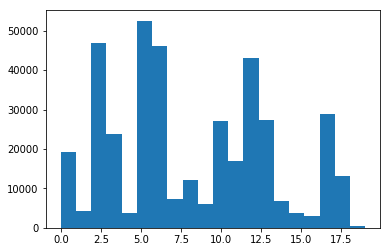

In [42]:
plt.hist(large_embedded_data["Labels"],bins=20)
plt.plot

In [46]:
a,b=read_classification_data()

REMOVING PUNCTUATIONS


100%|█████████████████████████████████████████████████████████████████████████| 396099/396099 [00:06<00:00, 63593.89it/s]


CONVERTING SENTENCE TO VECTOR


100%|█████████████████████████████████████████████████████████████████████████| 396099/396099 [00:19<00:00, 20757.84it/s]


SAVE VECTOR TO PANDAS DATAFRAME


100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.48it/s]


In [49]:
b.classes_

array(['elektronik', 'fashion_anak', 'fashion_pria', 'fashion_wanita',
       'food', 'handphone', 'hobi_dan_koleksi', 'industrial', 'kamera',
       'kesehatan', 'komputer', 'mobil', 'motor', 'olahraga',
       'perawatan_dan_kecantikan', 'perlengkapan_bayi',
       'perlengkapan_kantor', 'rumah_tangga', 'sepeda',
       'tiket_dan_voucher'], dtype=object)